# 列舉所有資產的riskiness r

In [2]:
import sympy
from pandas import Series,DataFrame
from scipy.optimize import fsolve
import math
import time
import pandas as pd
import numpy  as  np
import os
from datetime import datetime
from dateutil.relativedelta import relativedelta

# 無風險利率
* 我們須扣除無風險利率，得到超額報酬率以計算Riskiness r
* 目前使用LIBOR [1個月利率](https://www.global-rates.com/interest-rates/libor/american-dollar/usd-libor-interest-rate-overnight.aspx)

In [3]:
rfrate = 2.45785 / 12 /100
rfrate

0.0020482083333333333

# 自定義 functions，用來計算風險指標
- get_riskiness_r(guess , arr_returns)
    - 計算Riskiness R
- get_all_risk_with_return_data(df)
    - 傳入多組ETF的月報酬序列資料，分別計算各組ETF的Riskiness R
- get_top5(df)
    - 依照R值排序，並傳回前5名的ETF
    
### 關於超額報酬的數量級:
* 將要帶入公式的數值調整到介在0-100間，目的是為了讓大部分的Riskiness r介在0-100間。

In [4]:
def f1(x,arr_returns):
    arr_returns = arr_returns
    return np.mean( np.exp(-1*arr_returns/x) ) - 1
def get_riskiness_r(guess , arr_returns):
    while (guess<10**(2)):
        risk2 = fsolve(f1,guess,arr_returns)  #引用函數f1
        #print('guess:',guess,'risk:',risk2,"value:",f1(risk2,arr_returns))
        if (risk2 != guess) and (f1(risk2,arr_returns)<0.1):
            break
        guess = guess*10
    return risk2

def get_all_risk_with_return_data(df):
    global rfrate
    
    etf_list = list(df.columns)
    etf_risk = []
    
    # 計算每支ETF的riskiness r
    for etf_name in etf_list:
        etf_returns = df[etf_name] - rfrate  
        guess = 10**(-5)
        risk_r = get_riskiness_r(guess,etf_returns)
        etf_risk.append([etf_name,risk_r])
        
    df = pd.DataFrame(etf_risk,columns=['Name','Riskiness R'])
    return df

def get_top5(df):
    df_sorted = df.sort_values(by=['Riskiness R'])
    df_top5 = df_sorted[:5]
    return df_top5

# 自定義 functions，用來計算最佳配置的權重值


In [5]:
def risk(x):
    guess  = 10**(-5)
    while (guess<1000):
        risk2 = fsolve(f1,guess,x)  #引用函數f1
        if risk2[0] != guess:
            break
        guess = guess*10
    return risk2[0]
    #return np.std(x)

def sumrisk(weight,all_return):
    w = weight
    a = all_return
    v = 0
    for i in range(len(w)):
        v = v + w[i]*risk(w[i]*(all_return.iloc[:,i]))
    return v

def penalty(w):
    if min(w)<0 or max(w)>1:
        return 100000
    else:
        return 0

def portretmean(weight,all_return):
    w = weight
    a = all_return
    return np.mean(np.dot(np.array(all_return),np.array(weight)))    

def bestweight(w,all_return):
    r = []
    r.append(penalty(w)+np.abs(sum(w)-1)*1000)
    for i in range(len(w)-1):
        v =  np.abs( risk(w[i]*(all_return.iloc[:,i]))/ sumrisk(w,all_return)  \
            - (np.mean(all_return.iloc[:,i])-rfrate)/(portretmean(w,all_return)-rfrate) ) \
            + np.abs( risk(w[i+1]*(all_return.iloc[:,i+1]))/ sumrisk(w,all_return)  \
            - (np.mean(all_return.iloc[:,i+1])-rfrate)/(portretmean(w,all_return)-rfrate))
        r.append(v) 
    print('權重:',w,'誤差值:',v+penalty(w)+np.abs(sum(w)-1))
    return r

def fourdrop(x):
    a = []
    for i in range(len(x)):
        a.append(round(sum(x[i]),3))
    return a

# 完整的處理流程

依序產生以下檔案

- 每月資料夾下有4個檔案
    - all_group_return.csv：用來存所有群組的月報酬(該月報酬即為該群前5名ETF的月報酬之平均值)
    - all_group_risk.csv：用來存每個群組的Riskiness R(該Riskiness R是以該群月報酬去計算)
    - top5_group_list.csv：用來存所有群組中Riskiness R最小的前5名
    - top5_group_weight.csv：用來存前5名群組的最佳配置權重
    
- 每群資料夾下也有4個檔案
    - all_etf_return.csv：用來存該群中所有ETF的月報酬資料
    - all_etf_risk.csv：用來存該群中每支ETF以月報酬計算出來的Riskiness R
    - top5_etf_list.csv：用來存該群中前5名的ETF(以 Riskiness R 排序)
    - top5_etf_return.csv：用來存該群中前5名的ETF的月報酬取之平均值

In [6]:
def get_total_months(data_path):
    subdir = os.listdir(data_path)[0] #取第一個group的csv檔
    file_path = data_path + subdir + '/' + subdir + '_return.csv'
    if os.path.isfile(file_path):
        df = pd.read_csv(file_path)
        total_rows = df.shape[0]
        return total_rows

In [7]:
return_data_path = 'C:\\Users\\USER\\github\\HW1--data-mining\\FinalProject\\2014to2018RE_data_weekly\\'
risk_data_path = 'C:\\Users\\USER\\github\\HW1--data-mining\\FinalProject\\2017to2019Risk_data_weekly\\'

# 以程式取得資料總筆數
total_data = get_total_months(return_data_path)
print('共有',total_data,'個周的資料')

# 指定用來計算指標的資料個數
window_size = 36*4
print('取',window_size,'個周的資料計算風險指標')

rolling_times = total_data - window_size 
print('共滾動',rolling_times,'次')

共有 265 個周的資料
取 144 個周的資料計算風險指標
共滾動 121 次


In [9]:
for i in range(rolling_times-16):
    print('=== Rolling #',i+1,'===')
    
    #第一層目錄
    first_month = '2017-01-02'
    first_date = datetime.strptime(first_month,'%Y-%m-%d')
    the_date = first_date + relativedelta(weeks=i)
    date_string = the_date.strftime('%Y-%m-%d')
    risk_dir_path = os.path.join(risk_data_path,date_string)
    if not os.path.exists(risk_dir_path):
        os.makedirs(risk_dir_path)
        print('新增資料夾',risk_dir_path)
        
    #第二層目錄
    risk_dir_path_2nd = os.path.join(risk_dir_path,'all_groups/')
    if not os.path.exists(risk_dir_path_2nd):
        os.makedirs(risk_dir_path_2nd)
        print('新增資料夾',risk_dir_path_2nd)

    allgroup_top5_return = DataFrame()
    allgroup_top5_dict = dict()
    
    for subdir in os.listdir(return_data_path):
        #第三層目錄(group name)
        risk_dir_path_3rd = os.path.join(risk_dir_path_2nd,subdir)
        if not os.path.exists(risk_dir_path_3rd):
            os.makedirs(risk_dir_path_3rd)
            print('新增資料夾',risk_dir_path_3rd)
        
        subdir_path = os.path.join(return_data_path,subdir)
        if os.path.exists(subdir_path) and os.path.isdir(subdir_path):
            file = subdir + '_return.csv'
            file_path = os.path.join(subdir_path, file)
            if os.path.isfile(file_path):
                df = pd.read_csv(file_path)
                df_return = df.iloc[i:i+window_size,2:]
                print(df_return.shape)
                df_return = df_return.dropna(axis=1)
                print(df_return.shape)
                
                #第三層目錄下的檔案
                # 0. all_etf_return.csv
                csv_file = "all_etf_return.csv"
                save_path = os.path.join(risk_dir_path_3rd,csv_file)
                df_return.to_csv(save_path,index=False)
                
                # 1. all_etf_risk.csv
                df_etf_risk = get_all_risk_with_return_data(df_return)
                csv_file = "all_etf_risk.csv"
                save_path = os.path.join(risk_dir_path_3rd,csv_file)
                df_etf_risk.to_csv(save_path,index=False)
                
                # 2. top5_etf_list.csv
                df_top5_etf = get_top5(df_etf_risk)
                csv_file = "top5_etf_list.csv"
                save_path = os.path.join(risk_dir_path_3rd,csv_file)
                df_top5_etf.to_csv(save_path,index=False)
                
                # 3. top5_etf_return.csv
                top5_etf = df_top5_etf['Name']
                top5_return_average = df_return[top5_etf].mean(axis=1)
                allgroup_top5_return[subdir] = top5_return_average
                
                csv_file = "top5_etf_return.csv"
                save_path = os.path.join(risk_dir_path_3rd,csv_file)
                top5_return_average.to_csv(save_path,index=False)
                
                # 4. the_group_risk.csv
                # 改在第二層
                
                #[ top5_etf,allgroup_top5_return[subdir] ] = get_top5_etf(df)
                print('Group:',subdir)
                print('Top5:',top5_etf)
                print('================')
                #allgroup_top5_dict[subdir] = top5_etf
                
    #第二層
    # 4. all_group_return
    csv_file = "all_group_return.csv"
    save_path = os.path.join(risk_dir_path,csv_file)
    allgroup_top5_return.to_csv(save_path,index=False)
    
    # 5. all_group_risk
    df_group_risk = get_all_risk_with_return_data(allgroup_top5_return)
    csv_file = "all_group_risk.csv"
    save_path = os.path.join(risk_dir_path,csv_file)
    df_group_risk.to_csv(save_path,index=False)
    
    # 6. top5_group_list
    df_top5_group = get_top5(df_group_risk)
    csv_file = "top5_group_list.csv"
    save_path = os.path.join(risk_dir_path,csv_file)
    df_top5_group.to_csv(save_path,index=False)
    
    # 7. top_group_weight
    top5_group = df_top5_group['Name']    
    top5_group_return = allgroup_top5_return[top5_group]
    n = top5_group_return.shape[1]
    weight = [1/n]*n
    top5_group_best_weight = fsolve(bestweight,weight,top5_group_return)
    print(top5_group_best_weight)
    
    weight_list = []
    for i,group_name in enumerate(top5_group):
        group_weight = top5_group_best_weight[i]
        weight_list.append([group_name,group_weight])
    
    df_best_weight = pd.DataFrame(weight_list,columns=['Name','Weight'])
    print(df_best_weight)
    
    csv_file = "top5_group_weight.csv"
    save_path = os.path.join(risk_dir_path,csv_file)
    df_best_weight.to_csv(save_path,index=False)


=== Rolling # 1 ===
(144, 24)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
7      MNA
0     BTAL
10     QAI
9     MRGR
Name: Name, dtype: object
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 4     AXJL
6      CWI
17     VEU
18    VXUS
11     FPA
Name: Name, dtype: object
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59    SZO
19    DDP
28    DTO
54    SCO
7     BOS
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 5     INCO
13    RETL
17     UCC
14     RTH
3     FDIS
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
11     UGE
3      FXG
7     PSCC
8      PSL
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
0    DBO
Name: Name, dtype: object
(144, 26)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
3     CROC
7     EUFX
18     INR
Name: Name, dtype: object
(144, 65)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 12    ENZL
11    DXJS
2      DFJ
40     SCJ
1     DBJP
Name: Name, dtype: object
(144, 89)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 61     SMH
23    GDXJ
60     SIL
22     GDX
40    JNUG
Name: Name, dtype: object
(144, 63)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 16    GOEX
34    SILJ
2      CIL
11     FAN
32    RING
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
7      FLM
1     CROP
14     PEX
0     CARZ
Name: Name, dtype: object
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 55    SMIN
41    INCO
53    SCIF
54    SCIN
4     ASHR
Name: Name, dtype: object
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 11     EDZ
9      EDC
27    FNDE
0     ADRE
29    IEMG
Name: Name, dtype: object
(144, 65)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 13     FAN
12     ERY
8     EMLP
7      DUG
3     ATMP
Name: Name, dtype: object
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
5      FAS
7     FINU
35     UYG
23     KIE
Name: Name, dtype: object
(144, 44)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 21     IFV
16    GDXJ
29    SLVP
28     SIL
8      FAN
Name: Name, dtype: object
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 9      UBG
11    UGLD
8     SGOL
5      GLD
10     UGL
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
20     RYH
19     RXL
3     CURE
Name: Name, dtype: object
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 17    UXI
12    PPA
7     ITA
19    XAR
14    RGI
Name: Name, dtype: object
(144, 25)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 6      LQD
11    SPLB
14    VCLT
1     CORP
13    VCIT
Name: Name, dtype: object
(144, 21)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    SHYG
9     PGHY
0     ANGL
15     UJB
1     CJNK
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 13    GOEX
37    SILJ
11    GDXJ
38    SLVP
36     SIL
Name: Name, dtype: object
(144, 17)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7    RVNU
1     MLN
2     MUB
0     ITM
6     PZA
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6    PSK
4    PGF
5    PGX
0    FPE
2    PFF
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 17     REZ
7      ICF
20     RWR
22    SCHH
25     URE
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
5    IBCE
6    IBDC
4    IBCD
2    BSCL
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
25     SMH
38     XSD
29    SOXX
19    QTEC
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 5     LTL
7     XTL
6     VOX
1    FCOM
2    FONE
Name: Name, dtype: object
(144, 40)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 21    XMPT
11    ILTB
2      BLV
14    MINT
18    SCHZ
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 42    ZROZ
9      EDV
37     UBT
29     TMF
28     TLT
Name: Name, dtype: object
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 13     UPW
8     PSCU
11     RYU
1     FUTY
15     XLU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.480325507132018
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.480325507132018
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.480325507132018
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.4803254896706104
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.4803254972652997
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.480325500677538
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.480325514950409
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.4803255004676137
權重: [ 0.45000381  0.13465376  1.21011781 -0.15310601 -0.64166936] 誤差值: 100027.58804702054
權重: [0.37446591 0.43270072 0.29403716 0.46087168 0.25583721] 誤差值: 3.05039173266003
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.4803254896706104
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.4803254972652997
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.480325500677538
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.480325514950409
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.4803255004676137
權重: [ 0.45000381  0.13465376  1.21011781 -0.15310601 -0.64166936] 誤差值: 100027.58804702054
權重: [0.37446591 0.43270072 0.29403716 0.46087168 0.25583721] 誤差值: 3.05039173266003
權重: [0.3345

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5     HDG
3    FLAG
8     MOM
7     MNA
0    BTAL
Name: Name, dtype: object
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 9     EEMA
17     VEU
7     DBAP
0     AAXJ
11     FPA
Name: Name, dtype: object
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59    SZO
19    DDP
28    DTO
54    SCO
7     BOS
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 5     INCO
13    RETL
17     UCC
14     RTH
19     XLY
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
11     UGE
7     PSCC
3      FXG
12     VDC
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
(144, 26)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
18     INR
3     CROC
4      CYB
Name: Name, dtype: object
(144, 65)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 12    ENZL
11    DXJS
2      DFJ
31     GWX
22    FAUS
Name: Name, dtype: object
(144, 89)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 61     SMH
23    GDXJ
60     SIL
22     GDX
40    JNUG
Name: Name, dtype: object
(144, 63)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 16    GOEX
34    SILJ
2      CIL
32    RING
30    PSAU
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
1     CROP
12     IPO
0     CARZ
14     PEX
Name: Name, dtype: object
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 41    INCO
55    SMIN
53    SCIF
54    SCIN
44    INDY
Name: Name, dtype: object
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 11     EDZ
9      EDC
24     EWX
14     EEM
6     DGRE
Name: Name, dtype: object
(144, 65)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 13     FAN
12     ERY
33    MLPX
3     ATMP
44     PZD
Name: Name, dtype: object
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
5      FAS
7     FINU
35     UYG
28    PSCF
Name: Name, dtype: object
(144, 44)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 21     IFV
16    GDXJ
29    SLVP
28     SIL
8      FAN
Name: Name, dtype: object
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 9    UBG
7    IAU
4    DZZ
5    GLD
6    GLL
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
20     RYH
19     RXL
3     CURE
Name: Name, dtype: object
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 17     UXI
12     PPA
7      ITA
14     RGI
3     FIDU
Name: Name, dtype: object
(144, 25)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 6      LQD
11    SPLB
14    VCLT
0     CBND
2      GSY
Name: Name, dtype: object
(144, 21)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    SHYG
9     PGHY
15     UJB
0     ANGL
3      HYG
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 13    GOEX
37    SILJ
11    GDXJ
38    SLVP
36     SIL
Name: Name, dtype: object
(144, 17)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7    RVNU
1     MLN
9     SMB
3    MUNI
8     SHM
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6     PSK
4     PGF
3    PFXF
5     PGX
2     PFF
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 17     REZ
7      ICF
22    SCHH
20     RWR
25     URE
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
5    IBCE
4    IBCD
6    IBDC
3    BSCM
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
25     SMH
38     XSD
29    SOXX
19    QTEC
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 5     LTL
1    FCOM
6     VOX
7     XTL
2    FONE
Name: Name, dtype: object
(144, 40)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 21    XMPT
2      BLV
11    ILTB
4     BNDX
14    MINT
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 42    ZROZ
37     UBT
9      EDV
29     TMF
28     TLT
Name: Name, dtype: object
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 13    UPW
11    RYU
15    XLU
4     IDU
14    VPU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
3    VIIX
4    VIXM
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.575102023233555
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.575102023233555
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.575102023233555
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5751020223210938
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5751020233412262
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5751020222432661
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.575102035138282
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5751020357496012


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.20633578 0.33717183 0.20057363 0.06754938 0.18836938] 誤差值: 1.9528945984148105
權重: [0.1784117  0.17147593 0.16845075 0.28281538 0.19885506] 誤差值: 1.3374084250164102
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5751020223210938
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5751020233412262
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5751020222432661
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.575102035138282
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5751020357496012
權重: [0.20633578 0.33717183 0.20057363 0.06754938 0.18836938] 誤差值: 1.9528945984148105
權重: [0.1784117  0.17147593 0.16845075 0.28281538 0.19885506] 誤差值: 1.3374084250164102
權重: [0.1929168  0.23987301 0.19264026 0.17575634 0.19882184] 誤差值: 1.4725424078112097
權重: [0.19845868 0.18482226 0.19494484 0.21697101 0.20495643] 誤差值: 0.6580189396745332
權重: [0.20114983 0.20758821 0.20107915 0.19093174 0.19935349] 誤差值: 0.5341072376273575
權重: [0.20258007 0.22394659 0.20220184 0.17370471 0.19756662] 誤差值: 0.44550805382151404
權重: [0.20339502 0.25948287 0.20237168 0.14214467 0.19268183] 誤差值: 1.44

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
8      MOM
7      MNA
13     RLY
Name: Name, dtype: object
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 17     VEU
3      AIA
6      CWI
0     AAXJ
7     DBAP
Name: Name, dtype: object
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59    SZO
28    DTO
19    DDP
54    SCO
7     BOS
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 5     INCO
13    RETL
17     UCC
14     RTH
6      IYC
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
11     UGE
7     PSCC
12     VDC
3      FXG
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
1      CEW
7     EUFX
18     INR
Name: Name, dtype: object
(144, 65)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 12    ENZL
2      DFJ
40     SCJ
34    JPNL
21     EZJ
Name: Name, dtype: object
(144, 89)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 61     SMH
23    GDXJ
60     SIL
22     GDX
40    JNUG
Name: Name, dtype: object
(144, 63)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 16    GOEX
34    SILJ
2      CIL
32    RING
30    PSAU
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4     EFO
0    CARZ
1    CROP
6    FDTS
3     DZK
Name: Name, dtype: object
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 55    SMIN
41    INCO
53    SCIF
54    SCIN
47    KWEB
Name: Name, dtype: object
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 11     EDZ
9      EDC
3      BKF
6     DGRE
24     EWX
Name: Name, dtype: object
(144, 65)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 13     FAN
12     ERY
7      DUG
8     EMLP
33    MLPX
Name: Name, dtype: object
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
5      FAS
35     UYG
7     FINU
3     CHIX
Name: Name, dtype: object
(144, 44)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 21     IFV
16    GDXJ
29    SLVP
28     SIL
8      FAN
Name: Name, dtype: object
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 11    UGLD
0      DGL
5      GLD
2      DGP
10     UGL
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
20     RYH
19     RXL
3     CURE
Name: Name, dtype: object
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 17     UXI
12     PPA
7      ITA
19     XAR
1     CHII
Name: Name, dtype: object
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
15    VCLT
12    SPLB
0     CBND
1     CORP
Name: Name, dtype: object
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 14    SHYG
11    PGHY
3      HYG
0     ANGL
17     UJB
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 13    GOEX
37    SILJ
11    GDXJ
38    SLVP
36     SIL
Name: Name, dtype: object
(144, 17)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7    RVNU
1     MLN
6     PZA
5     PVI
9     SMB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6     PSK
4     PGF
5     PGX
0     FPE
3    PFXF
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 17     REZ
7      ICF
20     RWR
22    SCHH
14     PSR
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
5    IBCE
4    IBCD
6    IBDC
2    BSCL
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
25     SMH
38     XSD
29    SOXX
19    QTEC
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 5     LTL
2    FONE
1    FCOM
6     VOX
7     XTL
Name: Name, dtype: object
(144, 40)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 23    XMPT
13    ILTB
4      BLV
16    MINT
6     BNDX
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 42    ZROZ
9      EDV
37     UBT
29     TMF
28     TLT
Name: Name, dtype: object
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 13     UPW
11     RYU
15     XLU
1     FUTY
14     VPU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
6     XVZ
3    VIIX
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.710430169273102
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.710430169273102
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.710430169273102
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.710430169215722
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7104301680947039
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7104301679567115
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7104301812004251
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.710430180196341


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.65041145  0.83122987  0.54380056  0.59002231 -0.31464129] 誤差值: 100004.00273207453
權重: [0.10490985 0.00586743 0.32530894 0.02423882 0.0539079 ] 誤差值: 14.947601720462083
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.710430169215722
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7104301680947039
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7104301679567115
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7104301812004251
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.710430180196341
權重: [-0.65041145  0.83122987  0.54380056  0.59002231 -0.31464129] 誤差值: 100004.00273207453
權重: [0.10490985 0.00586743 0.32530894 0.02423882 0.0539079 ] 誤差值: 14.947601720462083
權重: [0.24043589 0.15817476 0.26153883 0.30566702 0.20761774] 誤差值: 2.0223961141185236
權重: [0.21052764 0.23709124 0.2241741  0.15011079 0.20623931] 誤差值: 0.46954151638206554
權重: [0.1985029  0.21495972 0.20467107 0.16997417 0.2005783 ] 誤差值: 0.5898836996372934
權重: [0.20330512 0.19521187 0.20058949 0.21583795 0.20154847] 誤差值: 0.7761074894373399
權重: [0.20249226 0.19878096 0.20108356 0.20777218 0.20160638] 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
8      MOM
7      MNA
10     QAI
Name: Name, dtype: object
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 8      DNL
4     AXJL
9     EEMA
3      AIA
18    VXUS
Name: Name, dtype: object
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
19     DDP
28     DTO
54     SCO
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 5     INCO
13    RETL
17     UCC
14     RTH
3     FDIS
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
11     UGE
3      FXG
7     PSCC
13     XLP
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
8    USO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6     DRR
8     EUO
1     CEW
18    INR
23    UUP
Name: Name, dtype: object
(144, 65)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 12    ENZL
2      DFJ
11    DXJS
34    JPNL
18     EWT
Name: Name, dtype: object
(144, 89)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 61     SMH
23    GDXJ
60     SIL
22     GDX
40    JNUG
Name: Name, dtype: object
(144, 63)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 16    GOEX
34    SILJ
2      CIL
32    RING
30    PSAU
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
1     CROP
0     CARZ
13    PAGG
10     HGI
Name: Name, dtype: object
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 41    INCO
55    SMIN
53    SCIF
54    SCIN
4     ASHR
Name: Name, dtype: object
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 11     EDZ
9      EDC
0     ADRE
28    HILO
2     BICK
Name: Name, dtype: object
(144, 65)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 12     ERY
13     FAN
8     EMLP
33    MLPX
23    ICLN
Name: Name, dtype: object
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 32     RYF
38     XLF
20    KBWP
5      FAS
7     FINU
Name: Name, dtype: object
(144, 44)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 21     IFV
16    GDXJ
29    SLVP
28     SIL
3      EDC
Name: Name, dtype: object
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 11    UGLD
2      DGP
10     UGL
7      IAU
5      GLD
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
20     RYH
19     RXL
3     CURE
Name: Name, dtype: object
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 17    UXI
12    PPA
7     ITA
20    XLI
8     IYJ
Name: Name, dtype: object
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
15    VCLT
12    SPLB
14    VCIT
13    USIG
Name: Name, dtype: object
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 14    SHYG
11    PGHY
0     ANGL
17     UJB
16    SJNK
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 13    GOEX
37    SILJ
11    GDXJ
38    SLVP
36     SIL
Name: Name, dtype: object
(144, 17)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7    RVNU
1     MLN
5     PVI
2     MUB
9     SMB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6     PSK
4     PGF
5     PGX
2     PFF
3    PFXF
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 17     REZ
7      ICF
22    SCHH
27     VNQ
20     RWR
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
5    IBCE
6    IBDC
4    IBCD
2    BSCL
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 25     SMH
14     PSI
38     XSD
29    SOXX
19    QTEC
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 5     LTL
2    FONE
7     XTL
1    FCOM
3     IXP
Name: Name, dtype: object
(144, 40)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 23    XMPT
13    ILTB
4      BLV
0      AGG
21    SPAB
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 42    ZROZ
9      EDV
37     UBT
28     TLT
29     TMF
Name: Name, dtype: object
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 13     UPW
15     XLU
11     RYU
1     FUTY
14     VPU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
3    VIIX
4    VIXM
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7080232033888523
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7080232033888523
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7080232033888523
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7080232006831866
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7080232029922893
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7080232007898395
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.708023215079024
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7080232133686089


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.15297128  0.57756494  0.44198029  0.41859332 -0.28516726] 誤差值: 100003.93316689772
權重: [ 0.15543324 -0.00336081  0.31258932  0.03583609  0.05073766] 誤差值: 100002.09354778373
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7080232006831866
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7080232029922893
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7080232007898395
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.708023215079024
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7080232133686089
權重: [-0.15297128  0.57756494  0.44198029  0.41859332 -0.28516726] 誤差值: 100003.93316689772
權重: [ 0.15543324 -0.00336081  0.31258932  0.03583609  0.05073766] 誤差值: 100002.09354778373
權重: [0.24703288 0.29827971 0.23922264 0.08670891 0.20823818] 誤差值: 0.646162386471741
權重: [0.21270367 0.24977076 0.21176575 0.1386468  0.20607821] 誤差值: 0.420962822437119
權重: [0.21352665 0.22410976 0.21448554 0.17432794 0.2033678 ] 誤差值: 0.5861721699433398
權重: [0.20651868 0.21234143 0.20650624 0.18687911 0.20135255] 誤差值: 0.646346010570742
權重: [0.20305336 0.20631296 0.20287918 0.19329049 0.200

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
7      MNA
0     BTAL
10     QAI
Name: Name, dtype: object
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7     DBAP
3      AIA
0     AAXJ
17     VEU
8      DNL
Name: Name, dtype: object
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59    SZO
19    DDP
28    DTO
54    SCO
7     BOS
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 5     INCO
13    RETL
17     UCC
14     RTH
6      IYC
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
11     UGE
7     PSCC
3      FXG
13     XLP
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
1      CEW
18     INR
7     EUFX
Name: Name, dtype: object
(144, 65)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 12    ENZL
2      DFJ
15     EWH
18     EWT
11    DXJS
Name: Name, dtype: object
(144, 89)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 61     SMH
23    GDXJ
60     SIL
40    JNUG
47    NUGT
Name: Name, dtype: object
(144, 63)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 16    GOEX
34    SILJ
2      CIL
32    RING
35     TOK
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
12     IPO
1     CROP
2      DPK
0     CARZ
Name: Name, dtype: object
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 41    INCO
55    SMIN
53    SCIF
54    SCIN
27     EPI
Name: Name, dtype: object
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 11     EDZ
9      EDC
33    SCHE
0     ADRE
1     BBRC
Name: Name, dtype: object
(144, 65)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 12     ERY
33    MLPX
8     EMLP
13     FAN
5      DDG
Name: Name, dtype: object
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 32     RYF
20    KBWP
38     XLF
5      FAS
7     FINU
Name: Name, dtype: object
(144, 44)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 21     IFV
16    GDXJ
29    SLVP
28     SIL
3      EDC
Name: Name, dtype: object
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 11    UGLD
9      UBG
6      GLL
10     UGL
4      DZZ
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
20     RYH
19     RXL
3     CURE
Name: Name, dtype: object
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 17    UXI
12    PPA
19    XAR
7     ITA
14    RGI
Name: Name, dtype: object
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
15    VCLT
12    SPLB
5     IGIB
0     CBND
Name: Name, dtype: object
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 14    SHYG
11    PGHY
17     UJB
13    RIGS
12     PHB
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 13    GOEX
37    SILJ
11    GDXJ
38    SLVP
36     SIL
Name: Name, dtype: object
(144, 17)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     RVNU
1      MLN
6      PZA
9      SMB
10    SMMU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6     PSK
5     PGX
4     PGF
0     FPE
3    PFXF
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 17     REZ
7      ICF
25     URE
22    SCHH
0      DRN
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
5    IBCE
4    IBCD
6    IBDC
3    BSCM
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
25     SMH
38     XSD
29    SOXX
19    QTEC
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 5     LTL
2    FONE
1    FCOM
4     IYZ
6     VOX
Name: Name, dtype: object
(144, 40)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 23    XMPT
13    ILTB
4      BLV
7     BOND
16    MINT
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 42    ZROZ
9      EDV
37     UBT
29     TMF
28     TLT
Name: Name, dtype: object
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 13     UPW
15     XLU
11     RYU
1     FUTY
14     VPU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6866197540854828
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6866197540854828
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6866197540854828
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6866197531480709
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6866197523381506
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6866197525116132
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6866197656056652
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.686619765154088


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.20643854  0.48767676  0.46480993  0.44072463 -0.18677278] 誤差值: 100002.95036946039
權重: [0.18086835 0.09780186 0.29153694 0.03528804 0.1002571 ] 誤差值: 2.4603697116429255
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6866197531480709
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6866197523381506
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6866197525116132
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6866197656056652
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.686619765154088
權重: [-0.20643854  0.48767676  0.46480993  0.44072463 -0.18677278] 誤差值: 100002.95036946039
權重: [0.18086835 0.09780186 0.29153694 0.03528804 0.1002571 ] 誤差值: 2.4603697116429255
權重: [0.28784545 0.26847928 0.20863318 0.23862413 0.19026463] 誤差值: 1.1356034540085809
權重: [0.2253322  0.23142264 0.16819169 0.22895028 0.19386146] 誤差值: 0.7328018930460335
權重: [0.21174536 0.21662628 0.19252112 0.21875392 0.20756118] 誤差值: 0.7684648429132669
權重: [0.19547126 0.19226877 0.20373082 0.19014395 0.19466536] 誤差值: 0.6771597331134502
權重: [0.19851989 0.19638991 0.20241075 0.19490898 0.19717226] 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
7      MNA
10     QAI
0     BTAL
Name: Name, dtype: object
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 4     AXJL
18    VXUS
3      AIA
0     AAXJ
11     FPA
Name: Name, dtype: object
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59    SZO
19    DDP
28    DTO
54    SCO
7     BOS
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 5     INCO
13    RETL
17     UCC
14     RTH
6      IYC
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
11     UGE
7     PSCC
3      FXG
13     XLP
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
7    USL
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
1      CEW
18     INR
7     EUFX
Name: Name, dtype: object
(144, 65)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 12    ENZL
11    DXJS
41     VPL
30     FPA
18     EWT
Name: Name, dtype: object
(144, 89)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 61     SMH
23    GDXJ
60     SIL
40    JNUG
47    NUGT
Name: Name, dtype: object
(144, 63)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 16    GOEX
34    SILJ
2      CIL
32    RING
13     FPA
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
5      EFU
1     CROP
3      DZK
13    PAGG
Name: Name, dtype: object
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 41    INCO
55    SMIN
53    SCIF
54    SCIN
49     PEK
Name: Name, dtype: object
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 11     EDZ
9      EDC
28    HILO
34    SPEM
24     EWX
Name: Name, dtype: object
(144, 65)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 12     ERY
8     EMLP
22    GRID
7      DUG
35     NLR
Name: Name, dtype: object
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
32     RYF
38     XLF
5      FAS
7     FINU
Name: Name, dtype: object
(144, 44)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 21     IFV
16    GDXJ
29    SLVP
28     SIL
13    FONE
Name: Name, dtype: object
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
11    UGLD
6      GLL
2      DGP
0      DGL
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
3     CURE
19     RXL
20     RYH
Name: Name, dtype: object
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 17     UXI
12     PPA
1     CHII
4      FIW
13    PSCI
Name: Name, dtype: object
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
15    VCLT
12    SPLB
8     PFIG
9     QLTA
Name: Name, dtype: object
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 14    SHYG
11    PGHY
17     UJB
0     ANGL
13    RIGS
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 13    GOEX
37    SILJ
11    GDXJ
38    SLVP
36     SIL
Name: Name, dtype: object
(144, 17)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     RVNU
9      SMB
11     SUB
1      MLN
0      ITM
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
3    PFXF
0     FPE
5     PGX
2     PFF
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 17     REZ
25     URE
7      ICF
0      DRN
22    SCHH
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
5    IBCE
6    IBDC
4    IBCD
3    BSCM
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
25     SMH
38     XSD
29    SOXX
34     USD
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 5     LTL
2    FONE
1    FCOM
4     IYZ
7     XTL
Name: Name, dtype: object
(144, 40)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 23    XMPT
13    ILTB
10    FWDB
9     FTSD
6     BNDX
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 42    ZROZ
37     UBT
9      EDV
29     TMF
34     TYD
Name: Name, dtype: object
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 13     UPW
15     XLU
8     PSCU
11     RYU
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
3    VIIX
5    VIXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6671072597616057
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6671072597616057
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6671072597616057
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6671072594034908
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6671072577615724
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6671072575576117
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6671072713923816
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6671072706101028


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.71405774  0.85261613 -0.69173082  0.86288468 -0.73782773] 誤差值: 100000.34567347735
權重: [0.31029279 0.08790968 0.13911686 0.00790605 0.09377425] 誤差值: 2.737107154538257
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6671072594034908
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6671072577615724
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6671072575576117
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6671072713923816
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6671072706101028
權重: [ 0.71405774  0.85261613 -0.69173082  0.86288468 -0.73782773] 誤差值: 100000.34567347735
權重: [0.31029279 0.08790968 0.13911686 0.00790605 0.09377425] 誤差值: 2.737107154538257
權重: [0.21981838 0.27026161 0.27553809 0.22333775 0.20811866] 誤差值: 1.1440355242480034
權重: [0.17155189 0.22530188 0.225894   0.22811094 0.19887239] 誤差值: 1.1554312166895921
權重: [0.21947009 0.20544544 0.19940621 0.18244719 0.20326647] 誤差值: 0.5994731357657127
權重: [0.20980432 0.19898846 0.19999139 0.190922   0.19844848] 誤差值: 0.6273358757866369
權重: [0.20429441 0.19869813 0.19962083 0.19523093 0.19842933] 誤

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
7      MNA
9     MRGR
10     QAI
Name: Name, dtype: object
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 18    VXUS
3      AIA
7     DBAP
5     CHIQ
0     AAXJ
Name: Name, dtype: object
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59    SZO
19    DDP
28    DTO
54    SCO
7     BOS
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 5     INCO
13    RETL
17     UCC
14     RTH
6      IYC
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
11     UGE
7     PSCC
3      FXG
8      PSL
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
7    USL
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
1      CEW
18     INR
3     CROC
Name: Name, dtype: object
(144, 65)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 2      DFJ
15     EWH
11    DXJS
12    ENZL
22    FAUS
Name: Name, dtype: object
(144, 89)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 61     SMH
23    GDXJ
60     SIL
47    NUGT
22     GDX
Name: Name, dtype: object
(144, 63)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 16    GOEX
2      CIL
34    SILJ
30    PSAU
32    RING
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
5      EFU
1     CROP
14     PEX
0     CARZ
Name: Name, dtype: object
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 55    SMIN
41    INCO
53    SCIF
54    SCIN
49     PEK
Name: Name, dtype: object
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 11    EDZ
9     EDC
24    EWX
12    EEB
36    VWO
Name: Name, dtype: object
(144, 65)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 12     ERY
8     EMLP
7      DUG
3     ATMP
31    MLPG
Name: Name, dtype: object
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 32     RYF
20    KBWP
38     XLF
5      FAS
7     FINU
Name: Name, dtype: object
(144, 44)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 21     IFV
16    GDXJ
29    SLVP
28     SIL
3      EDC
Name: Name, dtype: object
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 9     UBG
0     DGL
5     GLD
4     DZZ
8    SGOL
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
3     CURE
19     RXL
20     RYH
Name: Name, dtype: object
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 17     UXI
1     CHII
4      FIW
21     XTN
19     XAR
Name: Name, dtype: object
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
15    VCLT
12    SPLB
16    VCSH
0     CBND
Name: Name, dtype: object
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 14    SHYG
11    PGHY
0     ANGL
17     UJB
3      HYG
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 13    GOEX
37    SILJ
11    GDXJ
38    SLVP
36     SIL
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     RVNU
1      MLN
11    SMMU
2      MUB
13     TFI
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 3    PFXF
0     FPE
5     PGX
6     PSK
2     PFF
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 17     REZ
25     URE
7      ICF
0      DRN
22    SCHH
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
5    IBCE
4    IBCD
3    BSCM
6    IBDC
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
25     SMH
38     XSD
29    SOXX
34     USD
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 5     LTL
2    FONE
7     XTL
6     VOX
1    FCOM
Name: Name, dtype: object
(144, 40)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    XMPT
4      BLV
7     BOND
14    ILTB
21    SCHZ
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 42    ZROZ
37     UBT
9      EDV
29     TMF
34     TYD
Name: Name, dtype: object
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 13     UPW
15     XLU
11     RYU
8     PSCU
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
6     XVZ
2    UVXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.46966836558118663
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.46966836558118663
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.46966836558118663
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4696683663410619
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4696683646952544
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4696683637525515
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4696683779334513
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4696683780645985


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.44916603  0.40374404 -0.0982764   0.38022024 -0.13485392] 誤差值: 100007.19451945859
權重: [0.30111012 0.04090914 0.16322904 0.054321   0.1296611 ] 誤差值: 3.0904800427001673
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4696683663410619
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4696683646952544
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4696683637525515
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4696683779334513
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4696683780645985
權重: [ 0.44916603  0.40374404 -0.0982764   0.38022024 -0.13485392] 誤差值: 100007.19451945859
權重: [0.30111012 0.04090914 0.16322904 0.054321   0.1296611 ] 誤差值: 3.0904800427001673
權重: [0.23798696 0.23481407 0.25768482 0.23868982 0.22025747] 誤差值: 1.958862158530075
權重: [0.2149945  0.17366025 0.1767374  0.17757212 0.20311358] 誤差值: 0.5062432972072743
權重: [0.20675746 0.18582443 0.19405344 0.18659676 0.19438745] 誤差值: 0.459234898539462
權重: [0.20381063 0.19288568 0.19784053 0.19333908 0.19698105] 誤差值: 0.4626779495804122
權重: [0.20206191 0.19643606 0.19909315 0.19669396 0.19854588] 誤

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5     HDG
7     MNA
0    BTAL
3    FLAG
9    MRGR
Name: Name, dtype: object
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 11     FPA
3      AIA
18    VXUS
0     AAXJ
15     PAF
Name: Name, dtype: object
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
19     DDP
28     DTO
54     SCO
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 5     INCO
13    RETL
17     UCC
14     RTH
19     XLY
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
11     UGE
3      FXG
7     PSCC
12     VDC
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
1      CEW
7     EUFX
18     INR
Name: Name, dtype: object
(144, 65)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 11    DXJS
34    JPNL
2      DFJ
40     SCJ
15     EWH
Name: Name, dtype: object
(144, 89)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 61     SMH
23    GDXJ
60     SIL
42     KXI
47    NUGT
Name: Name, dtype: object
(144, 63)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 16    GOEX
2      CIL
34    SILJ
32    RING
0     ACIM
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
0     CARZ
1     CROP
14     PEX
5      EFU
Name: Name, dtype: object
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 55    SMIN
41    INCO
53    SCIF
54    SCIN
27     EPI
Name: Name, dtype: object
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 11     EDZ
9      EDC
6     DGRE
31     PXH
2     BICK
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 12     ERY
44     PZD
13     FAN
8     EMLP
33    MLPX
Name: Name, dtype: object
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
32     RYF
38     XLF
5      FAS
7     FINU
Name: Name, dtype: object
(144, 44)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 21     IFV
16    GDXJ
29    SLVP
28     SIL
3      EDC
Name: Name, dtype: object
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 11    UGLD
8     SGOL
4      DZZ
5      GLD
3      DGZ
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
3     CURE
19     RXL
20     RYH
Name: Name, dtype: object
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 17    UXI
12    PPA
19    XAR
7     ITA
2     EXI
Name: Name, dtype: object
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
12    SPLB
15    VCLT
0     CBND
9     QLTA
Name: Name, dtype: object
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 14    SHYG
11    PGHY
17     UJB
12     PHB
9     HYZD
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 13    GOEX
37    SILJ
11    GDXJ
38    SLVP
36     SIL
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7    RVNU
6     PZA
2     MUB
4     PRB
0     ITM
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
3    PFXF
5     PGX
0     FPE
6     PSK
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 17     REZ
25     URE
0      DRN
7      ICF
22    SCHH
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
5    IBCE
4    IBCD
6    IBDC
3    BSCM
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
25     SMH
38     XSD
29    SOXX
19    QTEC
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 5     LTL
1    FCOM
7     XTL
2    FONE
6     VOX
Name: Name, dtype: object
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 4      BLV
14    ILTB
22    SCHZ
25    XMPT
12     GVI
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 37     UBT
29     TMF
42    ZROZ
9      EDV
34     TYD
Name: Name, dtype: object
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 13     UPW
11     RYU
15     XLU
1     FUTY
14     VPU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
3    VIIX
6     XVZ
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7671801510766532
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7671801510766532
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7671801510766532
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7671801488800488
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7671801483281532
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7671801479097481
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7671801598769417
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7671801619035641
權重: [ 0.76982251  1.14133913 -1.35607843  2.10548198 -1.6605652 ] 誤差值: 100000.42267881363


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.38695941 -0.01437521  0.00422358 -0.10955262 -0.04957317] 誤差值: 100002.34311327164
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7671801488800488
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7671801483281532
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7671801479097481
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7671801598769417
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7671801619035641
權重: [ 0.76982251  1.14133913 -1.35607843  2.10548198 -1.6605652 ] 誤差值: 100000.42267881363
權重: [ 0.38695941 -0.01437521  0.00422358 -0.10955262 -0.04957317] 誤差值: 100002.34311327164
權重: [0.27693222 0.42589449 0.19113364 0.1312824  0.17678719] 誤差值: 2.2731518319633697
權重: [0.25476819 0.11108754 0.2541816  0.23724014 0.21854392] 誤差值: 1.4509015615969387
權重: [0.18980719 0.2546791  0.18823694 0.18988617 0.17636542] 誤差值: 0.5988173841752871
權重: [0.2055942  0.22843725 0.19116686 0.20032469 0.19257482] 誤差值: 0.7164631146508535
權重: [0.20428958 0.21351831 0.19599492 0.2024596  0.19551985] 誤差值: 0.7459172551355304
權重: [0.20226776 0.2063134  0.19796139 0.20218425 0.1973

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
7      MNA
0     BTAL
10     QAI
Name: Name, dtype: object
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7    DBAP
3     AIA
0    AAXJ
5    CHIQ
9    EEMA
Name: Name, dtype: object
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
28     DTO
19     DDP
54     SCO
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 5     INCO
13    RETL
17     UCC
14     RTH
19     XLY
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9     RHS
11    UGE
3     FXG
13    XLP
12    VDC
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
7    USL
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
1      CEW
18     INR
7     EUFX
Name: Name, dtype: object
(144, 65)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 12    DXJS
35    JPNL
3      DFJ
41     SCJ
22     EZJ
Name: Name, dtype: object
(144, 89)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 61     SMH
23    GDXJ
60     SIL
47    NUGT
40    JNUG
Name: Name, dtype: object
(144, 63)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 17    GOEX
2      CIL
35    SILJ
33    RING
31    PSAU
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4     EFO
1    CROP
3     DZK
0    CARZ
5     EFU
Name: Name, dtype: object
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 55    SMIN
41    INCO
53    SCIF
54    SCIN
49     PEK
Name: Name, dtype: object
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 11     EDZ
9      EDC
33    SCHE
12     EEB
36     VWO
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 12     ERY
13     FAN
3     ATMP
35     NLR
8     EMLP
Name: Name, dtype: object
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 32     RYF
20    KBWP
38     XLF
5      FAS
7     FINU
Name: Name, dtype: object
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 22     IFV
17    GDXJ
30    SLVP
29     SIL
4      EDC
Name: Name, dtype: object
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    SGOL
6     GLL
7     IAU
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
3     CURE
23     XHE
19     RXL
1      BIB
Name: Name, dtype: object
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 17    UXI
14    RGI
19    XAR
12    PPA
20    XLI
Name: Name, dtype: object
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
12    SPLB
15    VCLT
9     QLTA
1     CORP
Name: Name, dtype: object
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 14    SHYG
11    PGHY
17     UJB
0     ANGL
12     PHB
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 13    GOEX
37    SILJ
11    GDXJ
38    SLVP
36     SIL
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     RVNU
1      MLN
5      PVI
11    SMMU
9     SHYD
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
5     PGX
0     FPE
2     PFF
3    PFXF
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 17     REZ
25     URE
0      DRN
12    MORL
7      ICF
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
5    IBCE
6    IBDC
4    IBCD
3    BSCM
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
25     SMH
38     XSD
29    SOXX
34     USD
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
7     XTL
6     VOX
4     IYZ
1    FCOM
Name: Name, dtype: object
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    ILTB
25    XMPT
4      BLV
9     FTSD
22    SCHZ
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 37     UBT
42    ZROZ
29     TMF
9      EDV
34     TYD
Name: Name, dtype: object
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 13     UPW
8     PSCU
15     XLU
14     VPU
11     RYU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
3    VIIX
6     XVZ
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7916293149564358
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7916293149564358
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7916293149564358
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7916293146931375
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7916293103421925
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.791629311422167
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.791629326863328
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7916293228858281


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.83728101  1.35661888 -0.87023036  1.48252787 -1.8061974 ] 誤差值: 100000.786957492
權重: [ 0.5039359  -0.5397882  -0.4060521  -0.6409189  -0.45240281] 誤差值: 100003.78707155501
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7916293146931375
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7916293103421925
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.791629311422167
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.791629326863328
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7916293228858281
權重: [ 0.83728101  1.35661888 -0.87023036  1.48252787 -1.8061974 ] 誤差值: 100000.786957492
權重: [ 0.5039359  -0.5397882  -0.4060521  -0.6409189  -0.45240281] 誤差值: 100003.78707155501
權重: [ 0.2667653   0.64059634  0.10773819  0.69041237 -0.09552648] 誤差值: 100000.99157857597
權重: [0.13869191 0.37832297 0.33147218 0.43628324 0.35830751] 誤差值: 2.810373004153079
權重: [0.3093233  0.15957528 0.08224902 0.12812342 0.22854418] 誤差值: 2.4560256800836395
權重: [0.17074312 0.25888756 0.23761272 0.24107248 0.2305432 ] 誤差值: 1.4873805411130276
權重: [0.23929939 0.18301069 0.20686798 0.18825322 0.1

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
15    WTMF
7      MNA
0     BTAL
Name: Name, dtype: object
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 9     EEMA
11     FPA
5     CHIQ
7     DBAP
14    IQDY
Name: Name, dtype: object
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
28     DTO
19     DDP
54     SCO
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 13    RETL
5     INCO
17     UCC
14     RTH
19     XLY
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
9      RHS
11     UGE
3      FXG
12     VDC
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
7    USL
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
7     EUFX
23     UUP
18     INR
Name: Name, dtype: object
(144, 65)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 12    DXJS
36    JPNL
3      DFJ
22     EZJ
42     SCJ
Name: Name, dtype: object
(144, 89)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 61     SMH
23    GDXJ
54    ROBO
55     RXI
56    SCHC
Name: Name, dtype: object
(144, 63)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2      CIL
17    GOEX
35    SILJ
31    PSAU
33    RING
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
1     CROP
6     FDTS
12     IPO
2      DPK
Name: Name, dtype: object
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 55    SMIN
41    INCO
53    SCIF
49     PEK
4     ASHR
Name: Name, dtype: object
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 11     EDZ
9      EDC
36     VWO
34    SPEM
31     PXH
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 12     ERY
23    ICLN
3     ATMP
7      DUG
1     AMLP
Name: Name, dtype: object
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
32     RYF
38     XLF
23     KIE
30    QABA
Name: Name, dtype: object
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 22     IFV
4      EDC
17    GDXJ
14    FONE
20    ICLN
Name: Name, dtype: object
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 4      DZZ
10     UGL
7      IAU
11    UGLD
5      GLD
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
19     RXL
3     CURE
22     XBI
Name: Name, dtype: object
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 7     ITA
12    PPA
17    UXI
19    XAR
21    XTN
Name: Name, dtype: object
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
15    VCLT
12    SPLB
4     IGHG
Name: Name, dtype: object
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 14    SHYG
11    PGHY
17     UJB
0     ANGL
12     PHB
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 13    GOEX
37    SILJ
48     XLB
28     PKB
43     UYM
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6     PZA
0     ITM
1     MLN
7    RVNU
5     PVI
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
5     PGX
2     PFF
3    PFXF
0     FPE
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 0      DRN
25     URE
11    KBWY
17     REZ
12    MORL
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
5    IBCE
4    IBCD
6    IBDC
2    BSCL
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
25     SMH
38     XSD
13    PSCT
29    SOXX
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 5     LTL
2    FONE
6     VOX
1    FCOM
7     XTL
Name: Name, dtype: object
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    MINC
11     GBF
9     FTSD
14    ILTB
4      BLV
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TMF
37     UBT
42    ZROZ
9      EDV
19     SHV
Name: Name, dtype: object
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
13     UPW
2      FXU
11     RYU
14     VPU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
6     XVZ
4    VIXM
2    UVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1640045752842165
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1640045752842165
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1640045752842165
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1640045745601473
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1640045719854741
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1640045697692656
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.164004583725098
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1640045837646824


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.36857352  0.54059271  0.53615047 -0.1541663   0.44599665] 誤差值: 100000.97466821833
權重: [ 0.11404468  0.26532057 -0.02730861 -0.01856224 -0.07105497] 誤差值: 100019.53848552017
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1640045745601473
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1640045719854741
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1640045697692656
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.164004583725098
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1640045837646824
權重: [-0.36857352  0.54059271  0.53615047 -0.1541663   0.44599665] 誤差值: 100000.97466821833
權重: [ 0.11404468  0.26532057 -0.02730861 -0.01856224 -0.07105497] 誤差值: 100019.53848552017
權重: [0.22049993 0.2786479  0.23487606 0.18749942 0.22963426] 誤差值: 1.9355841789638157
權重: [0.1917478  0.16445715 0.18981198 0.21041355 0.17410427] 誤差值: 1.2964013523460518
權重: [0.19502725 0.21336733 0.21386556 0.19579051 0.21184093] 誤差值: 1.1444085771697845
權重: [0.19602922 0.20572839 0.20696519 0.19838341 0.20622039] 誤差值: 1.1581380119998133
權重: [0.19762897 0.20240704 0.20352041 0.19921501 0.

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
15    WTMF
7      MNA
10     QAI
Name: Name, dtype: object
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6      CWI
9     EEMA
5     CHIQ
15     PAF
13    IQDE
Name: Name, dtype: object
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
28     DTO
19     DDP
54     SCO
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 13    RETL
5     INCO
17     UCC
14     RTH
19     XLY
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
9      RHS
3      FXG
6      PBJ
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
16    FXSG
7     EUFX
23     UUP
Name: Name, dtype: object
(144, 65)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 12    DXJS
36    JPNL
3      DFJ
11     DXJ
42     SCJ
Name: Name, dtype: object
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 62     SMH
67    URTH
28    HEFA
70     VSS
19     FGD
Name: Name, dtype: object
(144, 63)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2      CIL
17    GOEX
35    SILJ
10     EFZ
5      DEW
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4     EFO
5     EFU
2     DPK
1    CROP
0    CARZ
Name: Name, dtype: object
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 55    SMIN
41    INCO
53    SCIF
54    SCIN
49     PEK
Name: Name, dtype: object
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 11     EDZ
9      EDC
35    TLTE
36     VWO
24     EWX
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 12     ERY
22    GRID
45    QCLN
33    MLPX
42     PXI
Name: Name, dtype: object
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
32     RYF
38     XLF
23     KIE
30    QABA
Name: Name, dtype: object
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 22     IFV
4      EDC
32    SOCL
14    FONE
34    TLTE
Name: Name, dtype: object
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1    DGLD
4     DZZ
3     DGZ
0     DGL
8    SGOL
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
3     CURE
19     RXL
16    PSCH
Name: Name, dtype: object
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 17    UXI
12    PPA
21    XTN
7     ITA
19    XAR
Name: Name, dtype: object
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
15    VCLT
12    SPLB
6     IGSB
Name: Name, dtype: object
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 14    SHYG
11    PGHY
13    RIGS
0     ANGL
17     UJB
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 13    GOEX
37    SILJ
28     PKB
6     FMAT
48     XLB
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6     PZA
0     ITM
1     MLN
7    RVNU
2     MUB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 2     PFF
3    PFXF
0     FPE
4     PGF
6     PSK
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 0      DRN
25     URE
11    KBWY
12    MORL
17     REZ
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
5    IBCE
4    IBCD
6    IBDC
0    BSCJ
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
25     SMH
38     XSD
13    PSCT
29    SOXX
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 6     VOX
5     LTL
1    FCOM
7     XTL
2    FONE
Name: Name, dtype: object
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 20    RAVI
14    ILTB
22    SCHZ
4      BLV
17    MINC
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TMF
37     UBT
42    ZROZ
9      EDV
19     SHV
Name: Name, dtype: object
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
13     UPW
15     XLU
11     RYU
2      FXU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
4    VIXM
2    UVXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6978831772803284
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6978831772803284
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6978831772803284
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6978831733814481
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.697883164297213
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.697883170375648
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6978831889759285
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6978832444247305
權重: [-1.25162795  0.33641096 -0.35225478  2.69152702 -0.42405525] 誤差值: 100003.2690890147
權重: [ 0.03242969  0.27579579 -0.03642901  0.04323548  0.1060209 ] 誤差值: 100004.07110508143
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6978831733814481
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.697883164297213
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.697883170375648
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6978831889759285
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6978832444247305
權重: [-1.25162795  0.33641096 -0.35225478  2.69152702 -0.42405525] 誤差值: 100003.2690890147
權重: [ 0.03242969  0.27579579 -0.03642901  0.04323548  0.1060209 ] 誤差值: 100004.07110508

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
7      MNA
15    WTMF
1     CHEP
Name: Name, dtype: object
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 15     PAF
6      CWI
12    IEMG
2     ADRA
11     FPA
Name: Name, dtype: object
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
28     DTO
19     DDP
54     SCO
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 13    RETL
5     INCO
17     UCC
14     RTH
19     XLY
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
9      RHS
11     UGE
12     VDC
13     XLP
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
16    FXSG
23     UUP
25     YCS
Name: Name, dtype: object
(144, 65)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 12    DXJS
36    JPNL
33    HEWJ
3      DFJ
42     SCJ
Name: Name, dtype: object
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 62    SMH
38    IXJ
4     CWI
42    JXI
71     VT
Name: Name, dtype: object
(144, 63)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2      CIL
17    GOEX
35    SILJ
32     PZD
0     ACIM
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
1     CROP
0     CARZ
5      EFU
13    PAGG
Name: Name, dtype: object
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 55    SMIN
41    INCO
49     PEK
4     ASHR
53    SCIF
Name: Name, dtype: object
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 11     EDZ
9      EDC
28    HILO
25     FEM
31     PXH
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 12     ERY
44     PZD
5      DDG
8     EMLP
9     ENFR
Name: Name, dtype: object
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
32     RYF
38     XLF
30    QABA
23     KIE
Name: Name, dtype: object
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 22     IFV
4      EDC
31     SLX
14    FONE
19    HILO
Name: Name, dtype: object
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1    DGLD
4     DZZ
3     DGZ
6     GLL
7     IAU
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
9      IHF
3     CURE
19     RXL
Name: Name, dtype: object
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 17    UXI
7     ITA
12    PPA
21    XTN
19    XAR
Name: Name, dtype: object
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
15    VCLT
12    SPLB
2      GSY
Name: Name, dtype: object
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 14    SHYG
11    PGHY
12     PHB
17     UJB
13    RIGS
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 13    GOEX
28     PKB
0     CHIM
43     UYM
44     VAW
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6     PZA
0     ITM
1     MLN
7    RVNU
8     SHM
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PGX
2     PFF
6     PSK
4     PGF
3    PFXF
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 0      DRN
11    KBWY
25     URE
12    MORL
17     REZ
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
5    IBCE
4    IBCD
6    IBDC
3    BSCM
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
25     SMH
38     XSD
29    SOXX
13    PSCT
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
6     VOX
2    FONE
5     LTL
4     IYZ
Name: Name, dtype: object
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 4      BLV
25    XMPT
14    ILTB
23    SPAB
22    SCHZ
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TMF
37     UBT
42    ZROZ
9      EDV
19     SHV
Name: Name, dtype: object
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
13     UPW
2      FXU
11     RYU
4      IDU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
6     XVZ
5    VIXY
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.946322868702988
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.946322868702988
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.946322868702988
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9463228682072913
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9463228643482384
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9463228636922096
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9463228798309982
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9463228765657534


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.15188864  0.44179292  0.34981324 -0.06912955  0.42941203] 誤差值: 100002.67536327764
權重: [ 0.15364003  0.26639766  0.06663682  0.0684107  -0.00197349] 誤差值: 100508.47864638417
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9463228682072913
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9463228643482384
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9463228636922096
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9463228798309982
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9463228765657534
權重: [-0.15188864  0.44179292  0.34981324 -0.06912955  0.42941203] 誤差值: 100002.67536327764
權重: [ 0.15364003  0.26639766  0.06663682  0.0684107  -0.00197349] 誤差值: 100508.47864638417
權重: [0.25825401 0.24641721 0.10721285 0.17891731 0.27752844] 誤差值: 0.9872047624198913
權重: [0.23801058 0.23140832 0.16315496 0.18728011 0.23467525] 誤差值: 0.9596829707014838
權重: [0.22278363 0.21713316 0.18694531 0.19118222 0.21508036] 誤差值: 0.9372936890492959
權重: [0.20981657 0.20766508 0.19109983 0.1964601  0.20867189] 誤差值: 0.9553328912610835
權重: [0.20391498 0.20328118 0.19450325 0.19876324 0

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
7      MNA
13     RLY
10     QAI
Name: Name, dtype: object
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 4     AXJL
6      CWI
7     DBAP
3      AIA
12    IEMG
Name: Name, dtype: object
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
19     DDP
28     DTO
54     SCO
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 13    RETL
5     INCO
17     UCC
14     RTH
19     XLY
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
9      RHS
12     VDC
3      FXG
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
0    DBO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
16    FXSG
7     EUFX
23     UUP
Name: Name, dtype: object
(144, 65)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 12    DXJS
36    JPNL
3      DFJ
22     EZJ
1     DBJP
Name: Name, dtype: object
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 62     SMH
43     KXI
19     FGD
5     DBEF
4      CWI
Name: Name, dtype: object
(144, 63)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2      CIL
17    GOEX
36    SILJ
19    GRID
22    IPKW
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4     EFO
1    CROP
2     DPK
0    CARZ
5     EFU
Name: Name, dtype: object
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 55    SMIN
41    INCO
49     PEK
4     ASHR
53    SCIF
Name: Name, dtype: object
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 11    EDZ
9     EDC
31    PXH
36    VWO
25    FEM
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 12     ERY
5      DDG
9     ENFR
33    MLPX
8     EMLP
Name: Name, dtype: object
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
32     RYF
38     XLF
30    QABA
23     KIE
Name: Name, dtype: object
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 22     IFV
4      EDC
31     SLX
30    SLVP
0     AADR
Name: Name, dtype: object
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1    DGLD
4     DZZ
3     DGZ
6     GLL
0     DGL
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
3     CURE
9      IHF
19     RXL
Name: Name, dtype: object
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 17    UXI
7     ITA
12    PPA
21    XTN
19    XAR
Name: Name, dtype: object
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
15    VCLT
12    SPLB
8     PFIG
Name: Name, dtype: object
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 14    SHYG
11    PGHY
0     ANGL
10     JNK
17     UJB
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 13    GOEX
37    SILJ
39     SLX
2     CROP
9      FXZ
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6      PZA
0      ITM
7     RVNU
8      SHM
11    SMMU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 2     PFF
0     FPE
4     PGF
3    PFXF
6     PSK
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 0      DRN
25     URE
11    KBWY
12    MORL
17     REZ
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
5    IBCE
4    IBCD
6    IBDC
0    BSCJ
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
25     SMH
38     XSD
29    SOXX
34     USD
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 5     LTL
1    FCOM
6     VOX
2    FONE
4     IYZ
Name: Name, dtype: object
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 25    XMPT
14    ILTB
16    LDUR
19    NEAR
2     AGZD
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TMF
37     UBT
42    ZROZ
19     SHV
9      EDV
Name: Name, dtype: object
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
13     UPW
2      FXU
4      IDU
9      PUI
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
3    VIIX
6     XVZ
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.963750709456006
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.963750709456006
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.963750709456006
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9637507105161192
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9637507065469357
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9637507029295856
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9637507189332473
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.96375071921064


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.1489618   0.46406541  0.36149735 -0.04202796  0.365427  ] 誤差值: 100001.44107820978
權重: [0.19336747 0.25418455 0.05790977 0.04988773 0.02626724] 誤差值: 1.3559325652305974
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9637507105161192
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9637507065469357
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9637507029295856
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9637507189332473
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.96375071921064
權重: [-0.1489618   0.46406541  0.36149735 -0.04202796  0.365427  ] 誤差值: 100001.44107820978
權重: [0.19336747 0.25418455 0.05790977 0.04988773 0.02626724] 誤差值: 1.3559325652305974
權重: [0.29324486 0.26881245 0.17162675 0.1323408  0.21256818] 誤差值: 1.6419524415078868
權重: [0.15457882 0.15427212 0.21053065 0.22181037 0.20130144] 誤差值: 1.1025489746698935
權重: [0.18307299 0.18785511 0.21367876 0.22328331 0.20473861] 誤差值: 1.0159885173635597
權重: [0.20577116 0.2061317  0.19201704 0.18885786 0.19386441] 誤差值: 0.9446672765022808
權重: [0.20192793 0.20303171 0.19580439 0.19492228 0.19577962] 誤

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
15    WTMF
7      MNA
10     QAI
Name: Name, dtype: object
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 2     ADRA
3      AIA
9     EEMA
13    IQDE
4     AXJL
Name: Name, dtype: object
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
28     DTO
19     DDP
54     SCO
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 13    RETL
5     INCO
17     UCC
14     RTH
6      IYC
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
9      RHS
12     VDC
3      FXG
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
0    DBO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
16    FXSG
3     CROC
7     EUFX
Name: Name, dtype: object
(144, 65)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 12    DXJS
3      DFJ
36    JPNL
11     DXJ
1     DBJP
Name: Name, dtype: object
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 62    SMH
56    RXI
59    SCZ
38    IXJ
43    KXI
Name: Name, dtype: object
(144, 63)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2      CIL
36    SILJ
17    GOEX
33     PZD
0     ACIM
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
6     FDTS
14     PEX
1     CROP
0     CARZ
Name: Name, dtype: object
(144, 81)
(144, 66)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 56    SMIN
41    INCO
50     PEK
4     ASHR
54    SCIF
Name: Name, dtype: object
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 11     EDZ
9      EDC
27    FNDE
14     EEM
36     VWO
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 12     ERY
22    GRID
5      DDG
8     EMLP
44     PZD
Name: Name, dtype: object
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
32     RYF
38     XLF
30    QABA
21    KBWR
Name: Name, dtype: object
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 22     IFV
4      EDC
14    FONE
13    FNDE
5      EEM
Name: Name, dtype: object
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1    DGLD
4     DZZ
6     GLL
3     DGZ
5     GLD
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
3     CURE
16    PSCH
19     RXL
Name: Name, dtype: object
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 17    UXI
12    PPA
7     ITA
21    XTN
19    XAR
Name: Name, dtype: object
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
12    SPLB
15    VCLT
11    SPIB
Name: Name, dtype: object
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 14    SHYG
11    PGHY
0     ANGL
13    RIGS
12     PHB
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 37    SILJ
13    GOEX
43     UYM
0     CHIM
28     PKB
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6     PZA
0     ITM
1     MLN
7    RVNU
8     SHM
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6    PSK
2    PFF
4    PGF
5    PGX
0    FPE
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
0      DRN
25     URE
17     REZ
12    MORL
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
5    IBCE
4    IBCD
6    IBDC
2    BSCL
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
25     SMH
38     XSD
29    SOXX
13    PSCT
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
5     LTL
6     VOX
7     XTL
4     IYZ
Name: Name, dtype: object
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    ILTB
23    SPAB
11     GBF
4      BLV
15    ISTB
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TMF
37     UBT
42    ZROZ
19     SHV
9      EDV
Name: Name, dtype: object
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
13     UPW
2      FXU
11     RYU
14     VPU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
4    VIXM
2    UVXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8312044292498363
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8312044292498363
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8312044292498363
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8312044298214901
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8312044249990356
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8312044254429225
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8312044404471359
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8312044384792665


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.03282379 0.37991481 0.28703566 0.01470499 0.28552074] 誤差值: 3.2424586401979703
權重: [0.30526808 0.1664228  0.08198343 0.21376657 0.23256722] 誤差值: 0.984469981615205
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8312044298214901
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8312044249990356
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8312044254429225
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8312044404471359
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8312044384792665
權重: [0.03282379 0.37991481 0.28703566 0.01470499 0.28552074] 誤差值: 3.2424586401979703
權重: [0.30526808 0.1664228  0.08198343 0.21376657 0.23256722] 誤差值: 0.984469981615205
權重: [0.14980535 0.20910404 0.26247018 0.18177827 0.19686545] 誤差值: 0.6133155493815969
權重: [0.1779168  0.22264726 0.22027063 0.1831312  0.1960576 ] 誤差值: 0.6844664559791808
權重: [0.13586264 0.27207275 0.24857046 0.14082172 0.20267223] 誤差值: 1.486061807313141
權重: [0.21301409 0.21641047 0.22078132 0.1703911  0.17937236] 誤差值: 0.5946537034040562
權重: [0.24796869 0.2041523  0.21286129 0.1720677  0.16281853] 誤差值: 0.56573

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5     HDG
3    FLAG
4     FMF
7     MNA
8     MOM
Name: Name, dtype: object
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 17     VEU
2     ADRA
6      CWI
7     DBAP
3      AIA
Name: Name, dtype: object
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
28     DTO
54     SCO
19     DDP
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 13    RETL
17     UCC
5     INCO
14     RTH
19     XLY
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
9      RHS
3      FXG
12     VDC
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
7    USL
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
16    FXSG
25     YCS
7     EUFX
Name: Name, dtype: object
(144, 65)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 12    DXJS
11     DXJ
3      DFJ
1     DBJP
33    HEWJ
Name: Name, dtype: object
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 62     SMH
1     ACWV
74    WOOD
20    FNDC
59     SCZ
Name: Name, dtype: object
(144, 63)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2      CIL
22    IPKW
36    SILJ
17    GOEX
19    GRID
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4     EFO
0    CARZ
1    CROP
5     EFU
9    FTRI
Name: Name, dtype: object
(144, 81)
(144, 66)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 56    SMIN
41    INCO
50     PEK
4     ASHR
54    SCIF
Name: Name, dtype: object
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 11     EDZ
9      EDC
27    FNDE
2     BICK
34    SPEM
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 12     ERY
22    GRID
33    MLPX
44     PZD
8     EMLP
Name: Name, dtype: object
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
32     RYF
38     XLF
23     KIE
30    QABA
Name: Name, dtype: object
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 22     IFV
4      EDC
35    VIDI
31     SLX
14    FONE
Name: Name, dtype: object
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1    DGLD
4     DZZ
6     GLL
3     DGZ
8    SGOL
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
19     RXL
3     CURE
16    PSCH
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 18    UXI
8     ITA
13    PPA
22    XTN
20    XAR
Name: Name, dtype: object
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
15    VCLT
12    SPLB
8     PFIG
Name: Name, dtype: object
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 14    SHYG
11    PGHY
17     UJB
1     CJNK
13    RIGS
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 28     PKB
0     CHIM
46    WOOD
37    SILJ
30    PSCM
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6      PZA
0      ITM
7     RVNU
4      PRB
12     SUB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5    PGX
2    PFF
0    FPE
4    PGF
6    PSK
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 0      DRN
25     URE
11    KBWY
17     REZ
7      ICF
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
5    IBCE
4    IBCD
6    IBDC
1    BSCK
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
25     SMH
38     XSD
29    SOXX
13    PSCT
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
5     LTL
6     VOX
7     XTL
4     IYZ
Name: Name, dtype: object
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    ILTB
11     GBF
17    MINC
25    XMPT
15    ISTB
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TMF
37     UBT
19     SHV
42    ZROZ
7     DTYL
Name: Name, dtype: object
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
13     UPW
2      FXU
11     RYU
4      IDU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
5    VIXY
6     XVZ
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9052439675350916
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9052439675350916
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9052439675350916
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9052439687630338
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9052439641488313
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9052439618483306
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9052439785781298
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9052439765829543


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.36912028  0.20868834  0.28323297  0.17950471 -0.0405463 ] 誤差值: 100025.4238271508
權重: [0.13943927 0.10892615 0.19962906 0.09990194 0.16139724] 誤差值: 1.1628909691275457
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9052439687630338
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9052439641488313
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9052439618483306
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9052439785781298
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9052439765829543
權重: [ 0.36912028  0.20868834  0.28323297  0.17950471 -0.0405463 ] 誤差值: 100025.4238271508
權重: [0.13943927 0.10892615 0.19962906 0.09990194 0.16139724] 誤差值: 1.1628909691275457
權重: [0.1919409  0.26349777 0.1893128  0.23931009 0.18943961] 誤差值: 0.9252924437298179
權重: [0.20766411 0.22881517 0.19998524 0.22361127 0.20452201] 誤差值: 0.9667407081906031
權重: [0.20629963 0.2126099  0.20017398 0.212305   0.20407566] 誤差值: 0.9481033336440602
權重: [0.19642448 0.19411607 0.19992017 0.19378695 0.19761798] 誤差值: 0.9157312423463001
權重: [0.1984653  0.19713069 0.20040489 0.19660319 0.19920543] 誤

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
15    WTMF
6     MCRO
4      FMF
Name: Name, dtype: object
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
0     AAXJ
12    IEMG
9     EEMA
17     VEU
Name: Name, dtype: object
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
28     DTO
19     DDP
54     SCO
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
13    RETL
5     INCO
19     XLY
14     RTH
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
9      RHS
12     VDC
13     XLP
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
3     CROC
16    FXSG
25     YCS
Name: Name, dtype: object
(144, 65)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 12    DXJS
3      DFJ
1     DBJP
11     DXJ
33    HEWJ
Name: Name, dtype: object
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 62     SMH
28    HEFA
73    WDIV
34     IOO
19     FGD
Name: Name, dtype: object
(144, 63)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2      CIL
22    IPKW
36    SILJ
11     EXI
19    GRID
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4     EFO
1    CROP
6    FDTS
5     EFU
9    FTRI
Name: Name, dtype: object
(144, 81)
(144, 66)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 56    SMIN
41    INCO
50     PEK
4     ASHR
54    SCIF
Name: Name, dtype: object
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 11     EDZ
9      EDC
31     PXH
14     EEM
28    HILO
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 12     ERY
22    GRID
3     ATMP
5      DDG
44     PZD
Name: Name, dtype: object
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
32     RYF
38     XLF
23     KIE
30    QABA
Name: Name, dtype: object
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 22     IFV
4      EDC
14    FONE
0     AADR
5      EEM
Name: Name, dtype: object
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1    DGLD
4     DZZ
6     GLL
3     DGZ
7     IAU
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
3     CURE
19     RXL
16    PSCH
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 18    UXI
13    PPA
8     ITA
22    XTN
20    XAR
Name: Name, dtype: object
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
12    SPLB
15    VCLT
10    SLQD
Name: Name, dtype: object
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 14    SHYG
11    PGHY
17     UJB
13    RIGS
0     ANGL
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 28     PKB
37    SILJ
34     RTM
2     CROP
44     VAW
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6     PZA
0     ITM
1     MLN
5     PVI
7    RVNU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 3    PFXF
0     FPE
4     PGF
5     PGX
6     PSK
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
0      DRN
25     URE
17     REZ
12    MORL
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
5    IBCE
4    IBCD
6    IBDC
3    BSCM
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
25     SMH
29    SOXX
38     XSD
13    PSCT
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
5     LTL
6     VOX
2    FONE
7     XTL
Name: Name, dtype: object
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 20    RAVI
14    ILTB
15    ISTB
4      BLV
25    XMPT
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TMF
37     UBT
42    ZROZ
19     SHV
9      EDV
Name: Name, dtype: object
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
13     UPW
11     RYU
2      FXU
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9876747452173584
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9876747452173584
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9876747452173584
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9876747463811413
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9876747415624079
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9876747389442094
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9876747559222574
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9876747539594672


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.39042278  0.21214513  0.28466108  0.15993338 -0.04716237] 誤差值: 100021.91193889588
權重: [0.14198532 0.10391713 0.19835239 0.08648216 0.16711986] 誤差值: 1.0475787817068918
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9876747463811413
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9876747415624079
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9876747389442094
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9876747559222574
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9876747539594672
權重: [ 0.39042278  0.21214513  0.28466108  0.15993338 -0.04716237] 誤差值: 100021.91193889588
權重: [0.14198532 0.10391713 0.19835239 0.08648216 0.16711986] 誤差值: 1.0475787817068918
權重: [0.20890884 0.127658   0.21375097 0.16893587 0.21323066] 誤差值: 1.0525489714833953
權重: [0.20287104 0.23859309 0.1972274  0.2124166  0.20097092] 誤差值: 0.9870542466767109
權重: [0.20454005 0.21545756 0.19958457 0.21227835 0.20215426] 誤差值: 1.0188051330847583
權重: [0.19688654 0.1933467  0.20001218 0.19314955 0.19829962] 誤差值: 1.000635507854295
權重: [0.19864492 0.19691857 0.20030356 0.19621967 0.19951985] 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
15    WTMF
7      MNA
10     QAI
Name: Name, dtype: object
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6      CWI
0     AAXJ
7     DBAP
12    IEMG
9     EEMA
Name: Name, dtype: object
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
28     DTO
19     DDP
54     SCO
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 13    RETL
17     UCC
14     RTH
5     INCO
19     XLY
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
9      RHS
3      FXG
6      PBJ
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
0    DBO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
3     CROC
16    FXSG
25     YCS
Name: Name, dtype: object
(144, 65)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 12    DXJS
11     DXJ
36    JPNL
1     DBJP
3      DFJ
Name: Name, dtype: object
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 62     SMH
20    FNDC
59     SCZ
5     DBEF
38     IXJ
Name: Name, dtype: object
(144, 63)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2      CIL
36    SILJ
11     EXI
19    GRID
6      DGT
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
1     CROP
12     IPO
14     PEX
6     FDTS
Name: Name, dtype: object
(144, 81)
(144, 66)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 56    SMIN
50     PEK
4     ASHR
41    INCO
54    SCIF
Name: Name, dtype: object
(144, 48)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 12    EDZ
9     EDC
23    EUM
37    VWO
3     BKF
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 12     ERY
22    GRID
33    MLPX
13     FAN
44     PZD
Name: Name, dtype: object
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
32     RYF
38     XLF
30    QABA
23     KIE
Name: Name, dtype: object
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 22     IFV
4      EDC
14    FONE
32    SOCL
0     AADR
Name: Name, dtype: object
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1     DGLD
3      DGZ
9      UBG
6      GLL
10     UGL
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
16    PSCH
19     RXL
3     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 18    UXI
13    PPA
8     ITA
20    XAR
22    XTN
Name: Name, dtype: object
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
15    VCLT
8     PFIG
5     IGIB
Name: Name, dtype: object
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 14    SHYG
11    PGHY
17     UJB
0     ANGL
12     PHB
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 37    SILJ
28     PKB
31     PYZ
2     CROP
44     VAW
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6     PZA
0     ITM
1     MLN
7    RVNU
4     PRB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PGX
4     PGF
0     FPE
6     PSK
3    PFXF
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
25     URE
0      DRN
7      ICF
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
5    IBCE
4    IBCD
6    IBDC
2    BSCL
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
25     SMH
13    PSCT
38     XSD
29    SOXX
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 5     LTL
1    FCOM
6     VOX
7     XTL
2    FONE
Name: Name, dtype: object
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 25    XMPT
14    ILTB
23    SPAB
15    ISTB
8      BSV
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TMF
37     UBT
19     SHV
42    ZROZ
3     DLBL
Name: Name, dtype: object
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
2      FXU
15     VPU
4      IDU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
3    VIIX
6     XVZ
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6853961718484098
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6853961718484098
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6853961718484098
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6853961748842236
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6853961695463004
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6853961690955672
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.685396180986179
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6853961850868856
權重: [0.35764808 0.16687953 0.28089656 0.11593608 0.07863975] 誤差值: 0.6236453877453151
權重: [0.12857294 0.27491022 0.16059501 0.23614    0.19980129] 誤差值: 1.2775529384713078
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6853961748842236
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6853961695463004
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6853961690955672
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.685396180986179
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6853961850868856
權重: [0.35764808 0.16687953 0.28089656 0.11593608 0.07863975] 誤差值: 0.6236453877453151
權重: [0.12857294 0.27491022 0.16059501 0.23614    0.19980129] 誤差值: 1.2775529384713078
權重: [0.21679

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
15    WTMF
7      MNA
9     MRGR
Name: Name, dtype: object
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
17     VEU
2     ADRA
4     AXJL
0     AAXJ
Name: Name, dtype: object
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
28     DTO
19     DDP
54     SCO
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 13    RETL
17     UCC
14     RTH
5     INCO
19     XLY
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
9      RHS
3      FXG
12     VDC
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
0    DBO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
3     CROC
16    FXSG
25     YCS
Name: Name, dtype: object
(144, 65)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 12    DXJS
3      DFJ
1     DBJP
11     DXJ
36    JPNL
Name: Name, dtype: object
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 62     SMH
23    GDXJ
22     GDX
1     ACWV
37     IXG
Name: Name, dtype: object
(144, 63)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2      CIL
17    GOEX
36    SILJ
22    IPKW
19    GRID
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4     EFO
1    CROP
2     DPK
0    CARZ
9    FTRI
Name: Name, dtype: object
(144, 81)
(144, 66)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 56    SMIN
50     PEK
4     ASHR
41    INCO
46     KBA
Name: Name, dtype: object
(144, 48)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 12     EDZ
9      EDC
2     BICK
0     ADRE
6     DGRE
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 12     ERY
8     EMLP
22    GRID
3     ATMP
33    MLPX
Name: Name, dtype: object
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
32     RYF
38     XLF
23     KIE
30    QABA
Name: Name, dtype: object
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 22     IFV
17    GDXJ
4      EDC
32    SOCL
10    FIEG
Name: Name, dtype: object
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1    DGLD
4     DZZ
3     DGZ
9     UBG
0     DGL
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
16    PSCH
19     RXL
3     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 18    UXI
13    PPA
8     ITA
20    XAR
22    XTN
Name: Name, dtype: object
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
15    VCLT
12    SPLB
5     IGIB
Name: Name, dtype: object
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 14    SHYG
11    PGHY
0     ANGL
1     CJNK
12     PHB
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 13    GOEX
37    SILJ
11    GDXJ
28     PKB
2     CROP
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6     PZA
0     ITM
1     MLN
7    RVNU
4     PRB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5    PGX
6    PSK
0    FPE
4    PGF
2    PFF
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
25     URE
0      DRN
17     REZ
7      ICF
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
5    IBCE
4    IBCD
6    IBDC
0    BSCJ
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
25     SMH
13    PSCT
38     XSD
29    SOXX
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 5     LTL
1    FCOM
6     VOX
7     XTL
4     IYZ
Name: Name, dtype: object
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    ILTB
23    SPAB
17    MINC
15    ISTB
8      BSV
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TMF
37     UBT
42    ZROZ
19     SHV
9      EDV
Name: Name, dtype: object
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
2      FXU
15     VPU
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
6     XVZ
1    TVIX
2    UVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5163652165073661
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5163652165073661
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5163652165073661
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5163652195724425
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5163652141185033
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5163652147854876
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5163652258103101
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5163652315872653
權重: [0.31981091 0.15370565 0.28290886 0.11605787 0.1275167 ] 誤差值: 1.0429178547120816
權重: [0.13345127 0.25238659 0.17376661 0.20923621 0.23116898] 誤差值: 2.3005013885643786
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5163652195724425
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5163652141185033
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5163652147854876
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5163652258103101
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5163652315872653
權重: [0.31981091 0.15370565 0.28290886 0.11605787 0.1275167 ] 誤差值: 1.0429178547120816
權重: [0.13345127 0.25238659 0.17376661 0.20923621 0.23116898] 誤差值: 2.3005013885643786
權重: [0.198

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
15    WTMF
6     MCRO
7      MNA
Name: Name, dtype: object
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 15     PAF
2     ADRA
4     AXJL
8      DNL
9     EEMA
Name: Name, dtype: object
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
28     DTO
19     DDP
54     SCO
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
13    RETL
14     RTH
19     XLY
6      IYC
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
9      RHS
3      FXG
8      PSL
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
8    USO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
16    FXSG
7     EUFX
3     CROC
Name: Name, dtype: object
(144, 65)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 13    DXJS
3      DFJ
43     SCJ
1     DBJP
11     DXJ
Name: Name, dtype: object
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 62     SMH
23    GDXJ
28    HEFA
56     RXI
41    JNUG
Name: Name, dtype: object
(144, 63)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 17    GOEX
2      CIL
36    SILJ
22    IPKW
37     TOK
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
1     CROP
14     PEX
6     FDTS
5      EFU
Name: Name, dtype: object
(144, 81)
(144, 66)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 56    SMIN
41    INCO
50     PEK
4     ASHR
54    SCIF
Name: Name, dtype: object
(144, 48)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 12     EDZ
9      EDC
32     PXH
13     EEB
0     ADRE
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 12     ERY
44     PZD
8     EMLP
22    GRID
5      DDG
Name: Name, dtype: object
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
33     RYF
39     XLF
24     KIE
31    QABA
Name: Name, dtype: object
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 22     IFV
32    SOCL
17    GDXJ
4      EDC
30    SLVP
Name: Name, dtype: object
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1    DGLD
4     DZZ
9     UBG
6     GLL
7     IAU
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
16    PSCH
19     RXL
9      IHF
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
18    UXI
20    XAR
22    XTN
Name: Name, dtype: object
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
12    SPLB
4     IGHG
11    SPIB
Name: Name, dtype: object
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 14    SHYG
11    PGHY
0     ANGL
1     CJNK
17     UJB
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 13    GOEX
37    SILJ
11    GDXJ
28     PKB
31     PYZ
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6     PZA
0     ITM
1     MLN
7    RVNU
5     PVI
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
4    PGF
6    PSK
2    PFF
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
25     URE
0      DRN
17     REZ
12    MORL
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
4    IBCD
5    IBCE
2    BSCL
6    IBDC
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
13    PSCT
25     SMH
19    QTEC
38     XSD
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 5     LTL
1    FCOM
7     XTL
6     VOX
4     IYZ
Name: Name, dtype: object
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 25    XMPT
14    ILTB
13    HOLD
19    NEAR
24    ULST
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TMF
37     UBT
19     SHV
42    ZROZ
3     DLBL
Name: Name, dtype: object
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
2      FXU
9      PUI
4      IDU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
6     XVZ
5    VIXY
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8920240395325125
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8920240395325125
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8920240395325125
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8920240407366702
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8920240365428846
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8920240337074998
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8920240503449607
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8920240486838975


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.36089888  0.2097939   0.28050793  0.16682118 -0.0180219 ] 誤差值: 100056.36078291382
權重: [0.26643948 0.28058438 0.21529588 0.28337962 0.24670095] 誤差值: 1.1567223274879521
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8920240407366702
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8920240365428846
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8920240337074998
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8920240503449607
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8920240486838975
權重: [ 0.36089888  0.2097939   0.28050793  0.16682118 -0.0180219 ] 誤差值: 100056.36078291382
權重: [0.26643948 0.28058438 0.21529588 0.28337962 0.24670095] 誤差值: 1.1567223274879521
權重: [0.23607624 0.23723103 0.21362009 0.236954   0.22881   ] 誤差值: 1.0381834713139377
權重: [0.21774929 0.21879953 0.20642075 0.21879534 0.21429134] 誤差值: 0.971829635056281
權重: [0.2085161  0.20971005 0.20259359 0.2098976  0.20673057] 誤差值: 0.9349231818911532
權重: [0.20412525 0.20494677 0.2010844  0.20510418 0.20323775] 誤差值: 0.9144443632954707
權重: [0.2020226  0.20249332 0.20048608 0.20258899 0.2015979 ] 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
15    WTMF
6     MCRO
7      MNA
Name: Name, dtype: object
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 2    ADRA
3     AIA
5    CHIQ
9    EEMA
0    AAXJ
Name: Name, dtype: object
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
28     DTO
19     DDP
54     SCO
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
13    RETL
14     RTH
19     XLY
5     INCO
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
9      RHS
3      FXG
8      PSL
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
16    FXSG
7     EUFX
3     CROC
Name: Name, dtype: object
(144, 65)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 13    DXJS
3      DFJ
37    JPNL
1     DBJP
11     DXJ
Name: Name, dtype: object
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 62     SMH
23    GDXJ
41    JNUG
61     SIL
22     GDX
Name: Name, dtype: object
(144, 63)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 17    GOEX
36    SILJ
2      CIL
34    RING
3      CUT
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
1     CROP
12     IPO
6     FDTS
7      FLM
Name: Name, dtype: object
(144, 81)
(144, 66)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 56    SMIN
50     PEK
4     ASHR
41    INCO
54    SCIF
Name: Name, dtype: object
(144, 48)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 12     EDZ
9      EDC
32     PXH
3      BKF
29    HILO
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 12     ERY
8     EMLP
13     FAN
52    YMLI
33    MLPX
Name: Name, dtype: object
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
33     RYF
39     XLF
24     KIE
31    QABA
Name: Name, dtype: object
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 22     IFV
17    GDXJ
30    SLVP
4      EDC
29     SIL
Name: Name, dtype: object
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 3    DGZ
6    GLL
7    IAU
5    GLD
4    DZZ
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IHI
23    XHE
9     IHF
22    XBI
19    RXL
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 18    UXI
13    PPA
8     ITA
20    XAR
22    XTN
Name: Name, dtype: object
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
5     IGIB
2      GSY
13    USIG
Name: Name, dtype: object
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 14    SHYG
11    PGHY
0     ANGL
16    SJNK
17     UJB
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 13    GOEX
37    SILJ
11    GDXJ
38    SLVP
21    JNUG
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6     PZA
0     ITM
1     MLN
7    RVNU
5     PVI
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6     PSK
0     FPE
5     PGX
4     PGF
7    SPFF
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
0      DRN
25     URE
12    MORL
17     REZ
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
5    IBCE
4    IBCD
6    IBDC
1    BSCK
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
25     SMH
13    PSCT
19    QTEC
38     XSD
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 5     LTL
1    FCOM
7     XTL
6     VOX
4     IYZ
Name: Name, dtype: object
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    ILTB
23    SPAB
11     GBF
17    MINC
25    XMPT
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TMF
37     UBT
19     SHV
3     DLBL
9      EDV
Name: Name, dtype: object
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
2      FXU
4      IDU
9      PUI
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0649892836472155
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0649892836472155
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0649892836472155
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0649892840650368
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.064989279806555
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.064989278203208
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0649892931922156
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.064989292522134


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.37071736  0.21606251  0.30528878  0.172726   -0.06479465] 誤差值: 100001.02396508526
權重: [0.12685383 0.10175082 0.20755951 0.09448708 0.15945241] 誤差值: 1.249722945617078
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0649892840650368
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.064989279806555
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.064989278203208
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0649892931922156
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.064989292522134
權重: [ 0.37071736  0.21606251  0.30528878  0.172726   -0.06479465] 誤差值: 100001.02396508526
權重: [0.12685383 0.10175082 0.20755951 0.09448708 0.15945241] 誤差值: 1.249722945617078
權重: [0.20321595 0.27333264 0.18983014 0.23828056 0.19842946] 誤差值: 1.0709330390271674
權重: [0.21257792 0.2306594  0.19931948 0.22421657 0.20739808] 誤差值: 1.1182867634880678
權重: [0.20826208 0.213306   0.19943769 0.21288398 0.20483076] 誤差值: 1.1026162022230566
權重: [0.19557933 0.19372964 0.20038091 0.19344735 0.19739267] 誤差值: 1.0810285120208327
權重: [0.1977105  0.19693625 0.20028325 0.19670388 0.19873035] 誤差值:

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
15    WTMF
6     MCRO
7      MNA
Name: Name, dtype: object
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 15     PAF
3      AIA
5     CHIQ
4     AXJL
0     AAXJ
Name: Name, dtype: object
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
28     DTO
54     SCO
19     DDP
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
13    RETL
19     XLY
5     INCO
14     RTH
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
9      RHS
8      PSL
3      FXG
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
16    FXSG
3     CROC
7     EUFX
Name: Name, dtype: object
(144, 65)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 13    DXJS
3      DFJ
1     DBJP
11     DXJ
37    JPNL
Name: Name, dtype: object
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 62     SMH
23    GDXJ
61     SIL
22     GDX
56     RXI
Name: Name, dtype: object
(144, 63)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 17    GOEX
36    SILJ
2      CIL
22    IPKW
32    PSAU
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
1     CROP
14     PEX
6     FDTS
15    SOIL
Name: Name, dtype: object
(144, 81)
(144, 66)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 56    SMIN
41    INCO
50     PEK
4     ASHR
54    SCIF
Name: Name, dtype: object
(144, 48)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 12     EDZ
9      EDC
3      BKF
6     DGRE
28    FNDE
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 12     ERY
13     FAN
7      DUG
8     EMLP
33    MLPX
Name: Name, dtype: object
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
33     RYF
39     XLF
31    QABA
22    KBWR
Name: Name, dtype: object
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 22     IFV
32    SOCL
17    GDXJ
30    SLVP
4      EDC
Name: Name, dtype: object
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1    DGLD
9     UBG
3     DGZ
2     DGP
4     DZZ
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
22     XBI
16    PSCH
19     RXL
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 18    UXI
8     ITA
13    PPA
20    XAR
22    XTN
Name: Name, dtype: object
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
4     IGHG
12    SPLB
5     IGIB
Name: Name, dtype: object
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 14    SHYG
11    PGHY
17     UJB
0     ANGL
16    SJNK
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 13    GOEX
37    SILJ
28     PKB
0     CHIM
11    GDXJ
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6     PZA
0     ITM
7    RVNU
5     PVI
2     MUB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PGX
6     PSK
0     FPE
4     PGF
3    PFXF
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
0      DRN
25     URE
12    MORL
17     REZ
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
5    IBCE
4    IBCD
1    BSCK
6    IBDC
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
13    PSCT
25     SMH
19    QTEC
29    SOXX
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
5     LTL
7     XTL
6     VOX
4     IYZ
Name: Name, dtype: object
(144, 40)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 26    XMPT
24    SPAB
12     GBF
18    MINC
16    ISTB
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TMF
37     UBT
19     SHV
3     DLBL
9      EDV
Name: Name, dtype: object
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
2      FXU
16     XLU
9      PUI
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0361019027070757
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0361019027070757
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0361019027070757
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.036101903179859
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.036101900193502
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0361018962438842
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0361019122619177
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.036101911815278


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.36338968  0.23848731  0.27800686  0.166596   -0.04647985] 誤差值: 100000.9333135676
權重: [0.14426853 0.11044596 0.20003151 0.09276502 0.16248359] 誤差值: 1.2925290371973686
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.036101903179859
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.036101900193502
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0361018962438842
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0361019122619177
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.036101911815278
權重: [ 0.36338968  0.23848731  0.27800686  0.166596   -0.04647985] 誤差值: 100000.9333135676
權重: [0.14426853 0.11044596 0.20003151 0.09276502 0.16248359] 誤差值: 1.2925290371973686
權重: [0.18794053 0.2724154  0.19256297 0.22362067 0.19765874] 誤差值: 1.0238378769876932
權重: [0.20498262 0.23203784 0.20024288 0.22044276 0.20572949] 誤差值: 1.0834031197539966
權重: [0.19496734 0.18640293 0.19997057 0.18777704 0.19601234] 誤差值: 1.0618222959548231
權重: [0.19684666 0.19400963 0.20024198 0.19338846 0.1979315 ] 誤差值: 1.0468600678300146
權重: [0.19828938 0.19712813 0.2000275  0.19666918 0.19890434] 誤差值:

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
15    WTMF
0     BTAL
6     MCRO
Name: Name, dtype: object
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 15     PAF
17     VEU
2     ADRA
8      DNL
3      AIA
Name: Name, dtype: object
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
28     DTO
19     DDP
54     SCO
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
13    RETL
5     INCO
19     XLY
14     RTH
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
9      RHS
8      PSL
4      IYK
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
8    USO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
16    FXSG
7     EUFX
3     CROC
Name: Name, dtype: object
(144, 65)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 13    DXJS
3      DFJ
37    JPNL
11     DXJ
43     SCJ
Name: Name, dtype: object
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 62     SMH
23    GDXJ
61     SIL
41    JNUG
22     GDX
Name: Name, dtype: object
(144, 63)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 17    GOEX
36    SILJ
2      CIL
22    IPKW
12     FAN
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
1     CROP
12     IPO
2      DPK
3      DZK
Name: Name, dtype: object
(144, 81)
(144, 67)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 57    SMIN
42    INCO
51     PEK
10      CN
4     ASHR
Name: Name, dtype: object
(144, 48)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 12    EDZ
9     EDC
32    PXH
13    EEB
37    VWO
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 12     ERY
7      DUG
13     FAN
8     EMLP
9     ENFR
Name: Name, dtype: object
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
33     RYF
39     XLF
31    QABA
22    KBWR
Name: Name, dtype: object
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 22     IFV
32    SOCL
17    GDXJ
30    SLVP
29     SIL
Name: Name, dtype: object
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 6     GLL
1    DGLD
3     DGZ
2     DGP
4     DZZ
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
16    PSCH
9      IHF
22     XBI
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 18     UXI
13     PPA
8      ITA
20     XAR
0     AIRR
Name: Name, dtype: object
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
4     IGHG
12    SPLB
11    SPIB
Name: Name, dtype: object
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 14    SHYG
11    PGHY
0     ANGL
17     UJB
2     GHYG
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 13    GOEX
37    SILJ
0     CHIM
11    GDXJ
28     PKB
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6     PZA
0     ITM
1     MLN
7    RVNU
5     PVI
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6     PSK
3    PFXF
5     PGX
4     PGF
0     FPE
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
0      DRN
25     URE
12    MORL
17     REZ
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
5    IBCE
4    IBCD
6    IBDC
1    BSCK
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 13    PSCT
14     PSI
25     SMH
19    QTEC
29    SOXX
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 5     LTL
7     XTL
1    FCOM
2    FONE
6     VOX
Name: Name, dtype: object
(144, 40)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 26    XMPT
15    ILTB
8      BSV
19    MINT
2     AGZD
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TMF
19     SHV
34     TYD
3     DLBL
42    ZROZ
Name: Name, dtype: object
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
2      FXU
15     VPU
16     XLU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
4    VIXM
6     XVZ
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9270694207014394
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9270694207014394
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9270694207014394
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9270694209905689
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.927069418149675
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9270694147098659
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9270694311767435
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9270694298199126


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.32646216  0.22460003  0.28660349  0.16268276 -0.00034846] 誤差值: 102870.62445419439
權重: [0.22776888 0.15844919 0.26261994 0.11662085 0.2550996 ] 誤差值: 1.8160823762966576
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9270694209905689
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.927069418149675
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9270694147098659
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9270694311767435
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9270694298199126
權重: [ 0.32646216  0.22460003  0.28660349  0.16268276 -0.00034846] 誤差值: 102870.62445419439
權重: [0.22776888 0.15844919 0.26261994 0.11662085 0.2550996 ] 誤差值: 1.8160823762966576
權重: [0.20544764 0.24033553 0.15361784 0.21037461 0.18636711] 誤差值: 0.93719545796352
權重: [0.20575905 0.18592955 0.21938099 0.18439528 0.21323345] 誤差值: 0.877015487432603
權重: [0.20261071 0.19395801 0.20869249 0.19024692 0.20650775] 誤差值: 0.8981182255333008
權重: [0.20153293 0.19721998 0.20411244 0.19492439 0.20336699] 誤差值: 0.9131539761513287
權重: [0.2008195  0.1986607  0.20200045 0.1974238  0.20170833] 誤差值

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
7      MNA
6     MCRO
10     QAI
Name: Name, dtype: object
(144, 28)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 18     VEU
3      AIA
2     ADRA
9     EEMA
12    IEMG
Name: Name, dtype: object
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
28     DTO
19     DDP
54     SCO
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
13    RETL
14     RTH
19     XLY
5     INCO
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
9      RHS
8      PSL
6      PBJ
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
16    FXSG
7     EUFX
3     CROC
Name: Name, dtype: object
(144, 65)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 13    DXJS
3      DFJ
43     SCJ
37    JPNL
11     DXJ
Name: Name, dtype: object
(144, 89)
(144, 76)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 63     SMH
23    GDXJ
62     SIL
42    JNUG
22     GDX
Name: Name, dtype: object
(144, 63)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 36    SILJ
17    GOEX
2      CIL
34    RING
22    IPKW
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
1     CROP
12     IPO
15    SOIL
7      FLM
Name: Name, dtype: object
(144, 81)
(144, 67)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 57    SMIN
42    INCO
51     PEK
10      CN
4     ASHR
Name: Name, dtype: object
(144, 48)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 12     EDZ
9      EDC
34    SCHE
32     PXH
35    SPEM
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 12     ERY
22    GRID
8     EMLP
13     FAN
44     PZD
Name: Name, dtype: object
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
33     RYF
39     XLF
31    QABA
24     KIE
Name: Name, dtype: object
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 22     IFV
32    SOCL
17    GDXJ
30    SLVP
29     SIL
Name: Name, dtype: object
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 4     DZZ
1    DGLD
3     DGZ
6     GLL
8    SGOL
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
16    PSCH
22     XBI
19     RXL
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 18     UXI
8      ITA
13     PPA
20     XAR
2     CHII
Name: Name, dtype: object
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
8     PFIG
12    SPLB
11    SPIB
Name: Name, dtype: object
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 14    SHYG
11    PGHY
0     ANGL
6     HYLS
17     UJB
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 37    SILJ
13    GOEX
28     PKB
0     CHIM
11    GDXJ
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6      PZA
0      ITM
4      PRB
3     MUNI
12     SUB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
6    PSK
4    PGF
5    PGX
2    PFF
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
0      DRN
25     URE
12    MORL
17     REZ
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
5    IBCE
4    IBCD
6    IBDC
2    BSCL
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 13    PSCT
14     PSI
25     SMH
19    QTEC
7      IGV
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7     XTL
5     LTL
2    FONE
1    FCOM
0    ERUS
Name: Name, dtype: object
(144, 40)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 26    XMPT
15    ILTB
18    MINC
12     GBF
14    HOLD
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TMF
37     UBT
19     SHV
42    ZROZ
3     DLBL
Name: Name, dtype: object
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
9      PUI
2      FXU
15     VPU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
6     XVZ
5    VIXY
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3007791596011153
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3007791596011153
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3007791596011153
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3007791564557964
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3007791575691936
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.300779158288342
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3007791275219047
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.300779175661147


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.13726173 0.09579963 0.23909704 0.33061064 0.19723096] 誤差值: 3.274000289722208
權重: [0.27508096 0.20155709 0.19294157 0.17615883 0.15427897] 誤差值: 1.2443748657875864
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3007791564557964
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3007791575691936
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.300779158288342
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3007791275219047
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.300779175661147
權重: [0.13726173 0.09579963 0.23909704 0.33061064 0.19723096] 誤差值: 3.274000289722208
權重: [0.27508096 0.20155709 0.19294157 0.17615883 0.15427897] 誤差值: 1.2443748657875864
權重: [0.23532806 0.21040851 0.18566128 0.1883831  0.18024927] 誤差值: 1.284062813102221
權重: [0.25075558 0.21879328 0.18075189 0.17667112 0.17302756] 誤差值: 1.360306757171622
權重: [0.22846881 0.20484787 0.18961504 0.1933933  0.18367448] 誤差值: 1.2558198352576402
權重: [0.21524647 0.19369451 0.19652511 0.20543228 0.18913541] 誤差值: 1.1742804180107393
權重: [0.19095932 0.17112082 0.20769163 0.23391368 0.19631657] 誤差值: 0.97131689

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
15    WTMF
7      MNA
6     MCRO
Name: Name, dtype: object
(144, 28)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16     PAF
18     VEU
3      AIA
13    IHDG
8      DNL
Name: Name, dtype: object
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
55     SCO
19     DDP
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
14     RTH
19     XLY
13    RETL
6      IYC
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
9      RHS
8      PSL
12     VDC
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
16    FXSG
7     EUFX
23     UUP
Name: Name, dtype: object
(144, 65)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 13    DXJS
3      DFJ
43     SCJ
37    JPNL
11     DXJ
Name: Name, dtype: object
(144, 89)
(144, 76)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 63     SMH
23    GDXJ
62     SIL
42    JNUG
22     GDX
Name: Name, dtype: object
(144, 63)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 17    GOEX
36    SILJ
2      CIL
34    RING
22    IPKW
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
1     CROP
14     PEX
12     IPO
2      DPK
Name: Name, dtype: object
(144, 81)
(144, 67)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 51     PEK
10      CN
57    SMIN
4     ASHR
42    INCO
Name: Name, dtype: object
(144, 48)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 12     EDZ
9      EDC
32     PXH
27    FEMS
3      BKF
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 12     ERY
13     FAN
22    GRID
44     PZD
45    QCLN
Name: Name, dtype: object
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
33     RYF
39     XLF
31    QABA
24     KIE
Name: Name, dtype: object
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 22     IFV
32    SOCL
17    GDXJ
30    SLVP
14    FONE
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 4     DZZ
8    OUNZ
6     GLL
2     DGP
5     GLD
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
16    PSCH
22     XBI
19     RXL
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8      ITA
13     PPA
20     XAR
18     UXI
14    PSCI
Name: Name, dtype: object
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
16    VCSH
12    SPLB
5     IGIB
Name: Name, dtype: object
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 14    SHYG
11    PGHY
6     HYLS
10     JNK
16    SJNK
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 13    GOEX
28     PKB
37    SILJ
0     CHIM
11    GDXJ
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PZA
1      ITM
8     RVNU
6      PVI
10    SHYD
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PGX
6     PSK
0     FPE
3    PFXF
2     PFF
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
0      DRN
25     URE
12    MORL
17     REZ
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
5    IBCE
4    IBCD
0    BSCJ
6    IBDC
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 13    PSCT
14     PSI
25     SMH
19    QTEC
38     XSD
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7     XTL
5     LTL
2    FONE
1    FCOM
6     VOX
Name: Name, dtype: object
(144, 40)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 26    XMPT
8      BSV
3      BIV
15    ILTB
10    FTSD
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TMF
19     SHV
37     UBT
7     DTYL
21    SPTL
Name: Name, dtype: object
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
9      PUI
15     VPU
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.345352872755868
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.345352872755868
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.345352872755868
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.345352874113212
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.34535287438026
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.3453528728008095
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.345352890222943
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.345352798083241


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-2.2868531   1.81768793 -0.64137648  1.45424811  0.65629354] 誤差值: 100001.60183626231
權重: [0.43327935 0.3946     0.41986221 0.39817785 0.38652311] 誤差值: 2.461825017685674
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.345352874113212
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.34535287438026
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.3453528728008095
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.345352890222943
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.345352798083241
權重: [-2.2868531   1.81768793 -0.64137648  1.45424811  0.65629354] 誤差值: 100001.60183626231
權重: [0.43327935 0.3946     0.41986221 0.39817785 0.38652311] 誤差值: 2.461825017685674
權重: [0.27383699 0.25682906 0.3783997  0.27655963 0.28547009] 誤差值: 3.331804147612675
權重: [0.20110933 0.20967803 0.31232995 0.20885112 0.22506469] 誤差值: 3.7605523925069573
權重: [0.16812848 0.18674331 0.24279279 0.18323614 0.19284757] 誤差值: 4.426275305559488
權重: [0.17964523 0.18834309 0.2112631  0.1872894  0.19964806] 誤差值: 4.330293666656141
權重: [0.19234763 0.19563603 0.21050971 0.19542363 0.1991723 ] 誤差值: 4.34

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
15    WTMF
7      MNA
10     QAI
Name: Name, dtype: object
(144, 28)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 9     EEMA
3      AIA
13    IHDG
7     DBAP
0     AAXJ
Name: Name, dtype: object
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
55     SCO
19     DDP
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
14     RTH
13    RETL
19     XLY
6      IYC
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
9      RHS
11     UGE
8      PSL
13     XLP
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
16    FXSG
7     EUFX
23     UUP
Name: Name, dtype: object
(144, 65)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 13    DXJS
3      DFJ
43     SCJ
37    JPNL
11     DXJ
Name: Name, dtype: object
(144, 89)
(144, 76)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 63     SMH
23    GDXJ
62     SIL
42    JNUG
49    NUGT
Name: Name, dtype: object
(144, 63)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 17    GOEX
36    SILJ
2      CIL
34    RING
32    PSAU
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
1     CROP
14     PEX
13    PAGG
7      FLM
Name: Name, dtype: object
(144, 81)
(144, 68)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 52     PEK
11      CN
4     ASHR
5     ASHS
8     CHIM
Name: Name, dtype: object
(144, 48)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 12     EDZ
9      EDC
32     PXH
34    SCHE
3      BKF
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 12     ERY
7      DUG
13     FAN
16    FILL
9     ENFR
Name: Name, dtype: object
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
33     RYF
39     XLF
24     KIE
31    QABA
Name: Name, dtype: object
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 22     IFV
32    SOCL
17    GDXJ
30    SLVP
29     SIL
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 8     OUNZ
1     DGLD
4      DZZ
12    UGLD
10     UBG
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
16    PSCH
19     RXL
22     XBI
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8      ITA
13     PPA
20     XAR
18     UXI
2     CHII
Name: Name, dtype: object
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
15    VCLT
16    VCSH
12    SPLB
Name: Name, dtype: object
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 14    SHYG
11    PGHY
17     UJB
16    SJNK
0     ANGL
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 13    GOEX
37    SILJ
0     CHIM
11    GDXJ
28     PKB
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PZA
1      ITM
6      PVI
12    SMMU
3      MUB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5    PGX
6    PSK
2    PFF
0    FPE
4    PGF
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
25     URE
0      DRN
17     REZ
12    MORL
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
5    IBCE
4    IBCD
6    IBDC
0    BSCJ
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 13    PSCT
14     PSI
25     SMH
19    QTEC
23     RYT
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7     XTL
5     LTL
2    FONE
1    FCOM
6     VOX
Name: Name, dtype: object
(144, 40)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 26    XMPT
15    ILTB
24    SPAB
14    HOLD
3      BIV
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TMF
37     UBT
19     SHV
42    ZROZ
7     DTYL
Name: Name, dtype: object
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
15     VPU
16     XLU
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
6     XVZ
4    VIXM
2    UVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0437877159757867
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0437877159757867
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0437877159757867
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0437877168602767
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0437877130868127
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.043787709779537
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0437877253539123
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0437877249280636


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.3855192   0.22162259  0.28813186  0.14623898 -0.04151263] 誤差值: 100001.03889047312
權重: [0.13891605 0.10083934 0.19852317 0.09396541 0.16596622] 誤差值: 1.082270207785986
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0437877168602767
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0437877130868127
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.043787709779537
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0437877253539123
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0437877249280636
權重: [ 0.3855192   0.22162259  0.28813186  0.14623898 -0.04151263] 誤差值: 100001.03889047312
權重: [0.13891605 0.10083934 0.19852317 0.09396541 0.16596622] 誤差值: 1.082270207785986
權重: [0.20094494 0.12341619 0.20949486 0.17699629 0.20257689] 誤差值: 1.1535948343267572
權重: [0.20214258 0.23970735 0.19938084 0.20533862 0.20358338] 誤差值: 1.0283632719353046
權重: [0.20485086 0.21643758 0.19986423 0.21018225 0.20288552] 誤差值: 1.0679344605259784
權重: [0.19668483 0.1930169  0.19998699 0.19382255 0.19812329] 誤差值: 1.0604424703013666
權重: [0.19814444 0.19679144 0.20001363 0.19673444 0.19902163] 誤差

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
15    WTMF
7      MNA
6     MCRO
Name: Name, dtype: object
(144, 28)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 9    EEMA
8     DNL
3     AIA
2    ADRA
0    AAXJ
Name: Name, dtype: object
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
55     SCO
43    KOLD
19     DDP
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
13    RETL
14     RTH
19     XLY
5     INCO
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
9      RHS
8      PSL
13     XLP
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
16    FXSG
25     YCS
3     CROC
Name: Name, dtype: object
(144, 65)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 13    DXJS
3      DFJ
11     DXJ
37    JPNL
1     DBJP
Name: Name, dtype: object
(144, 89)
(144, 76)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 63     SMH
23    GDXJ
62     SIL
42    JNUG
38     IXG
Name: Name, dtype: object
(144, 63)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 17    GOEX
36    SILJ
2      CIL
34    RING
12     FAN
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
1     CROP
14     PEX
7      FLM
15    SOIL
Name: Name, dtype: object
(144, 81)
(144, 68)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 52     PEK
11      CN
4     ASHR
5     ASHS
58    SMIN
Name: Name, dtype: object
(144, 48)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 12     EDZ
9      EDC
32     PXH
22    EMIF
27    FEMS
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 12     ERY
7      DUG
8     EMLP
13     FAN
22    GRID
Name: Name, dtype: object
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
33     RYF
39     XLF
24     KIE
31    QABA
Name: Name, dtype: object
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 22     IFV
32    SOCL
17    GDXJ
30    SLVP
29     SIL
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 3      DGZ
4      DZZ
2      DGP
12    UGLD
5      GLD
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
16    PSCH
19     RXL
22     XBI
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8      ITA
13     PPA
20     XAR
18     UXI
2     CHII
Name: Name, dtype: object
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
16    VCSH
5     IGIB
12    SPLB
Name: Name, dtype: object
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 15    SHYG
12    PGHY
18     UJB
0     ANGL
13     PHB
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 13    GOEX
28     PKB
0     CHIM
37    SILJ
18     ITB
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PZA
1      ITM
2      MLN
12    SMMU
3      MUB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6     PSK
3    PFXF
5     PGX
0     FPE
4     PGF
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 0      DRN
25     URE
11    KBWY
12    MORL
17     REZ
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
4    IBCD
5    IBCE
6    IBDC
1    BSCK
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
13    PSCT
25     SMH
19    QTEC
23     RYT
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 5     LTL
7     XTL
2    FONE
1    FCOM
6     VOX
Name: Name, dtype: object
(144, 40)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 15    ILTB
14    HOLD
10    FTSD
19    MINT
3      BIV
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TMF
9      EDV
7     DTYL
5     DTUL
3     DLBL
Name: Name, dtype: object
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
15     VPU
9      PUI
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
6     XVZ
4    VIXM
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0236388066303113
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0236388066303113
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0236388066303113
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0236388076682499
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0236388035324002
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0236388006218151
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0236388158249514
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0236388160641325


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.3885531   0.2083872   0.28910289  0.14376817 -0.02981137] 誤差值: 100034.46318336978
權重: [0.26655655 0.2946971  0.21137004 0.29893857 0.23961257] 誤差值: 1.1904640261680122
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0236388076682499
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0236388035324002
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0236388006218151
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0236388158249514
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0236388160641325
權重: [ 0.3885531   0.2083872   0.28910289  0.14376817 -0.02981137] 誤差值: 100034.46318336978
權重: [0.26655655 0.2946971  0.21137004 0.29893857 0.23961257] 誤差值: 1.1904640261680122
權重: [0.23338977 0.240745   0.21049545 0.25374057 0.22116353] 誤差值: 1.168752173606425
權重: [0.21721517 0.22226446 0.20510409 0.2243618  0.21198605] 誤差值: 1.0999061656564675
權重: [0.20839187 0.21156117 0.20200588 0.21212429 0.20580649] 誤差值: 1.0636919858798715
權重: [0.20408408 0.20585503 0.20081144 0.20614113 0.20280579] 誤差值: 1.0444703179846673
權重: [0.20200355 0.20294052 0.20035326 0.20309697 0.20138726] 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
7      MNA
10     QAI
9     MRGR
Name: Name, dtype: object
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 2     ADRA
3      AIA
9      DNL
4     AXJL
13    IEMG
Name: Name, dtype: object
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
55     SCO
43    KOLD
19     DDP
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
13    RETL
14     RTH
19     XLY
5     INCO
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
9      RHS
8      PSL
13     XLP
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
7    USL
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
16    FXSG
3     CROC
7     EUFX
Name: Name, dtype: object
(144, 65)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 13    DXJS
3      DFJ
11     DXJ
38    JPNL
1     DBJP
Name: Name, dtype: object
(144, 89)
(144, 77)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 64     SMH
23    GDXJ
1     ACWV
22     GDX
45     LIT
Name: Name, dtype: object
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 18    GOEX
2      CIL
38    SILJ
34     PZD
6      DGT
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
14     PEX
1     CROP
2      DPK
15    SOIL
Name: Name, dtype: object
(144, 81)
(144, 69)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 53     PEK
12      CN
4     ASHR
5     ASHS
9     CHIM
Name: Name, dtype: object
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 12     EDZ
9      EDC
6     DGRE
35    SCHE
21    EMFM
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 7      DUG
12     ERY
44     PZD
9     ENFR
22    GRID
Name: Name, dtype: object
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
33     RYF
39     XLF
31    QABA
24     KIE
Name: Name, dtype: object
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 22     IFV
33    SOCL
17    GDXJ
4      EDC
31    SLVP
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1     DGLD
8     OUNZ
4      DZZ
6      GLL
10     UBG
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
19     RXL
16    PSCH
22     XBI
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 18     UXI
8      ITA
13     PPA
20     XAR
2     CHII
Name: Name, dtype: object
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
12    SPLB
5     IGIB
15    VCLT
Name: Name, dtype: object
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 15    SHYG
12    PGHY
0     ANGL
1     CJNK
13     PHB
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 13    GOEX
0     CHIM
37    SILJ
18     ITB
28     PKB
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     PZA
1     ITM
6     PVI
8    RVNU
0     FMB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6     PSK
0     FPE
4     PGF
5     PGX
7    SPFF
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 0      DRN
12    MORL
25     URE
24     TAO
17     REZ
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
4    IBCD
6    IBDC
5    IBCE
0    BSCJ
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
13    PSCT
25     SMH
19    QTEC
7      IGV
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 5     LTL
7     XTL
6     VOX
2    FONE
1    FCOM
Name: Name, dtype: object
(144, 40)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 15    ILTB
14    HOLD
10    FTSD
9     BYLD
20    NEAR
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TMF
37     UBT
42    ZROZ
9      EDV
3     DLBL
Name: Name, dtype: object
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
15     VPU
16     XLU
4      IDU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
6     XVZ
4    VIXM
2    UVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2795585000572056
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2795585000572056
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2795585000572056
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2795584996645344
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2795584961422626
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2795584937614684
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2795585080279859
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2795585081154435


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.39552855  0.24055329  0.31700701  0.15334802 -0.10643687] 誤差值: 100010.12094007764
權重: [0.28694907 0.31210837 0.19829745 0.32022314 0.25317454] 誤差值: 1.4697754693497636
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2795584996645344
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2795584961422626
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2795584937614684
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2795585080279859
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2795585081154435
權重: [ 0.39552855  0.24055329  0.31700701  0.15334802 -0.10643687] 誤差值: 100010.12094007764
權重: [0.28694907 0.31210837 0.19829745 0.32022314 0.25317454] 誤差值: 1.4697754693497636
權重: [0.16038694 0.17965466 0.2196257  0.11694009 0.19073885] 誤差值: 1.145219805096726
權重: [0.18032533 0.17209198 0.20868372 0.16801608 0.19140202] 誤差值: 1.3262552526149933
權重: [0.189566   0.18611792 0.20182016 0.18420562 0.19450339] 誤差值: 1.320905186524274
權重: [0.19473281 0.19297036 0.20067711 0.19220732 0.19720736] 誤差值: 1.302964443883492
權重: [0.1973394  0.19647528 0.20027421 0.19612325 0.1986112 ] 誤差

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
7      MNA
9     MRGR
10     QAI
Name: Name, dtype: object
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 17     PAF
3      AIA
5     AXJV
12     FPA
2     ADRA
Name: Name, dtype: object
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
55     SCO
43    KOLD
19     DDP
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
14     RTH
13    RETL
19     XLY
6      IYC
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
9      RHS
8      PSL
12     VDC
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
16    FXSG
7     EUFX
18     INR
Name: Name, dtype: object
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 13    DXJS
3      DFJ
39    JPNL
11     DXJ
45     SCJ
Name: Name, dtype: object
(144, 89)
(144, 77)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 64     SMH
23    GDXJ
58     RXI
28    HEFA
63     SIL
Name: Name, dtype: object
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2      CIL
18    GOEX
38    SILJ
23    IPKW
15     FPA
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
1     CROP
7      FLM
12     IPO
3      DZK
Name: Name, dtype: object
(144, 81)
(144, 69)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 53     PEK
12      CN
4     ASHR
5     ASHS
59    SMIN
Name: Name, dtype: object
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 12     EDZ
9      EDC
28    FNDE
35    SCHE
17    EEMS
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 7      DUG
12     ERY
35     NLR
5      DDG
22    GRID
Name: Name, dtype: object
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
33     RYF
39     XLF
31    QABA
24     KIE
Name: Name, dtype: object
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 22     IFV
33    SOCL
4      EDC
31    SLVP
14    FONE
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 4      DZZ
1     DGLD
9     SGOL
10     UBG
8     OUNZ
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
16    PSCH
19     RXL
3     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8      ITA
13     PPA
18     UXI
20     XAR
2     CHII
Name: Name, dtype: object
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
15    VCLT
5     IGIB
12    SPLB
Name: Name, dtype: object
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 15    SHYG
12    PGHY
18     UJB
0     ANGL
13     PHB
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     ITB
28     PKB
13    GOEX
0     CHIM
37    SILJ
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     PZA
1     ITM
5     PRB
4    MUNI
9     SHM
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6     PSK
0     FPE
5     PGX
3    PFXF
1    IPFF
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 0      DRN
25     URE
12    MORL
11    KBWY
17     REZ
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
4    IBCD
5    IBCE
6    IBDC
0    BSCJ
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
13    PSCT
25     SMH
19    QTEC
7      IGV
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 5     LTL
7     XTL
2    FONE
1    FCOM
4     IYZ
Name: Name, dtype: object
(144, 40)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 3      BIV
17    IUSB
15    ILTB
27    XMPT
14    HOLD
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TMF
37     UBT
42    ZROZ
3     DLBL
10    FLAT
Name: Name, dtype: object
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
15     VPU
4      IDU
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
6     XVZ
3    VIIX
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.170159584496827
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.170159584496827
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.170159584496827
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1701595835554564
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.170159580110971
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.170159577859858
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1701595945490173
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1701595917506415


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.35356193  0.23775289  0.32351403  0.17364866 -0.08847751] 誤差值: 100001.05720134085
權重: [0.27628932 0.30475091 0.19608677 0.31093325 0.24393975] 誤差值: 1.2175494197329395
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1701595835554564
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.170159580110971
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.170159577859858
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1701595945490173
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1701595917506415
權重: [ 0.35356193  0.23775289  0.32351403  0.17364866 -0.08847751] 誤差值: 100001.05720134085
權重: [0.27628932 0.30475091 0.19608677 0.31093325 0.24393975] 誤差值: 1.2175494197329395
權重: [0.15717911 0.19238226 0.22418957 0.12773377 0.19213634] 誤差值: 0.9641823805821021
權重: [0.18123923 0.17686513 0.2089811  0.16957448 0.19316471] 誤差值: 1.188007768170269
權重: [0.19024461 0.18752423 0.20147452 0.18560423 0.19501475] 誤差值: 1.2036361846701806
權重: [0.19511775 0.19356804 0.20040962 0.19298856 0.19740482] 誤差值: 1.1903800923258532
權重: [0.20245457 0.20324392 0.19986521 0.20347373 0.20129786] 誤差

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
15    WTMF
7      MNA
8      MOM
Name: Name, dtype: object
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 10    EEMA
5     AXJV
21    VXUS
13    IEMG
18    QEMM
Name: Name, dtype: object
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
55     SCO
19     DDP
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
13    RETL
19     XLY
14     RTH
5     INCO
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
9      RHS
8      PSL
2     FSTA
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
0    DBO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
16    FXSG
3     CROC
23     UUP
Name: Name, dtype: object
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 13    DXJS
3      DFJ
39    JPNL
1     DBJP
45     SCJ
Name: Name, dtype: object
(144, 89)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 65     SMH
77    WOOD
59     RXI
23    GDXJ
13    EFAV
Name: Name, dtype: object
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 18    GOEX
2      CIL
38    SILJ
35    QWLD
29     NLR
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
1     CROP
7      FLM
15    SOIL
14     PEX
Name: Name, dtype: object
(144, 81)
(144, 69)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 53     PEK
12      CN
44    INCO
4     ASHR
5     ASHS
Name: Name, dtype: object
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 12     EDZ
9      EDC
28    FNDE
30    IEMG
15     EEM
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 7      DUG
12     ERY
8     EMLP
35     NLR
5      DDG
Name: Name, dtype: object
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
33     RYF
39     XLF
24     KIE
8     FINU
Name: Name, dtype: object
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 22     IFV
33    SOCL
4      EDC
31    SLVP
32     SLX
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1     DGLD
10     UBG
9     SGOL
3      DGZ
7      IAU
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
16    PSCH
19     RXL
3     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13     PPA
18     UXI
8      ITA
20     XAR
2     CHII
Name: Name, dtype: object
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
13    SPLB
16    VCLT
3     ICSH
Name: Name, dtype: object
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 15    SHYG
12    PGHY
7     HYLS
0     ANGL
1     CJNK
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     ITB
0     CHIM
13    GOEX
28     PKB
46    WOOD
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     PZA
1     ITM
5     PRB
9     SHM
13    SUB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
0     FPE
2     PFF
6     PSK
3    PFXF
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    MORL
0      DRN
25     URE
17     REZ
24     TAO
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
4    IBCD
5    IBCE
1    BSCK
6    IBDC
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
25     SMH
13    PSCT
19    QTEC
29    SOXX
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7     XTL
5     LTL
2    FONE
1    FCOM
4     IYZ
Name: Name, dtype: object
(144, 40)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 3      BIV
27    XMPT
14    HOLD
9     BYLD
26    ULST
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TMF
37     UBT
42    ZROZ
3     DLBL
34     TYD
Name: Name, dtype: object
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
16     XLU
1     FUTY
15     VPU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
4    VIXM
6     XVZ
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2936914870122587
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2936914870122587
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2936914870122587
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2936914837750602
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2936914831022293
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2936914827753274
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2936914947344387
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2936914950020355


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.52919888  0.63595503  0.7740084  -0.41216922  0.53140467] 誤差值: 100000.5388104955
權重: [ 0.06520203  0.28779678 -0.11814698 -0.11652962 -0.19584275] 誤差值: 100007.08706597715
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2936914837750602
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2936914831022293
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2936914827753274
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2936914947344387
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2936914950020355
權重: [-0.52919888  0.63595503  0.7740084  -0.41216922  0.53140467] 誤差值: 100000.5388104955
權重: [ 0.06520203  0.28779678 -0.11814698 -0.11652962 -0.19584275] 誤差值: 100007.08706597715
權重: [ 0.0390599  -0.00633169  0.36230969  0.17228351  0.18012824] 誤差值: 100004.31698763532
權重: [0.12093747 0.28421317 0.25355984 0.28802886 0.19399103] 誤差值: 2.1506696820715847
權重: [0.24831453 0.16201825 0.18321887 0.16450152 0.17391246] 誤差值: 1.2012438607455038
權重: [0.22583762 0.18470621 0.19643298 0.18096937 0.18505117] 誤差值: 1.2341388204429806
權重: [0.21163213 0.19111032 0.19473409 0.1909561

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
7      MNA
11     QMN
9     MRGR
Name: Name, dtype: object
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
12     FPA
17     PAF
2     ADRA
9      DNL
Name: Name, dtype: object
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
55     SCO
19     DDP
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
14     RTH
13    RETL
19     XLY
5     INCO
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
9      RHS
8      PSL
13     XLP
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
7    USL
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
16    FXSG
3     CROC
7     EUFX
Name: Name, dtype: object
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 13    DXJS
3      DFJ
39    JPNL
11     DXJ
1     DBJP
Name: Name, dtype: object
(144, 89)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 65     SMH
5     DBEF
28    HEFA
1     ACWV
34    IHDG
Name: Name, dtype: object
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2      CIL
18    GOEX
38    SILJ
23    IPKW
20    GRID
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
1     CROP
13    PAGG
7      FLM
0     CARZ
Name: Name, dtype: object
(144, 81)
(144, 69)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 53     PEK
12      CN
44    INCO
4     ASHR
59    SMIN
Name: Name, dtype: object
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 12     EDZ
9      EDC
32     PXH
20    EMCG
0     ADRE
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 7      DUG
12     ERY
5      DDG
22    GRID
8     EMLP
Name: Name, dtype: object
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
33     RYF
39     XLF
24     KIE
31    QABA
Name: Name, dtype: object
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 22     IFV
33    SOCL
4      EDC
14    FONE
31    SLVP
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1    DGLD
8    OUNZ
5     GLD
6     GLL
3     DGZ
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
16    PSCH
19     RXL
3     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8      ITA
13     PPA
20     XAR
18     UXI
2     CHII
Name: Name, dtype: object
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
16    VCLT
4     IGHG
8     LQDH
Name: Name, dtype: object
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 15    SHYG
12    PGHY
0     ANGL
18     UJB
13     PHB
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 13    GOEX
28     PKB
18     ITB
0     CHIM
37    SILJ
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PZA
1      ITM
10    SHYD
6      PVI
13     SUB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4    PGF
6    PSK
5    PGX
2    PFF
0    FPE
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    MORL
0      DRN
25     URE
11    KBWY
17     REZ
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
5    IBCE
4    IBCD
0    BSCJ
1    BSCK
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
25     SMH
13    PSCT
19    QTEC
29    SOXX
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7     XTL
5     LTL
2    FONE
1    FCOM
3     IXP
Name: Name, dtype: object
(144, 40)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 27    XMPT
15    ILTB
19    MINC
14    HOLD
6     BNDX
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TMF
37     UBT
42    ZROZ
3     DLBL
34     TYD
Name: Name, dtype: object
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
2      FXU
9      PUI
15     VPU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
3    VIIX
6     XVZ
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0879409684802044
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0879409684802044
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0879409684802044
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0879409676376808
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.087940964094675
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.087940962425058
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0879409789818542
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0879409760579526


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.33601343  0.23271929  0.32232315  0.18700434 -0.07806021] 誤差值: 100001.02653990965
權重: [0.12361578 0.10375084 0.2087592  0.09446824 0.1588457 ] 誤差值: 0.9578748855427506
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0879409676376808
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.087940964094675
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.087940962425058
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0879409789818542
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0879409760579526
權重: [ 0.33601343  0.23271929  0.32232315  0.18700434 -0.07806021] 誤差值: 100001.02653990965
權重: [0.12361578 0.10375084 0.2087592  0.09446824 0.1588457 ] 誤差值: 0.9578748855427506
權重: [0.18192708 0.12869752 0.22245206 0.1675378  0.19428429] 誤差值: 1.167805859500845
權重: [0.18373418 0.17127113 0.20651024 0.17618467 0.19286789] 誤差值: 1.1430035149989832
權重: [0.19044013 0.18774562 0.20195686 0.18685514 0.19559414] 誤差值: 1.1182948996534954
權重: [0.19511162 0.19395796 0.20064139 0.19342788 0.19767818] 誤差值: 1.105364788713708
權重: [0.19752918 0.19699286 0.20025881 0.19671586 0.19883852] 誤差值

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
12    RALS
10     QAI
2      CPI
Name: Name, dtype: object
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 17     PAF
14    IHDG
2     ADRA
21    VXUS
9      DNL
Name: Name, dtype: object
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
55     SCO
19     DDP
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
13    RETL
14     RTH
5     INCO
19     XLY
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
9      RHS
8      PSL
12     VDC
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
0    DBO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
16    FXSG
3     CROC
7     EUFX
Name: Name, dtype: object
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 13    DXJS
3      DFJ
39    JPNL
1     DBJP
40    JPXN
Name: Name, dtype: object
(144, 89)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 65     SMH
45     KXI
77    WOOD
28    HEFA
23    GDXJ
Name: Name, dtype: object
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2      CIL
18    GOEX
38    SILJ
23    IPKW
13     FAN
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
1     CROP
15    SOIL
7      FLM
2      DPK
Name: Name, dtype: object
(144, 81)
(144, 69)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 53     PEK
12      CN
4     ASHR
5     ASHS
59    SMIN
Name: Name, dtype: object
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 12    EDZ
9     EDC
23    EUM
38    VWO
25    EWX
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 7     DUG
12    ERY
5     DDG
13    FAN
35    NLR
Name: Name, dtype: object
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
33     RYF
39     XLF
24     KIE
8     FINU
Name: Name, dtype: object
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 22     IFV
4      EDC
14    FONE
33    SOCL
17    GDXJ
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1    DGLD
4     DZZ
7     IAU
0     DGL
8    OUNZ
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
16    PSCH
19     RXL
3     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8      ITA
13     PPA
20     XAR
18     UXI
2     CHII
Name: Name, dtype: object
(144, 25)
(144, 18)
Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
16    VCLT
8     LQDH
13    SPLB
Name: Name, dtype: object
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\

Group: Junk ETF List (43)
Top5: 15    SHYG
12    PGHY
7     HYLS
18     UJB
11     JNK
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 13    GOEX
0     CHIM
18     ITB
28     PKB
37    SILJ
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     PZA
1     ITM
6     PVI
8    RVNU
5     PRB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
6     PSK
2     PFF
3    PFXF
Name: Name, dtype: object
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    MORL
25     URE
0      DRN
17     REZ
11    KBWY
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
4    IBCD
5    IBCE
6    IBDC
1    BSCK
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
25     SMH
19    QTEC
29    SOXX
13    PSCT
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 5     LTL
2    FONE
7     XTL
6     VOX
1    FCOM
Name: Name, dtype: object
(144, 40)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 4      BLV
15    ILTB
27    XMPT
14    HOLD
20    MINT
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TMF
37     UBT
9      EDV
42    ZROZ
3     DLBL
Name: Name, dtype: object
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
15     VPU
16     XLU
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
3    VIIX
6     XVZ
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1214689372993645
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1214689372993645
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1214689372993645
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1214689347034628
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1214689324553624
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.121468933419016
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1214689455017315
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1214689470124253


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.19997659  0.5005401   0.53955588 -0.28002352  0.43990412] 誤差值: 100004.06064983219
權重: [ 0.16209466  0.27982928 -0.01444306 -0.00766149 -0.05784346] 誤差值: 100033.044238402
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1214689347034628
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1214689324553624
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.121468933419016
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1214689455017315
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1214689470124253
權重: [-0.19997659  0.5005401   0.53955588 -0.28002352  0.43990412] 誤差值: 100004.06064983219
權重: [ 0.16209466  0.27982928 -0.01444306 -0.00766149 -0.05784346] 誤差值: 100033.044238402
權重: [0.21934413 0.27735753 0.31871225 0.24468768 0.09660189] 誤差值: 2.402452270487543
權重: [0.13308751 0.18820089 0.15092518 0.22927963 0.22007308] 誤差值: 1.5220836175704848
權重: [0.21821971 0.20797267 0.23481249 0.19516396 0.17901271] 誤差值: 0.9605284003736043
權重: [0.20750512 0.21004204 0.21648239 0.20095362 0.1906167 ] 誤差值: 1.0491361715844008
權重: [0.20233825 0.20533383 0.20851153 0.2011601  0.19533

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
7      MNA
10     QAI
0     BTAL
Name: Name, dtype: object
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
12     FPA
2     ADRA
21    VXUS
9      DNL
Name: Name, dtype: object
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
55     SCO
19     DDP
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
13    RETL
5     INCO
14     RTH
19     XLY
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
9      RHS
8      PSL
13     XLP
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
16    FXSG
3     CROC
23     UUP
Name: Name, dtype: object
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 13    DXJS
3      DFJ
39    JPNL
34    HEWJ
45     SCJ
Name: Name, dtype: object
(144, 89)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 65     SMH
34    IHDG
47     MOO
0     ACWI
73     VSS
Name: Name, dtype: object
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2      CIL
18    GOEX
38    SILJ
0     ACIM
35    QWLD
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
14     PEX
7      FLM
15    SOIL
12     IPO
Name: Name, dtype: object
(144, 81)
(144, 69)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 59    SMIN
44    INCO
53     PEK
12      CN
4     ASHR
Name: Name, dtype: object
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 12     EDZ
9      EDC
35    SCHE
28    FNDE
15     EEM
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 7      DUG
12     ERY
5      DDG
22    GRID
35     NLR
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
34     RYF
40     XLF
24     KIE
37     UYG
Name: Name, dtype: object
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 22     IFV
33    SOCL
4      EDC
31    SLVP
14    FONE
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1     DGLD
0      DGL
8     OUNZ
12    UGLD
11     UGL
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
16    PSCH
19     RXL
22     XBI
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8      ITA
13     PPA
20     XAR
18     UXI
2     CHII
Name: Name, dtype: object
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
13    SPLB
8     LQDH
16    VCLT
Name: Name, dtype: object
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 15    SHYG
12    PGHY
0     ANGL
9      HYS
3      HYG
Name: Name, dtype: object
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     ITB
28     PKB
13    GOEX
0     CHIM
37    SILJ
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7    PZA
1    ITM
2    MLN
6    PVI
5    PRB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PGX
4     PGF
2     PFF
3    PFXF
0     FPE
Name: Name, dtype: object
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    MORL
26     URE
0      DRN
11    KBWY
18     REZ
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
5    IBCE
4    IBCD
6    IBDC
0    BSCJ
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
13    PSCT
7      IGV
19    QTEC
25     SMH
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 5     LTL
7     XTL
1    FCOM
2    FONE
6     VOX
Name: Name, dtype: object
(144, 40)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 27    XMPT
14    HOLD
15    ILTB
26    ULST
3      BIV
Name: Name, dtype: object
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TMF
37     UBT
42    ZROZ
3     DLBL
7     DTYL
Name: Name, dtype: object
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
15     VPU
16     XLU
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
3    VIIX
4    VIXM
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0135878647768966
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0135878647768966
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0135878647768966
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0135878635471773
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0135878620096663
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0135878598443102
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0135878752050227
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0135878736123118


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.29322801  0.22982668  0.32390375  0.18091342 -0.02787185] 誤差值: 100036.55258216186
權重: [0.26624003 0.28444015 0.20005624 0.2821715  0.23220018] 誤差值: 1.2091885670504061
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0135878635471773
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0135878620096663
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0135878598443102
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0135878752050227
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0135878736123118
權重: [ 0.29322801  0.22982668  0.32390375  0.18091342 -0.02787185] 誤差值: 100036.55258216186
權重: [0.26624003 0.28444015 0.20005624 0.2821715  0.23220018] 誤差值: 1.2091885670504061
權重: [0.241547   0.23663581 0.2042002  0.23543505 0.22202484] 誤差值: 1.1230005274194792
權重: [0.22343548 0.21628292 0.20093355 0.21605347 0.21156452] 誤差值: 1.0713630919626185
權重: [0.20935533 0.2098353  0.20045267 0.2095938  0.20501686] 誤差值: 1.0463974012725197
權重: [0.20416515 0.20519995 0.20009748 0.20507344 0.2022979 ] 誤差值: 1.0309225564213238
權重: [0.20204094 0.20261698 0.19999328 0.20256196 0.20112991]

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
11     QMN
10     QAI
0     BTAL
Name: Name, dtype: object
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 0     AAXJ
11    EMCG
2     ADRA
21    VXUS
3      AIA
Name: Name, dtype: object
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
55     SCO
19     DDP
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
14     RTH
13    RETL
19     XLY
5     INCO
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
9      RHS
8      PSL
13     XLP
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
16    FXSG
3     CROC
23     UUP
Name: Name, dtype: object
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 13    DXJS
3      DFJ
39    JPNL
34    HEWJ
38    JPMV
Name: Name, dtype: object
(144, 89)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 65     SMH
1     ACWV
28    HEFA
59     RXI
39     IXJ
Name: Name, dtype: object
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2      CIL
18    GOEX
20    GRID
38    SILJ
12     EXI
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
1     CROP
14     PEX
7      FLM
15    SOIL
Name: Name, dtype: object
(144, 81)
(144, 69)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 59    SMIN
53     PEK
44    INCO
12      CN
4     ASHR
Name: Name, dtype: object
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 12     EDZ
9      EDC
32     PXH
20    EMCG
0     ADRE
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 7      DUG
12     ERY
5      DDG
35     NLR
33    MLPX
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
34     RYF
40     XLF
32    QABA
22    KBWR
Name: Name, dtype: object
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 22     IFV
33    SOCL
4      EDC
14    FONE
0     AADR
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0      DGL
8     OUNZ
7      IAU
5      GLD
12    UGLD
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
16    PSCH
22     XBI
19     RXL
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8      ITA
13     PPA
20     XAR
18     UXI
0     AIRR
Name: Name, dtype: object
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
16    VCLT
3     ICSH
13    SPLB
Name: Name, dtype: object
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 15    SHYG
12    PGHY
18     UJB
11     JNK
0     ANGL
Name: Name, dtype: object
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     ITB
28     PKB
13    GOEX
0     CHIM
38    SILJ
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PZA
1      ITM
10    SHYD
2      MLN
6      PVI
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
2     PFF
5     PGX
7    SPFF
0     FPE
Name: Name, dtype: object
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    MORL
11    KBWY
26     URE
0      DRN
18     REZ
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
5    IBCE
4    IBCD
6    IBDC
0    BSCJ
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
13    PSCT
25     SMH
19    QTEC
7      IGV
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 5     LTL
7     XTL
1    FCOM
2    FONE
4     IYZ
Name: Name, dtype: object
(144, 40)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 12     GBF
17    IUSB
15    ILTB
27    XMPT
14    HOLD
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 30     TMF
38     UBT
3     DLBL
1     DFVL
35     TYD
Name: Name, dtype: object
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
15     VPU
1     FUTY
16     XLU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
3    VIIX
6     XVZ
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0299063497885683
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0299063497885683
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0299063497885683
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0299063487614564
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0299063468713912
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0299063443754168
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0299063600083047
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0299063584403894


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.30399375  0.23134617  0.31834575  0.17727038 -0.03095604] 誤差值: 100032.99220176841
權重: [0.26702532 0.28430701 0.20239538 0.28395072 0.23553129] 誤差值: 1.2298700944077061
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0299063487614564
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0299063468713912
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0299063443754168
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0299063600083047
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0299063584403894
權重: [ 0.30399375  0.23134617  0.31834575  0.17727038 -0.03095604] 誤差值: 100032.99220176841
權重: [0.26702532 0.28430701 0.20239538 0.28395072 0.23553129] 誤差值: 1.2298700944077061
權重: [0.23677609 0.2397433  0.20609989 0.2389409  0.2222121 ] 誤差值: 1.143008059616278
權重: [0.21735454 0.22042968 0.2028224  0.22004501 0.21079015] 誤差值: 1.0921323412268606
權重: [0.20842422 0.21037344 0.20085798 0.21028194 0.20511442] 誤差值: 1.0634518487614755
權重: [0.20415002 0.20521647 0.20023552 0.20520787 0.20248702] 誤差值: 1.047493831232286
權重: [0.20205642 0.20261264 0.20006447 0.20261945 0.20123644] 誤

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
11     QMN
10     QAI
9     MRGR
Name: Name, dtype: object
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
2     ADRA
4     AXJL
8     DBAP
13    IEMG
Name: Name, dtype: object
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
55     SCO
19     DDP
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
14     RTH
19     XLY
13    RETL
5     INCO
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
9      RHS
8      PSL
12     VDC
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
3     CROC
16    FXSG
25     YCS
Name: Name, dtype: object
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 13    DXJS
3      DFJ
39    JPNL
23     EZJ
1     DBJP
Name: Name, dtype: object
(144, 89)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 65     SMH
77    WOOD
1     ACWV
28    HEFA
59     RXI
Name: Name, dtype: object
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2      CIL
18    GOEX
12     EXI
35    QWLD
38    SILJ
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
1     CROP
14     PEX
7      FLM
0     CARZ
Name: Name, dtype: object
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 60    SMIN
45    INCO
12      CN
54     PEK
4     ASHR
Name: Name, dtype: object
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 12     EDZ
9      EDC
32     PXH
36    SPEM
0     ADRE
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 7      DUG
12     ERY
22    GRID
5      DDG
20     GEX
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
34     RYF
40     XLF
24     KIE
32    QABA
Name: Name, dtype: object
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 33    SOCL
4      EDC
14    FONE
0     AADR
31    SLVP
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 9     SGOL
1     DGLD
4      DZZ
11     UGL
10     UBG
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
16    PSCH
19     RXL
22     XBI
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8      ITA
13     PPA
20     XAR
18     UXI
14    PSCI
Name: Name, dtype: object
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
16    VCLT
13    SPLB
2      GSY
Name: Name, dtype: object
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 15    SHYG
12    PGHY
0     ANGL
18     UJB
11     JNK
Name: Name, dtype: object
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     ITB
28     PKB
13    GOEX
0     CHIM
2     CROP
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     PZA
1     ITM
2     MLN
0     FMB
13    SUB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
2     PFF
0     FPE
3    PFXF
5     PGX
Name: Name, dtype: object
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    MORL
11    KBWY
0      DRN
26     URE
18     REZ
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
1    BSCK
0    BSCJ
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
13    PSCT
25     SMH
19    QTEC
7      IGV
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 5     LTL
7     XTL
1    FCOM
2    FONE
6     VOX
Name: Name, dtype: object
(144, 40)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 4      BLV
27    XMPT
14    HOLD
22    RAVI
6     BNDX
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 30     TMF
3     DLBL
38     UBT
43    ZROZ
7     DTYL
Name: Name, dtype: object
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
1     FUTY
15     VPU
16     XLU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9657824837063189
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9657824837063189
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9657824837063189
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.965782483660273
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9657824810939429
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9657824778417783
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9657824942070846
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9657824925561656


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.3169982   0.22705838  0.30109394  0.1759115  -0.02106202] 誤差值: 100048.25333203044
權重: [0.26796201 0.27823805 0.20757665 0.27748955 0.24148267] 誤差值: 1.194435028552964
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.965782483660273
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9657824810939429
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9657824778417783
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9657824942070846
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9657824925561656
權重: [ 0.3169982   0.22705838  0.30109394  0.1759115  -0.02106202] 誤差值: 100048.25333203044
權重: [0.26796201 0.27823805 0.20757665 0.27748955 0.24148267] 誤差值: 1.194435028552964
權重: [0.23518316 0.23738065 0.21001998 0.23576695 0.22481644] 誤差值: 1.0903434079637313
權重: [0.21742788 0.2188021  0.20450656 0.21812137 0.21231798] 誤差值: 1.0339657391892536
權重: [0.20854227 0.20956465 0.20160613 0.20937382 0.20587524] 誤差值: 1.0026610861188159
權重: [0.20420562 0.20482676 0.2005888  0.20478086 0.20285777] 誤差值: 0.9851380355083017
權重: [0.20208158 0.20242182 0.20023783 0.20241255 0.20141902] 誤差

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
11     QMN
13     RLY
10     QAI
Name: Name, dtype: object
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
10    EEMA
2     ADRA
1     ACWX
3      AIA
Name: Name, dtype: object
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
55     SCO
19     DDP
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
17     UCC
19     XLY
6      IYC
13    RETL
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
9      RHS
11     UGE
8      PSL
13     XLP
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
16    FXSG
3     CROC
25     YCS
Name: Name, dtype: object
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 13    DXJS
3      DFJ
39    JPNL
11     DXJ
45     SCJ
Name: Name, dtype: object
(144, 89)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 65     SMH
34    IHDG
77    WOOD
58    ROBO
1     ACWV
Name: Name, dtype: object
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2      CIL
18    GOEX
23    IPKW
20    GRID
34     PZD
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
1     CROP
14     PEX
15    SOIL
0     CARZ
Name: Name, dtype: object
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 60    SMIN
45    INCO
58    SCIF
12      CN
4     ASHR
Name: Name, dtype: object
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 12     EDZ
9      EDC
28    FNDE
20    EMCG
17    EEMS
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 7      DUG
12     ERY
22    GRID
44     PZD
13     FAN
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
34     RYF
40     XLF
24     KIE
32    QABA
Name: Name, dtype: object
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 33    SOCL
14    FONE
4      EDC
0     AADR
9      FAN
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 9    SGOL
0     DGL
3     DGZ
7     IAU
5     GLD
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
16    PSCH
19     RXL
3     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
20    XAR
18    UXI
21    XLI
Name: Name, dtype: object
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
6     IGSB
16    VCLT
13    SPLB
Name: Name, dtype: object
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 15    SHYG
12    PGHY
18     UJB
11     JNK
0     ANGL
Name: Name, dtype: object
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     ITB
28     PKB
13    GOEX
48     XHB
47    WOOD
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     PZA
1     ITM
8    RVNU
6     PVI
0     FMB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 2     PFF
5     PGX
7    SPFF
0     FPE
3    PFXF
Name: Name, dtype: object
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    MORL
26     URE
11    KBWY
0      DRN
18     REZ
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
4    IBCD
6    IBDC
5    IBCE
0    BSCJ
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
13    PSCT
7      IGV
19    QTEC
25     SMH
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7     XTL
2    FONE
1    FCOM
5     LTL
6     VOX
Name: Name, dtype: object
(144, 40)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    IUSB
27    XMPT
15    ILTB
14    HOLD
4      BLV
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 30     TMF
38     UBT
3     DLBL
1     DFVL
35     TYD
Name: Name, dtype: object
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
15     VPU
1     FUTY
16     XLU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3771846475824554
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3771846475824554
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3771846475824554
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3771846440906497
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3771846455120864
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3771846470806448
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3771846121338756
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.377184664568373


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.10888588 0.06902331 0.27042472 0.33797216 0.21369393] 誤差值: 3.8897758206639113
權重: [0.2814735  0.2114958  0.14673518 0.20258633 0.15770919] 誤差值: 1.0353601633847083
權重: [0.36599583 0.21206455 0.09223195 0.20754777 0.12217241] 誤差值: 0.7701630484440875
權重: [0.223414   0.27911545 0.21643786 0.13753905 0.14349359] 誤差值: 1.7986422208543185
權重: [0.43382061 0.15629237 0.04727405 0.24775331 0.1148581 ] 誤差值: 2.9588718397607034
權重: [0.36599584 0.21206455 0.09223195 0.20754777 0.12217241] 誤差值: 0.7701630521584808
權重: [0.36599583 0.21206455 0.09223195 0.20754777 0.12217241] 誤差值: 0.7701630498803613
權重: [0.36599583 0.21206455 0.09223195 0.20754777 0.12217241] 誤差值: 0.7701630477257587
權重: [0.36599583 0.21206455 0.09223195 0.20754778 0.12217241] 誤差值: 0.7701630207077051
權重: [0.36599583 0.21206455 0.09223195 0.20754777 0.12217242] 誤差值: 0.7701630589945019
權重: [0.36518435 0.18194454 0.07344735 0.24570865 0.13371281] 誤差值: 2.091178708603657
權重: [0.3584191  0.19914089 0.1141933  0.20524535 0.122962  ] 誤差值: 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
15    WTMF
10     QAI
9     MRGR
Name: Name, dtype: object
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
12     FPA
5     AXJV
2     ADRA
1     ACWX
Name: Name, dtype: object
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
55     SCO
19     DDP
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
14     RTH
19     XLY
5     INCO
6      IYC
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
9      RHS
8      PSL
13     XLP
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
16    FXSG
3     CROC
25     YCS
Name: Name, dtype: object
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 13    DXJS
3      DFJ
39    JPNL
11     DXJ
1     DBJP
Name: Name, dtype: object
(144, 89)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 65     SMH
34    IHDG
58    ROBO
59     RXI
28    HEFA
Name: Name, dtype: object
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2      CIL
18    GOEX
23    IPKW
34     PZD
38    SILJ
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
1     CROP
12     IPO
14     PEX
3      DZK
Name: Name, dtype: object
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 60    SMIN
45    INCO
58    SCIF
12      CN
4     ASHR
Name: Name, dtype: object
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 12     EDZ
9      EDC
37    TLTE
0     ADRE
38     VWO
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 7      DUG
12     ERY
44     PZD
22    GRID
13     FAN
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
34     RYF
40     XLF
24     KIE
32    QABA
Name: Name, dtype: object
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 33    SOCL
14    FONE
0     AADR
4      EDC
2     DBAW
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
9    SGOL
1    DGLD
6     GLL
4     DZZ
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
16    PSCH
19     RXL
3     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
20    XAR
18    UXI
21    XLI
Name: Name, dtype: object
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
16    VCLT
2      GSY
5     IGIB
Name: Name, dtype: object
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 15    SHYG
12    PGHY
18     UJB
0     ANGL
7     HYLS
Name: Name, dtype: object
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     ITB
28     PKB
13    GOEX
2     CROP
38    SILJ
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     PZA
1     ITM
6     PVI
13    SUB
5     PRB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
5     PGX
2     PFF
7    SPFF
6     PSK
Name: Name, dtype: object
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    MORL
0      DRN
26     URE
18     REZ
11    KBWY
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
4    IBCD
5    IBCE
6    IBDC
0    BSCJ
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
25     SMH
19    QTEC
7      IGV
13    PSCT
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
7     XTL
1    FCOM
5     LTL
6     VOX
Name: Name, dtype: object
(144, 40)
(144, 29)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 12     GBF
17    IUSB
15    ILTB
28    XMPT
14    HOLD
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 30     TMF
3     DLBL
1     DFVL
21    SPTL
9      EDV
Name: Name, dtype: object
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
1     FUTY
15     VPU
16     XLU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
6     XVZ
3    VIIX
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3897529550471457
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3897529550471457
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3897529550471457
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.389752951264853
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3897529525232202
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3897529547843945
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3897529179267545
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.389752968645573


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.1061196  0.08729302 0.24403002 0.33762721 0.22493016] 誤差值: 3.6882064087459807
權重: [0.2824433  0.21752498 0.16433728 0.18034839 0.1553468 ] 誤差值: 1.3499425135226777
權重: [0.28244331 0.21752498 0.16433728 0.18034839 0.1553468 ] 誤差值: 1.3499425106949885
權重: [0.2824433  0.21752498 0.16433728 0.18034839 0.1553468 ] 誤差值: 1.3499425115466983
權重: [0.2824433  0.21752498 0.16433728 0.18034839 0.1553468 ] 誤差值: 1.3499425128838374
權重: [0.2824433  0.21752498 0.16433728 0.1803484  0.1553468 ] 誤差值: 1.3499424791111276
權重: [0.2824433  0.21752498 0.16433728 0.18034839 0.1553468 ] 誤差值: 1.3499425236979448
權重: [0.28724113 0.18225676 0.16158524 0.21772514 0.15121856] 誤差值: 0.9209278726002852
權重: [0.28851148 0.13993349 0.14512913 0.29229539 0.13413051] 誤差值: 2.9131586105706613
權重: [0.30275472 0.2200489  0.13905494 0.20667358 0.13146267] 誤差值: 0.9415285608760052
權重: [0.28724113 0.18225676 0.16158524 0.21772514 0.15121856] 誤差值: 0.9209278734620476
權重: [0.28724113 0.18225676 0.16158524 0.21772514 0.15121856] 誤差值:

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
10     QAI
9     MRGR
12    RALS
Name: Name, dtype: object
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
3      AIA
2     ADRA
16    IQDY
8     DBAP
Name: Name, dtype: object
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
55     SCO
19     DDP
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
14     RTH
19     XLY
5     INCO
13    RETL
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
9      RHS
13     XLP
8      PSL
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
16    FXSG
3     CROC
18     INR
Name: Name, dtype: object
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 13    DXJS
3      DFJ
39    JPNL
1     DBJP
11     DXJ
Name: Name, dtype: object
(144, 89)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 65     SMH
34    IHDG
58    ROBO
28    HEFA
5     DBEF
Name: Name, dtype: object
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2      CIL
18    GOEX
38    SILJ
23    IPKW
34     PZD
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
1     CROP
12     IPO
14     PEX
10     HGI
Name: Name, dtype: object
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 60    SMIN
45    INCO
58    SCIF
12      CN
4     ASHR
Name: Name, dtype: object
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 12     EDZ
9      EDC
27    FEMS
28    FNDE
35    SCHE
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 7      DUG
12     ERY
44     PZD
13     FAN
33    MLPX
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
34     RYF
40     XLF
24     KIE
32    QABA
Name: Name, dtype: object
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 33    SOCL
14    FONE
4      EDC
0     AADR
31    SLVP
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1     DGLD
8     OUNZ
7      IAU
11     UGL
12    UGLD
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
16    PSCH
19     RXL
3     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
20    XAR
18    UXI
21    XLI
Name: Name, dtype: object
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
13    SPLB
16    VCLT
2      GSY
Name: Name, dtype: object
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 15    SHYG
12    PGHY
18     UJB
0     ANGL
7     HYLS
Name: Name, dtype: object
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     ITB
28     PKB
13    GOEX
38    SILJ
2     CROP
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     PZA
1     ITM
6     PVI
13    SUB
9     SHM
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\

Group: Preferred Stock ETF List (12)
Top5: 5     PGX
4     PGF
7    SPFF
0     FPE
2     PFF
Name: Name, dtype: object
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    MORL
0      DRN
26     URE
18     REZ
11    KBWY
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
0    BSCJ
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
25     SMH
19    QTEC
7      IGV
29    SOXX
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
1    FCOM
7     XTL
5     LTL
6     VOX
Name: Name, dtype: object
(144, 40)
(144, 29)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 12     GBF
4      BLV
15    ILTB
18    LDUR
10    FTSD
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 30     TMF
38     UBT
3     DLBL
29     TLT
7     DTYL
Name: Name, dtype: object
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
16     XLU
15     VPU
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
6     XVZ
5    VIXY
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9612897751382499
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9612897751382499
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9612897751382499
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9612897753418883
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.961289772953178
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9612897686012049
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.961289784045532
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9612897857273082


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.30572129 0.22997494 0.28533851 0.15390999 0.02505528] 誤差值: 0.9762685470898416
權重: [0.12735099 0.26324424 0.1545817  0.23682872 0.21802647] 誤差值: 1.0600178495322161
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9612897753418883
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.961289772953178
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9612897686012049
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.961289784045532
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9612897857273082
權重: [0.30572129 0.22997494 0.28533851 0.15390999 0.02505528] 誤差值: 0.9762685470898416
權重: [0.12735099 0.26324424 0.1545817  0.23682872 0.21802647] 誤差值: 1.0600178495322161
權重: [0.23989269 0.184004   0.21709993 0.19129601 0.16774985] 誤差值: 0.770218474123745
權重: [0.29336769 0.18193957 0.27736279 0.14739391 0.09993638] 誤差值: 1.257005251275881
權重: [0.19981293 0.21866752 0.2053624  0.20889162 0.16726212] 誤差值: 0.8303874157253226
權重: [0.2398927  0.184004   0.21709993 0.19129601 0.16774985] 誤差值: 0.7702184735738261
權重: [0.23989269 0.184004   0.21709993 0.19129601 0.16774985] 誤差值: 0.770218

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
11     QMN
13     RLY
10     QAI
Name: Name, dtype: object
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
3      AIA
17     PAF
7      CWI
16    IQDY
Name: Name, dtype: object
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
55     SCO
19     DDP
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
14     RTH
19     XLY
13    RETL
5     INCO
Name: Name, dtype: object
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
9      RHS
13     XLP
12     VDC
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
7    USL
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
16    FXSG
3     CROC
25     YCS
Name: Name, dtype: object
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 13    DXJS
3      DFJ
39    JPNL
23     EZJ
41    KORU
Name: Name, dtype: object
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 66     SMH
29    HEZU
35    IHDG
59    ROBO
78    WOOD
Name: Name, dtype: object
(144, 63)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 19    GOEX
2      CIL
39    SILJ
24    IPKW
3      CUT
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
1     CROP
12     IPO
14     PEX
15    SOIL
Name: Name, dtype: object
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 60    SMIN
45    INCO
12      CN
4     ASHR
54     PEK
Name: Name, dtype: object
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 12     EDZ
9      EDC
35    SCHE
2     BICK
4     DBEM
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 7      DUG
12     ERY
22    GRID
44     PZD
23    ICLN
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
34     RYF
40     XLF
24     KIE
32    QABA
Name: Name, dtype: object
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 33    SOCL
14    FONE
4      EDC
0     AADR
10    FIEG
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
10    UBG
11    UGL
3     DGZ
2     DGP
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
16    PSCH
19     RXL
3     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
20    XAR
18    UXI
21    XLI
Name: Name, dtype: object
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
16    VCLT
15    VCIT
17    VCSH
Name: Name, dtype: object
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 15    SHYG
12    PGHY
18     UJB
0     ANGL
7     HYLS
Name: Name, dtype: object
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     ITB
13    GOEX
28     PKB
38    SILJ
2     CROP
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PZA
1      ITM
9      SHM
6      PVI
10    SHYD
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4    PGF
5    PGX
0    FPE
2    PFF
6    PSK
Name: Name, dtype: object
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    MORL
0      DRN
26     URE
11    KBWY
18     REZ
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
1    BSCK
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
25     SMH
19    QTEC
7      IGV
13    PSCT
Name: Name, dtype: object
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
1    FCOM
7     XTL
5     LTL
4     IYZ
Name: Name, dtype: object
(144, 40)
(144, 29)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 12     GBF
28    XMPT
4      BLV
14    HOLD
6     BNDX
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 30     TMF
38     UBT
3     DLBL
35     TYD
5     DTUL
Name: Name, dtype: object
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
16     XLU
15     VPU
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
6     XVZ
3    VIIX
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8773172058119236
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8773172058119236
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8773172058119236
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8773172054637638
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8773172038006473
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8773171986549599
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8773172163734486
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8773172144973164


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.29009221 0.23599462 0.28677873 0.17817094 0.00896351] 誤差值: 0.9542422818891029
權重: [0.27110381 0.14595317 0.25376343 0.15734429 0.17187145] 誤差值: 1.5426869560077092
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8773172054637638
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8773172038006473
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8773171986549599
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8773172163734486
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8773172144973164
權重: [0.29009221 0.23599462 0.28677873 0.17817094 0.00896351] 誤差值: 0.9542422818891029
權重: [0.27110381 0.14595317 0.25376343 0.15734429 0.17187145] 誤差值: 1.5426869560077092
權重: [0.16903882 0.23654695 0.19545461 0.22247147 0.17655112] 誤差值: 0.8579630789538694
權重: [0.18129398 0.21788063 0.19230574 0.21048774 0.19810516] 誤差值: 0.9117531494152287
權重: [0.19024858 0.2066573  0.19439776 0.20518439 0.20359532] 誤差值: 0.9149660552079395
權重: [0.2046443  0.19783055 0.20320504 0.19770701 0.19670713] 誤差值: 0.8525760933565414
權重: [0.21296001 0.19546561 0.2098813  0.19362229 0.1880703 ] 誤差值: 0.79

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
11     QMN
13     RLY
0     BTAL
Name: Name, dtype: object
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
3      AIA
6     CHIQ
8     DBAP
5     AXJV
Name: Name, dtype: object
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
55     SCO
43    KOLD
19     DDP
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
14     RTH
20     XLY
6      IYC
5     INCO
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
9      RHS
7     PSCC
16     XLP
12     VDC
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
3     CROC
16    FXSG
23     UUP
Name: Name, dtype: object
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
13    DXJS
45     SCJ
39    JPNL
23     EZJ
Name: Name, dtype: object
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 66     SMH
29    HEZU
35    IHDG
59    ROBO
5     DBEF
Name: Name, dtype: object
(144, 63)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2      CIL
19    GOEX
24    IPKW
35     PZD
39    SILJ
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
4      EFO
12     IPO
14     PEX
3      DZK
Name: Name, dtype: object
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 60    SMIN
45    INCO
12      CN
4     ASHR
54     PEK
Name: Name, dtype: object
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 12     EDZ
9      EDC
26     FEM
6     DGRE
27    FEMS
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 7     DUG
12    ERY
44    PZD
13    FAN
5     DDG
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
34     RYF
40     XLF
24     KIE
32    QABA
Name: Name, dtype: object
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 33    SOCL
14    FONE
4      EDC
9      FAN
0     AADR
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0      DGL
5      GLD
12    UGLD
2      DGP
4      DZZ
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
16    PSCH
19     RXL
3     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
20    XAR
18    UXI
21    XLI
Name: Name, dtype: object
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
16    VCLT
13    SPLB
2      GSY
Name: Name, dtype: object
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 15    SHYG
12    PGHY
18     UJB
0     ANGL
13     PHB
Name: Name, dtype: object
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     ITB
28     PKB
13    GOEX
2     CROP
38    SILJ
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     PZA
1     ITM
8    RVNU
6     PVI
9     SHM
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
7    SPFF
0     FPE
2     PFF
5     PGX
Name: Name, dtype: object
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    MORL
0      DRN
26     URE
11    KBWY
18     REZ
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
1    BSCK
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
19    QTEC
7      IGV
25     SMH
13    PSCT
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
8     XTL
1    FCOM
5     LTL
4     IYZ
Name: Name, dtype: object
(144, 40)
(144, 29)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 12     GBF
28    XMPT
15    ILTB
4      BLV
22    RAVI
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 30     TMF
38     UBT
3     DLBL
5     DTUL
43    ZROZ
Name: Name, dtype: object
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
1     FUTY
17     XLU
15     VPU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
3    VIIX
6     XVZ
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9198265317818326
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9198265317818326
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9198265317818326
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9198265307784889
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9198265293086875
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9198265249331646
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9198265421347502
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9198265402881394


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.27709744 0.23782935 0.30157985 0.18211563 0.00137773] 誤差值: 1.063605992925685
權重: [0.27682128 0.14565248 0.25207216 0.15931378 0.16618023] 誤差值: 1.4748286314704286
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9198265307784889
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9198265293086875
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9198265249331646
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9198265421347502
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9198265402881394
權重: [0.27709744 0.23782935 0.30157985 0.18211563 0.00137773] 誤差值: 1.063605992925685
權重: [0.27682128 0.14565248 0.25207216 0.15931378 0.16618023] 誤差值: 1.4748286314704286
權重: [0.16530827 0.23217174 0.20062685 0.22696859 0.1749905 ] 誤差值: 0.903571973641546
權重: [0.17931693 0.21751798 0.19521448 0.21136488 0.19665567] 誤差值: 0.9469636637782741
權重: [0.18942534 0.20705865 0.1951883  0.20567798 0.20272635] 誤差值: 0.9545934819170917
權重: [0.20497995 0.19753281 0.20312097 0.19745054 0.1970017 ] 誤差值: 0.8953127143963839
權重: [0.21489576 0.19461754 0.20881902 0.19237093 0.18929597] 誤差值: 0.83964

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5      HDG
3     FLAG
13     RLY
10     QAI
0     BTAL
Name: Name, dtype: object
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
3      AIA
6     CHIQ
8     DBAP
2     ADRA
Name: Name, dtype: object
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
55     SCO
43    KOLD
19     DDP
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
20     XLY
14     RTH
13    RETL
5     INCO
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
9      RHS
16     XLP
12     VDC
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
7    USL
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
16    FXSG
3     CROC
8      EUO
18     INR
Name: Name, dtype: object
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
13    DXJS
45     SCJ
39    JPNL
23     EZJ
Name: Name, dtype: object
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 66     SMH
59    ROBO
35    IHDG
29    HEZU
13    EFAV
Name: Name, dtype: object
(144, 63)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 19    GOEX
2      CIL
39    SILJ
24    IPKW
35     PZD
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
4      EFO
12     IPO
14     PEX
6     FDTS
Name: Name, dtype: object
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 60    SMIN
12      CN
45    INCO
4     ASHR
54     PEK
Name: Name, dtype: object
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 12     EDZ
9      EDC
32     PXH
6     DGRE
34    QEMM
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 7      DUG
12     ERY
44     PZD
5      DDG
22    GRID
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
34     RYF
40     XLF
24     KIE
32    QABA
Name: Name, dtype: object
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 33    SOCL
14    FONE
4      EDC
31    SLVP
0     AADR
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 8     OUNZ
12    UGLD
5      GLD
10     UBG
2      DGP
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
16    PSCH
19     RXL
3     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8      ITA
13     PPA
20     XAR
18     UXI
14    PSCI
Name: Name, dtype: object
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 7      LQD
1     CORP
16    VCLT
13    SPLB
2      GSY
Name: Name, dtype: object
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 15    SHYG
12    PGHY
18     UJB
0     ANGL
1     CJNK
Name: Name, dtype: object
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     ITB
28     PKB
2     CROP
13    GOEX
38    SILJ
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     PZA
1     ITM
8    RVNU
6     PVI
9     SHM
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
5     PGX
6     PSK
4     PGF
7    SPFF
Name: Name, dtype: object
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    MORL
0      DRN
11    KBWY
26     URE
18     REZ
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
5    IBCE
4    IBCD
6    IBDC
2    BSCL
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
13    PSCT
25     SMH
19    QTEC
29    SOXX
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
5     LTL
8     XTL
1    FCOM
6     VOX
Name: Name, dtype: object
(144, 40)
(144, 29)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 9     BYLD
12     GBF
28    XMPT
21    NEAR
7     BOND
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 30     TMF
38     UBT
3     DLBL
43    ZROZ
5     DTUL
Name: Name, dtype: object
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
15     VPU
1     FUTY
17     XLU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0011272865905507
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0011272865905507
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0011272865905507
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.001127285857114
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0011272828702122
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0011272793302342
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0011272965892009
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0011272948254282


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.31818083  0.22698518  0.30174921  0.18612543 -0.03304066] 誤差值: 100030.69957023991
權重: [0.26103437 0.27282763 0.20142584 0.29811124 0.2350842 ] 誤差值: 1.2300355414839967
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.001127285857114
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0011272828702122
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0011272793302342
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0011272965892009
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0011272948254282
權重: [ 0.31818083  0.22698518  0.30174921  0.18612543 -0.03304066] 誤差值: 100030.69957023991
權重: [0.26103437 0.27282763 0.20142584 0.29811124 0.2350842 ] 誤差值: 1.2300355414839967
權重: [0.23236485 0.23599095 0.20623261 0.24613129 0.22149801] 誤差值: 1.1248861031928148
權重: [0.21596381 0.21801574 0.2026296  0.22330525 0.21065485] 誤差值: 1.069261230998802
權重: [0.20774886 0.20904202 0.2007474  0.21194666 0.20506584] 誤差值: 1.0382517699518825
權重: [0.20379091 0.20452561 0.2001857  0.20606137 0.20246169] 誤差值: 1.0207038064831193
權重: [0.2018698  0.20226185 0.20004181 0.2030516  0.20122294] 誤

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6      HDG
3     FLAG
5     FTLS
14     RLY
0     BTAL
Name: Name, dtype: object
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
8     DBAP
2     ADRA
18    QEMM
3      AIA
Name: Name, dtype: object
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
55     SCO
43    KOLD
19     DDP
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
20     XLY
13    RETL
14     RTH
6      IYC
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
9      RHS
7     PSCC
12     VDC
16     XLP
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
16    FXSG
8      EUO
3     CROC
7     EUFX
Name: Name, dtype: object
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
13    DXJS
45     SCJ
39    JPNL
23     EZJ
Name: Name, dtype: object
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 66     SMH
59    ROBO
35    IHDG
29    HEZU
46     KXI
Name: Name, dtype: object
(144, 63)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2      CIL
19    GOEX
39    SILJ
24    IPKW
35     PZD
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
4      EFO
14     PEX
12     IPO
6     FDTS
Name: Name, dtype: object
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 60    SMIN
12      CN
4     ASHR
45    INCO
54     PEK
Name: Name, dtype: object
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 12     EDZ
9      EDC
32     PXH
7      DGS
27    FEMS
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 7      DUG
12     ERY
44     PZD
22    GRID
5      DDG
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
34     RYF
40     XLF
24     KIE
32    QABA
Name: Name, dtype: object
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 33    SOCL
14    FONE
4      EDC
10    FIEG
0     AADR
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 11     UGL
1     DGLD
12    UGLD
5      GLD
8     OUNZ
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
16    PSCH
19     RXL
3     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
18    UXI
20    XAR
21    XLI
Name: Name, dtype: object
(144, 25)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 8      LQD
1     CORP
17    VCLT
14    SPLB
0     CBND
Name: Name, dtype: object
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 15    SHYG
12    PGHY
18     UJB
0     ANGL
7     HYLS
Name: Name, dtype: object
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     ITB
2     CROP
28     PKB
13    GOEX
38    SILJ
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     PZA
1     ITM
2     MLN
8    RVNU
6     PVI
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
7    SPFF
6     PSK
3    PFXF
1    IPFF
Name: Name, dtype: object
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18     REZ
12    MORL
26     URE
11    KBWY
0      DRN
Name: Name, dtype: object
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDD
4    IBCD
5    IBCE
1    BSCK
6    IBDC
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
25     SMH
13    PSCT
29    SOXX
19    QTEC
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
1    FCOM
5     LTL
8     XTL
6     VOX
Name: Name, dtype: object
(144, 40)
(144, 29)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 12     GBF
15    ILTB
28    XMPT
14    HOLD
18    LDUR
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 30     TMF
38     UBT
43    ZROZ
35     TYD
9      EDV
Name: Name, dtype: object
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
15     VPU
1     FUTY
4      IDU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7010378558085044
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7010378558085044
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7010378558085044
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7010378513295217
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7010378522677085
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7010378532977077
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7010378196067724
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7010378724173911


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.02276531 0.02325106 0.33552916 0.38513607 0.2333184 ] 誤差值: 3.432782368606569
權重: [0.30023328 0.28340346 0.16187785 0.12175606 0.13273999] 誤差值: 2.138572396011985
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7010378513295217
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7010378522677085
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7010378532977077
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7010378196067724
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7010378724173911
權重: [0.02276531 0.02325106 0.33552916 0.38513607 0.2333184 ] 誤差值: 3.432782368606569
權重: [0.30023328 0.28340346 0.16187785 0.12175606 0.13273999] 誤差值: 2.138572396011985
權重: [0.26172855 0.21346562 0.15507115 0.20498684 0.164775  ] 誤差值: 1.3773813647848212
權重: [0.39542615 0.24004963 0.07589416 0.18635302 0.10227717] 誤差值: 1.164931426494789
權重: [0.3206449  0.18875138 0.10273083 0.2260933  0.16177978] 誤差值: 1.1190103336257382
權重: [0.36563895 0.15998311 0.04458119 0.23804553 0.19177415] 誤差值: 1.2411189420544328
權重: [ 0.43003339  0.10521237 -0.05568143  0.34578736  0.17464834] 誤差值: 1000

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6      HDG
5     FTLS
3     FLAG
14     RLY
11     QAI
Name: Name, dtype: object
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
8     DBAP
6     CHIQ
2     ADRA
5     AXJV
Name: Name, dtype: object
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
55     SCO
19     DDP
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
20     XLY
13    RETL
5     INCO
18     VCR
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
9      RHS
7     PSCC
16     XLP
8      PSL
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
16    FXSG
8      EUO
18     INR
17     FXY
Name: Name, dtype: object
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
13    DXJS
45     SCJ
39    JPNL
23     EZJ
Name: Name, dtype: object
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 66     SMH
59    ROBO
65     SIL
23    GDXJ
35    IHDG
Name: Name, dtype: object
(144, 63)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 19    GOEX
2      CIL
24    IPKW
39    SILJ
35     PZD
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
4      EFO
14     PEX
6     FDTS
15    SOIL
Name: Name, dtype: object
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 12      CN
60    SMIN
52    KWEB
4     ASHR
54     PEK
Name: Name, dtype: object
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 12     EDZ
9      EDC
3      BKF
8     DVYE
6     DGRE
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 7      DUG
12     ERY
44     PZD
13     FAN
22    GRID
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
34     RYF
40     XLF
24     KIE
30    PSCF
Name: Name, dtype: object
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 33    SOCL
14    FONE
31    SLVP
30     SIL
17    GDXJ
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 5      GLD
11     UGL
9     SGOL
8     OUNZ
12    UGLD
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
16    PSCH
22     XBI
19     RXL
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
18    UXI
20    XAR
21    XLI
Name: Name, dtype: object
(144, 25)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 8      LQD
1     CORP
14    SPLB
0     CBND
17    VCLT
Name: Name, dtype: object
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 15    SHYG
12    PGHY
18     UJB
1     CJNK
3      HYG
Name: Name, dtype: object
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     ITB
2     CROP
28     PKB
13    GOEX
38    SILJ
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7    PZA
1    ITM
2    MLN
0    FMB
9    SHM
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PGX
6     PSK
4     PGF
2     PFF
7    SPFF
Name: Name, dtype: object
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18     REZ
12    MORL
11    KBWY
26     URE
0      DRN
Name: Name, dtype: object
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 9    IBDD
6    IBCD
7    IBCE
4    BSCN
5    BSCO
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14     PSI
7      IGV
13    PSCT
25     SMH
15     PSJ
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
8     XTL
1    FCOM
5     LTL
6     VOX
Name: Name, dtype: object
(144, 40)
(144, 29)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 11    FWDB
12     GBF
28    XMPT
4      BLV
15    ILTB
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 30     TMF
38     UBT
43    ZROZ
35     TYD
9      EDV
Name: Name, dtype: object
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
1     FUTY
17     XLU
15     VPU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9565812719835258
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9565812719835258
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9565812719835258
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.956581271486682
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9565812692854363
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9565812663707877
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9565812808575548
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9565812823184092


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.28505376 0.2170446  0.30971573 0.17105024 0.01713568] 誤差值: 1.2047977906744116
權重: [0.11698918 0.2593803  0.16590774 0.23920607 0.21855185] 誤差值: 1.041718807409099
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.956581271486682
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9565812692854363
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9565812663707877
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9565812808575548
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9565812823184092
權重: [0.28505376 0.2170446  0.30971573 0.17105024 0.01713568] 誤差值: 1.2047977906744116
權重: [0.11698918 0.2593803  0.16590774 0.23920607 0.21855185] 誤差值: 1.041718807409099
權重: [0.242087   0.1846942  0.21536431 0.18984443 0.16805713] 誤差值: 0.7647545235925944
權重: [0.33537249 0.16422582 0.22915924 0.13247185 0.13877082] 誤差值: 0.32587901876189396
權重: [0.38966011 0.1258582  0.24219914 0.06642216 0.17586038] 誤差值: 0.7755925558883336
權重: [0.25326666 0.18178668 0.24244328 0.18911318 0.13339019] 誤差值: 0.8293260920454569
權重: [0.33537249 0.16422582 0.22915924 0.13247185 0.13877082] 誤差值: 0.3258

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6      HDG
3     FLAG
5     FTLS
14     RLY
10    MRGR
Name: Name, dtype: object
(144, 28)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
15    IHDG
10    EEMA
8     DBAP
18     PAF
Name: Name, dtype: object
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
55     SCO
19     DDP
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
20     XLY
3     FDIS
13    RETL
18     VCR
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
9      RHS
8      PSL
4      IYK
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
6      DRR
3     CROC
18     INR
8      EUO
Name: Name, dtype: object
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
13    DXJS
14    ENZL
45     SCJ
39    JPNL
Name: Name, dtype: object
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 66     SMH
78    WOOD
56     PSP
65     SIL
23    GDXJ
Name: Name, dtype: object
(144, 63)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 19    GOEX
24    IPKW
35     PZD
2      CIL
39    SILJ
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
4      EFO
3      DZK
12     IPO
Name: Name, dtype: object
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 60    SMIN
12      CN
52    KWEB
54     PEK
4     ASHR
Name: Name, dtype: object
(144, 48)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 12     EDZ
9      EDC
36    SCHE
15     EEM
18     EET
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 44     PZD
7      DUG
12     ERY
22    GRID
13     FAN
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
34     RYF
40     XLF
24     KIE
32    QABA
Name: Name, dtype: object
(144, 44)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 34    SOCL
14    FONE
32    SLVP
10    FIEG
31     SIL
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 5      GLD
12    UGLD
10     UBG
9     SGOL
8     OUNZ
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
16    PSCH
9      IHF
19     RXL
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
18    UXI
20    XAR
5     FIW
Name: Name, dtype: object
(144, 25)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 8      LQD
1     CORP
14    SPLB
17    VCLT
16    VCIT
Name: Name, dtype: object
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 15    SHYG
12    PGHY
18     UJB
1     CJNK
3      HYG
Name: Name, dtype: object
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     ITB
28     PKB
2     CROP
13    GOEX
38    SILJ
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     PZA
1     ITM
5     PRB
8    RVNU
3     MUB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
6     PSK
5     PGX
2     PFF
7    SPFF
Name: Name, dtype: object
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    MORL
18     REZ
11    KBWY
26     URE
0      DRN
Name: Name, dtype: object
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 9    IBDD
6    IBCD
7    IBCE
8    IBDC
4    BSCN
Name: Name, dtype: object
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 13    PSCT
7      IGV
14     PSI
15     PSJ
25     SMH
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
8     XTL
5     LTL
1    FCOM
6     VOX
Name: Name, dtype: object
(144, 40)
(144, 29)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 12     GBF
15    ILTB
28    XMPT
21    NEAR
14    HOLD
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 30     TMF
38     UBT
43    ZROZ
35     TYD
3     DLBL
Name: Name, dtype: object
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
1     FUTY
15     VPU
4      IDU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
4    VIXM
6     XVZ
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4774696779723924
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4774696779723924
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4774696779723924
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4774696741589413
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4774696764089579
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4774696771750289
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4774696409469288
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4774696909219662


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.04728579 0.02400964 0.28842603 0.36611728 0.27416126] 誤差值: 3.4465568381241978
權重: [0.28167665 0.28398342 0.16694121 0.12382832 0.14358068] 誤差值: 2.1955443207956398
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4774696741589413
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4774696764089579
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4774696771750289
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4774696409469288
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4774696909219662
權重: [0.04728579 0.02400964 0.28842603 0.36611728 0.27416126] 誤差值: 3.4465568381241978
權重: [0.28167665 0.28398342 0.16694121 0.12382832 0.14358068] 誤差值: 2.1955443207956398
權重: [0.25332509 0.21675166 0.16385245 0.20479781 0.16130566] 誤差值: 1.2049923845593844
權重: [0.37819204 0.2214947  0.10278658 0.20298822 0.09453862] 誤差值: 1.3059745834941556
權重: [0.30868366 0.18210027 0.15574892 0.22623012 0.12723746] 誤差值: 0.9169769651530211
權重: [0.39356191 0.0652791  0.18791575 0.25709124 0.09616641] 誤差值: 2.484426361344592
權重: [0.31425359 0.23970725 0.16314393 0.185514   0.09743037] 誤差值: 1.456

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6      HDG
3     FLAG
5     FTLS
14     RLY
11     QAI
Name: Name, dtype: object
(144, 28)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
15    IHDG
18     PAF
8     DBAP
6     CHIQ
Name: Name, dtype: object
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
55     SCO
43    KOLD
19     DDP
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
20     XLY
5     INCO
18     VCR
3     FDIS
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
9      RHS
16     XLP
12     VDC
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
18     INR
8      EUO
6      DRR
7     EUFX
Name: Name, dtype: object
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
13    DXJS
14    ENZL
45     SCJ
39    JPNL
Name: Name, dtype: object
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 66     SMH
56     PSP
59    ROBO
23    GDXJ
65     SIL
Name: Name, dtype: object
(144, 63)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 1     ARKQ
37     PZD
26    IPKW
21    GOEX
41    SILJ
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
4      EFO
3      DZK
7      FLM
Name: Name, dtype: object
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 60    SMIN
45    INCO
52    KWEB
12      CN
58    SCIF
Name: Name, dtype: object
(144, 48)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 12     EDZ
9      EDC
22    EMIF
33     PXH
2     BICK
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
8      DUG
13     ERY
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
34     RYF
40     XLF
24     KIE
32    QABA
Name: Name, dtype: object
(144, 44)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 34    SOCL
14    FONE
10    FIEG
32    SLVP
17    GDXJ
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 5      GLD
12    UGLD
7      IAU
8     OUNZ
0      DGL
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
16    PSCH
9      IHF
19     RXL
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
20    XAR
18    UXI
5     FIW
Name: Name, dtype: object
(144, 25)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 8      LQD
1     CORP
14    SPLB
17    VCLT
2      GSY
Name: Name, dtype: object
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 15    SHYG
12    PGHY
18     UJB
0     ANGL
7     HYLS
Name: Name, dtype: object
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     ITB
28     PKB
2     CROP
13    GOEX
38    SILJ
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PZA
1      ITM
13     SUB
10    SHYD
5      PRB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
4    PGF
5    PGX
2    PFF
6    PSK
Name: Name, dtype: object
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    MORL
11    KBWY
18     REZ
26     URE
0      DRN
Name: Name, dtype: object
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 9    IBDD
6    IBCD
7    IBCE
4    BSCN
5    BSCO
Name: Name, dtype: object
(144, 50)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 15     PSI
14    PSCT
0     ARKW
26     SMH
8      IGV
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
8     XTL
5     LTL
1    FCOM
4     IYZ
Name: Name, dtype: object
(144, 40)
(144, 29)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 11    FWDB
12     GBF
15    ILTB
28    XMPT
21    NEAR
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 30     TMF
3     DLBL
5     DTUL
1     DFVL
0      BIL
Name: Name, dtype: object
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
15     VPU
1     FUTY
9      PUI
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
3    VIIX
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9585938414489957
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9585938414489957
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9585938414489957
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9585938411359133
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9585938385741489
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9585938349155307
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9585938508587617
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9585938509740493


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [3.09695475e-01 2.20432263e-01 2.95102071e-01 1.74644939e-01
 1.25251631e-04] 誤差值: 1.137610108553377
權重: [0.11562394 0.25901856 0.15267453 0.24057851 0.23213972] 誤差值: 1.0946477160638761
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9585938411359133
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9585938385741489
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9585938349155307
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9585938508587617
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9585938509740493
權重: [3.09695475e-01 2.20432263e-01 2.95102071e-01 1.74644939e-01
 1.25251631e-04] 誤差值: 1.137610108553377
權重: [0.11562394 0.25901856 0.15267453 0.24057851 0.23213972] 誤差值: 1.0946477160638761
權重: [0.24233809 0.18966203 0.21558003 0.19368253 0.15878672] 誤差值: 0.7494993723684011
權重: [0.30637578 0.18467937 0.2743457  0.15706162 0.07753778] 誤差值: 1.1836743750108716
權重: [0.19642182 0.22313249 0.20730637 0.21761738 0.15551817] 誤差值: 0.8116280749886393
權重: [0.24233809 0.18966203 0.21558003 0.19368253 0.15878672] 誤差值: 0.7494993712995974
權重: [0.24233809 0.18966204 0.2

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      HDG
4     FLAG
0     ALTS
6     FTLS
12     QAI
Name: Name, dtype: object
(144, 28)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 15    IHDG
3      AIA
6     CHIQ
12     FPA
10    EEMA
Name: Name, dtype: object
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
55     SCO
43    KOLD
19     DDP
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
17     UCC
3     FDIS
18     VCR
6      IYC
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
8      PSL
7     PSCC
9      RHS
4      IYK
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
8    USO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
8      EUO
18     INR
7     EUFX
0      BZF
Name: Name, dtype: object
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
45     SCJ
13    DXJS
14    ENZL
5      DLS
Name: Name, dtype: object
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 66     SMH
59    ROBO
56     PSP
63     SCZ
35    IHDG
Name: Name, dtype: object
(144, 63)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 37     PZD
26    IPKW
1     ARKQ
15     EXI
16     FAN
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
3      DZK
4      EFO
7      FLM
Name: Name, dtype: object
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 52    KWEB
60    SMIN
14    CQQQ
45    INCO
55     PGJ
Name: Name, dtype: object
(144, 48)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 9     EDC
18    EET
12    EDZ
33    PXH
3     BKF
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
14     FAN
23    GRID
13     ERY
21     GEX
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
34     RYF
40     XLF
24     KIE
13     IAK
Name: Name, dtype: object
(144, 44)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 34    SOCL
14    FONE
0     AADR
9      FAN
10    FIEG
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 2      DGP
8     OUNZ
0      DGL
10     UBG
7      IAU
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
16    PSCH
9      IHF
19     RXL
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
20    XAR
18    UXI
9     IYJ
Name: Name, dtype: object
(144, 25)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 8      LQD
1     CORP
14    SPLB
17    VCLT
15    USIG
Name: Name, dtype: object
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 15    SHYG
12    PGHY
18     UJB
2     GHYG
0     ANGL
Name: Name, dtype: object
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     ITB
28     PKB
2     CROP
3      CUT
47    WOOD
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     PZA
1     ITM
8    RVNU
9     SHM
6     PVI
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
5    PGX
6    PSK
2    PFF
4    PGF
Name: Name, dtype: object
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    MORL
11    KBWY
26     URE
25     TAO
0      DRN
Name: Name, dtype: object
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 9    IBDD
6    IBCD
7    IBCE
4    BSCN
5    BSCO
Name: Name, dtype: object
(144, 50)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 15     PSI
14    PSCT
26     SMH
20    QTEC
24     RYT
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
8     XTL
5     LTL
1    FCOM
6     VOX
Name: Name, dtype: object
(144, 40)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 28    SPAB
15     GBF
31    XMPT
24    NEAR
17    HOLD
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 30     TMF
43    ZROZ
3     DLBL
7     DTYL
0      BIL
Name: Name, dtype: object
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
15     VPU
9      PUI
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
3    VIIX
4    VIXM
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6877759285131816
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6877759285131816
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6877759285131816
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6877759298898168
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6877759311540786
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6877759254820277
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6877759422830375
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.687775940452552


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.14014557 0.41329973 0.22461491 0.01966612 0.20227367] 誤差值: 0.9856686426402381
權重: [0.20601773 0.13445628 0.17097602 0.31996691 0.16859245] 誤差值: 0.8307979160151427
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6877759298898168
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6877759311540786
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6877759254820277
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6877759422830375
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.687775940452552
權重: [0.14014557 0.41329973 0.22461491 0.01966612 0.20227367] 誤差值: 0.9856686426402381
權重: [0.20601773 0.13445628 0.17097602 0.31996691 0.16859245] 誤差值: 0.8307979160151427
權重: [0.1688609  0.23362104 0.22655748 0.15457008 0.21640226] 誤差值: 0.4774409611898913
權重: [0.18395547 0.34215275 0.21844663 0.06675099 0.18869424] 誤差值: 1.1449213717157707
權重: [0.19047217 0.21257072 0.20288551 0.2073574  0.1867161 ] 誤差值: 0.6676046722462124
權重: [0.1688609  0.23362104 0.22655748 0.15457008 0.21640226] 誤差值: 0.47744096496105337
權重: [0.1688609  0.23362104 0.22655748 0.15457008 0.21640226] 誤差值: 0.47

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      HDG
4     FLAG
0     ALTS
6     FTLS
15     RLY
Name: Name, dtype: object
(144, 28)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 15    IHDG
3      AIA
10    EEMA
12     FPA
6     CHIQ
Name: Name, dtype: object
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
55     SCO
19     DDP
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
17     UCC
3     FDIS
18     VCR
6      IYC
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
8      PSL
9      RHS
4      IYK
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
18     INR
8      EUO
7     EUFX
4      CYB
Name: Name, dtype: object
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
45     SCJ
13    DXJS
30    FNDC
14    ENZL
Name: Name, dtype: object
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 66     SMH
59    ROBO
56     PSP
63     SCZ
20    FNDC
Name: Name, dtype: object
(144, 63)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 37     PZD
26    IPKW
1     ARKQ
16     FAN
23    GRID
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
4      EFO
3      DZK
7      FLM
Name: Name, dtype: object
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 60    SMIN
52    KWEB
45    INCO
14    CQQQ
51    KFYP
Name: Name, dtype: object
(144, 48)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 9      EDC
18     EET
12     EDZ
27    FEMS
2     BICK
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
14     FAN
23    GRID
13     ERY
46    QCLN
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
34     RYF
40     XLF
24     KIE
13     IAK
Name: Name, dtype: object
(144, 44)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 34    SOCL
14    FONE
0     AADR
9      FAN
27     LIT
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 5      GLD
11     UGL
12    UGLD
8     OUNZ
10     UBG
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
16    PSCH
9      IHF
20     RYH
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
20    XAR
18    UXI
9     IYJ
Name: Name, dtype: object
(144, 25)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 8      LQD
1     CORP
17    VCLT
15    USIG
7     LDRI
Name: Name, dtype: object
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 15    SHYG
12    PGHY
18     UJB
0     ANGL
7     HYLS
Name: Name, dtype: object
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
18     ITB
28     PKB
3      CUT
47    WOOD
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     PZA
1     ITM
2     MLN
13    SUB
6     PVI
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4    PGF
0    FPE
6    PSK
5    PGX
2    PFF
Name: Name, dtype: object
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    MORL
11    KBWY
26     URE
25     TAO
0      DRN
Name: Name, dtype: object
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 9    IBDD
6    IBCD
7    IBCE
4    BSCN
8    IBDC
Name: Name, dtype: object
(144, 50)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 15     PSI
14    PSCT
24     RYT
26     SMH
20    QTEC
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
8     XTL
1    FCOM
5     LTL
3     IXP
Name: Name, dtype: object
(144, 40)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 28    SPAB
15     GBF
32    XMPT
18    ILTB
21    LDUR
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 30     TMF
5     DTUL
3     DLBL
1     DFVL
0      BIL
Name: Name, dtype: object
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
9      PUI
1     FUTY
15     VPU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
3    VIIX
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8842184741450982
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8842184741450982
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8842184741450982
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8842184753558469
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8842184732865245
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8842184720239432
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8842184857626816
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8842184860907156


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.14793452  0.36784916  0.27938992 -0.01900217  0.22382857] 誤差值: 100053.6327002251
權重: [0.27609932 0.19906786 0.13482092 0.14695748 0.10739357] 誤差值: 0.38757881987605214
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8842184753558469
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8842184732865245
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8842184720239432
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8842184857626816
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8842184860907156
權重: [ 0.14793452  0.36784916  0.27938992 -0.01900217  0.22382857] 誤差值: 100053.6327002251
權重: [0.27609932 0.19906786 0.13482092 0.14695748 0.10739357] 誤差值: 0.38757881987605214
權重: [0.23684385 0.22326967 0.15213866 0.18834342 0.16787801] 誤差值: 0.7552008507402197
權重: [0.21830997 0.20631568 0.17621675 0.19006486 0.18268361] 誤差值: 0.8349846753448337
權重: [0.21061001 0.20232554 0.19229891 0.1953017  0.18836055] 誤差值: 0.8462328760033052
權重: [0.20509345 0.20072338 0.19608372 0.1973486  0.19409441] 誤差值: 0.8670503885480064
權重: [0.2025104  0.20035683 0.19804418 0.19868853 0.19700788]

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      HDG
0     ALTS
4     FLAG
6     FTLS
11    MRGR
Name: Name, dtype: object
(144, 28)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
15    IHDG
6     CHIQ
0     AAXJ
18    IQDY
Name: Name, dtype: object
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
55     SCO
19     DDP
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
20     XLY
3     FDIS
18     VCR
6      IYC
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
9      RHS
4      IYK
8      PSL
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
7    USL
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
18     INR
8      EUO
6      DRR
0      BZF
Name: Name, dtype: object
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
45     SCJ
13    DXJS
14    ENZL
5      DLS
Name: Name, dtype: object
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 66     SMH
59    ROBO
56     PSP
63     SCZ
7      DLS
Name: Name, dtype: object
(144, 63)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 26    IPKW
1     ARKQ
37     PZD
23    GRID
21    GOEX
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
14     PEX
4      EFO
3      DZK
0     CARZ
Name: Name, dtype: object
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 52    KWEB
60    SMIN
15    CXSE
14    CQQQ
12      CN
Name: Name, dtype: object
(144, 48)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 9      EDC
18     EET
12     EDZ
33     PXH
35    QEMM
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
13     ERY
21     GEX
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
34     RYF
40     XLF
24     KIE
13     IAK
Name: Name, dtype: object
(144, 44)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 34    SOCL
14    FONE
0     AADR
9      FAN
27     LIT
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 8     OUNZ
11     UGL
9     SGOL
5      GLD
7      IAU
Name: Name, dtype: object
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
23     XHE
16    PSCH
19     RXL
3     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
20    XAR
18    UXI
5     FIW
Name: Name, dtype: object
(144, 25)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 8      LQD
1     CORP
17    VCLT
14    SPLB
15    USIG
Name: Name, dtype: object
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 15    SHYG
12    PGHY
18     UJB
2     GHYG
0     ANGL
Name: Name, dtype: object
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     ITB
28     PKB
2     CROP
13    GOEX
38    SILJ
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PZA
1      ITM
10    SHYD
13     SUB
8     RVNU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 2     PFF
0     FPE
5     PGX
4     PGF
3    PFXF
Name: Name, dtype: object
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    MORL
25     TAO
11    KBWY
26     URE
0      DRN
Name: Name, dtype: object
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 9    IBDD
6    IBCD
7    IBCE
8    IBDC
4    BSCN
Name: Name, dtype: object
(144, 50)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 15     PSI
14    PSCT
0     ARKW
26     SMH
38    XNTK
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
8     XTL
1    FCOM
5     LTL
3     IXP
Name: Name, dtype: object
(144, 40)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 28    SPAB
15     GBF
20    IUSB
32    XMPT
24    NEAR
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 30     TMF
3     DLBL
29     TLT
38     UBT
1     DFVL
Name: Name, dtype: object
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
9      PUI
15     VPU
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6584283202090642
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6584283202090642
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6584283202090642
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6584283265812616
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6584283284217173
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6584283258902714
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6584283399767548
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6584283365626106
權重: [ 0.18699294  0.48699402  0.10724702 -0.01838591  0.23715194] 誤差值: 100056.11190375626
權重: [0.38580415 0.1964701  0.18325647 0.19022062 0.18760676] 誤差值: 1.04735715436213
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6584283265812616
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6584283284217173
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6584283258902714
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6584283399767548
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6584283365626106
權重: [ 0.18699294  0.48699402  0.10724702 -0.01838591  0.23715194] 誤差值: 100056.11190375626
權重: [0.38580415 0.1964701  0.18325647 0.19022062 0.18760676] 誤差值: 1.04735715436213
權重: 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      HDG
0     ALTS
6     FTLS
4     FLAG
15     RLY
Name: Name, dtype: object
(144, 28)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
15    IHDG
16    IPOS
23    VXUS
10    EEMA
Name: Name, dtype: object
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
28     DTO
43    KOLD
55     SCO
19     DDP
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
20     XLY
5     INCO
3     FDIS
18     VCR
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
9      RHS
8      PSL
16     XLP
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
7    USL
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
18     INR
0      BZF
10     FXB
17     FXY
Name: Name, dtype: object
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
45     SCJ
13    DXJS
14    ENZL
41    KORU
Name: Name, dtype: object
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 66     SMH
59    ROBO
47     LIT
56     PSP
23    GDXJ
Name: Name, dtype: object
(144, 63)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 1     ARKQ
26    IPKW
37     PZD
21    GOEX
16     FAN
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 14     PEX
1     CROP
4      EFO
3      DZK
6     FDTS
Name: Name, dtype: object
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 52    KWEB
60    SMIN
15    CXSE
14    CQQQ
12      CN
Name: Name, dtype: object
(144, 48)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 9      EDC
12     EDZ
18     EET
3      BKF
38    TLTE
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
14     FAN
23    GRID
13     ERY
6      DDG
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
34     RYF
40     XLF
24     KIE
37     UYG
Name: Name, dtype: object
(144, 44)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 34    SOCL
27     LIT
0     AADR
9      FAN
17    GDXJ
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 9    SGOL
7     IAU
2     DGP
8    OUNZ
0     DGL
Name: Name, dtype: object
(144, 37)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 11     IHI
24     XHE
17    PSCH
23     XBI
4     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
20    XAR
18    UXI
9     IYJ
Name: Name, dtype: object
(144, 25)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 8      LQD
1     CORP
17    VCLT
14    SPLB
0     CBND
Name: Name, dtype: object
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 15    SHYG
12    PGHY
0     ANGL
18     UJB
2     GHYG
Name: Name, dtype: object
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     ITB
13    GOEX
22     LIT
28     PKB
38    SILJ
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PZA
1      ITM
8     RVNU
2      MLN
10    SHYD
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
0     FPE
5     PGX
2     PFF
3    PFXF
Name: Name, dtype: object
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    MORL
25     TAO
26     URE
0      DRN
11    KBWY
Name: Name, dtype: object
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBCD
3    BSCM
8    IBDC
4    BSCN
9    IBDD
Name: Name, dtype: object
(144, 50)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
16     PSI
27     SMH
39    XNTK
9      IGV
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
5     LTL
1    FCOM
8     XTL
4     IYZ
Name: Name, dtype: object
(144, 40)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 4      BLV
32    XMPT
24    NEAR
7     BOND
19    ISTB
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 30     TMF
38     UBT
35     TYD
5     DTUL
3     DLBL
Name: Name, dtype: object
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
9      PUI
15     VPU
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
3    VIIX
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6154595340374135
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6154595340374135
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6154595340374135
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6154595357881012
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6154595370393315
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6154595343812989
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6154595467739709
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6154595495199409


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.10875235 0.38984968 0.28300476 0.00378207 0.21461115] 誤差值: 1.5583985729639176
權重: [0.2909458  0.14157995 0.17538811 0.24217256 0.14991358] 誤差值: 0.4972550469699685
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6154595357881012
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6154595370393315
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6154595343812989
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6154595467739709
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6154595495199409
權重: [0.10875235 0.38984968 0.28300476 0.00378207 0.21461115] 誤差值: 1.5583985729639176
權重: [0.2909458  0.14157995 0.17538811 0.24217256 0.14991358] 誤差值: 0.4972550469699685
權重: [0.24577009 0.18868831 0.16782757 0.21988096 0.17783906] 誤差值: 0.551324442137815
權重: [0.30626196 0.12766625 0.10532885 0.29202509 0.1687175 ] 誤差值: 0.5856261738040083
權重: [0.23867576 0.20398288 0.21552565 0.19525282 0.14655946] 誤差值: 0.29692909278379687
權重: [0.21278161 0.26998733 0.26902162 0.12328084 0.12491166] 誤差值: 0.7168809371086713
權重: [0.25198546 0.21851505 0.16473771 0.22809559 0.13666408] 誤差值: 0.51

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      HDG
0     ALTS
4     FLAG
1     BTAL
15     RLY
Name: Name, dtype: object
(144, 28)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
15    IHDG
12     FPA
10    EEMA
0     AAXJ
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 61     SZO
28     DTO
43    KOLD
56     SCO
19     DDP
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
20     XLY
18     VCR
3     FDIS
13    RETL
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
8      PSL
9      RHS
16     XLP
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
18     INR
3     CROC
14     FXF
23     UUP
Name: Name, dtype: object
(144, 65)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
46     SCJ
13    DXJS
14    ENZL
5      DLS
Name: Name, dtype: object
(144, 89)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 67     SMH
60    ROBO
48     LIT
64     SCZ
23    GDXJ
Name: Name, dtype: object
(144, 63)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 26    IPKW
1     ARKQ
21    GOEX
41    SILJ
16     FAN
Name: Name, dtype: object
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
4      EFO
3      DZK
14     PEX
6     FDTS
Name: Name, dtype: object
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 52    KWEB
14    CQQQ
15    CXSE
12      CN
55     PGJ
Name: Name, dtype: object
(144, 48)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 9      EDC
12     EDZ
18     EET
28    FNDE
27    FEMS
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 14     FAN
45     PZD
23    GRID
8      DUG
13     ERY
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
34     RYF
40     XLF
24     KIE
8     FINU
Name: Name, dtype: object
(144, 44)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 34    SOCL
27     LIT
9      FAN
17    GDXJ
0     AADR
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
8     OUNZ
11     UGL
0      DGL
4      DZZ
Name: Name, dtype: object
(144, 37)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 11     IHI
24     XHE
17    PSCH
23     XBI
4     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
20    XAR
18    UXI
9     IYJ
Name: Name, dtype: object
(144, 25)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 8      LQD
1     CORP
17    VCLT
16    VCIT
7     LDRI
Name: Name, dtype: object
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 15    SHYG
12    PGHY
18     UJB
0     ANGL
17    SJNK
Name: Name, dtype: object
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     ITB
13    GOEX
2     CROP
38    SILJ
22     LIT
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PZA
1      ITM
10    SHYD
13     SUB
12    SMMU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
6     PSK
3    PFXF
7    SPFF
2     PFF
Name: Name, dtype: object
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    MORL
25     TAO
0      DRN
26     URE
11    KBWY
Name: Name, dtype: object
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBCD
7    IBCE
8    IBDC
4    BSCN
9    IBDD
Name: Name, dtype: object
(144, 50)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
16     PSI
27     SMH
31    SOXX
39    XNTK
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
1    FCOM
5     LTL
8     XTL
7    WBIF
Name: Name, dtype: object
(144, 40)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 18    ILTB
32    XMPT
24    NEAR
17    HOLD
7     BOND
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 30     TMF
38     UBT
35     TYD
3     DLBL
43    ZROZ
Name: Name, dtype: object
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
9      PUI
15     VPU
17     XLU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.997821989095841
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.997821989095841
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.997821989095841
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9978219873640466
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9978219872153131
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9978219901038593
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9978219991727771
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9978219562288121


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.35411927  0.07883257 -0.04376917  0.29873253  0.31208481] 誤差值: 100002.65966437194
權重: [0.17241867 0.22979575 0.12472962 0.05387544 0.23709712] 誤差值: 0.7652267589586779
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9978219873640466
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9978219872153131
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9978219901038593
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9978219991727771
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9978219562288121
權重: [ 0.35411927  0.07883257 -0.04376917  0.29873253  0.31208481] 誤差值: 100002.65966437194
權重: [0.17241867 0.22979575 0.12472962 0.05387544 0.23709712] 誤差值: 0.7652267589586779
權重: [0.19507835 0.21784665 0.15895934 0.12597875 0.20212593] 誤差值: 0.9149338875333491
權重: [0.19900217 0.21271356 0.18684459 0.16458237 0.21695683] 誤差值: 0.73735011100176
權重: [0.19809326 0.2049844  0.19227338 0.1817248  0.20687388] 誤差值: 0.8899594658103381
權重: [0.19883861 0.2020884  0.1960453  0.19071845 0.20313953] 誤差值: 0.948546116726107
權重: [0.1993725  0.20096552 0.19801278 0.19533126 0.20150542] 誤差

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      HDG
0     ALTS
4     FLAG
1     BTAL
15     RLY
Name: Name, dtype: object
(144, 28)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
16    IHDG
10    EEMA
6     CHIQ
17    IPOS
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 61     SZO
28     DTO
43    KOLD
56     SCO
19     DDP
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
5     INCO
20     XLY
13    RETL
18     VCR
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
9      RHS
8      PSL
16     XLP
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
7    USL
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
4      CYB
0      BZF
6      DRR
10     FXB
Name: Name, dtype: object
(144, 65)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
46     SCJ
13    DXJS
42    KORU
5      DLS
Name: Name, dtype: object
(144, 89)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 67     SMH
60    ROBO
48     LIT
64     SCZ
23    GDXJ
Name: Name, dtype: object
(144, 63)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 26    IPKW
1     ARKQ
21    GOEX
16     FAN
41    SILJ
Name: Name, dtype: object
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
1     CROP
3      DZK
15     PEX
6     FDTS
Name: Name, dtype: object
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 14    CQQQ
52    KWEB
15    CXSE
12      CN
55     PGJ
Name: Name, dtype: object
(144, 48)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 9      EDC
18     EET
12     EDZ
27    FEMS
38    TLTE
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 14     FAN
45     PZD
23    GRID
8      DUG
13     ERY
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
34     RYF
40     XLF
24     KIE
8     FINU
Name: Name, dtype: object
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 35    SOCL
0     AADR
9      FAN
28     LIT
18    GDXJ
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
10     UBG
11     UGL
12    UGLD
2      DGP
Name: Name, dtype: object
(144, 37)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 11     IHI
24     XHE
17    PSCH
23     XBI
4     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
20    XAR
18    UXI
5     FIW
Name: Name, dtype: object
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 8      LQD
1     CORP
15    SPLB
18    VCLT
17    VCIT
Name: Name, dtype: object
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 15    SHYG
12    PGHY
18     UJB
0     ANGL
14    RIGS
Name: Name, dtype: object
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 13    GOEX
22     LIT
18     ITB
38    SILJ
11    GDXJ
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     PZA
1     ITM
0     FMB
13    SUB
9     SHM
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
6     PSK
5     PGX
4     PGF
3    PFXF
Name: Name, dtype: object
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    MORL
25     TAO
0      DRN
26     URE
11    KBWY
Name: Name, dtype: object
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBCE
6    IBCD
4    BSCN
9    IBDD
5    BSCO
Name: Name, dtype: object
(144, 50)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
17     PSI
28     SMH
32    SOXX
40    XNTK
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
8     XTL
1    FCOM
0    ERUS
5     LTL
Name: Name, dtype: object
(144, 40)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 4      BLV
18    ILTB
32    XMPT
17    HOLD
21    LDUR
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 30     TMF
38     UBT
9      EDV
3     DLBL
43    ZROZ
Name: Name, dtype: object
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
9      PUI
15     VPU
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
4    VIXM
3    VIIX
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1337512495210995
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1337512495210995
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1337512495210995
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.13375124722125
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1337512467505055
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1337512493610153
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1337512176507156
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1337512659314684


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.16768967 0.2571565  0.15798474 0.27421737 0.14295172] 誤差值: 2.7740659355672053
權重: [0.16579084 0.18130511 0.23945852 0.19026986 0.22320808] 誤差值: 1.4177150754997498
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.13375124722125
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1337512467505055
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1337512493610153
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1337512176507156
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1337512659314684
權重: [0.16768967 0.2571565  0.15798474 0.27421737 0.14295172] 誤差值: 2.7740659355672053
權重: [0.16579084 0.18130511 0.23945852 0.19026986 0.22320808] 誤差值: 1.4177150754997498
權重: [0.19380801 0.18529552 0.21814827 0.18836603 0.21442934] 誤差值: 1.3616032538759706
權重: [0.19972704 0.20755094 0.1924304  0.20783634 0.19251239] 誤差值: 1.0049486793218747
權重: [0.19667306 0.2213541  0.17900617 0.22563671 0.17732961] 誤差值: 0.7461388231410062
權重: [0.19150287 0.24515317 0.15301465 0.26406492 0.14627676] 誤差值: 2.7772782569274153
權重: [0.17491985 0.22031786 0.19492658 0.21980537 0.19020467] 誤差值: 0.8842

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      HDG
0     ALTS
4     FLAG
11    MRGR
12     QAI
Name: Name, dtype: object
(144, 28)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
6     CHIQ
17    IPOS
12     FPA
16    IHDG
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 61     SZO
28     DTO
43    KOLD
56     SCO
19     DDP
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
5     INCO
13    RETL
20     XLY
2     CHIQ
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
9      RHS
8      PSL
4      IYK
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
7    USL
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
18     INR
14     FXF
0      BZF
24     YCL
Name: Name, dtype: object
(144, 65)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
46     SCJ
13    DXJS
5      DLS
42    KORU
Name: Name, dtype: object
(144, 89)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 67     SMH
60    ROBO
48     LIT
7      DLS
64     SCZ
Name: Name, dtype: object
(144, 63)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 26    IPKW
1     ARKQ
21    GOEX
37     PZD
41    SILJ
Name: Name, dtype: object
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 4      EFO
3      DZK
1     CROP
15     PEX
6     FDTS
Name: Name, dtype: object
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 14    CQQQ
53    KWEB
15    CXSE
12      CN
30    EMQQ
Name: Name, dtype: object
(144, 48)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
9      EDC
18     EET
12     EDZ
28    FEMS
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
14     FAN
23    GRID
8      DUG
13     ERY
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
21    KBWP
40     XLF
24     KIE
37     UYG
Name: Name, dtype: object
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 35    SOCL
28     LIT
0     AADR
9      FAN
18    GDXJ
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
9     SGOL
0      DGL
8     OUNZ
12    UGLD
Name: Name, dtype: object
(144, 37)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 11     IHI
24     XHE
17    PSCH
23     XBI
4     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
20    XAR
18    UXI
5     FIW
Name: Name, dtype: object
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 8      LQD
1     CORP
15    SPLB
2      GSY
17    VCIT
Name: Name, dtype: object
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 15    SHYG
12    PGHY
18     UJB
0     ANGL
7     HYLS
Name: Name, dtype: object
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 22     LIT
13    GOEX
0     CHIM
38    SILJ
11    GDXJ
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PZA
1      ITM
13     SUB
10    SHYD
14     TFI
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
6     PSK
3    PFXF
2     PFF
7    SPFF
Name: Name, dtype: object
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    MORL
25     TAO
0      DRN
26     URE
11    KBWY
Name: Name, dtype: object
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 9    IBDD
6    IBCD
7    IBCE
4    BSCN
5    BSCO
Name: Name, dtype: object
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
18     PSI
11     IGV
29     SMH
41    XNTK
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
1    FCOM
8     XTL
5     LTL
6     VOX
Name: Name, dtype: object
(144, 40)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 18    ILTB
32    XMPT
10    FBND
3      BIV
14    FWDB
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 30     TMF
38     UBT
3     DLBL
43    ZROZ
7     DTYL
Name: Name, dtype: object
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
9      PUI
15     VPU
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9934455353622769
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9934455353622769
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9934455353622769
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9934455340978194
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9934455338045547
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9934455270944054
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9934455442292938
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9934455450907818


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.50107437 -0.10928558  0.36430184  0.41454593 -0.17063656] 誤差值: 100006.01669299664
權重: [ 0.15617289  0.22165944  0.26652657 -0.02186291  0.04382417] 誤差值: 100046.86798667716
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9934455340978194
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9934455338045547
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9934455270944054
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9934455442292938
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9934455450907818
權重: [ 0.50107437 -0.10928558  0.36430184  0.41454593 -0.17063656] 誤差值: 100006.01669299664
權重: [ 0.15617289  0.22165944  0.26652657 -0.02186291  0.04382417] 誤差值: 100046.86798667716
權重: [0.14841451 0.27554357 0.2425786  0.27957801 0.14005498] 誤差值: 1.1426614279518388
權重: [0.20016771 0.24948489 0.2369348  0.23086404 0.18384974] 誤差值: 0.9118044253164475
權重: [0.2032775  0.22699455 0.21199162 0.21578365 0.18885167] 誤差值: 0.9549574784297031
權重: [0.19985158 0.21229187 0.20566252 0.20930832 0.19334074] 誤差值: 0.9767127206053432
權重: [0.19814144 0.20446594 0.20323745 0.20557743 0

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      HDG
0     ALTS
4     FLAG
10     MOM
11    MRGR
Name: Name, dtype: object
(144, 28)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
6     CHIQ
16    IHDG
1     ACWX
0     AAXJ
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 61     SZO
28     DTO
43    KOLD
19     DDP
56     SCO
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
5     INCO
2     CHIQ
13    RETL
20     XLY
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
8      PSL
12     VDC
4      IYK
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
3    OLO
7    USL
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
18     INR
6      DRR
0      BZF
21     URR
Name: Name, dtype: object
(144, 65)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
46     SCJ
5      DLS
13    DXJS
30    FNDC
Name: Name, dtype: object
(144, 89)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 67     SMH
48     LIT
60    ROBO
7      DLS
23    GDXJ
Name: Name, dtype: object
(144, 63)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 26    IPKW
1     ARKQ
21    GOEX
38     PZD
42    SILJ
Name: Name, dtype: object
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1    CROP
4     EFO
3     DZK
7     FLM
6    FDTS
Name: Name, dtype: object
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 14    CQQQ
53    KWEB
15    CXSE
56     PGJ
9     CHIM
Name: Name, dtype: object
(144, 48)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
9      EDC
18     EET
12     EDZ
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
13     ERY
12     ERX
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
21    KBWP
24     KIE
8     FINU
Name: Name, dtype: object
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 35    SOCL
28     LIT
0     AADR
18    GDXJ
33    SLVP
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
5      GLD
2      DGP
11     UGL
0      DGL
Name: Name, dtype: object
(144, 37)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 11     IHI
24     XHE
17    PSCH
23     XBI
4     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8      ITA
13     PPA
20     XAR
18     UXI
0     AIRR
Name: Name, dtype: object
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 8      LQD
1     CORP
18    VCLT
17    VCIT
19    VCSH
Name: Name, dtype: object
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 15    SHYG
18     UJB
12    PGHY
0     ANGL
7     HYLS
Name: Name, dtype: object
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 22     LIT
13    GOEX
0     CHIM
2     CROP
38    SILJ
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PZA
1      ITM
0      FMB
10    SHYD
11     SMB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
6     PSK
4     PGF
2     PFF
7    SPFF
Name: Name, dtype: object
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 25     TAO
12    MORL
0      DRN
26     URE
11    KBWY
Name: Name, dtype: object
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBCD
9    IBDD
7    IBCE
8    IBDC
1    BSCK
Name: Name, dtype: object
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
18     PSI
11     IGV
29     SMH
41    XNTK
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
0    ERUS
1    FCOM
8     XTL
5     LTL
Name: Name, dtype: object
(144, 40)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 32    XMPT
18    ILTB
10    FBND
21    LDUR
3      BIV
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 35     TYD
30     TMF
38     UBT
3     DLBL
9      EDV
Name: Name, dtype: object
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
9      PUI
15     VPU
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.45469164473856294
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.45469164473856294
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.45469164473856294
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4546916478717258
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4546916465393874
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.45469164549246155
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.45469166230173824
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.45469165728365624


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.27914791 0.20377448 0.24991686 0.20378258 0.06337817] 誤差值: 0.3963509524130844
權重: [0.18848291 0.12139683 0.18626486 0.14502422 0.35882851] 誤差值: 1.41130890796367
權重: [ 0.27395294  0.29678352  0.24182355  0.25191632 -0.06447404] 誤差值: 100016.90669346643
權重: [0.27914791 0.20377448 0.24991686 0.20378258 0.06337817] 誤差值: 0.3963509527379233
權重: [0.27914791 0.20377448 0.24991686 0.20378258 0.06337817] 誤差值: 0.39635095417695493
權重: [0.27914791 0.20377448 0.24991686 0.20378258 0.06337817] 誤差值: 0.3963509516747587
權重: [0.27914791 0.20377448 0.24991686 0.20378259 0.06337817] 誤差值: 0.3963509691109566
權重: [0.27914791 0.20377448 0.24991686 0.20378258 0.06337817] 誤差值: 0.39635095433980705
權重: [ 0.32250077  0.20498416  0.26439477  0.21317762 -0.00505979] 誤差值: 100199.02040674101
權重: [0.25965868 0.22973506 0.26816576 0.22102129 0.05775499] 誤差值: 0.47820299911833664
權重: [0.26594978 0.20745275 0.26432564 0.20705582 0.05859851] 誤差值: 0.40079843847821944
權重: [0.27328312 0.20220101 0.25801714 0.20321972 0.06

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      HDG
0     ALTS
4     FLAG
12     QAI
8     MCRO
Name: Name, dtype: object
(144, 28)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
6     CHIQ
16    IHDG
10    EEMA
20     PAF
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 61     SZO
28     DTO
43    KOLD
19     DDP
56     SCO
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
2     CHIQ
13    RETL
5     INCO
20     XLY
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
9      RHS
12     VDC
4      IYK
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
2    OLEM
7     USL
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
18     INR
6      DRR
4      CYB
21     URR
Name: Name, dtype: object
(144, 65)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
46     SCJ
5      DLS
30    FNDC
13    DXJS
Name: Name, dtype: object
(144, 89)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 67     SMH
48     LIT
7      DLS
60    ROBO
64     SCZ
Name: Name, dtype: object
(144, 63)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 26    IPKW
1     ARKQ
38     PZD
21    GOEX
42    SILJ
Name: Name, dtype: object
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
4      EFO
3      DZK
6     FDTS
15     PEX
Name: Name, dtype: object
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 14    CQQQ
53    KWEB
56     PGJ
15    CXSE
30    EMQQ
Name: Name, dtype: object
(144, 48)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
9      EDC
18     EET
27     FEM
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
13     ERY
12     ERX
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
21    KBWP
8     FINU
6      FAS
Name: Name, dtype: object
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 35    SOCL
28     LIT
0     AADR
18    GDXJ
9      FAN
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
11     UGL
2      DGP
0      DGL
5      GLD
Name: Name, dtype: object
(144, 37)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 11     IHI
24     XHE
17    PSCH
23     XBI
4     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
20    XAR
18    UXI
5     FIW
Name: Name, dtype: object
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 8      LQD
1     CORP
10    PFIG
7     LDRI
18    VCLT
Name: Name, dtype: object
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 15    SHYG
18     UJB
12    PGHY
0     ANGL
1     CJNK
Name: Name, dtype: object
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 22     LIT
2     CROP
13    GOEX
0     CHIM
38    SILJ
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PZA
1      ITM
2      MLN
10    SHYD
13     SUB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
5     PGX
3    PFXF
2     PFF
1    IPFF
Name: Name, dtype: object
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 25     TAO
12    MORL
0      DRN
26     URE
11    KBWY
Name: Name, dtype: object
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBCE
6    IBCD
9    IBDD
8    IBDC
5    BSCO
Name: Name, dtype: object
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
18     PSI
11     IGV
30    SOCL
4      FDN
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 0    ERUS
2    FONE
1    FCOM
8     XTL
4     IYZ
Name: Name, dtype: object
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 18    ILTB
4      BLV
17    HOLD
3      BIV
10    FBND
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 30     TMF
38     UBT
35     TYD
1     DFVL
3     DLBL
Name: Name, dtype: object
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
9      PUI
15     VPU
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
4    VIXM
6     XVZ
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3544278283211648
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3544278283211648
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3544278283211648
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.35442783247828324
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3544278307336036
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.35442782917015386
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3544278472132756
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.35442784138519917


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.28244225 0.20607665 0.22287586 0.20380651 0.08479873] 誤差值: 0.45428045749477164
權重: [0.24218217 0.17297623 0.18966706 0.18243995 0.21273197] 誤差值: 0.4810564933333761
權重: [0.26937532 0.18441846 0.21189602 0.1856921  0.14861238] 誤差值: 0.19550580301845033
權重: [0.26520506 0.17892473 0.20731264 0.16494938 0.1835905 ] 誤差值: 0.47393140351300034
權重: [0.27070462 0.1871899  0.21308908 0.20535014 0.1236727 ] 誤差值: 0.06747729912246175
權重: [0.27659918 0.18518688 0.21752518 0.20934648 0.11134754] 誤差值: 0.07573033189490541
權重: [0.25841764 0.19226439 0.20353828 0.19273039 0.15304903] 誤差值: 0.1651494151220213
權重: [0.27070462 0.1871899  0.21308908 0.20535014 0.1236727 ] 誤差值: 0.06747730238506983
權重: [0.27070462 0.1871899  0.21308908 0.20535014 0.1236727 ] 誤差值: 0.06747730318090178
權重: [0.27070462 0.1871899  0.21308908 0.20535014 0.1236727 ] 誤差值: 0.06747730144105851
權重: [0.27070462 0.1871899  0.21308908 0.20535014 0.1236727 ] 誤差值: 0.0674773194571508
權重: [0.27070462 0.1871899  0.21308908 0.20535014 0.123672

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      HDG
0     ALTS
4     FLAG
12     QAI
11    MRGR
Name: Name, dtype: object
(144, 28)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
6     CHIQ
16    IHDG
10    EEMA
12     FPA
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 61     SZO
28     DTO
43    KOLD
19     DDP
20    DGAZ
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
2     CHIQ
5     INCO
20     XLY
13    RETL
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
4      IYK
8      PSL
9      RHS
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
2    OLEM
0     DBO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
0      BZF
6      DRR
10     FXB
20     ULE
Name: Name, dtype: object
(144, 65)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
46     SCJ
5      DLS
30    FNDC
13    DXJS
Name: Name, dtype: object
(144, 89)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 68     SMH
49     LIT
61    ROBO
8      DLS
65     SCZ
Name: Name, dtype: object
(144, 63)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 26    IPKW
1     ARKQ
38     PZD
3      CIL
16     FAN
Name: Name, dtype: object
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
6     FDTS
15     PEX
3      DZK
4      EFO
Name: Name, dtype: object
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 53    KWEB
14    CQQQ
15    CXSE
30    EMQQ
56     PGJ
Name: Name, dtype: object
(144, 48)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
27     FEM
13     EEB
18     EET
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
14     FAN
23    GRID
13     ERY
12     ERX
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
21    KBWP
24     KIE
37     UYG
Name: Name, dtype: object
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 35    SOCL
28     LIT
0     AADR
9      FAN
14    FONE
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 10     UBG
12    UGLD
9     SGOL
2      DGP
11     UGL
Name: Name, dtype: object
(144, 37)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 11     IHI
24     XHE
17    PSCH
20     RXL
4     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
20    XAR
18    UXI
5     FIW
Name: Name, dtype: object
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 8      LQD
1     CORP
15    SPLB
18    VCLT
17    VCIT
Name: Name, dtype: object
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 9      HYS
18     UJB
7     HYLS
12    PGHY
15    SHYG
Name: Name, dtype: object
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 22     LIT
2     CROP
28     PKB
18     ITB
0     CHIM
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PZA
1      ITM
8     RVNU
10    SHYD
13     SUB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
6     PSK
5     PGX
1    IPFF
2     PFF
Name: Name, dtype: object
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 25     TAO
12    MORL
2      DRW
26     URE
0      DRN
Name: Name, dtype: object
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBCD
9    IBDD
4    BSCN
5    BSCO
7    IBCE
Name: Name, dtype: object
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
18     PSI
11     IGV
41    XNTK
29     SMH
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 0    ERUS
2    FONE
1    FCOM
8     XTL
5     LTL
Name: Name, dtype: object
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 33    XMPT
17    HOLD
22    LDUR
10    FBND
12    FLTB
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 1     DFVL
7     DTYL
10    FLAT
21    SPTL
35     TYD
Name: Name, dtype: object
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
9      PUI
15     VPU
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.345756659664861
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.345756659664861
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.345756659664861
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3457566596812679
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.34575666047918696
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.34575666055225285
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3457566426859201
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3457566752377059
權重: [0.23892319 0.14629675 0.19624205 0.2390976  0.17944042] 誤差值: 0.21544858309661674


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.24452641 0.07999215 0.20591231 0.28106225 0.18850973] 誤差值: 0.35500338148880295
權重: [0.25577309 0.17082517 0.17769049 0.23479597 0.16092236] 誤差值: 0.12148201930264524
權重: [0.29659377 0.18641904 0.14552848 0.24268959 0.12876912] 誤差值: 0.2019631218385498
權重: [0.27040527 0.18882871 0.15575474 0.24548021 0.13953117] 誤差值: 0.1843342524173328
權重: [0.25577309 0.17082517 0.17769049 0.23479597 0.16092236] 誤差值: 0.12148202186064705
權重: [0.25577309 0.17082518 0.17769049 0.23479597 0.16092236] 誤差值: 0.12148202371902594
權重: [0.25577309 0.17082517 0.1776905  0.23479597 0.16092236] 誤差值: 0.12148202288108711
權重: [0.25577309 0.17082517 0.17769049 0.23479598 0.16092236] 誤差值: 0.12148203928551482
權重: [0.25577309 0.17082517 0.17769049 0.23479597 0.16092236] 誤差值: 0.12148203388285139
權重: [0.24976677 0.18188046 0.18224584 0.22070213 0.16540461] 誤差值: 0.08505782545052676
權重: [0.26675918 0.19006106 0.1738496  0.21260168 0.15672807] 誤差值: 0.05917153761803895
權重: [0.26233207 0.21792129 0.17361615 0.18947917 0.15664

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 8      HDG
0     ALTS
5     FLAG
7     FTLS
12    MRGR
Name: Name, dtype: object
(144, 28)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6     CHIQ
3      AIA
16    IHDG
10    EEMA
0     AAXJ
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 61     SZO
28     DTO
44      LD
43    KOLD
19     DDP
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 2     CHIQ
17     UCC
5     INCO
13    RETL
20     XLY
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
16     XLP
12     VDC
4      IYK
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
0     DBO
2    OLEM
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
18     INR
14     FXF
24     YCL
0      BZF
Name: Name, dtype: object
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
47     SCJ
5      DLS
13    DXJS
33     GWX
Name: Name, dtype: object
(144, 89)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 68     SMH
49     LIT
8      DLS
61    ROBO
28     GWX
Name: Name, dtype: object
(144, 63)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 27    IPKW
1     ARKQ
40     PZD
24    GRID
3      CIL
Name: Name, dtype: object
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
6     FDTS
3      DZK
4      EFO
15     PEX
Name: Name, dtype: object
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 14    CQQQ
53    KWEB
15    CXSE
56     PGJ
30    EMQQ
Name: Name, dtype: object
(144, 48)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
27     FEM
3      BKF
9      EDC
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
12     ERX
36     NLR
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
21    KBWP
24     KIE
32    QABA
Name: Name, dtype: object
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 28     LIT
35    SOCL
0     AADR
9      FAN
14    FONE
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
2      DGP
0      DGL
9     SGOL
7      IAU
Name: Name, dtype: object
(144, 37)
(144, 30)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
26     XHE
19    PSCH
3      BBP
25     XBI
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
20    XAR
18    UXI
5     FIW
Name: Name, dtype: object
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 8      LQD
1     CORP
15    SPLB
16    USIG
18    VCLT
Name: Name, dtype: object
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 9      HYS
18     UJB
7     HYLS
12    PGHY
15    SHYG
Name: Name, dtype: object
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 22     LIT
2     CROP
28     PKB
0     CHIM
13    GOEX
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PZA
1      ITM
6      PVI
8     RVNU
13     SUB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6     PSK
0     FPE
3    PFXF
5     PGX
4     PGF
Name: Name, dtype: object
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 25     TAO
12    MORL
2      DRW
0      DRN
26     URE
Name: Name, dtype: object
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBCD
9    IBDD
7    IBCE
4    BSCN
8    IBDC
Name: Name, dtype: object
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
18     PSI
29     SMH
41    XNTK
4      FDN
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 0    ERUS
2    FONE
1    FCOM
6     VOX
8     XTL
Name: Name, dtype: object
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 33    XMPT
22    LDUR
17    HOLD
10    FBND
3      BIV
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 35     TYD
3     DLBL
1     DFVL
30     TMF
41    VGLT
Name: Name, dtype: object
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
9      PUI
1     FUTY
11     RYU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4517071665162071
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4517071665162071
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4517071665162071
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.45170716623227336
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4517071664109886
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4517071669849383
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.45170715172218967
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.451707181843788
權重: [0.22202775 0.22503291 0.17071501 0.23489586 0.14732847] 誤差值: 0.05705132453013162
權重: [0.24299021 0.2265532  0.15825648 0.23649399 0.13570612] 誤差值: 0.039841019886364126
權重: [0.24278873 0.23185724 0.15248536 0.24215327 0.1307154 ] 誤差值: 0.08598876724016058
權重: [0.24255737 0.22223119 0.16329744 0.23186824 0.14004576] 誤差值: 0.0036534603615319128
權重: [0.24406374 0.2211636  0.16370297 0.23075273 0.14031696] 誤差值: 0.007538656727940185
權重: [0.24148612 0.22276834 0.1632567  0.23246001 0.14002883] 誤差值: 0.002899814283771285
權重: [0.24062145 0.22280572 0.16370087 0.23248998 0.14038198] 誤差值: 0.0018364696

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 8      HDG
0     ALTS
7     FTLS
5     FLAG
10     MNA
Name: Name, dtype: object
(144, 28)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6     CHIQ
3      AIA
16    IHDG
12     FPA
0     AAXJ
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 61     SZO
28     DTO
43    KOLD
19     DDP
20    DGAZ
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 2     CHIQ
17     UCC
5     INCO
13    RETL
20     XLY
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
10     SZK
0     ECON
12     VDC
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
2    OLEM
8     USO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18     INR
16    FXSG
6      DRR
24     YCL
10     FXB
Name: Name, dtype: object
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
47     SCJ
5      DLS
30    FNDC
13    DXJS
Name: Name, dtype: object
(144, 89)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 68     SMH
49     LIT
61    ROBO
8      DLS
21    FNDC
Name: Name, dtype: object
(144, 63)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 27    IPKW
1     ARKQ
40     PZD
17     FAN
24    GRID
Name: Name, dtype: object
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
4      EFO
6     FDTS
15     PEX
3      DZK
Name: Name, dtype: object
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 14    CQQQ
53    KWEB
15    CXSE
30    EMQQ
56     PGJ
Name: Name, dtype: object
(144, 48)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
27     FEM
13     EEB
9      EDC
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
14     FAN
23    GRID
12     ERX
46    QCLN
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
21    KBWP
24     KIE
32    QABA
Name: Name, dtype: object
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 28     LIT
35    SOCL
0     AADR
9      FAN
18    GDXJ
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
10     UBG
11     UGL
0      DGL
7      IAU
Name: Name, dtype: object
(144, 37)
(144, 30)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
26     XHE
19    PSCH
3      BBP
25     XBI
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8      ITA
13     PPA
20     XAR
18     UXI
0     AIRR
Name: Name, dtype: object
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 8      LQD
1     CORP
18    VCLT
7     LDRI
6     IGSB
Name: Name, dtype: object
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 9      HYS
7     HYLS
0     ANGL
18     UJB
12    PGHY
Name: Name, dtype: object
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 22     LIT
2     CROP
28     PKB
18     ITB
0     CHIM
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     PZA
1     ITM
6     PVI
14    TFI
5     PRB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6     PSK
3    PFXF
0     FPE
2     PFF
4     PGF
Name: Name, dtype: object
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 25     TAO
12    MORL
17     REM
0      DRN
26     URE
Name: Name, dtype: object
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6     IBCD
7     IBCE
8     IBDC
10    IBDL
5     BSCO
Name: Name, dtype: object
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
18     PSI
29     SMH
33    SOXX
4      FDN
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 0    ERUS
2    FONE
1    FCOM
8     XTL
6     VOX
Name: Name, dtype: object
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 9     BYLD
33    XMPT
25    NEAR
17    HOLD
7     BOND
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 10    FLAT
6     DTUS
7     DTYL
1     DFVL
3     DLBL
Name: Name, dtype: object
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
9      PUI
6     INXX
17     XLU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
4    VIXM
3    VIIX
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.48072804797618485
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.48072804797618485
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.48072804797618485
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.48072804917015965
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4807280499572436
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.48072804869580343
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4807280621717448
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.48072806246619426
權重: [0.2056901  0.27938508 0.22838415 0.10878065 0.17776002] 誤差值: 0.38327218913601446
權重: [0.20581489 0.34374772 0.2496132  0.0039205  0.19691282] 誤差值: 0.7444659293376494
權重: [0.20946589 0.26274591 0.20741648 0.16234444 0.1580338 ] 誤差值: 0.09531846322205184
權重: [0.25676565 0.27380028 0.18543061 0.15158128 0.13242219] 誤差值: 0.09781870843022422


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.26069672 0.28803025 0.16135934 0.17852199 0.11139169] 誤差值: 0.7298658030739128
權重: [0.2655394  0.2749161  0.17311444 0.13247464 0.15395542] 誤差值: 0.1746443442204536
權重: [0.25676565 0.27380028 0.18543061 0.15158128 0.13242219] 誤差值: 0.09781871230406447
權重: [0.25676565 0.27380028 0.18543061 0.15158128 0.13242219] 誤差值: 0.09781871265204367
權重: [0.25676565 0.27380028 0.18543061 0.15158128 0.13242219] 誤差值: 0.09781870958932337
權重: [0.25676565 0.27380028 0.18543061 0.15158128 0.13242219] 誤差值: 0.09781869967634282
權重: [0.25676565 0.27380028 0.18543061 0.15158128 0.13242219] 誤差值: 0.09781869983426694
權重: [0.25429694 0.2479801  0.19604489 0.15978066 0.14189741] 誤差值: 0.011644880209580988
權重: [0.25339606 0.246393   0.19601756 0.16204687 0.14214651] 誤差值: 0.009973405633621257
權重: [0.25254004 0.23560118 0.19870486 0.16617001 0.1469839 ] 誤差值: 0.05539645740105481
權重: [0.25429695 0.2479801  0.19604489 0.15978066 0.14189741] 誤差值: 0.011644881412177344
權重: [0.25429694 0.24798011 0.19604489 0.15978066 0.14

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 8      HDG
0     ALTS
5     FLAG
10     MNA
4     DIVY
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6     CHIQ
3      AIA
16    IHDG
25    XSOE
10    EEMA
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 61     SZO
28     DTO
43    KOLD
3      BDD
20    DGAZ
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 2     CHIQ
17     UCC
20     XLY
5     INCO
13    RETL
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
8      PSL
9      RHS
12     VDC
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
2    OLEM
8     USO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18     INR
16    FXSG
24     YCL
0      BZF
10     FXB
Name: Name, dtype: object
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
47     SCJ
5      DLS
30    FNDC
13    DXJS
Name: Name, dtype: object
(144, 89)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 68     SMH
49     LIT
61    ROBO
8      DLS
21    FNDC
Name: Name, dtype: object
(144, 63)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 27    IPKW
1     ARKQ
40     PZD
24    GRID
3      CIL
Name: Name, dtype: object
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
6     FDTS
15     PEX
3      DZK
4      EFO
Name: Name, dtype: object
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 14    CQQQ
53    KWEB
15    CXSE
30    EMQQ
56     PGJ
Name: Name, dtype: object
(144, 48)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
27     FEM
13     EEB
18     EET
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
12     ERX
8      DUG
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
21    KBWP
24     KIE
32    QABA
Name: Name, dtype: object
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 28     LIT
0     AADR
35    SOCL
9      FAN
14    FONE
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
5      GLD
9     SGOL
11     UGL
0      DGL
Name: Name, dtype: object
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
3      BBP
22     RXL
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
20    XAR
18    UXI
5     FIW
Name: Name, dtype: object
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 8      LQD
1     CORP
17    VCIT
6     IGSB
15    SPLB
Name: Name, dtype: object
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 0     ANGL
9      HYS
18     UJB
7     HYLS
12    PGHY
Name: Name, dtype: object
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 22     LIT
2     CROP
28     PKB
18     ITB
0     CHIM
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     PZA
1     ITM
6     PVI
5     PRB
13    SUB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
1    IPFF
5     PGX
6     PSK
7    SPFF
Name: Name, dtype: object
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 25     TAO
12    MORL
0      DRN
2      DRW
26     URE
Name: Name, dtype: object
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBCD
4    BSCN
7    IBCE
9    IBDD
8    IBDC
Name: Name, dtype: object
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
18     PSI
29     SMH
11     IGV
19     PSJ
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 0    ERUS
2    FONE
1    FCOM
5     LTL
8     XTL
Name: Name, dtype: object
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 33    XMPT
9     BYLD
17    HOLD
10    FBND
22    LDUR
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 3     DLBL
5     DTUL
7     DTYL
19     SHV
8     DTYS
Name: Name, dtype: object
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
15     VPU
9      PUI
0     EMIF
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4039901417645023
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4039901417645023
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4039901417645023
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.40399014413457157
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4039901428960814
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4039901440402993
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.40399015700891294
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4039901569842024
權重: [0.2636096  0.1805213  0.2510198  0.17379552 0.13105378] 誤差值: 0.16868175004528618


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.28494083 0.19362862 0.2764181  0.18627591 0.05873655] 誤差值: 0.7817227309931437
權重: [0.26054186 0.17312501 0.24767261 0.16723231 0.15142821] 誤差值: 0.042067550477758675
權重: [0.26073683 0.16977952 0.24691297 0.16420645 0.15836422] 誤差值: 0.005371759463758119
權重: [0.26091342 0.16938431 0.2465298  0.16383198 0.15934049] 誤差值: 0.011813093477474057
權重: [0.26101065 0.17025676 0.24684123 0.16465797 0.15723339] 誤差值: 0.002169708815764837
權重: [0.26165186 0.17034212 0.24744629 0.16475535 0.15580439] 誤差值: 0.009456845919411538
權重: [0.26092468 0.16975109 0.24667753 0.16418075 0.15846595] 誤差值: 0.005980382946568774
權重: [0.26101066 0.17025676 0.24684123 0.16465797 0.15723339] 誤差值: 0.0021697126690507496
權重: [0.26101065 0.17025677 0.24684123 0.16465797 0.15723339] 誤差值: 0.002169711359297999
權重: [0.26101065 0.17025676 0.24684123 0.16465797 0.15723339] 誤差值: 0.002169712469304974
權重: [0.26101065 0.17025676 0.24684123 0.16465797 0.15723339] 誤差值: 0.002169722793568196
權重: [0.26101065 0.17025676 0.24684123 0.1646

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 8      HDG
0     ALTS
5     FLAG
7     FTLS
16     RLY
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6     CHIQ
3      AIA
16    IHDG
25    XSOE
10    EEMA
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 61     SZO
3      BDD
43    KOLD
28     DTO
20    DGAZ
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 2     CHIQ
17     UCC
20     XLY
5     INCO
13    RETL
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
8      PSL
12     VDC
5      KXI
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18     INR
16    FXSG
24     YCL
0      BZF
10     FXB
Name: Name, dtype: object
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
47     SCJ
5      DLS
30    FNDC
13    DXJS
Name: Name, dtype: object
(144, 89)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 68     SMH
49     LIT
61    ROBO
8      DLS
21    FNDC
Name: Name, dtype: object
(144, 63)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 27    IPKW
40     PZD
1     ARKQ
24    GRID
17     FAN
Name: Name, dtype: object
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
4      EFO
6     FDTS
15     PEX
7      FLM
Name: Name, dtype: object
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 14    CQQQ
53    KWEB
15    CXSE
56     PGJ
30    EMQQ
Name: Name, dtype: object
(144, 48)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
27     FEM
13     EEB
18     EET
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
12     ERX
21     GEX
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
21    KBWP
24     KIE
32    QABA
Name: Name, dtype: object
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
28     LIT
35    SOCL
9      FAN
14    FONE
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
12    UGLD
9     SGOL
0      DGL
10     UBG
Name: Name, dtype: object
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
3      BBP
6     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
20    XAR
18    UXI
5     FIW
Name: Name, dtype: object
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 8      LQD
1     CORP
16    USIG
12    SKOR
18    VCLT
Name: Name, dtype: object
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 9      HYS
18     UJB
7     HYLS
0     ANGL
12    PGHY
Name: Name, dtype: object
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 22     LIT
2     CROP
28     PKB
18     ITB
9      FXZ
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     PZA
1     ITM
8    RVNU
6     PVI
5     PRB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PGX
0     FPE
7    SPFF
2     PFF
4     PGF
Name: Name, dtype: object
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 25     TAO
12    MORL
17     REM
0      DRN
26     URE
Name: Name, dtype: object
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBCD
7    IBCE
9    IBDD
4    BSCN
8    IBDC
Name: Name, dtype: object
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
18     PSI
29     SMH
19     PSJ
4      FDN
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
0    ERUS
5     LTL
1    FCOM
8     XTL
Name: Name, dtype: object
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
10    FBND
22    LDUR
21    KCNY
18    ILTB
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 1     DFVL
4     DLBS
30     TMF
19     SHV
5     DTUL
Name: Name, dtype: object
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
9      PUI
1     FUTY
15     VPU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5161173522660544
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5161173522660544
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5161173522660544
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5161173533443073
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5161173528935807
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5161173535422608
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5161173668748761
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5161173656445543


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.26627354 0.20136374 0.25628978 0.18021312 0.09585982] 誤差值: 0.6435738263661924
權重: [0.23505899 0.17264407 0.21961825 0.15438826 0.21828768] 誤差值: 0.47165377466406133
權重: [0.20600306 0.08057628 0.1805285  0.07399313 0.45888263] 誤差值: 1.3909940782432801
權重: [0.19042874 0.24926367 0.19533828 0.2223619  0.14261102] 誤差值: 0.3190465998626164
權重: [0.23505899 0.17264407 0.21961825 0.15438826 0.21828768] 誤差值: 0.4716537670738732
權重: [0.23505899 0.17264407 0.21961825 0.15438826 0.21828768] 誤差值: 0.47165377001629416
權重: [0.23505899 0.17264407 0.21961825 0.15438826 0.21828768] 誤差值: 0.4716537679599768
權重: [0.23505899 0.17264407 0.21961825 0.15438827 0.21828768] 誤差值: 0.4716537591108354
權重: [0.23505899 0.17264407 0.21961825 0.15438826 0.21828768] 誤差值: 0.4716537836126501
權重: [0.21677919 0.21140121 0.20134622 0.1888344  0.18163994] 誤差值: 0.380097177573809
權重: [0.24615834 0.17594242 0.23197078 0.15730448 0.18862631] 誤差值: 0.31518587786775065
權重: [0.25800628 0.19494353 0.24549364 0.17405806 0.12751262] 誤差

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 8      HDG
5     FLAG
0     ALTS
10     MNA
7     FTLS
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6     CHIQ
3      AIA
16    IHDG
25    XSOE
22    REMX
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 3      BDD
43    KOLD
61     SZO
44      LD
28     DTO
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 2     CHIQ
17     UCC
20     XLY
18     VCR
3     FDIS
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
0     ECON
12     VDC
4      IYK
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
2    OLEM
6     UCO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18     INR
16    FXSG
13     FXE
0      BZF
5      DBV
Name: Name, dtype: object
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
47     SCJ
5      DLS
30    FNDC
13    DXJS
Name: Name, dtype: object
(144, 89)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 68     SMH
49     LIT
61    ROBO
8      DLS
21    FNDC
Name: Name, dtype: object
(144, 63)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 1     ARKQ
40     PZD
27    IPKW
24    GRID
3      CIL
Name: Name, dtype: object
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
6     FDTS
15     PEX
7      FLM
3      DZK
Name: Name, dtype: object
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 14    CQQQ
53    KWEB
15    CXSE
56     PGJ
30    EMQQ
Name: Name, dtype: object
(144, 48)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
27     FEM
18     EET
9      EDC
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
12     ERX
46    QCLN
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
21    KBWP
24     KIE
32    QABA
Name: Name, dtype: object
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
28     LIT
35    SOCL
9      FAN
14    FONE
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 8     OUNZ
0      DGL
10     UBG
7      IAU
3      DGZ
Name: Name, dtype: object
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
3      BBP
6     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
20    XAR
5     FIW
18    UXI
Name: Name, dtype: object
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 8      LQD
1     CORP
16    USIG
17    VCIT
18    VCLT
Name: Name, dtype: object
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 9      HYS
18     UJB
7     HYLS
12    PGHY
15    SHYG
Name: Name, dtype: object
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 22     LIT
28     PKB
2     CROP
18     ITB
9      FXZ
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PZA
1      ITM
5      PRB
13     SUB
12    SMMU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PGX
1    IPFF
0     FPE
2     PFF
4     PGF
Name: Name, dtype: object
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 25     TAO
12    MORL
17     REM
13    MORT
11    KBWY
Name: Name, dtype: object
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBCD
7    IBCE
9    IBDD
5    BSCO
8    IBDC
Name: Name, dtype: object
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
18     PSI
19     PSJ
41    XNTK
4      FDN
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
0    ERUS
8     XTL
1    FCOM
5     LTL
Name: Name, dtype: object
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
22    LDUR
10    FBND
21    KCNY
14    FWDB
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 8     DTYS
7     DTYL
3     DLBL
1     DFVL
25     TBF
Name: Name, dtype: object
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
9      PUI
4      IDU
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
3    VIIX
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.49241780001567337
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.49241780001567337
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.49241780001567337
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4924178010663003
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.49241780173999516
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4924178000175976
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4924178136608357
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4924178143370256


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.18915048 0.30794295 0.22329274 0.07902974 0.2005841 ] 誤差值: 0.8603767817620854
權重: [0.22971464 0.1864396  0.16718803 0.25552421 0.1611379 ] 誤差值: 0.4954994450453123
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4924178010663003
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.49241780173999516
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4924178000175976
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4924178136608357
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4924178143370256
權重: [0.18915048 0.30794295 0.22329274 0.07902974 0.2005841 ] 誤差值: 0.8603767817620854
權重: [0.22971464 0.1864396  0.16718803 0.25552421 0.1611379 ] 誤差值: 0.4954994450453123
權重: [0.18617944 0.21505964 0.21895504 0.17115345 0.20865659] 誤差值: 0.3899641377084485
權重: [0.18834438 0.26406221 0.22742862 0.10611693 0.21404775] 誤差值: 0.4772466745026722
權重: [ 0.15852329  0.30739099  0.29134735 -0.02505369  0.26779376] 誤差值: 100041.35724329582
權重: [0.22783128 0.25452641 0.18855258 0.0595081  0.17659409] 誤差值: 0.9798625174137511
權重: [0.18834438 0.26406221 0.22742862 0.10611693 0.21404775] 誤差值

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 8     HDG
0    ALTS
5    FLAG
7    FTLS
3     CPI
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6     CHIQ
3      AIA
16    IHDG
22    REMX
25    XSOE
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 44      LD
3      BDD
29     DYY
43    KOLD
61     SZO
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 2     CHIQ
17     UCC
20     XLY
18     VCR
3     FDIS
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
13    WBID
4      IYK
15    WBIL
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\

Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
7     USL
2    OLEM
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18     INR
16    FXSG
0      BZF
25     YCS
11     FXC
Name: Name, dtype: object
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
47     SCJ
5      DLS
13    DXJS
30    FNDC
Name: Name, dtype: object
(144, 89)
(144, 82)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 69     SMH
62    ROBO
50     LIT
8      DLS
21    FNDC
Name: Name, dtype: object
(144, 63)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 40     PZD
1     ARKQ
27    IPKW
24    GRID
3      CIL
Name: Name, dtype: object
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
6     FDTS
7      FLM
15     PEX
3      DZK
Name: Name, dtype: object
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 14    CQQQ
15    CXSE
53    KWEB
30    EMQQ
52    KFYP
Name: Name, dtype: object
(144, 48)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
27     FEM
9      EDC
18     EET
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
12     ERX
46    QCLN
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
24     KIE
21    KBWP
32    QABA
Name: Name, dtype: object
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 28     LIT
35    SOCL
0     AADR
9      FAN
34     SLX
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 4      DZZ
8     OUNZ
1     DGLD
2      DGP
10     UBG
Name: Name, dtype: object
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
3      BBP
6     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
20    XAR
5     FIW
18    UXI
Name: Name, dtype: object
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 8      LQD
1     CORP
16    USIG
15    SPLB
18    VCLT
Name: Name, dtype: object
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 9      HYS
7     HYLS
18     UJB
12    PGHY
15    SHYG
Name: Name, dtype: object
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 22     LIT
28     PKB
18     ITB
2     CROP
9      FXZ
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PZA
1      ITM
8     RVNU
3      MUB
10    SHYD
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PGX
0     FPE
3    PFXF
6     PSK
7    SPFF
Name: Name, dtype: object
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 25     TAO
12    MORL
17     REM
13    MORT
29    VNQI
Name: Name, dtype: object
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBCD
7    IBCE
9    IBDD
8    IBDC
2    BSCL
Name: Name, dtype: object
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
18     PSI
41    XNTK
29     SMH
9      IGM
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 0    ERUS
2    FONE
8     XTL
1    FCOM
6     VOX
Name: Name, dtype: object
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
21    KCNY
18    ILTB
4      BLV
8      BSV
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 4    DLBS
5    DTUL
8    DTYS
1    DFVL
7    DTYL
Name: Name, dtype: object
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
15     VPU
17     XLU
9      PUI
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5459393295996632
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5459393295996632
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5459393295996632
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5459393302721763
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5459393311671223
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5459393296083471
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5459393432619459
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5459393433058091


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.18400287 0.31575973 0.2318267  0.07257134 0.19583936] 誤差值: 0.8707109435480066
權重: [0.22416893 0.18395685 0.16976343 0.26458832 0.15752742] 誤差值: 0.569572167098228
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5459393302721763
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5459393311671223
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5459393296083471
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5459393432619459
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5459393433058091
權重: [0.18400287 0.31575973 0.2318267  0.07257134 0.19583936] 誤差值: 0.8707109435480066
權重: [0.22416893 0.18395685 0.16976343 0.26458832 0.15752742] 誤差值: 0.569572167098228
權重: [0.18706326 0.21634593 0.22064286 0.16819014 0.20776343] 誤差值: 0.4241611453054527
權重: [0.19272867 0.2716636  0.22825888 0.10051334 0.20683548] 誤差值: 0.5179771446491019
權重: [ 0.16233668  0.31797844  0.29591853 -0.04073975  0.26450936] 誤差值: 100025.86629895042
權重: [0.23704529 0.2637078  0.19005783 0.0520753  0.16326389] 誤差值: 0.9487936141128049
權重: [0.19272867 0.2716636  0.22825888 0.10051334 0.20683548] 誤差值: 0

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 8     HDG
0    ALTS
5    FLAG
7    FTLS
3     CPI
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
6     CHIQ
16    IHDG
10    EEMA
25    XSOE
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 44      LD
3      BDD
43    KOLD
61     SZO
20    DGAZ
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 2     CHIQ
17     UCC
20     XLY
18     VCR
3     FDIS
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
8      PSL
12     VDC
5      KXI
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
3    OLO
7    USL
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18     INR
16    FXSG
13     FXE
1      CEW
20     ULE
Name: Name, dtype: object
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
47     SCJ
5      DLS
30    FNDC
13    DXJS
Name: Name, dtype: object
(144, 89)
(144, 82)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 69     SMH
62    ROBO
50     LIT
8      DLS
66     SCZ
Name: Name, dtype: object
(144, 63)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 41     PZD
1     ARKQ
28    IPKW
3      CIL
24    GRID
Name: Name, dtype: object
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7     FLM
6    FDTS
1    CROP
3     DZK
4     EFO
Name: Name, dtype: object
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 14    CQQQ
53    KWEB
15    CXSE
30    EMQQ
56     PGJ
Name: Name, dtype: object
(144, 48)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
27     FEM
13     EEB
18     EET
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
12     ERX
46    QCLN
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
24     KIE
21    KBWP
13     IAK
Name: Name, dtype: object
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 28     LIT
0     AADR
35    SOCL
14    FONE
9      FAN
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 2      DGP
8     OUNZ
1     DGLD
10     UBG
3      DGZ
Name: Name, dtype: object
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
3      BBP
6     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
20    XAR
5     FIW
18    UXI
Name: Name, dtype: object
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 8      LQD
1     CORP
5     IGIB
18    VCLT
6     IGSB
Name: Name, dtype: object
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 9      HYS
7     HYLS
18     UJB
12    PGHY
15    SHYG
Name: Name, dtype: object
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 22    LIT
28    PKB
18    ITB
9     FXZ
5     FLM
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7      PZA
6      PVI
12    SMMU
8     RVNU
14     TFI
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0    FPE
2    PFF
4    PGF
5    PGX
6    PSK
Name: Name, dtype: object
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 25     TAO
12    MORL
2      DRW
11    KBWY
17     REM
Name: Name, dtype: object
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBCD
8    IBDC
7    IBCE
9    IBDD
1    BSCK
Name: Name, dtype: object
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
9      IGM
23    QTEC
13     IXN
29     SMH
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 0    ERUS
2    FONE
8     XTL
1    FCOM
6     VOX
Name: Name, dtype: object
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 33    XMPT
17    HOLD
21    KCNY
18    ILTB
25    NEAR
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 8     DTYS
5     DTUL
4     DLBS
0      BIL
39     UST
Name: Name, dtype: object
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
1     FUTY
9      PUI
17     XLU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5706670908574042
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5706670908574042
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5706670908574042
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5706670916622845
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5706670927085601
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5706670906426751
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5706671042530013
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.570667104748273


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.17485523 0.32598641 0.24101827 0.06742063 0.19071946] 誤差值: 0.8854417018947582
權重: [0.2246801  0.1772791  0.17021967 0.27119973 0.15662656] 誤差值: 0.5884633456657754
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5706670916622845
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5706670927085601
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5706670906426751
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5706671042530013
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.570667104748273
權重: [0.17485523 0.32598641 0.24101827 0.06742063 0.19071946] 誤差值: 0.8854417018947582
權重: [0.2246801  0.1772791  0.17021967 0.27119973 0.15662656] 誤差值: 0.5884633456657754
權重: [0.18939671 0.21758094 0.22568706 0.16597799 0.20136364] 誤差值: 0.40872509653622635
權重: [0.19519757 0.28169005 0.23150658 0.09714854 0.19445726] 誤差值: 0.9947232483633799
權重: [0.21191613 0.21430016 0.20134033 0.19216223 0.18028175] 誤差值: 0.4465060541211765
權重: [0.24359645 0.1887665  0.16513923 0.25984672 0.14265828] 誤差值: 0.5156076598417076
權重: [0.20049322 0.22860647 0.22721109 0.15750281 0.18619616] 誤差值: 0.29

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9     HDG
0    ALTS
8    FTLS
5    DIVY
6    FLAG
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6     CHIQ
3      AIA
22    REMX
25    XSOE
10    EEMA
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 61     SZO
3      BDD
44      LD
28     DTO
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 2     CHIQ
17     UCC
5     INCO
20     XLY
18     VCR
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
8      PSL
4      IYK
16     XLP
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 18     INR
16    FXSG
0      BZF
15     FXS
20     ULE
Name: Name, dtype: object
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
47     SCJ
5      DLS
13    DXJS
30    FNDC
Name: Name, dtype: object
(144, 89)
(144, 82)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 69     SMH
62    ROBO
50     LIT
8      DLS
21    FNDC
Name: Name, dtype: object
(144, 63)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 1     ARKQ
28    IPKW
41     PZD
3      CIL
24    GRID
Name: Name, dtype: object
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 6    FDTS
7     FLM
1    CROP
3     DZK
4     EFO
Name: Name, dtype: object
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 14    CQQQ
15    CXSE
53    KWEB
30    EMQQ
56     PGJ
Name: Name, dtype: object
(144, 48)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
13     EEB
9      EDC
18     EET
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
12     ERX
46    QCLN
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
21    KBWP
24     KIE
13     IAK
Name: Name, dtype: object
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 28     LIT
35    SOCL
0     AADR
14    FONE
10    FIEG
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 8     OUNZ
3      DGZ
11     UGL
9     SGOL
10     UBG
Name: Name, dtype: object
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
3      BBP
6     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
5     FIW
20    XAR
18    UXI
Name: Name, dtype: object
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 8      LQD
1     CORP
5     IGIB
17    VCIT
15    SPLB
Name: Name, dtype: object
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 9      HYS
7     HYLS
12    PGHY
15    SHYG
18     UJB
Name: Name, dtype: object
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 22     LIT
28     PKB
18     ITB
0     CHIM
5      FLM
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1      ITM
7      PZA
2      MLN
5      PRB
10    SHYD
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
3    PFXF
5     PGX
6     PSK
2     PFF
Name: Name, dtype: object
(144, 39)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 26     TAO
13    MORL
0      DRN
27     URE
12    KBWY
Name: Name, dtype: object
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBCD
9    IBDD
0    BSCJ
7    IBCE
3    BSCM
Name: Name, dtype: object
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
29     SMH
23    QTEC
13     IXN
9      IGM
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
0    ERUS
4     IYZ
5     LTL
8     XTL
Name: Name, dtype: object
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 20    IUSB
33    XMPT
10    FBND
17    HOLD
22    LDUR
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 3     DLBL
15     PLW
39     UST
0      BIL
19     SHV
Name: Name, dtype: object
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     UPW
9      PUI
15     VPU
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6185921385849447
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6185921385849447
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6185921385849447
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6185921400949815
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6185921391322224
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6185921402434411
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6185921529878156
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6185921520525602


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.27704501 0.21023632 0.26398382 0.16318954 0.08554531] 誤差值: 0.6803851908438711
權重: [0.24033271 0.17868131 0.21968704 0.13595728 0.22533961] 誤差值: 0.5348419252759586
權重: [0.20567475 0.07308399 0.17106812 0.04899347 0.50116697] 誤差值: 1.399834700890243
權重: [0.18842947 0.27256254 0.2016594  0.20294731 0.13440396] 誤差值: 0.26014440962201557
權重: [0.24033271 0.17868131 0.21968704 0.13595728 0.22533961] 誤差值: 0.5348419170444731
權重: [0.24033271 0.17868131 0.21968704 0.13595728 0.22533961] 誤差值: 0.5348419201350428
權重: [0.24033271 0.17868131 0.21968704 0.13595728 0.22533961] 誤差值: 0.5348419183046341
權重: [0.24033271 0.17868131 0.21968704 0.13595728 0.22533961] 誤差值: 0.5348419107429961
權重: [0.24033271 0.17868131 0.21968704 0.13595728 0.22533961] 誤差值: 0.5348419345698019
權重: [0.21559497 0.22461676 0.19513114 0.17516501 0.18949351] 誤差值: 0.4438358079133199
權重: [0.2508656  0.1848702  0.23202116 0.14160003 0.1906461 ] 誤差值: 0.3330515057891742
權重: [0.25836657 0.20897516 0.24167913 0.16208955 0.12890707] 誤差值:

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
0     ALTS
6     FLAG
17     RLY
4     DIVA
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
6     CHIQ
25    XSOE
10    EEMA
16    IHDG
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 61     SZO
3      BDD
44      LD
43    KOLD
28     DTO
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 2     CHIQ
17     UCC
20     XLY
5     INCO
13    RETL
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
12     VDC
13    WBID
4      IYK
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
7     USL
2    OLEM
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
18     INR
6      DRR
24     YCL
0      BZF
Name: Name, dtype: object
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
47     SCJ
13    DXJS
5      DLS
22     EWY
Name: Name, dtype: object
(144, 89)
(144, 82)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 69     SMH
62    ROBO
50     LIT
8      DLS
21    FNDC
Name: Name, dtype: object
(144, 63)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 1     ARKQ
29    IPKW
3      CIL
42     PZD
25    GRID
Name: Name, dtype: object
(144, 29)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 6    FDTS
1    CROP
7     FLM
3     DZK
4     EFO
Name: Name, dtype: object
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 14    CQQQ
15    CXSE
53    KWEB
30    EMQQ
56     PGJ
Name: Name, dtype: object
(144, 48)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
9      EDC
18     EET
42    XSOE
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
12     ERX
29     KOL
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
21    KBWP
24     KIE
32    QABA
Name: Name, dtype: object
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 36    SOCL
29     LIT
0     AADR
14    FONE
10    FIEG
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 8     OUNZ
5      GLD
12    UGLD
2      DGP
11     UGL
Name: Name, dtype: object
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
3      BBP
6     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
5     FIW
18    UXI
20    XAR
Name: Name, dtype: object
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 8      LQD
1     CORP
5     IGIB
16    USIG
15    SPLB
Name: Name, dtype: object
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 9      HYS
7     HYLS
12    PGHY
15    SHYG
18     UJB
Name: Name, dtype: object
(144, 56)
(144, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 24     LIT
20     ITB
30     PKB
0     CHIM
15    GOEX
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1     ITM
7     PZA
2     MLN
5     PRB
8    RVNU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
3    PFXF
1    IPFF
2     PFF
5     PGX
Name: Name, dtype: object
(144, 39)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 26     TAO
13    MORL
0      DRN
12    KBWY
27     URE
Name: Name, dtype: object
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBCD
9    IBDD
0    BSCJ
7    IBCE
8    IBDC
Name: Name, dtype: object
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
18     PSI
29     SMH
23    QTEC
41    XNTK
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
0    ERUS
1    FCOM
8     XTL
5     LTL
Name: Name, dtype: object
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 33    XMPT
25    NEAR
17    HOLD
10    FBND
23    MINC
Name: Name, dtype: object
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 3     DLBL
7     DTYL
36    TYNS
0      BIL
39     UST
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
10     PUI
16     VPU
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4750464276847206
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4750464276847206
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4750464276847206
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.475046430550671
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.47504642853782264
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4750464297725093
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4750464434309184
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4750464418736925


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.28913793 0.18355509 0.25059087 0.19130776 0.08540835] 誤差值: 0.7195557933472437
權重: [0.2521585  0.15120682 0.20602654 0.16732904 0.22327631] 誤差值: 0.5734453691680133
權重: [0.22053233 0.05243037 0.15744242 0.07406298 0.49551491] 誤差值: 1.7068734549143336
權重: [0.19191975 0.22758921 0.19657598 0.24886106 0.13505803] 誤差值: 0.33887058377374635
權重: [0.2521585  0.15120682 0.20602654 0.16732904 0.22327631] 誤差值: 0.5734453602048936
權重: [0.2521585  0.15120682 0.20602654 0.16732904 0.22327631] 誤差值: 0.5734453649493737
權重: [0.2521585  0.15120682 0.20602654 0.16732904 0.22327631] 誤差值: 0.573445362546461
權重: [0.2521585  0.15120682 0.20602654 0.16732904 0.22327631] 誤差值: 0.5734453507212293
權重: [0.2521585  0.15120682 0.20602654 0.16732904 0.22327632] 誤差值: 0.5734453793823311
權重: [0.22691176 0.19778064 0.18215754 0.20476783 0.18838378] 誤差值: 0.444672171465779
權重: [0.26183341 0.1592251  0.21757262 0.17246578 0.18890627] 誤差值: 0.36301203625018374
權重: [0.26700167 0.18538152 0.22494058 0.1941469  0.12854728] 誤差值:

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9     HDG
0    ALTS
5    DIVY
8    FTLS
6    FLAG
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
6     CHIQ
25    XSOE
10    EEMA
0     AAXJ
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 43    KOLD
44      LD
3      BDD
20    DGAZ
28     DTO
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 2     CHIQ
17     UCC
5     INCO
18     VCR
20     XLY
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
12     VDC
9      RHS
4      IYK
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1    DTO
5    SZO
4    SCO
3    OLO
0    DBO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
24     YCL
0      BZF
18     INR
20     ULE
Name: Name, dtype: object
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
47     SCJ
26    FDTS
13    DXJS
22     EWY
Name: Name, dtype: object
(144, 89)
(144, 82)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 69     SMH
62    ROBO
50     LIT
8      DLS
21    FNDC
Name: Name, dtype: object
(144, 63)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 1     ARKQ
3      CIL
29    IPKW
42     PZD
25    GRID
Name: Name, dtype: object
(144, 29)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 6    FDTS
3     DZK
1    CROP
7     FLM
4     EFO
Name: Name, dtype: object
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 14    CQQQ
15    CXSE
53    KWEB
30    EMQQ
56     PGJ
Name: Name, dtype: object
(144, 48)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
9      EDC
18     EET
42    XSOE
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
12     ERX
29     KOL
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
21    KBWP
24     KIE
32    QABA
Name: Name, dtype: object
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 36    SOCL
29     LIT
0     AADR
14    FONE
18    GDXJ
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
8     OUNZ
5      GLD
2      DGP
12    UGLD
Name: Name, dtype: object
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
3      BBP
6     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
5     FIW
13    PPA
18    UXI
20    XAR
Name: Name, dtype: object
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 8      LQD
1     CORP
17    VCIT
15    SPLB
19    VCSH
Name: Name, dtype: object
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 9      HYS
7     HYLS
12    PGHY
15    SHYG
18     UJB
Name: Name, dtype: object
(144, 56)
(144, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 24     LIT
20     ITB
30     PKB
0     CHIM
15    GOEX
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1      ITM
7      PZA
5      PRB
8     RVNU
13     SUB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
2     PFF
3    PFXF
6     PSK
5     PGX
Name: Name, dtype: object
(144, 39)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 26     TAO
13    MORL
0      DRN
27     URE
18     REM
Name: Name, dtype: object
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBCD
9    IBDD
8    IBDC
7    IBCE
0    BSCJ
Name: Name, dtype: object
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
29     SMH
18     PSI
23    QTEC
41    XNTK
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
0    ERUS
8     XTL
4     IYZ
1    FCOM
Name: Name, dtype: object
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 33    XMPT
10    FBND
17    HOLD
18    ILTB
4      BLV
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 5     DTUL
3     DLBL
9      EDV
7     DTYL
40     UST
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
10     PUI
16     VPU
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3224298384902421
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3224298384902421
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3224298384902421
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.32242984160370514
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.32242983959335947
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.32242984069212377
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3224298549094978
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.32242985361563625
權重: [0.27487912 0.17285863 0.23320926 0.19004804 0.12900495] 誤差值: 0.15609682807744152


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.29475534 0.18313252 0.26055409 0.20183737 0.05972068] 誤差值: 0.7774119326676535
權重: [0.27191579 0.16439424 0.22987431 0.18567408 0.14814158] 誤差值: 0.04149739176648215
權重: [0.27065366 0.1609437  0.22999818 0.18335612 0.15504834] 誤差值: 0.004545643412034117
權重: [0.27122633 0.1583411  0.23258905 0.18123283 0.1566107 ] 誤差值: 0.023600774253861756
權重: [0.27096123 0.16251301 0.22885071 0.18467632 0.15299873] 誤差值: 0.012538301649155592
權重: [0.27112285 0.16728005 0.22206924 0.18860975 0.1509181 ] 誤差值: 0.043818954069210325
權重: [0.27113122 0.16071401 0.23093803 0.18321074 0.154006  ] 誤差值: 0.010120352654821807
權重: [0.27096124 0.16251301 0.22885071 0.18467632 0.15299873] 誤差值: 0.012538305295585972
權重: [0.27096123 0.16251301 0.22885071 0.18467632 0.15299873] 誤差值: 0.012538304170751746
權重: [0.27096123 0.16251301 0.22885071 0.18467632 0.15299873] 誤差值: 0.012538304917516507
權重: [0.27096123 0.16251301 0.22885071 0.18467632 0.15299873] 誤差值: 0.012538318816218252
權重: [0.27096123 0.16251301 0.22885071 0.184676

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
0     ALTS
8     FTLS
6     FLAG
12     MOM
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6     CHIQ
3      AIA
25    XSOE
22    REMX
12     FPA
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 44      LD
3      BDD
43    KOLD
20    DGAZ
28     DTO
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 2     CHIQ
17     UCC
20     XLY
13    RETL
5     INCO
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
5      KXI
9      RHS
8      PSL
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1     DTO
5     SZO
4     SCO
7     USL
2    OLEM
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
18     INR
24     YCL
0      BZF
20     ULE
Name: Name, dtype: object
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
47     SCJ
13    DXJS
26    FDTS
5      DLS
Name: Name, dtype: object
(144, 89)
(144, 83)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 70     SMH
62    ROBO
50     LIT
8      DLS
21    FNDC
Name: Name, dtype: object
(144, 63)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 3      CIL
1     ARKQ
29    IPKW
25    GRID
42     PZD
Name: Name, dtype: object
(144, 29)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 6    FDTS
7     FLM
1    CROP
3     DZK
8    FPXI
Name: Name, dtype: object
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 14    CQQQ
53    KWEB
30    EMQQ
15    CXSE
56     PGJ
Name: Name, dtype: object
(144, 48)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
9      EDC
18     EET
27     FEM
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 23    GRID
45     PZD
14     FAN
12     ERX
36     NLR
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
21    KBWP
24     KIE
38     VFH
Name: Name, dtype: object
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 29     LIT
36    SOCL
0     AADR
35     SLX
18    GDXJ
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0      DGL
7      IAU
5      GLD
8     OUNZ
11     UGL
Name: Name, dtype: object
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
6     CURE
3      BBP
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
5     FIW
18    UXI
20    XAR
Name: Name, dtype: object
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 8      LQD
1     CORP
15    SPLB
17    VCIT
18    VCLT
Name: Name, dtype: object
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 9      HYS
7     HYLS
12    PGHY
15    SHYG
18     UJB
Name: Name, dtype: object
(144, 56)
(144, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 24     LIT
20     ITB
30     PKB
0     CHIM
15    GOEX
Name: Name, dtype: object
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1     ITM
7     PZA
5     PRB
13    SUB
2     MLN
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
0     FPE
3    PFXF
5     PGX
2     PFF
Name: Name, dtype: object
(144, 39)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 26     TAO
13    MORL
0      DRN
27     URE
18     REM
Name: Name, dtype: object
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6     IBCD
8     IBDC
7     IBCE
9     IBDD
10    IBDL
Name: Name, dtype: object
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
9      IGM
41    XNTK
23    QTEC
29     SMH
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 0    ERUS
2    FONE
1    FCOM
8     XTL
5     LTL
Name: Name, dtype: object
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 5      BND
17    HOLD
10    FBND
18    ILTB
3      BIV
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 37    TYNS
0      BIL
34     TUZ
36     TYD
18    SCHO
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
10     PUI
1     FUTY
16     VPU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.36882878652600437
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.36882878652600437
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.36882878652600437
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.36882879136553237
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3688287886458821
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3688287871791698
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.36882880395767426
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.36882880106518035
權重: [0.23855952 0.26197503 0.18516521 0.14416883 0.17013141] 誤差值: 0.44063386073276767


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.23950639 0.32097863 0.19389875 0.06716732 0.17845167] 誤差值: 1.2072975268986863
權重: [0.25455908 0.25442883 0.16366524 0.17835137 0.14901998] 誤差值: 0.14712507131182317
權重: [0.32017062 0.26481692 0.115535   0.19932555 0.10015213] 誤差值: 0.6034412180089505
權重: [0.25817122 0.26667851 0.1560043  0.20690188 0.11224477] 誤差值: 0.1604193727895722
權重: [0.25455909 0.25442883 0.16366524 0.17835137 0.14901998] 誤差值: 0.14712507354459892
權重: [0.25455908 0.25442883 0.16366524 0.17835137 0.14901998] 誤差值: 0.14712507419139875
權重: [0.25455908 0.25442883 0.16366524 0.17835137 0.14901998] 誤差值: 0.1471250729156468
權重: [0.25455908 0.25442883 0.16366524 0.17835137 0.14901998] 誤差值: 0.14712505837035061
權重: [0.25455908 0.25442883 0.16366524 0.17835137 0.14901999] 誤差值: 0.14712508291265858
權重: [0.24330962 0.23908737 0.17231398 0.18751778 0.15777108] 誤差值: 0.1362549822798388
權重: [0.24187323 0.19836159 0.18174219 0.21109565 0.16692337] 誤差值: 0.3028600076740765
權重: [0.26097969 0.24702925 0.16469483 0.17750868 0.14978466]

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9     HDG
6    FLAG
0    ALTS
8    FTLS
4    DIVA
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6     CHIQ
3      AIA
25    XSOE
10    EEMA
22    REMX
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 44      LD
43    KOLD
3      BDD
20    DGAZ
61     SZO
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 2     CHIQ
17     UCC
20     XLY
13    RETL
5     INCO
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
9      RHS
12     VDC
1     EMCG
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
7     USL
2    OLEM
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
17     FXY
21     URR
24     YCL
0      BZF
Name: Name, dtype: object
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
47     SCJ
13    DXJS
5      DLS
30    FNDC
Name: Name, dtype: object
(144, 89)
(144, 83)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 70     SMH
62    ROBO
50     LIT
8      DLS
67     SCZ
Name: Name, dtype: object
(144, 63)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 3      CIL
1     ARKQ
29    IPKW
25    GRID
42     PZD
Name: Name, dtype: object
(144, 29)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 6    FDTS
1    CROP
7     FLM
3     DZK
4     EFO
Name: Name, dtype: object
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 15    CXSE
53    KWEB
14    CQQQ
30    EMQQ
56     PGJ
Name: Name, dtype: object
(144, 48)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
9      EDC
18     EET
27     FEM
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 23    GRID
45     PZD
14     FAN
12     ERX
29     KOL
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
24     KIE
21    KBWP
38     VFH
Name: Name, dtype: object
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 36    SOCL
29     LIT
0     AADR
10    FIEG
35     SLX
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 8     OUNZ
5      GLD
1     DGLD
11     UGL
10     UBG
Name: Name, dtype: object
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
6     CURE
22     RXL
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
5     FIW
18    UXI
20    XAR
Name: Name, dtype: object
(144, 25)
(144, 21)
Group: Investment Grade Corporate ETF List (50)
Top5: 9      LQD
1     CORP
19    VCLT
5     IGIB
16    SPLB
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\

Group: Junk ETF List (43)
Top5: 10     HYS
8     HYLS
13    PGHY
16    SHYG
0     ANGL
Name: Name, dtype: object
(144, 56)
(144, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 20     ITB
24     LIT
30     PKB
9      FXZ
15    GOEX
Name: Name, dtype: object
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1     ITM
8     PZA
3     MLN
12    SMB
6     PRB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
0     FPE
5     PGX
6     PSK
1    IPFF
Name: Name, dtype: object
(144, 39)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 26     TAO
13    MORL
27     URE
0      DRN
18     REM
Name: Name, dtype: object
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBCD
8    IBDC
5    BSCO
9    IBDD
3    BSCM
Name: Name, dtype: object
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
41    XNTK
9      IGM
13     IXN
23    QTEC
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 0    ERUS
2    FONE
1    FCOM
8     XTL
3     IXP
Name: Name, dtype: object
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 34    XMPT
25    NEAR
10    FBND
17    HOLD
32    VBND
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 39     UBT
31     TMF
3     DLBL
0      BIL
1     DFVL
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
10     PUI
1     FUTY
16     VPU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6039428830620233
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6039428830620233
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6039428830620233
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6039428860241882
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6039428834275482
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.603942882657987
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6039428969803434
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.603942896716752


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.22401137 0.2704697  0.24077877 0.07343406 0.19130611] 誤差值: 0.892618066465167
權重: [0.23283175 0.16956324 0.18346758 0.2485882  0.1655537 ] 誤差值: 0.6458992522241257
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6039428860241882
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6039428834275482
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.603942882657987
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6039428969803434
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.603942896716752
權重: [0.22401137 0.2704697  0.24077877 0.07343406 0.19130611] 誤差值: 0.892618066465167
權重: [0.23283175 0.16956324 0.18346758 0.2485882  0.1655537 ] 誤差值: 0.6458992522241257
權重: [0.19360219 0.2133815  0.21846884 0.17037404 0.20417821] 誤差值: 0.46430875237802716
權重: [0.20969385 0.25049081 0.23005436 0.10670732 0.20305351] 誤差值: 0.46720188671574514
權重: [0.19546948 0.23391051 0.22402452 0.1389363  0.20765952] 誤差值: 0.3460669056871941
權重: [0.22681698 0.27412477 0.22028754 0.08368034 0.19509301] 誤差值: 0.9316378053970503
權重: [0.20970606 0.21556194 0.21385629 0.16494012 0.19594196] 誤差值: 0.4149

權重: [0.30681798 0.22388979 0.19323324 0.1400584  0.1360006 ] 誤差值: 9.835150482917498e-08
權重: [0.30681797 0.22388979 0.19323324 0.1400584  0.1360006 ] 誤差值: 9.826370783727612e-08
權重: [0.30681797 0.22388979 0.19323325 0.1400584  0.1360006 ] 誤差值: 9.830952507616786e-08
權重: [0.30681797 0.22388979 0.19323324 0.1400584  0.1360006 ] 誤差值: 1.079625089328573e-07
權重: [0.30681797 0.22388979 0.19323324 0.1400584  0.1360006 ] 誤差值: 1.0739714184637705e-07
權重: [0.30681798 0.22388979 0.19323324 0.14005839 0.13600059] 誤差值: 3.031446427215201e-09
權重: [0.30681798 0.22388979 0.19323324 0.14005839 0.13600059] 誤差值: 3.1322612281670104e-09
權重: [0.30681798 0.22388979 0.19323325 0.14005839 0.13600059] 誤差值: 1.5003578046624e-08
權重: [0.30681799 0.22388979 0.19323324 0.14005839 0.13600059] 誤差值: 7.564640358559416e-09
權重: [0.30681798 0.2238898  0.19323324 0.14005839 0.13600059] 誤差值: 6.363273019616145e-09
權重: [0.30681798 0.22388979 0.19323325 0.14005839 0.13600059] 誤差值: 5.921499623973148e-09
權重: [0.30681798 0.22388979 0.193

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
0     ALTS
8     FTLS
11     MNA
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6     CHIQ
3      AIA
25    XSOE
10    EEMA
20     PAF
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 43    KOLD
44      LD
3      BDD
20    DGAZ
49    PALL
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 2     CHIQ
17     UCC
0      BJK
20     XLY
5     INCO
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
9      RHS
8      PSL
16     XLP
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1    DTO
4    SCO
5    SZO
0    DBO
7    USL
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
0      BZF
21     URR
18     INR
20     ULE
Name: Name, dtype: object
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
47     SCJ
5      DLS
26    FDTS
30    FNDC
Name: Name, dtype: object
(144, 89)
(144, 83)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 70     SMH
62    ROBO
50     LIT
8      DLS
21    FNDC
Name: Name, dtype: object
(144, 63)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 3      CIL
1     ARKQ
29    IPKW
25    GRID
42     PZD
Name: Name, dtype: object
(144, 29)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 6    FDTS
1    CROP
7     FLM
3     DZK
4     EFO
Name: Name, dtype: object
(144, 81)
(144, 72)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 16    CXSE
54    KWEB
31    EMQQ
15    CQQQ
57     PGJ
Name: Name, dtype: object
(144, 48)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
13     EEB
2     BICK
27     FEM
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 23    GRID
45     PZD
14     FAN
29     KOL
12     ERX
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
21    KBWP
24     KIE
38     VFH
Name: Name, dtype: object
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 36    SOCL
29     LIT
0     AADR
10    FIEG
35     SLX
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 2     DGP
7     IAU
0     DGL
5     GLD
8    OUNZ
Name: Name, dtype: object
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
6     CURE
22     RXL
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
5     FIW
20    XAR
18    UXI
Name: Name, dtype: object
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 9      LQD
1     CORP
16    SPLB
17    USIG
8     LDRI
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
8     HYLS
13    PGHY
16    SHYG
19     UJB
Name: Name, dtype: object
(144, 56)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 25     LIT
21     ITB
31     PKB
19    HOML
9      FXZ
Name: Name, dtype: object
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1     ITM
8     PZA
7     PVI
10    SHM
6     PRB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
3    PFXF
5     PGX
2     PFF
6     PSK
Name: Name, dtype: object
(144, 39)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 26     TAO
13    MORL
27     URE
18     REM
0      DRN
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
6     IBCD
8     IBDC
5     BSCO
7     IBCE
Name: Name, dtype: object
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
9      IGM
41    XNTK
40     XLK
13     IXN
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 0    ERUS
2    FONE
1    FCOM
6     VOX
8     XTL
Name: Name, dtype: object
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 9     BYLD
13    FTSD
25    NEAR
3      BIV
18    ILTB
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 10    FLAT
20     SHV
0      BIL
39     UBT
31     TMF
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
10     PUI
1     FUTY
16     VPU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5262036833925557
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5262036833925557
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5262036833925557
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5262036858405154
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5262036864462105
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5262036837783441
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5262036977006774
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5262036987597439


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.17088717 0.33624684 0.22700667 0.06974073 0.19611859] 誤差值: 0.8974974152007897
權重: [0.22430594 0.17883405 0.16290601 0.27305795 0.16090114] 誤差值: 0.5653143461359187
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5262036858405154
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5262036864462105
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5262036837783441
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5262036977006774
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5262036987597439
權重: [0.17088717 0.33624684 0.22700667 0.06974073 0.19611859] 誤差值: 0.8974974152007897
權重: [0.22430594 0.17883405 0.16290601 0.27305795 0.16090114] 誤差值: 0.5653143461359187
權重: [0.18047572 0.21927444 0.22235604 0.16865821 0.20924151] 誤差值: 0.40693946675492576
權重: [0.18457054 0.28286086 0.22823234 0.09666014 0.20767614] 誤差值: 0.5709980389267739
權重: [0.2281613  0.22913241 0.15017156 0.24648176 0.14605869] 誤差值: 0.4705036507530954
權重: [ 0.31562443  0.12831695 -0.02584061  0.5433644   0.03853491] 誤差值: 100001.66103545208
權重: [0.32177618 0.21886516 0.05243734 0.1316118  0.07184682] 誤差值

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
0     ALTS
5     DIVY
11     MNA
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6     CHIQ
3      AIA
25    XSOE
22    REMX
13    FPXI
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 44      LD
43    KOLD
3      BDD
20    DGAZ
49    PALL
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 2     CHIQ
17     UCC
5     INCO
20     XLY
0      BJK
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
9      RHS
12     VDC
4      IYK
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1    DTO
4    SCO
5    SZO
7    USL
3    OLO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 0      BZF
16    FXSG
2      CNY
24     YCL
20     ULE
Name: Name, dtype: object
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
47     SCJ
26    FDTS
5      DLS
13    DXJS
Name: Name, dtype: object
(144, 89)
(144, 83)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 70     SMH
50     LIT
62    ROBO
8      DLS
24    GDXJ
Name: Name, dtype: object
(144, 63)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 3      CIL
1     ARKQ
29    IPKW
25    GRID
42     PZD
Name: Name, dtype: object
(144, 29)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 6    FDTS
1    CROP
7     FLM
3     DZK
4     EFO
Name: Name, dtype: object
(144, 81)
(144, 72)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 16    CXSE
54    KWEB
31    EMQQ
15    CQQQ
57     PGJ
Name: Name, dtype: object
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
13     EEB
27     FEM
18     EET
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 23    GRID
45     PZD
14     FAN
29     KOL
12     ERX
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
38     VFH
24     KIE
10    FNCL
Name: Name, dtype: object
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 29     LIT
36    SOCL
0     AADR
35     SLX
18    GDXJ
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 10     UBG
0      DGL
7      IAU
12    UGLD
5      GLD
Name: Name, dtype: object
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
3      BBP
6     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
5     FIW
18    UXI
20    XAR
Name: Name, dtype: object
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 9      LQD
1     CORP
16    SPLB
7     IGSB
19    VCLT
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
8     HYLS
19     UJB
13    PGHY
16    SHYG
Name: Name, dtype: object
(144, 56)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 25     LIT
21     ITB
31     PKB
9      FXZ
19    HOML
Name: Name, dtype: object
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1      ITM
8      PZA
3      MLN
10     SHM
13    SMMU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
2     PFF
0     FPE
3    PFXF
5     PGX
Name: Name, dtype: object
(144, 39)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 27     TAO
13    MORL
2      DRW
18     REM
28     URE
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
6     IBCD
9     IBDD
7     IBCE
5     BSCO
Name: Name, dtype: object
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
41    XNTK
9      IGM
40     XLK
13     IXN
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 0    ERUS
2    FONE
1    FCOM
6     VOX
8     XTL
Name: Name, dtype: object
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 25    NEAR
10    FBND
21    KCNY
18    ILTB
26    RAVI
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 0      BIL
3     DLBL
15     PLW
4     DLBS
16     PST
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
1     FUTY
10     PUI
7     INXX
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
2    UVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.42558694542878595
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.42558694542878595
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.42558694542878595
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4255869477987859
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.425586946997184
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.42558694804113095
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4255869593538151
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4255869623402121
權重: [0.23704243 0.20309698 0.25846265 0.14850619 0.15289176] 誤差值: 0.15917671827115698


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.25763214 0.20970606 0.27608591 0.15291603 0.10365987] 誤差值: 1.126858367814747
權重: [0.23618917 0.20090418 0.25684602 0.14426056 0.16180008] 誤差值: 0.08615934264859659
權重: [0.23698858 0.19636664 0.25365581 0.13977299 0.17321598] 誤差值: 0.008620847813940902
權重: [0.24218212 0.19055181 0.25311199 0.13397021 0.18018387] 誤差值: 0.06738238086613402
權重: [0.23603382 0.19875907 0.25412465 0.14204092 0.16904153] 誤差值: 0.032511867452108656
權重: [0.23698858 0.19636664 0.25365581 0.13977299 0.17321598] 誤差值: 0.00862085134807511
權重: [0.23698858 0.19636665 0.25365581 0.13977299 0.17321598] 誤差值: 0.008620849706509004
權重: [0.23698858 0.19636664 0.25365581 0.13977299 0.17321598] 誤差值: 0.008620852267596457
權重: [0.23698858 0.19636664 0.25365581 0.13977299 0.17321598] 誤差值: 0.008620839087205123
權重: [0.23698858 0.19636664 0.25365581 0.13977299 0.17321598] 誤差值: 0.008620834615436168
權重: [0.23264716 0.19761264 0.25517224 0.14107815 0.17348981] 誤差值: 0.001600847390895055
權重: [0.23180465 0.19708602 0.25625744 0.14052024 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
0     ALTS
8     FTLS
11     MNA
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6     CHIQ
3      AIA
25    XSOE
22    REMX
10    EEMA
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 49    PALL
3      BDD
44      LD
43    KOLD
20    DGAZ
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
2     CHIQ
5     INCO
20     XLY
0      BJK
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
9      RHS
12     VDC
5      KXI
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1    DTO
4    SCO
5    SZO
7    USL
6    UCO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
0      BZF
18     INR
21     URR
2      CNY
Name: Name, dtype: object
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
47     SCJ
5      DLS
30    FNDC
13    DXJS
Name: Name, dtype: object
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 70     SMH
50     LIT
62    ROBO
83      XT
8      DLS
Name: Name, dtype: object
(144, 63)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 3      CIL
29    IPKW
1     ARKQ
25    GRID
42     PZD
Name: Name, dtype: object
(144, 29)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 6     FDTS
17    ROGS
1     CROP
7      FLM
3      DZK
Name: Name, dtype: object
(144, 81)
(144, 72)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 16    CXSE
54    KWEB
31    EMQQ
15    CQQQ
62    SMIN
Name: Name, dtype: object
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
13     EEB
27     FEM
2     BICK
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 23    GRID
45     PZD
14     FAN
29     KOL
12     ERX
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
21    KBWP
38     VFH
24     KIE
Name: Name, dtype: object
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 29     LIT
0     AADR
36    SOCL
35     SLX
18    GDXJ
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
7      IAU
5      GLD
11     UGL
0      DGL
Name: Name, dtype: object
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
3      BBP
6     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
5     FIW
13    PPA
18    UXI
21    XLI
Name: Name, dtype: object
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 9      LQD
1     CORP
18    VCIT
4     IGHG
16    SPLB
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
8     HYLS
13    PGHY
16    SHYG
19     UJB
Name: Name, dtype: object
(144, 56)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 25     LIT
21     ITB
31     PKB
9      FXZ
19    HOML
Name: Name, dtype: object
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1      ITM
8      PZA
7      PVI
6      PRB
11    SHYD
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PGX
0     FPE
3    PFXF
4     PGF
6     PSK
Name: Name, dtype: object
(144, 39)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 13    MORL
27     TAO
18     REM
0      DRN
28     URE
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
6     IBCD
9     IBDD
8     IBDC
7     IBCE
Name: Name, dtype: object
(144, 50)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
41    XNTK
9      IGM
40     XLK
23    QTEC
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 0    ERUS
2    FONE
1    FCOM
6     VOX
7    WBIF
Name: Name, dtype: object
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 28    SCHZ
10    FBND
17    HOLD
19    ISTB
18    ILTB
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TLH
0      BIL
3     DLBL
2     DFVS
6     DTUS
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
10     PUI
16     VPU
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.38845255668837575
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.38845255668837575
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.38845255668837575
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.38845255911624244
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3884525607339857
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.38845255707831117
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3884525708309414
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.38845257384561926


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.14610431 0.34896266 0.22574423 0.05627772 0.22291109] 誤差值: 0.7582464343853998
權重: [0.21878958 0.17162042 0.15655427 0.28686228 0.16617973] 誤差值: 0.7221617807417583
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.38845255911624244
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3884525607339857
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.38845255707831117
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3884525708309414
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.38845257384561926
權重: [0.14610431 0.34896266 0.22574423 0.05627772 0.22291109] 誤差值: 0.7582464343853998
權重: [0.21878958 0.17162042 0.15655427 0.28686228 0.16617973] 誤差值: 0.7221617807417583
權重: [0.19642008 0.22977409 0.20344841 0.15704551 0.21331864] 誤差值: 0.2715716139010268
權重: [0.19329979 0.31354912 0.19960131 0.08912966 0.20442017] 誤差值: 0.7891208356021041
權重: [0.21436804 0.22192587 0.17898775 0.19462551 0.19009343] 誤差值: 0.33094243879919516
權重: [0.2288175  0.19973034 0.16016642 0.23552871 0.17577728] 誤差值: 0.42137859435190794
權重: [0.20388861 0.23505375 0.18716846 0.17645657 0.19745724] 誤差值:

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9     HDG
6    FLAG
0    ALTS
8    FTLS
4    DIVA
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
6     CHIQ
25    XSOE
22    REMX
10    EEMA
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 49    PALL
44      LD
43    KOLD
3      BDD
20    DGAZ
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
20     XLY
2     CHIQ
5     INCO
3     FDIS
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
9      RHS
8      PSL
2     FSTA
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1     DTO
5     SZO
4     SCO
7     USL
2    OLEM
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
0      BZF
21     URR
20     ULE
17     FXY
Name: Name, dtype: object
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
47     SCJ
5      DLS
30    FNDC
13    DXJS
Name: Name, dtype: object
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 70     SMH
62    ROBO
50     LIT
83      XT
8      DLS
Name: Name, dtype: object
(144, 63)
(144, 52)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 3      CIL
1     ARKQ
29    IPKW
42     PZD
25    GRID
Name: Name, dtype: object
(144, 29)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 6     FDTS
7      FLM
1     CROP
17    ROGS
3      DZK
Name: Name, dtype: object
(144, 81)
(144, 72)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 31    EMQQ
54    KWEB
16    CXSE
15    CQQQ
57     PGJ
Name: Name, dtype: object
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
13     EEB
2     BICK
43    XSOE
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
29     KOL
14     FAN
12     ERX
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
38     VFH
10    FNCL
17     IYG
Name: Name, dtype: object
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
29     LIT
36    SOCL
35     SLX
14    FONE
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
0      DGL
8     OUNZ
7      IAU
11     UGL
Name: Name, dtype: object
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
6     CURE
22     RXL
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
5     FIW
21    XLI
18    UXI
Name: Name, dtype: object
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 9      LQD
1     CORP
19    VCLT
16    SPLB
4     IGHG
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
8     HYLS
13    PGHY
16    SHYG
19     UJB
Name: Name, dtype: object
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 25     LIT
21     ITB
9      FXZ
31     PKB
19    HOML
Name: Name, dtype: object
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1     ITM
8     PZA
7     PVI
6     PRB
14    SUB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PGX
2     PFF
0     FPE
1    IPFF
4     PGF
Name: Name, dtype: object
(144, 39)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 27     TAO
13    MORL
2      DRW
18     REM
25    SRET
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
6     IBCD
7     IBCE
5     BSCO
9     IBDD
Name: Name, dtype: object
(144, 50)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
41    XNTK
9      IGM
40     XLK
13     IXN
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
0    ERUS
1    FCOM
6     VOX
7    WBIF
Name: Name, dtype: object
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 28    SCHZ
19    ISTB
21    KCNY
26    RAVI
18    ILTB
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHV
0      BIL
8     DTYS
15     PLW
3     DLBL
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
7     INXX
3     GHII
5      IDU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.44713957496915635
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.44713957496915635
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.44713957496915635
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4471395748898649
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.44713957538388793
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4471395756065949
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.44713955816102047
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.44713959184744956
權重: [0.22923157 0.15410326 0.18799984 0.25305993 0.1756054 ] 誤差值: 0.21783580213731835


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.23221575 0.0878354  0.19817502 0.29695372 0.18482236] 誤差值: 0.3807343819682335
權重: [0.24903362 0.17642812 0.16750873 0.24875762 0.15828531] 誤差值: 0.12028194429376793
權重: [0.29331913 0.19147233 0.1317524  0.2547834  0.12867273] 誤差值: 0.2138211081341591
權重: [0.26465887 0.19548152 0.14408588 0.25743378 0.13834005] 誤差值: 0.19130297486743963
權重: [0.24903362 0.17642812 0.16750873 0.24875762 0.15828531] 誤差值: 0.1202819467993298
權重: [0.24903362 0.17642812 0.16750873 0.24875762 0.15828531] 誤差值: 0.12028194781567414
權重: [0.24903362 0.17642812 0.16750873 0.24875762 0.15828531] 誤差值: 0.12028194743989462
權重: [0.24903362 0.17642812 0.16750873 0.24875763 0.15828531] 誤差值: 0.1202819633896568
權重: [0.24903362 0.17642812 0.16750873 0.24875762 0.15828531] 誤差值: 0.12028195914637962
權重: [0.23871736 0.18524305 0.17473961 0.23710225 0.16419757] 誤差值: 0.10711680616411645
權重: [0.24478441 0.20545216 0.17433516 0.21134495 0.16408267] 誤差值: 0.17788227160853654
權重: [0.25351683 0.17953986 0.16628707 0.24326152 0.1573939

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
0     ALTS
15     QED
11     MNA
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
25    XSOE
22    REMX
6     CHIQ
15    IEMG
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 49    PALL
44      LD
3      BDD
43    KOLD
20    DGAZ
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
17     UCC
3     FDIS
18     VCR
5     INCO
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
12     VDC
9      RHS
1     EMCG
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
0    DBO
7    USL
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
21     URR
0      BZF
18     INR
20     ULE
Name: Name, dtype: object
(144, 65)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
48     SCJ
5      DLS
30    FNDC
13    DXJS
Name: Name, dtype: object
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 70     SMH
62    ROBO
50     LIT
83      XT
8      DLS
Name: Name, dtype: object
(144, 63)
(144, 52)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 1     ARKQ
3      CIL
29    IPKW
42     PZD
16     EXI
Name: Name, dtype: object
(144, 29)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 6     FDTS
17    ROGS
3      DZK
7      FLM
4      EFO
Name: Name, dtype: object
(144, 81)
(144, 72)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 31    EMQQ
54    KWEB
57     PGJ
15    CQQQ
16    CXSE
Name: Name, dtype: object
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
43    XSOE
13     EEB
2     BICK
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
29     KOL
14     FAN
12     ERX
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
38     VFH
10    FNCL
17     IYG
Name: Name, dtype: object
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 29     LIT
0     AADR
36    SOCL
35     SLX
18    GDXJ
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 11     UGL
12    UGLD
2      DGP
5      GLD
0      DGL
Name: Name, dtype: object
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
6     CURE
22     RXL
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
5     FIW
21    XLI
18    UXI
Name: Name, dtype: object
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 9      LQD
1     CORP
19    VCLT
8     LDRI
2      GSY
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
8     HYLS
13    PGHY
16    SHYG
19     UJB
Name: Name, dtype: object
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 25     LIT
21     ITB
9      FXZ
31     PKB
19    HOML
Name: Name, dtype: object
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1    ITM
8    PZA
7    PVI
0    FMB
6    PRB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PGX
2     PFF
0     FPE
7    SPFF
1    IPFF
Name: Name, dtype: object
(144, 39)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 27     TAO
13    MORL
2      DRW
18     REM
28     URE
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
6     IBCD
9     IBDD
8     IBDC
7     IBCE
Name: Name, dtype: object
(144, 50)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
41    XNTK
9      IGM
40     XLK
27     RYT
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 0    ERUS
2    FONE
1    FCOM
8     XTL
7    WBIF
Name: Name, dtype: object
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 4      BLV
19    ISTB
2     AGZD
26    RAVI
12    FLTB
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 8     DTYS
0      BIL
3     DLBL
15     PLW
2     DFVS
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
7     INXX
6      IGF
3     GHII
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
2    UVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5180141003808763
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5180141003808763
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5180141003808763
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5180141020903248
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5180141013969992
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5180141003556378
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5180141133357072
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5180141152158052


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.17234884 0.31151754 0.24274277 0.05667399 0.21671685] 誤差值: 0.7192778972067922
權重: [0.22518372 0.17988748 0.16392447 0.27091985 0.16009046] 誤差值: 0.6210000270137662
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5180141020903248
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5180141013969992
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5180141003556378
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5180141133357072
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5180141152158052
權重: [0.17234884 0.31151754 0.24274277 0.05667399 0.21671685] 誤差值: 0.7192778972067922
權重: [0.22518372 0.17988748 0.16392447 0.27091985 0.16009046] 誤差值: 0.6210000270137662
權重: [0.1972452  0.2184016  0.22082489 0.16181891 0.20171629] 誤差值: 0.34767358860965714
權重: [0.20299768 0.28028069 0.22360591 0.09046345 0.2026523 ] 誤差值: 0.7550990233495594
權重: [0.217527   0.21461602 0.1955231  0.19005208 0.18228264] 誤差值: 0.3921439606327418
權重: [0.23220145 0.19961037 0.17786785 0.22480222 0.16552429] 誤差值: 0.43981111778802573
權重: [0.20837943 0.22442315 0.2045808  0.1739918  0.18863258] 誤差值: 0.

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9     HDG
6    FLAG
0    ALTS
8    FTLS
5    DIVY
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
6     CHIQ
25    XSOE
22    REMX
10    EEMA
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 44      LD
49    PALL
3      BDD
43    KOLD
61     SZO
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
17     UCC
3     FDIS
18     VCR
14     RTH
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
9      RHS
16     XLP
2     FSTA
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
7    USL
3    OLO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
21     URR
0      BZF
18     INR
13     FXE
Name: Name, dtype: object
(144, 65)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
48     SCJ
5      DLS
30    FNDC
13    DXJS
Name: Name, dtype: object
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 70     SMH
62    ROBO
83      XT
50     LIT
8      DLS
Name: Name, dtype: object
(144, 63)
(144, 52)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 3      CIL
1     ARKQ
29    IPKW
42     PZD
25    GRID
Name: Name, dtype: object
(144, 29)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 6     FDTS
17    ROGS
1     CROP
3      DZK
4      EFO
Name: Name, dtype: object
(144, 81)
(144, 73)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 8     CHAU
32    EMQQ
55    KWEB
17    CXSE
16    CQQQ
Name: Name, dtype: object
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
43    XSOE
13     EEB
18     EET
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
14     FAN
29     KOL
12     ERX
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
38     VFH
10    FNCL
17     IYG
Name: Name, dtype: object
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
36    SOCL
29     LIT
35     SLX
14    FONE
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
7      IAU
11     UGL
10     UBG
5      GLD
Name: Name, dtype: object
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
6     CURE
22     RXL
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
5     FIW
21    XLI
9     IYJ
Name: Name, dtype: object
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 9      LQD
1     CORP
14    SLQD
2      GSY
6     IGIH
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
8     HYLS
13    PGHY
16    SHYG
19     UJB
Name: Name, dtype: object
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 21     ITB
25     LIT
31     PKB
9      FXZ
51    WOOD
Name: Name, dtype: object
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1      ITM
8      PZA
3      MLN
7      PVI
11    SHYD
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PGX
6     PSK
7    SPFF
0     FPE
1    IPFF
Name: Name, dtype: object
(144, 39)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 27     TAO
13    MORL
2      DRW
28     URE
25    SRET
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
6     IBCD
9     IBDD
7     IBCE
3     BSCM
Name: Name, dtype: object
(144, 50)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 9      IGM
1     ARKW
41    XNTK
40     XLK
27     RYT
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
0    ERUS
1    FCOM
7    WBIF
8     XTL
Name: Name, dtype: object
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 4      BLV
26    RAVI
19    ISTB
34    XMPT
2     AGZD
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 8     DTYS
30     TLT
0      BIL
15     PLW
3     DLBL
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
3     GHII
7     INXX
10     PUI
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
4    VIXM
6     XVZ
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5221860530954839
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5221860530954839
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5221860530954839
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5221860545967885
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5221860535459127
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5221860525738962
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5221860667192556
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5221860663598075


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.19139741 0.29745196 0.22653992 0.08089513 0.20371558] 誤差值: 0.8635354745653235
權重: [0.23108744 0.18999283 0.17120692 0.2496493  0.15806829] 誤差值: 0.5260027284187374
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5221860545967885
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5221860535459127
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5221860525738962
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5221860667192556
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5221860663598075
權重: [0.19139741 0.29745196 0.22653992 0.08089513 0.20371558] 誤差值: 0.8635354745653235
權重: [0.23108744 0.18999283 0.17120692 0.2496493  0.15806829] 誤差值: 0.5260027284187374
權重: [0.18675863 0.21299195 0.21750454 0.17226458 0.21048481] 誤差值: 0.421151579876225
權重: [0.18740532 0.25663832 0.22860032 0.10881844 0.2185374 ] 誤差值: 0.4736184556040855
權重: [ 0.16074893  0.29802546  0.28513149 -0.01713731  0.27323269] 誤差值: 100059.63860675128
權重: [0.15024207 0.26624985 0.26305215 0.15255248 0.25785453] 誤差值: 0.46706560324096147
權重: [0.18740532 0.25663832 0.22860032 0.10881844 0.2185374 ] 誤差值:

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
0     ALTS
8     FTLS
10    MCRO
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
25    XSOE
6     CHIQ
22    REMX
10    EEMA
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 44      LD
49    PALL
3      BDD
61     SZO
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
17     UCC
3     FDIS
18     VCR
5     INCO
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
9      RHS
8      PSL
16     XLP
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
7    USL
8    USO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 21     URR
16    FXSG
20     ULE
0      BZF
18     INR
Name: Name, dtype: object
(144, 65)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
48     SCJ
5      DLS
30    FNDC
26    FDTS
Name: Name, dtype: object
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 70     SMH
62    ROBO
83      XT
50     LIT
67     SCZ
Name: Name, dtype: object
(144, 63)
(144, 52)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 3      CIL
1     ARKQ
29    IPKW
42     PZD
25    GRID
Name: Name, dtype: object
(144, 29)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 6     FDTS
17    ROGS
1     CROP
3      DZK
16     PEX
Name: Name, dtype: object
(144, 81)
(144, 73)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 8     CHAU
63    SMIN
32    EMQQ
55    KWEB
17    CXSE
Name: Name, dtype: object
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
43    XSOE
13     EEB
18     EET
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
29     KOL
14     FAN
12     ERX
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
38     VFH
10    FNCL
21    KBWP
Name: Name, dtype: object
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
36    SOCL
29     LIT
35     SLX
28     KOL
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
11     UGL
2      DGP
10     UBG
9     SGOL
Name: Name, dtype: object
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
22     RXL
6     CURE
Name: Name, dtype: object
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
13    PPA
5     FIW
9     IYJ
21    XLI
Name: Name, dtype: object
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 9      LQD
1     CORP
19    VCLT
16    SPLB
14    SLQD
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
8     HYLS
13    PGHY
16    SHYG
19     UJB
Name: Name, dtype: object
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 21     ITB
25     LIT
9      FXZ
31     PKB
51    WOOD
Name: Name, dtype: object
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1     ITM
8     PZA
3     MLN
6     PRB
12    SMB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PGX
7    SPFF
0     FPE
1    IPFF
4     PGF
Name: Name, dtype: object
(144, 39)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 27     TAO
13    MORL
2      DRW
25    SRET
28     URE
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
6     IBCD
9     IBDD
8     IBDC
7     IBCE
Name: Name, dtype: object
(144, 50)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
41    XNTK
9      IGM
27     RYT
40     XLK
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
0    ERUS
1    FCOM
4     IYZ
7    WBIF
Name: Name, dtype: object
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 4      BLV
19    ISTB
21    KCNY
2     AGZD
18    ILTB
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 8     DTYS
0      BIL
40     UST
18    SCHO
4     DLBS
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
7     INXX
3     GHII
16     VPU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
4    VIXM
3    VIIX
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5327842880914041
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5327842880914041
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5327842880914041
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5327842890572716
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5327842899626989
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5327842870351991
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5327843015026488
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5327843017902403


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.15478489 0.34569348 0.23265181 0.05593807 0.21093175] 誤差值: 0.8500052692984508
權重: [0.21570735 0.17594019 0.16440248 0.28618167 0.15777535] 誤差值: 0.6180004183515456
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5327842890572716
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5327842899626989
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5327842870351991
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5327843015026488
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5327843017902403
權重: [0.15478489 0.34569348 0.23265181 0.05593807 0.21093175] 誤差值: 0.8500052692984508
權重: [0.21570735 0.17594019 0.16440248 0.28618167 0.15777535] 誤差值: 0.6180004183515456
權重: [0.18074636 0.22094826 0.22413745 0.1636348  0.21054196] 誤差值: 0.3918959567155612
權重: [0.18653145 0.29568334 0.22488185 0.08849752 0.20440586] 誤差值: 0.9320143410319326
權重: [0.20173827 0.21762325 0.19943251 0.1966371  0.18456999] 誤差值: 0.4530965860985684
權重: [0.22818571 0.18781248 0.16119407 0.27821532 0.14459988] 誤差值: 0.5692400780755638
權重: [0.1843754  0.23773689 0.22211643 0.15860716 0.1971736 ] 誤差值: 0.31

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
0     ALTS
11     MNA
10    MCRO
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
25    XSOE
6     CHIQ
22    REMX
15    IEMG
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 44      LD
43    KOLD
61     SZO
3      BDD
49    PALL
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
17     UCC
3     FDIS
18     VCR
0      BJK
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
9      RHS
8      PSL
3      FXG
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
7    USL
3    OLO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
0      BZF
18     INR
21     URR
2      CNY
Name: Name, dtype: object
(144, 65)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
49     SCJ
38    ISCF
13    DXJS
5      DLS
Name: Name, dtype: object
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 62    ROBO
70     SMH
83      XT
82    WOOD
67     SCZ
Name: Name, dtype: object
(144, 63)
(144, 53)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 1     ARKQ
3      CIL
32    ISCF
29    IPKW
43     PZD
Name: Name, dtype: object
(144, 29)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 6     FDTS
17    ROGS
3      DZK
16     PEX
1     CROP
Name: Name, dtype: object
(144, 81)
(144, 73)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 8     CHAU
32    EMQQ
55    KWEB
63    SMIN
17    CXSE
Name: Name, dtype: object
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
9      EDC
18     EET
43    XSOE
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
29     KOL
12     ERX
14     FAN
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
21    KBWP
38     VFH
10    FNCL
Name: Name, dtype: object
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 36    SOCL
0     AADR
29     LIT
28     KOL
35     SLX
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
10     UBG
2      DGP
5      GLD
0      DGL
Name: Name, dtype: object
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
3      BBP
22     RXL
Name: Name, dtype: object
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
5     FIW
21    XAR
19    UXI
Name: Name, dtype: object
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
10    LQDH
18    VCIT
7     IGSB
5     IGIB
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
8     HYLS
13    PGHY
16    SHYG
19     UJB
Name: Name, dtype: object
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 21     ITB
51    WOOD
19    HOML
31     PKB
25     LIT
Name: Name, dtype: object
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1      ITM
8      PZA
13    SMMU
10     SHM
4      MUB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6    PSK
0    FPE
4    PGF
5    PGX
2    PFF
Name: Name, dtype: object
(144, 39)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 27     TAO
13    MORL
2      DRW
15     PSR
28     URE
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
9     IBDD
8     IBDC
7     IBCE
11    IBDM
Name: Name, dtype: object
(144, 50)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
9      IGM
41    XNTK
27     RYT
4      FDN
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
0    ERUS
1    FCOM
7    WBIF
8     XTL
Name: Name, dtype: object
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 4      BLV
21    KCNY
20    IUSB
5      BND
0      AGG
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 8     DTYS
2     DFVS
3     DLBL
15     PLW
18    SCHO
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
2      FXU
7     INXX
5      IDU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
4    VIXM
3    VIIX
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4647821779443928
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4647821779443928
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4647821779443928
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.46478217958045287
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4647821812613985
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.46478217825809576
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.46478219363101236
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.46478219196539705


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.15775324 0.34988737 0.20925236 0.0936348  0.18947222] 誤差值: 1.1813347723670344
權重: [0.221181   0.1856994  0.16057167 0.27196798 0.16058538] 誤差值: 0.5444919917020935
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.46478217958045287
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4647821812613985
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.46478217825809576
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.46478219363101236
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.46478219196539705
權重: [0.15775324 0.34988737 0.20925236 0.0936348  0.18947222] 誤差值: 1.1813347723670344
權重: [0.221181   0.1856994  0.16057167 0.27196798 0.16058538] 誤差值: 0.5444919917020935
權重: [0.22265894 0.18538356 0.18020506 0.22876046 0.18299797] 誤差值: 0.5047821228124997
權重: [0.21349462 0.19692203 0.18776695 0.2129484  0.18886784] 誤差值: 0.47621516755342774
權重: [0.19236304 0.22233693 0.20214295 0.18410231 0.19906006] 誤差值: 0.3884001862132227
權重: [0.17197091 0.2866588  0.21618508 0.11969241 0.20549314] 誤差值: 0.6611722838987399
權重: [0.20576132 0.21068928 0.18223146 0.2192445  0.18207393] 誤差值:

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
20    WTMF
6     FLAG
11     MNA
8     FTLS
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
25    XSOE
6     CHIQ
17    IPOS
16    IHDG
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 19     DDP
43    KOLD
28     DTO
20    DGAZ
44      LD
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
5     INCO
20     XLY
3     FDIS
18     VCR
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
5      KXI
9      RHS
8      PSL
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1     DTO
5     SZO
4     SCO
2    OLEM
0     DBO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
0      BZF
13     FXE
18     INR
11     FXC
Name: Name, dtype: object
(144, 65)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
49     SCJ
14    ENZL
45    KORU
13    DXJS
Name: Name, dtype: object
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 70     SMH
62    ROBO
83      XT
50     LIT
82    WOOD
Name: Name, dtype: object
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2     ARKQ
26    GRID
44     PZD
30    IPKW
4      CIL
Name: Name, dtype: object
(144, 29)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 16     PEX
6     FDTS
3      DZK
1     CROP
14     IPO
Name: Name, dtype: object
(144, 81)
(144, 73)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 8     CHAU
63    SMIN
55    KWEB
61    SCIF
32    EMQQ
Name: Name, dtype: object
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
9      EDC
18     EET
12     EDZ
43    XSOE
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 23    GRID
45     PZD
29     KOL
12     ERX
14     FAN
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
38     VFH
12     IAI
21    KBWP
Name: Name, dtype: object
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 36    SOCL
0     AADR
29     LIT
35     SLX
28     KOL
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
11     UGL
10     UBG
0      DGL
8     OUNZ
Name: Name, dtype: object
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
3      BBP
6     CURE
Name: Name, dtype: object
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
21    XAR
5     FIW
19    UXI
Name: Name, dtype: object
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
19    VCLT
10    LQDH
6     IGIH
7     IGSB
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
8     HYLS
13    PGHY
16    SHYG
19     UJB
Name: Name, dtype: object
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 21     ITB
19    HOML
25     LIT
51    WOOD
44     SLX
Name: Name, dtype: object
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1     ITM
8     PZA
10    SHM
12    SMB
6     PRB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
1    IPFF
6     PSK
5     PGX
Name: Name, dtype: object
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 14    MORL
28     TAO
29     URE
2      DRW
33     WPS
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
9     IBDD
8     IBDC
7     IBCE
11    IBDM
Name: Name, dtype: object
(144, 50)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
41    XNTK
9      IGM
4      FDN
29     SMH
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
0    ERUS
8     XTL
4     IYZ
1    FCOM
Name: Name, dtype: object
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 28    SCHZ
0      AGG
3      BIV
5      BND
12    FLTB
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 8     DTYS
10    FLAT
44    ZROZ
6     DTUS
2     DFVS
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
10     PUI
7     INXX
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
2    UVXY
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8974510336185302
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8974510336185302
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8974510336185302
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8974510346994566
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8974510345379703
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8974510310004467
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8974510462326335
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8974510452582088


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.12969603  0.40913963  0.2676095  -0.01648442  0.21003926] 誤差值: 100061.69691366889
權重: [0.27729309 0.20650592 0.13306144 0.15444625 0.08827121] 誤差值: 0.8979443586007624
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8974510346994566
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8974510345379703
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8974510310004467
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8974510462326335
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8974510452582088
權重: [ 0.12969603  0.40913963  0.2676095  -0.01648442  0.21003926] 誤差值: 100061.69691366889
權重: [0.27729309 0.20650592 0.13306144 0.15444625 0.08827121] 誤差值: 0.8979443586007624
權重: [0.21427215 0.21796449 0.16098713 0.19747578 0.13512155] 誤差值: 0.7334219073645502
權重: [0.22033138 0.20998711 0.18023799 0.19592248 0.17458935] 誤差值: 0.8276972458419585
權重: [0.21022558 0.20275426 0.19215018 0.19636829 0.18569832] 誤差值: 0.8581135627477142
權重: [0.20502986 0.20132193 0.19600522 0.19816338 0.19282396] 誤差值: 0.8794112444700264
權重: [0.20247048 0.2006266  0.19797752 0.19906902 0.19639231]

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
20    WTMF
10    MCRO
3      CPI
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
25    XSOE
6     CHIQ
22    REMX
10    EEMA
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 43    KOLD
3      BDD
20    DGAZ
28     DTO
61     SZO
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
17     UCC
3     FDIS
18     VCR
0      BJK
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
8      PSL
2     FSTA
9      RHS
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1    DTO
5    SZO
4    SCO
7    USL
0    DBO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
21     URR
13     FXE
11     FXC
7     EUFX
Name: Name, dtype: object
(144, 65)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
49     SCJ
14    ENZL
45    KORU
22     EWY
Name: Name, dtype: object
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 70     SMH
62    ROBO
83      XT
82    WOOD
50     LIT
Name: Name, dtype: object
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2     ARKQ
4      CIL
26    GRID
44     PZD
30    IPKW
Name: Name, dtype: object
(144, 29)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
3      DZK
16     PEX
6     FDTS
4      EFO
Name: Name, dtype: object
(144, 81)
(144, 73)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 8     CHAU
32    EMQQ
17    CXSE
55    KWEB
63    SMIN
Name: Name, dtype: object
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
9      EDC
43    XSOE
18     EET
28    FEMS
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 23    GRID
45     PZD
29     KOL
12     ERX
14     FAN
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
21    KBWP
38     VFH
10    FNCL
Name: Name, dtype: object
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 36    SOCL
0     AADR
29     LIT
35     SLX
28     KOL
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0      DGL
12    UGLD
5      GLD
9     SGOL
2      DGP
Name: Name, dtype: object
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
3      BBP
6     CURE
Name: Name, dtype: object
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
21    XAR
5     FIW
19    UXI
Name: Name, dtype: object
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
19    VCLT
0     CBND
17    USIG
10    LQDH
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
8     HYLS
13    PGHY
16    SHYG
9     HYND
Name: Name, dtype: object
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 21     ITB
51    WOOD
25     LIT
19    HOML
44     SLX
Name: Name, dtype: object
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1      ITM
8      PZA
0      FMB
12     SMB
11    SHYD
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6    PSK
0    FPE
4    PGF
2    PFF
5    PGX
Name: Name, dtype: object
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 14    MORL
28     TAO
26    SRET
2      DRW
10    IFGL
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
8     IBDC
7     IBCE
11    IBDM
6     IBCD
Name: Name, dtype: object
(144, 50)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
41    XNTK
9      IGM
27     RYT
4      FDN
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
0    ERUS
1    FCOM
8     XTL
7    WBIF
Name: Name, dtype: object
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 0      AGG
25    NEAR
17    HOLD
6     BNDX
26    RAVI
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 8    DTYS
6    DTUS
3    DLBL
2    DFVS
9     EDV
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
10     PUI
18     XLU
5      IDU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
5    VIXY
3    VIIX
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7771623691595794
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7771623691595794
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7771623691595794
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7771623701913523
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.777162370511308
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7771623666564229
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7771623820772856
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7771623810183357
權重: [0.13906637 0.39043943 0.25449941 0.01851486 0.19747994] 誤差值: 0.8916297892039244
權重: [0.20508842 0.14259651 0.16674397 0.3165629  0.1690179 ] 誤差值: 0.9347798536857178
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7771623701913523
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.777162370511308
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7771623666564229
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7771623820772856
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7771623810183357
權重: [0.13906637 0.39043943 0.25449941 0.01851486 0.19747994] 誤差值: 0.8916297892039244
權重: [0.20508842 0.14259651 0.16674397 0.3165629  0.1690179 ] 誤差值: 0.9347798536857178
權重: [0.18026

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.19454954 0.33108091 0.23736011 0.06799908 0.16901035] 誤差值: 0.9749990638928392
權重: [0.19830542 0.20944378 0.21206267 0.20586277 0.17432712] 誤差值: 0.684600271164267
權重: [0.18026159 0.22879044 0.23693669 0.15352037 0.20050267] 誤差值: 0.50841081389433
權重: [0.18026159 0.22879044 0.23693669 0.15352037 0.20050267] 誤差值: 0.5084108124215859
權重: [0.18026159 0.22879044 0.23693669 0.15352037 0.20050267] 誤差值: 0.5084108075111967
權重: [0.18026159 0.22879044 0.23693669 0.15352037 0.20050267] 誤差值: 0.5084108237599492
權重: [0.18026159 0.22879044 0.23693669 0.15352037 0.20050268] 誤差值: 0.508410824024348
權重: [0.1877606  0.25500077 0.2314649  0.1367831  0.18899054] 誤差值: 0.44966622990386396
權重: [0.19662229 0.29931832 0.23481005 0.08515337 0.18410036] 誤差值: 1.0995562270398809
權重: [0.19924112 0.25694204 0.21604142 0.15791582 0.16986419] 誤差值: 0.4287865612564542
權重: [0.22419464 0.25065484 0.18705912 0.20299727 0.13509459] 誤差值: 0.5013172729066218
權重: [0.28520038 0.20569708 0.13829325 0.2911848  0.07963707] 誤差值: 1.

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
20    WTMF
8     FTLS
11     MNA
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
25    XSOE
22    REMX
6     CHIQ
20     PAF
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 43    KOLD
3      BDD
44      LD
20    DGAZ
49    PALL
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
17     UCC
3     FDIS
18     VCR
0      BJK
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
8      PSL
1     EMCG
4      IYK
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1    DTO
5    SZO
4    SCO
7    USL
3    OLO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
21     URR
0      BZF
24     YCL
13     FXE
Name: Name, dtype: object
(144, 65)
(144, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
51     SCJ
14    ENZL
38    ISCF
45    KORU
Name: Name, dtype: object
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 70     SMH
62    ROBO
83      XT
50     LIT
82    WOOD
Name: Name, dtype: object
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2     ARKQ
30    IPKW
4      CIL
44     PZD
26    GRID
Name: Name, dtype: object
(144, 29)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
6     FDTS
3      DZK
16     PEX
18    SCID
Name: Name, dtype: object
(144, 81)
(144, 73)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 8     CHAU
32    EMQQ
17    CXSE
55    KWEB
63    SMIN
Name: Name, dtype: object
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
13     EEB
18     EET
43    XSOE
Name: Name, dtype: object
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 45     PZD
23    GRID
29     KOL
12     ERX
14     FAN
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
38     VFH
21    KBWP
10    FNCL
Name: Name, dtype: object
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 36    SOCL
0     AADR
29     LIT
35     SLX
28     KOL
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 11     UGL
10     UBG
12    UGLD
2      DGP
0      DGL
Name: Name, dtype: object
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
27     XHE
19    PSCH
3      BBP
6     CURE
Name: Name, dtype: object
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
21    XAR
5     FIW
19    UXI
Name: Name, dtype: object
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1    CORP
9     LQD
7    IGSB
0    CBND
3    ICSH
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
8     HYLS
13    PGHY
16    SHYG
19     UJB
Name: Name, dtype: object
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 21     ITB
25     LIT
51    WOOD
19    HOML
44     SLX
Name: Name, dtype: object
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1      ITM
8      PZA
7      PVI
0      FMB
11    SHYD
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
6     PSK
1    IPFF
7    SPFF
4     PGF
Name: Name, dtype: object
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 28     TAO
14    MORL
2      DRW
19     REM
26    SRET
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
9     IBDD
8     IBDC
7     IBCE
11    IBDM
Name: Name, dtype: object
(144, 50)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
42    XNTK
9      IGM
27     RYT
23    QTEC
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 0    ERUS
2    FONE
1    FCOM
8     XTL
7    WBIF
Name: Name, dtype: object
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    FWDB
17    HOLD
34    XMPT
0      AGG
11    FCOR
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 8     DTYS
31     TMF
3     DLBL
18    SCHO
4     DLBS
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
10     PUI
16     VPU
12     RYU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
4    VIXM
6     XVZ
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7140431596578779
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7140431596578779
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7140431596578779
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7140431612211021
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7140431610584123
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7140431573605042
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7140431730105701
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7140431718511974


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.16727877 0.36177319 0.23812765 0.04701647 0.18580392] 誤差值: 1.0036051847765053
權重: [0.21563701 0.16140387 0.16990475 0.29371624 0.15934501] 誤差值: 0.83247884282565
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7140431612211021
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7140431610584123
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7140431573605042
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7140431730105701
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7140431718511974
權重: [0.16727877 0.36177319 0.23812765 0.04701647 0.18580392] 誤差值: 1.0036051847765053
權重: [0.21563701 0.16140387 0.16990475 0.29371624 0.15934501] 誤差值: 0.83247884282565
權重: [0.18173791 0.22638457 0.22513535 0.16041201 0.20633881] 誤差值: 0.515134915962206
權重: [0.19650629 0.30627787 0.22837293 0.08255625 0.18628665] 誤差值: 1.1153949760249575
權重: [0.20354631 0.21446015 0.20311387 0.19882341 0.18005783] 誤差值: 0.6268378694135096
權重: [0.20354631 0.21446015 0.20311387 0.19882341 0.18005783] 誤差值: 0.6268378711157374
權重: [0.20354631 0.21446015 0.20311387 0.19882341 0.18005783] 誤差值: 0.6268378

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
20    WTMF
5     DIVY
8     FTLS
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
25    XSOE
22    REMX
6     CHIQ
0     AAXJ
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 3      BDD
43    KOLD
44      LD
28     DTO
20    DGAZ
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
17     UCC
3     FDIS
18     VCR
0      BJK
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
8      PSL
9      RHS
4      IYK
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1    DTO
5    SZO
4    SCO
7    USL
0    DBO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
0      BZF
24     YCL
21     URR
18     INR
Name: Name, dtype: object
(144, 65)
(144, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
51     SCJ
14    ENZL
38    ISCF
45    KORU
Name: Name, dtype: object
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 70     SMH
62    ROBO
83      XT
82    WOOD
50     LIT
Name: Name, dtype: object
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2     ARKQ
4      CIL
44     PZD
30    IPKW
26    GRID
Name: Name, dtype: object
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 3      DZK
17    ROGS
6     FDTS
4      EFO
18    SCID
Name: Name, dtype: object
(144, 81)
(144, 73)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 8     CHAU
32    EMQQ
17    CXSE
55    KWEB
16    CQQQ
Name: Name, dtype: object
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
13     EEB
28    FEMS
43    XSOE
29    FNDE
Name: Name, dtype: object
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 47     PZD
24    GRID
31     KOL
25    GUSH
13     ERX
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
38     VFH
12     IAI
21    KBWP
Name: Name, dtype: object
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 36    SOCL
0     AADR
35     SLX
29     LIT
28     KOL
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
7      IAU
9     SGOL
5      GLD
11     UGL
Name: Name, dtype: object
(144, 37)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
29     XHE
21    PSCH
3      BBP
6     CURE
Name: Name, dtype: object
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
14    PPA
21    XAR
5     FIW
19    UXI
Name: Name, dtype: object
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
19    VCLT
7     IGSB
17    USIG
3     ICSH
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
8     HYLS
13    PGHY
16    SHYG
19     UJB
Name: Name, dtype: object
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
21     ITB
44     SLX
19    HOML
25     LIT
Name: Name, dtype: object
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1      ITM
8      PZA
7      PVI
0      FMB
11    SHYD
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
6     PSK
4     PGF
2     PFF
3    PFXF
Name: Name, dtype: object
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 28     TAO
14    MORL
2      DRW
12    KBWY
29     URE
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
9     IBDD
8     IBDC
11    IBDM
7     IBCE
Name: Name, dtype: object
(144, 50)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
42    XNTK
9      IGM
4      FDN
11     IGV
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 0    ERUS
2    FONE
1    FCOM
8     XTL
7    WBIF
Name: Name, dtype: object
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
19    ISTB
21    KCNY
34    XMPT
0      AGG
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 8     DTYS
31     TMF
3     DLBL
18    SCHO
4     DLBS
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
18     XLU
10     PUI
16     VPU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
4    VIXM
5    VIXY
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8753776609331901
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8753776609331901
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8753776609331901
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8753776620122883
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8753776613029501
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.875377657974872
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8753776731965633
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8753776722240111


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.15053393 0.38697986 0.26167794 0.00146412 0.19934415] 誤差值: 1.4102230247679175
權重: [0.28284688 0.1211954  0.19044936 0.26182111 0.14369288] 誤差值: 0.7569466388224035
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8753776620122883
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8753776613029501
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.875377657974872
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8753776731965633
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8753776722240111
權重: [0.15053393 0.38697986 0.26167794 0.00146412 0.19934415] 誤差值: 1.4102230247679175
權重: [0.28284688 0.1211954  0.19044936 0.26182111 0.14369288] 誤差值: 0.7569466388224035
權重: [0.24239079 0.17098669 0.17834666 0.23494327 0.17334054] 誤差值: 0.8994928768000332
權重: [0.18309947 0.21898986 0.2095151  0.17910508 0.20929847] 誤差值: 0.7988359518187503
權重: [0.17174291 0.26912775 0.21892303 0.13106339 0.20914268] 誤差值: 0.5572377541283017
權重: [0.20356419 0.3621247  0.22364993 0.03401775 0.17664412] 誤差值: 0.7757272573330585
權重: [0.16600245 0.24033074 0.20598818 0.19276822 0.19491444] 誤差值: 0.786

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
20    WTMF
11     MNA
8     FTLS
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
25    XSOE
6     CHIQ
20     PAF
10    EEMA
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 3      BDD
43    KOLD
44      LD
28     DTO
49    PALL
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
17     UCC
3     FDIS
0      BJK
18     VCR
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
8      PSL
7     PSCC
9      RHS
16     XLP
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1    DTO
5    SZO
4    SCO
7    USL
0    DBO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
24     YCL
0      BZF
21     URR
9      FXA
Name: Name, dtype: object
(144, 65)
(144, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
51     SCJ
14    ENZL
38    ISCF
22     EWY
Name: Name, dtype: object
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 70     SMH
62    ROBO
83      XT
82    WOOD
50     LIT
Name: Name, dtype: object
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2     ARKQ
4      CIL
30    IPKW
44     PZD
33    ISCF
Name: Name, dtype: object
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
3      DZK
6     FDTS
16     PEX
4      EFO
Name: Name, dtype: object
(144, 81)
(144, 73)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 8     CHAU
17    CXSE
32    EMQQ
63    SMIN
16    CQQQ
Name: Name, dtype: object
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
43    XSOE
13     EEB
29    FNDE
0     ADRE
Name: Name, dtype: object
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 47     PZD
24    GRID
31     KOL
25    GUSH
13     ERX
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
21    KBWP
38     VFH
10    FNCL
Name: Name, dtype: object
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 36    SOCL
0     AADR
29     LIT
14    FONE
35     SLX
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
9     SGOL
2      DGP
10     UBG
11     UGL
Name: Name, dtype: object
(144, 37)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
29     XHE
21    PSCH
6     CURE
24     RXL
Name: Name, dtype: object
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
14    PPA
21    XAR
5     FIW
22    XLI
Name: Name, dtype: object
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
19    VCLT
13    SKOR
10    LQDH
0     CBND
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
8     HYLS
13    PGHY
16    SHYG
19     UJB
Name: Name, dtype: object
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
21     ITB
25     LIT
9      FXZ
19    HOML
Name: Name, dtype: object
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1      ITM
8      PZA
7      PVI
0      FMB
11    SHYD
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
7    SPFF
5     PGX
6     PSK
4     PGF
Name: Name, dtype: object
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 28     TAO
14    MORL
2      DRW
29     URE
0      DRN
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
5     BSCO
7     IBCE
6     IBCD
9     IBDD
Name: Name, dtype: object
(144, 50)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpac

Group: Technology Equity ETF List (75)
Top5: 1     ARKW
9      IGM
42    XNTK
27     RYT
41     XLK
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 0    ERUS
2    FONE
8     XTL
1    FCOM
6     VOX
Name: Name, dtype: object
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 4      BLV
19    ISTB
18    ILTB
11    FCOR
26    RAVI
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 3     DLBL
10    FLAT
44    ZROZ
31     TMF
8     DTYS
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
10     PUI
7     INXX
5      IDU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
4    VIXM
3    VIIX
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6908878772828406
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6908878772828406
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6908878772828406
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6908878788071112
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6908878780436171
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6908878759837693
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.690887890943293
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6908878892943037


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.18091959 0.33935514 0.23458407 0.05995486 0.18518635] 誤差值: 1.0719674757454194
權重: [0.22505537 0.17305337 0.16806077 0.27715477 0.15668182] 誤差值: 0.7697073424602828
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6908878788071112
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6908878780436171
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6908878759837693
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.690887890943293
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6908878892943037
權重: [0.18091959 0.33935514 0.23458407 0.05995486 0.18518635] 誤差值: 1.0719674757454194
權重: [0.22505537 0.17305337 0.16806077 0.27715477 0.15668182] 誤差值: 0.7697073424602828
權重: [0.17919571 0.22146731 0.22022468 0.16686499 0.21225427] 誤差值: 0.5469107784230872
權重: [0.1882302  0.28555018 0.2307186  0.0903521  0.20514883] 誤差值: 0.7540141267931442
權重: [0.23380214 0.23028886 0.15435022 0.24772323 0.13384061] 誤差值: 0.5814358075037878
權重: [ 0.35634396  0.12113256 -0.02306676  0.543503    0.00208782] 誤差值: 100001.27315643083
權重: [0.1600748  0.24580361 0.24785271 0.38040052 0.22760111] 誤差值: 

權重: [0.29600997 0.27745345 0.16238309 0.15102343 0.11313006] 誤差值: 2.5869307807013797e-07
權重: [0.29600999 0.27745349 0.16238308 0.15102337 0.11313007] 誤差值: 6.539803920624365e-08
權重: [0.29600998 0.27745349 0.16238308 0.15102337 0.11313007] 誤差值: 6.509149030886618e-08
權重: [0.29600998 0.27745349 0.16238309 0.15102337 0.11313007] 誤差值: 6.286789810960869e-08
權重: [0.29600998 0.27745349 0.16238308 0.15102338 0.11313007] 誤差值: 5.124438429149336e-08
權重: [0.29600998 0.27745349 0.16238308 0.15102337 0.11313007] 誤差值: 6.954637421507925e-08
權重: [0.29600998 0.27745348 0.16238309 0.15102338 0.11313006] 誤差值: 4.651834473179406e-14
權重: [0.29600998 0.27745348 0.16238309 0.15102338 0.11313006] 誤差值: 2.710054403110007e-13
權重: [0.29600998 0.27745348 0.16238309 0.15102338 0.11313006] 誤差值: 5.029310301551959e-14
權重: [0.29600998 0.27745348 0.16238309 0.15102338 0.11313006] 誤差值: 1.9206858326015208e-14
權重: [0.29600998 0.27745348 0.16238309 0.15102338 0.11313006] 誤差值: 2.1649348980190553e-14
[0.29600998 0.27745348 0.1623

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
20    WTMF
8     FTLS
4     DIVA
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
25    XSOE
6     CHIQ
10    EEMA
22    REMX
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 43    KOLD
3      BDD
49    PALL
28     DTO
20    DGAZ
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
17     UCC
0      BJK
5     INCO
3     FDIS
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
8      PSL
4      IYK
9      RHS
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1    DTO
5    SZO
4    SCO
3    OLO
0    DBO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
24     YCL
0      BZF
21     URR
13     FXE
Name: Name, dtype: object
(144, 65)
(144, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
14    ENZL
51     SCJ
22     EWY
2     DBKO
Name: Name, dtype: object
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 70     SMH
62    ROBO
83      XT
82    WOOD
50     LIT
Name: Name, dtype: object
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2     ARKQ
44     PZD
30    IPKW
26    GRID
3      BJK
Name: Name, dtype: object
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
3      DZK
6     FDTS
4      EFO
8     FPXI
Name: Name, dtype: object
(144, 81)
(144, 73)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 8     CHAU
17    CXSE
63    SMIN
16    CQQQ
32    EMQQ
Name: Name, dtype: object
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
43    XSOE
28    FEMS
13     EEB
29    FNDE
Name: Name, dtype: object
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 47     PZD
24    GRID
31     KOL
25    GUSH
13     ERX
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
21    KBWP
12     IAI
38     VFH
Name: Name, dtype: object
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 36    SOCL
0     AADR
29     LIT
14    FONE
35     SLX
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
7      IAU
2      DGP
10     UBG
5      GLD
Name: Name, dtype: object
(144, 37)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
29     XHE
21    PSCH
6     CURE
24     RXL
Name: Name, dtype: object
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
5     FIW
21    XAR
19    UXI
Name: Name, dtype: object
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
9      LQD
10    LQDH
3     ICSH
16    SPLB
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
8     HYLS
13    PGHY
16    SHYG
19     UJB
Name: Name, dtype: object
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
21     ITB
25     LIT
19    HOML
44     SLX
Name: Name, dtype: object
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1      ITM
8      PZA
4      MUB
11    SHYD
14     SUB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
5     PGX
3    PFXF
6     PSK
2     PFF
Name: Name, dtype: object
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 28     TAO
14    MORL
29     URE
0      DRN
2      DRW
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
5     BSCO
7     IBCE
9     IBDD
2     BSCL
Name: Name, dtype: object
(144, 50)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
9      IGM
42    XNTK
27     RYT
23    QTEC
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
0    ERUS
8     XTL
1    FCOM
7    WBIF
Name: Name, dtype: object
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    FWDB
17    HOLD
29    SPAB
11    FCOR
18    ILTB
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 3     DLBL
31     TMF
8     DTYS
29     TLH
9      EDV
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
10     PUI
16     VPU
5      IDU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6553851120259395
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6553851120259395
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6553851120259395
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.65538511495503
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6553851129403857
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6553851103706859
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6553851251102574
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6553851249753818


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.20913432 0.32229873 0.22551179 0.07237089 0.17068427] 誤差值: 1.0411984260551377
權重: [0.22730186 0.16871587 0.17364643 0.26679977 0.16354048] 誤差值: 0.7229395717315957
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.65538511495503
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6553851129403857
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6553851103706859
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6553851251102574
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6553851249753818
權重: [0.20913432 0.32229873 0.22551179 0.07237089 0.17068427] 誤差值: 1.0411984260551377
權重: [0.22730186 0.16871587 0.17364643 0.26679977 0.16354048] 誤差值: 0.7229395717315957
權重: [0.18192015 0.22346877 0.21501109 0.17054705 0.20905706] 誤差值: 0.525216678073117
權重: [0.19328386 0.27780052 0.22539706 0.09989636 0.2036218 ] 誤差值: 1.315497796332637
權重: [0.20713652 0.21698722 0.19494218 0.19324566 0.18768738] 誤差值: 0.5797900883259682
權重: [0.24219511 0.18981292 0.16223158 0.25497946 0.15078872] 誤差值: 0.638254969982418
權重: [0.1869299  0.23644043 0.21271409 0.16467632 0.19925147] 誤差值: 0.4575876

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
20    WTMF
6     FLAG
8     FTLS
12     MOM
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
25    XSOE
6     CHIQ
22    REMX
10    EEMA
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 43    KOLD
3      BDD
49    PALL
20    DGAZ
44      LD
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
0      BJK
20     XLY
5     INCO
2     CHIQ
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
1     EMCG
8      PSL
16     XLP
7     PSCC
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1     DTO
5     SZO
4     SCO
2    OLEM
0     DBO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
24     YCL
21     URR
18     INR
2      CNY
Name: Name, dtype: object
(144, 65)
(144, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
3      DFJ
51     SCJ
22     EWY
45    KORU
Name: Name, dtype: object
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 70     SMH
62    ROBO
82    WOOD
83      XT
50     LIT
Name: Name, dtype: object
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2     ARKQ
30    IPKW
44     PZD
24    GOEX
26    GRID
Name: Name, dtype: object
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
3      DZK
16     PEX
4      EFO
18    SCID
Name: Name, dtype: object
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 9     CHAU
18    CXSE
33    EMQQ
17    CQQQ
66     THD
Name: Name, dtype: object
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
43    XSOE
9      EDC
18     EET
Name: Name, dtype: object
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 47     PZD
24    GRID
31     KOL
25    GUSH
13     ERX
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
21    KBWP
12     IAI
38     VFH
Name: Name, dtype: object
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 36    SOCL
0     AADR
29     LIT
35     SLX
28     KOL
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
2      DGP
5      GLD
10     UBG
9     SGOL
Name: Name, dtype: object
(144, 37)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
29     XHE
21    PSCH
17    LABU
5      BIS
Name: Name, dtype: object
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
21    XAR
5     FIW
19    UXI
Name: Name, dtype: object
(144, 25)
(144, 21)
Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
19    VCLT
20    VCSH
10    LQDH
13    SKOR
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\

Group: Junk ETF List (43)
Top5: 10     HYS
8     HYLS
13    PGHY
16    SHYG
19     UJB
Name: Name, dtype: object
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
25     LIT
21     ITB
19    HOML
44     SLX
Name: Name, dtype: object
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1      ITM
8      PZA
0      FMB
12     SMB
11    SHYD
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
5     PGX
4     PGF
6     PSK
3    PFXF
Name: Name, dtype: object
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 28     TAO
14    MORL
2      DRW
16     PSR
10    IFGL
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
5     BSCO
9     IBDD
7     IBCE
6     IBCD
Name: Name, dtype: object
(144, 50)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
42    XNTK
9      IGM
30     SMH
23    QTEC
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 0    ERUS
2    FONE
8     XTL
7    WBIF
1    FCOM
Name: Name, dtype: object
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 19    ISTB
18    ILTB
0      AGG
28    SCHZ
11    FCOR
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 8     DTYS
3     DLBL
6     DTUS
18    SCHO
1     DFVL
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
10     PUI
18     XLU
5      IDU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
4    VIXM
3    VIIX
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5433672806755454
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5433672806755454
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5433672806755454
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5433672837821821
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5433672819711733
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5433672801541465
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5433672945666255
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5433672951701746


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.21645061 0.29168764 0.22004446 0.06885543 0.20296186] 誤差值: 0.8835989725229926
權重: [0.23484707 0.1722258  0.17223326 0.25278029 0.16791812] 誤差值: 0.5926459168607359
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5433672837821821
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5433672819711733
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5433672801541465
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5433672945666255
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5433672951701746
權重: [0.21645061 0.29168764 0.22004446 0.06885543 0.20296186] 誤差值: 0.8835989725229926
權重: [0.23484707 0.1722258  0.17223326 0.25278029 0.16791812] 誤差值: 0.5926459168607359
權重: [0.18426549 0.21868881 0.21301411 0.17266213 0.21137318] 誤差值: 0.44470472690182916
權重: [0.19370316 0.26093814 0.22324298 0.10512384 0.21699159] 誤差值: 0.48096291905215127
權重: [ 0.17575144  0.32595834  0.26794439 -0.02887433  0.25922102] 誤差值: 100036.08645698786
權重: [0.15211431 0.27659784 0.26302579 0.14397177 0.25578648] 誤差值: 0.49338648012320285
權重: [0.19370316 0.26093814 0.22324298 0.10512384 0.21699159] 誤

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
21    WTMF
6     FLAG
8     FTLS
12     MNA
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
25    XSOE
6     CHIQ
22    REMX
10    EEMA
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 3      BDD
43    KOLD
49    PALL
44      LD
20    DGAZ
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 0      BJK
17     UCC
20     XLY
5     INCO
2     CHIQ
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
8      PSL
9      RHS
4      IYK
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1    DTO
5    SZO
4    SCO
7    USL
3    OLO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
24     YCL
0      BZF
21     URR
11     FXC
Name: Name, dtype: object
(144, 65)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
3      DFJ
52     SCJ
22     EWY
46    KORU
Name: Name, dtype: object
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 70     SMH
62    ROBO
82    WOOD
83      XT
50     LIT
Name: Name, dtype: object
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2     ARKQ
30    IPKW
44     PZD
3      BJK
26    GRID
Name: Name, dtype: object
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
3      DZK
16     PEX
6     FDTS
7      FLM
Name: Name, dtype: object
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 9     CHAU
18    CXSE
33    EMQQ
17    CQQQ
64    SMIN
Name: Name, dtype: object
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
43    XSOE
27     FEM
29    FNDE
Name: Name, dtype: object
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 47     PZD
24    GRID
31     KOL
25    GUSH
15     FAN
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
21    KBWP
12     IAI
38     VFH
Name: Name, dtype: object
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 36    SOCL
0     AADR
29     LIT
35     SLX
28     KOL
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
11     UGL
2      DGP
9     SGOL
10     UBG
Name: Name, dtype: object
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
30     XHE
21    PSCH
27    UBIO
17    LABU
Name: Name, dtype: object
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
5     FIW
21    XAR
19    UXI
Name: Name, dtype: object
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
19    VCLT
10    LQDH
3     ICSH
16    SPLB
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
8     HYLS
13    PGHY
16    SHYG
19     UJB
Name: Name, dtype: object
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
21     ITB
25     LIT
44     SLX
19    HOML
Name: Name, dtype: object
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1      ITM
8      PZA
0      FMB
6      PRB
11    SHYD
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6    PSK
0    FPE
4    PGF
2    PFF
5    PGX
Name: Name, dtype: object
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 28     TAO
14    MORL
19     REM
29     URE
2      DRW
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
5     BSCO
9     IBDD
7     IBCE
6     IBCD
Name: Name, dtype: object
(144, 50)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
9      IGM
42    XNTK
30     SMH
23    QTEC
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 0    ERUS
2    FONE
1    FCOM
7    WBIF
8     XTL
Name: Name, dtype: object
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 18    ILTB
14    FWDB
4      BLV
17    HOLD
7     BOND
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 31     TMF
39     UBT
3     DLBL
6     DTUS
8     DTYS
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
10     PUI
16     VPU
5      IDU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
3    VIIX
5    VIXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6919398886376259
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6919398886376259
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6919398886376259
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6919398914507651
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6919398898426192
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6919398876695422
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6919399007857643
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.691939902512744


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.20060273 0.32665761 0.24727432 0.05466204 0.17080331] 誤差值: 0.8443694823879121
權重: [0.21598058 0.16070503 0.175966   0.28097006 0.16638315] 誤差值: 0.7559948362473622
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6919398914507651
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6919398898426192
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6919398876695422
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6919399007857643
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.691939902512744
權重: [0.20060273 0.32665761 0.24727432 0.05466204 0.17080331] 誤差值: 0.8443694823879121
權重: [0.21598058 0.16070503 0.175966   0.28097006 0.16638315] 誤差值: 0.7559948362473622
權重: [0.18691578 0.22314347 0.2238399  0.16480115 0.20130565] 誤差值: 0.5196023445948101
權重: [0.2097577  0.28348543 0.23323875 0.09088734 0.18263075] 誤差值: 0.6014239632815245
權重: [0.20408008 0.30399696 0.2486704  0.04961416 0.19364281] 誤差值: 0.9827476648860959
權重: [0.20975771 0.28348543 0.23323875 0.09088734 0.18263075] 誤差值: 0.6014239575637454
權重: [0.2097577  0.28348543 0.23323875 0.09088734 0.18263075] 誤差值: 0.601

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
21    WTMF
5     DIVY
1     BTAL
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
6     CHIQ
22    REMX
25    XSOE
20     PAF
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 43    KOLD
3      BDD
44      LD
20    DGAZ
49    PALL
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
20     XLY
5     INCO
2     CHIQ
0      BJK
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
4      IYK
9      RHS
8      PSL
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1    DTO
5    SZO
4    SCO
7    USL
0    DBO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
24     YCL
18     INR
12    FXCH
21     URR
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
3      DFJ
53     SCJ
22     EWY
39    ISCF
Name: Name, dtype: object
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 70     SMH
82    WOOD
62    ROBO
83      XT
50     LIT
Name: Name, dtype: object
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2     ARKQ
30    IPKW
44     PZD
26    GRID
24    GOEX
Name: Name, dtype: object
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
3      DZK
16     PEX
4      EFO
6     FDTS
Name: Name, dtype: object
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 9     CHAU
18    CXSE
33    EMQQ
17    CQQQ
64    SMIN
Name: Name, dtype: object
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
29    FNDE
18     EET
27     FEM
Name: Name, dtype: object
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 47     PZD
24    GRID
31     KOL
25    GUSH
15     FAN
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
12     IAI
21    KBWP
38     VFH
Name: Name, dtype: object
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 36    SOCL
0     AADR
29     LIT
35     SLX
28     KOL
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
11     UGL
2      DGP
10     UBG
0      DGL
Name: Name, dtype: object
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
30     XHE
21    PSCH
27    UBIO
17    LABU
Name: Name, dtype: object
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
21    XAR
5     FIW
19    UXI
Name: Name, dtype: object
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
16    SPLB
19    VCLT
7     IGSB
10    LQDH
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
8     HYLS
13    PGHY
16    SHYG
19     UJB
Name: Name, dtype: object
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
21     ITB
25     LIT
44     SLX
19    HOML
Name: Name, dtype: object
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1      ITM
8      PZA
0      FMB
12     SMB
11    SHYD
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 3    PFXF
0     FPE
1    IPFF
6     PSK
4     PGF
Name: Name, dtype: object
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 14    MORL
28     TAO
2      DRW
19     REM
29     URE
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
5     BSCO
9     IBDD
7     IBCE
1     BSCK
Name: Name, dtype: object
(144, 50)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
42    XNTK
9      IGM
27     RYT
23    QTEC
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 0    ERUS
2    FONE
8     XTL
7    WBIF
5     LTL
Name: Name, dtype: object
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 18    ILTB
4      BLV
25    NEAR
7     BOND
21    KCNY
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 31     TMF
3     DLBL
39     UBT
6     DTUS
2     DFVS
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
10     PUI
16     VPU
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
3    VIIX
5    VIXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.38203646302732897
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.38203646302732897
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.38203646302732897
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3820364661326562
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.38203646471688757
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.38203646314159034
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3820364782782002
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.38203647779869476
權重: [0.22606367 0.258979   0.20215968 0.13474288 0.17805478] 誤差值: 0.3192839031043466


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.22474854 0.31213122 0.21444825 0.05870001 0.18997931] 誤差值: 0.933398169857994
權重: [0.24568021 0.25166944 0.18118983 0.16467405 0.15679838] 誤差值: 0.0711907821464749
權重: [0.2962454  0.26174856 0.15061675 0.16699313 0.12439616] 誤差值: 0.19323641408549752
權重: [0.26578213 0.26248585 0.15575725 0.18475821 0.13121693] 誤差值: 0.14592260900935794
權重: [0.24568021 0.25166944 0.18118983 0.16467405 0.15679838] 誤差值: 0.07119078522541589
權重: [0.24568021 0.25166945 0.18118983 0.16467405 0.15679838] 誤差值: 0.07119078535214785
權重: [0.24568021 0.25166944 0.18118984 0.16467405 0.15679838] 誤差值: 0.07119078447469374
權重: [0.24568021 0.25166944 0.18118983 0.16467405 0.15679838] 誤差值: 0.07119077235520677
權重: [0.24568021 0.25166944 0.18118983 0.16467405 0.15679838] 誤差值: 0.07119079563249286
權重: [0.23579748 0.2361751  0.1886671  0.174795   0.16456513] 誤差值: 0.0931769570005555
權重: [0.26226523 0.22691622 0.17832587 0.17940512 0.15308736] 誤差值: 0.056064540397586904
權重: [0.26678027 0.21653887 0.17437499 0.1932704  0.149034

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
21    WTMF
8     FTLS
5     DIVY
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
6     CHIQ
22    REMX
25    XSOE
10    EEMA
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 49    PALL
3      BDD
43    KOLD
44      LD
20    DGAZ
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 2     CHIQ
0      BJK
17     UCC
5     INCO
20     XLY
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 11     UGE
7     PSCC
8      PSL
4      IYK
1     EMCG
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1    DTO
4    SCO
5    SZO
0    DBO
7    USL
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
24     YCL
9      FXA
0      BZF
21     URR
Name: Name, dtype: object
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
3      DFJ
53     SCJ
39    ISCF
5      DLS
Name: Name, dtype: object
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 70     SMH
62    ROBO
82    WOOD
83      XT
50     LIT
Name: Name, dtype: object
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2     ARKQ
30    IPKW
33    ISCF
44     PZD
26    GRID
Name: Name, dtype: object
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
3      DZK
6     FDTS
18    SCID
4      EFO
Name: Name, dtype: object
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 9     CHAU
18    CXSE
17    CQQQ
33    EMQQ
56    KWEB
Name: Name, dtype: object
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
29    FNDE
43    XSOE
7      DGS
Name: Name, dtype: object
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 47     PZD
31     KOL
24    GRID
25    GUSH
15     FAN
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
12     IAI
38     VFH
10    FNCL
Name: Name, dtype: object
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 36    SOCL
0     AADR
29     LIT
14    FONE
28     KOL
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
2      DGP
11     UGL
5      GLD
9     SGOL
Name: Name, dtype: object
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
30     XHE
21    PSCH
27    UBIO
6     CURE
Name: Name, dtype: object
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
21    XAR
5     FIW
19    UXI
Name: Name, dtype: object
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
19    VCLT
4     IGHG
16    SPLB
2      GSY
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
8     HYLS
13    PGHY
16    SHYG
0     ANGL
Name: Name, dtype: object
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
25     LIT
44     SLX
9      FXZ
54     XME
Name: Name, dtype: object
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1      ITM
8      PZA
0      FMB
12     SMB
2     MEAR
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 3    PFXF
1    IPFF
0     FPE
4     PGF
6     PSK
Name: Name, dtype: object
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 28     TAO
14    MORL
2      DRW
15    MORT
19     REM
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
5     BSCO
7     IBCE
9     IBDD
4     BSCN
Name: Name, dtype: object
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
28     RYT
24    QTEC
31     SMH
10     IGM
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
8     XTL
0    ERUS
1    FCOM
7    WBIF
Name: Name, dtype: object
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 19    ILTB
15    FWDB
5      BLV
10    BYLD
26    NEAR
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 31     TMF
44    ZROZ
9      EDV
6     DTUS
2     DFVS
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
10     PUI
5      IDU
16     VPU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
3    VIIX
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4262741949072463
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4262741949072463
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4262741949072463
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.426274196385113
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4262741911969914
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.42627419339633643
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4262741723137192
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.426274209615062
權重: [0.02913713 0.3427466  0.11580016 0.26078602 0.25153009] 誤差值: 1.1883202837992515
權重: [0.11497017 0.26790904 0.17668794 0.25593049 0.18452853] 誤差值: 0.36634564330436326
權重: [-0.09081281  0.28275578  0.20296065  0.39396557  0.21113505] 誤差值: 100001.25502352887
權重: [0.16710786 0.32496839 0.12351298 0.329178   0.22434612] 誤差值: 0.7836323986023834
權重: [0.11497017 0.26790904 0.17668794 0.25593049 0.18452853] 誤差值: 0.36634564714399864
權重: [0.11497017 0.26790904 0.17668794 0.25593049 0.18452853] 誤差值: 0.36634564668735603
權重: [0.11497017 0.26790904 0.17668794 0.25593049 0.18452853] 誤差值: 0.366345647057553

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
21    WTMF
4     DIVA
19     RLY
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
22    REMX
6     CHIQ
25    XSOE
20     PAF
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 49    PALL
3      BDD
13     DBB
43    KOLD
20    DGAZ
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
0      BJK
2     CHIQ
20     XLY
5     INCO
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
8      PSL
1     EMCG
15    WBIL
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 4    SCO
5    SZO
1    DTO
7    USL
0    DBO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
24     YCL
21     URR
13     FXE
2      CNY
Name: Name, dtype: object
(144, 65)
(144, 57)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
3      DFJ
55     SCJ
22     EWY
36    HEWY
Name: Name, dtype: object
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 71     SMH
63    ROBO
83    WOOD
51     LIT
84      XT
Name: Name, dtype: object
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2     ARKQ
30    IPKW
44     PZD
26    GRID
33    ISCF
Name: Name, dtype: object
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
18    SCID
6     FDTS
3      DZK
4      EFO
Name: Name, dtype: object
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 9     CHAU
18    CXSE
17    CQQQ
66     THD
56    KWEB
Name: Name, dtype: object
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
29    FNDE
43    XSOE
2     BICK
Name: Name, dtype: object
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 47     PZD
31     KOL
24    GRID
25    GUSH
15     FAN
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
12     IAI
38     VFH
21    KBWP
Name: Name, dtype: object
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 36    SOCL
0     AADR
29     LIT
35     SLX
28     KOL
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
2      DGP
11     UGL
5      GLD
8     OUNZ
Name: Name, dtype: object
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
30     XHE
21    PSCH
27    UBIO
34    ZBIO
Name: Name, dtype: object
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
21    XAR
5     FIW
19    UXI
Name: Name, dtype: object
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
7     IGSB
14    SLQD
4     IGHG
10    LQDH
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
8     HYLS
13    PGHY
16    SHYG
19     UJB
Name: Name, dtype: object
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
25     LIT
44     SLX
9      FXZ
54     XME
Name: Name, dtype: object
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1     ITM
8     PZA
3     MLN
0     FMB
12    SMB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 1    IPFF
0     FPE
3    PFXF
5     PGX
4     PGF
Name: Name, dtype: object
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 28     TAO
14    MORL
2      DRW
19     REM
26    SRET
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
5     BSCO
9     IBDD
6     IBCD
7     IBCE
Name: Name, dtype: object
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
28     RYT
24    QTEC
10     IGM
12     IGV
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
0    ERUS
8     XTL
1    FCOM
6     VOX
Name: Name, dtype: object
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 19    ILTB
18    HOLD
14    FTSD
20    ISTB
27    RAVI
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 8     DTYS
3     DLBL
31     TMF
6     DTUS
2     DFVS
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
10     PUI
16     VPU
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
4    VIXM
6     XVZ
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.37453662205932653
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.37453662205932653
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.37453662205932653
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3745366220023676
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.37453662286872197
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3745366227021985
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.37453660573927544
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.37453663479697424
權重: [0.228822   0.15216839 0.21747043 0.23808583 0.16345335] 誤差值: 0.2105784914208837


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.23143505 0.0882992  0.22624711 0.28261927 0.17142537] 誤差值: 0.40183473932047653
權重: [0.2496123  0.17177666 0.20224146 0.2352383  0.14118768] 誤差值: 0.11431710512707649
權重: [0.28592507 0.18558415 0.18060698 0.24217151 0.10571229] 誤差值: 0.5793487480914596
權重: [0.25265259 0.15040791 0.19832    0.22602499 0.17259457] 誤差值: 0.19317335636650673
權重: [0.2496123  0.17177666 0.20224146 0.2352383  0.14118768] 誤差值: 0.11431710746229068
權重: [0.2496123  0.17177666 0.20224146 0.2352383  0.14118768] 誤差值: 0.11431710820864449
權重: [0.2496123  0.17177666 0.20224147 0.2352383  0.14118768] 誤差值: 0.1143171072896435
權重: [0.2496123  0.17177666 0.20224146 0.23523831 0.14118768] 誤差值: 0.11431712434063523
權重: [0.2496123  0.17177666 0.20224146 0.2352383  0.14118768] 誤差值: 0.11431711619716328
權重: [0.24533341 0.18225369 0.20608643 0.22033322 0.14599318] 誤差值: 0.06660934115416317
權重: [0.2599286  0.18734874 0.20115062 0.21619605 0.13537587] 誤差值: 0.039953854133548294
權重: [0.2571019  0.19875766 0.20221929 0.20455486 0.1373

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
21    WTMF
19     RLY
8     FTLS
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
22    REMX
6     CHIQ
20     PAF
25    XSOE
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 49    PALL
3      BDD
43    KOLD
13     DBB
70    UGLD
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 17     UCC
20     XLY
0      BJK
2     CHIQ
5     INCO
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
8      PSL
11     UGE
1     EMCG
5      KXI
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 4     SCO
7     USL
3     OLO
1     DTO
2    OLEM
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
0      BZF
21     URR
18     INR
17     FXY
Name: Name, dtype: object
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
14    ENZL
22     EWY
56     SCJ
2     DBKO
Name: Name, dtype: object
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 71     SMH
83    WOOD
63    ROBO
51     LIT
84      XT
Name: Name, dtype: object
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2     ARKQ
30    IPKW
44     PZD
26    GRID
4      CIL
Name: Name, dtype: object
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
3      DZK
6     FDTS
4      EFO
7      FLM
Name: Name, dtype: object
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 9     CHAU
18    CXSE
66     THD
17    CQQQ
3      AIA
Name: Name, dtype: object
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 29    FNDE
28    FEMS
23    EMQQ
7      DGS
27     FEM
Name: Name, dtype: object
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 31     KOL
47     PZD
24    GRID
15     FAN
18    FILL
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
12     IAI
38     VFH
10    FNCL
Name: Name, dtype: object
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 36    SOCL
29     LIT
0     AADR
35     SLX
28     KOL
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
2      DGP
11     UGL
7      IAU
10     UBG
Name: Name, dtype: object
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
30     XHE
21    PSCH
27    UBIO
6     CURE
Name: Name, dtype: object
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
14    PPA
5     FIW
21    XAR
22    XLI
Name: Name, dtype: object
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
19    VCLT
3     ICSH
16    SPLB
2      GSY
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
8     HYLS
13    PGHY
16    SHYG
19     UJB
Name: Name, dtype: object
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
25     LIT
44     SLX
9      FXZ
54     XME
Name: Name, dtype: object
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1      ITM
8      PZA
4      MUB
9     RVNU
14     SUB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 3    PFXF
5     PGX
1    IPFF
0     FPE
4     PGF
Name: Name, dtype: object
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 28     TAO
14    MORL
2      DRW
19     REM
26    SRET
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
5     BSCO
7     IBCE
6     IBCD
11    IBDM
Name: Name, dtype: object
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
28     RYT
24    QTEC
31     SMH
10     IGM
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
0    ERUS
8     XTL
1    FCOM
7    WBIF
Name: Name, dtype: object
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 18    HOLD
14    FTSD
19    ILTB
20    ISTB
5      BLV
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 8     DTYS
2     DFVS
6     DTUS
26     TBF
3     DLBL
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
10     PUI
16     VPU
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
5    VIXY
4    VIXM
2    UVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.38330968505268026
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.38330968505268026
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.38330968505268026
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3833096848172177
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.38330968583771663
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.38330968593180315
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3833096987226997
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.38330966525565047
權重: [0.27398079 0.20430653 0.15747809 0.14624624 0.21798835] 誤差值: 0.06272572115086611


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.29334589 0.21696629 0.10296207 0.15326706 0.2334587 ] 誤差值: 0.16730595551496708
權重: [0.27163746 0.20301254 0.17096687 0.13813514 0.21624799] 誤差值: 0.0331209531655659
權重: [0.27262154 0.19713623 0.18450282 0.1304328  0.21530662] 誤差值: 0.009758917627067487
權重: [0.27236108 0.19594878 0.18638164 0.12922877 0.21607973] 誤差值: 0.007142863844787628
權重: [0.27258344 0.19883548 0.17981774 0.13257485 0.2161885 ] 誤差值: 0.012617025749963207
權重: [0.27262154 0.19713623 0.18450282 0.1304328  0.21530662] 誤差值: 0.009758922658104852
權重: [0.27262154 0.19713623 0.18450282 0.1304328  0.21530662] 誤差值: 0.009758920380458946
權重: [0.27262154 0.19713623 0.18450283 0.1304328  0.21530662] 誤差值: 0.009758919846869218
權重: [0.27262154 0.19713623 0.18450282 0.1304328  0.21530662] 誤差值: 0.009758926134659562
權重: [0.27262154 0.19713623 0.18450282 0.1304328  0.21530662] 誤差值: 0.00975890167986354
權重: [0.27339427 0.19689319 0.18259404 0.13020899 0.21690951] 誤差值: 5.5376729701184235e-05
權重: [0.27340374 0.19689408 0.1825777  0.13020

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
21    WTMF
4     DIVA
8     FTLS
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
6     CHIQ
22    REMX
25    XSOE
10    EEMA
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 49    PALL
3      BDD
13     DBB
43    KOLD
70    UGLD
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 2     CHIQ
0      BJK
17     UCC
20     XLY
5     INCO
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
1     EMCG
8      PSL
5      KXI
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 4     SCO
7     USL
0     DBO
2    OLEM
3     OLO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
0      BZF
19     UDN
24     YCL
20     ULE
Name: Name, dtype: object
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
3      DFJ
56     SCJ
22     EWY
2     DBKO
Name: Name, dtype: object
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 71     SMH
83    WOOD
63    ROBO
51     LIT
84      XT
Name: Name, dtype: object
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2     ARKQ
30    IPKW
26    GRID
44     PZD
49    SILJ
Name: Name, dtype: object
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
3      DZK
6     FDTS
4      EFO
7      FLM
Name: Name, dtype: object
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 9     CHAU
18    CXSE
17    CQQQ
66     THD
33    EMQQ
Name: Name, dtype: object
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
29    FNDE
28    FEMS
13     EEB
0     ADRE
Name: Name, dtype: object
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 24    GRID
47     PZD
31     KOL
15     FAN
25    GUSH
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34    RYF
40    XLF
12    IAI
38    VFH
25    KRE
Name: Name, dtype: object
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 36    SOCL
29     LIT
35     SLX
28     KOL
0     AADR
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
2      DGP
11     UGL
8     OUNZ
10     UBG
Name: Name, dtype: object
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
30     XHE
21    PSCH
27    UBIO
17    LABU
Name: Name, dtype: object
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
14    PPA
5     FIW
21    XAR
19    UXI
Name: Name, dtype: object
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
16    SPLB
2      GSY
7     IGSB
14    SLQD
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
8     HYLS
19     UJB
13    PGHY
16    SHYG
Name: Name, dtype: object
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
25     LIT
44     SLX
54     XME
42    SILJ
Name: Name, dtype: object
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1      ITM
8      PZA
9     RVNU
15     TFI
11    SHYD
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
6     PSK
3    PFXF
1    IPFF
5     PGX
Name: Name, dtype: object
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 28     TAO
14    MORL
2      DRW
26    SRET
19     REM
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
5     BSCO
6     IBCD
7     IBCE
9     IBDD
Name: Name, dtype: object
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
28     RYT
10     IGM
24    QTEC
31     SMH
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
0    ERUS
8     XTL
6     VOX
1    FCOM
Name: Name, dtype: object
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 3     AGZD
18    HOLD
20    ISTB
19    ILTB
5      BLV
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 8     DTYS
2     DFVS
6     DTUS
39     UBT
3     DLBL
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
10     PUI
16     VPU
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
4    VIXM
6     XVZ
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2483324938226572
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2483324938226572
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2483324938226572
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.24833249530103718
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.24833249561749582
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2483324956156795
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.24833247765085642
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.24833251265019962
權重: [0.23957674 0.15211254 0.18871497 0.23032495 0.1892708 ] 誤差值: 0.1639919138075535
權重: [0.24392041 0.09326046 0.19753005 0.26761861 0.19767384] 誤差值: 0.25663963460570494
權重: [0.24236394 0.1818584  0.17857888 0.21696303 0.18024114] 誤差值: 0.07339930337693701
權重: [0.27005342 0.19644017 0.15881659 0.21041153 0.16427829] 誤差值: 0.05803819961851009
權重: [0.25948577 0.22202356 0.15723534 0.19922165 0.16203369] 誤差值: 0.13407993214950487
權重: [0.26376461 0.17604554 0.16708666 0.2208888  0.17221439] 誤差值: 0.040724601663385096
權重: [0.27427865 0.17111189 0.16162399 0.22540997 0.1675755 ] 誤差值: 0.085479670639

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
21    WTMF
8     FTLS
19     RLY
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
6     CHIQ
22    REMX
25    XSOE
10    EEMA
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 49    PALL
13     DBB
3      BDD
43    KOLD
70    UGLD
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 2     CHIQ
20     XLY
17     UCC
0      BJK
18     VCR
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
1     EMCG
8      PSL
15    WBIL
5      KXI
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
4     SCO
2    OLEM
3     OLO
1     DTO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
21     URR
19     UDN
2      CNY
0      BZF
Name: Name, dtype: object
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
3      DFJ
22     EWY
56     SCJ
36    HEWY
Name: Name, dtype: object
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 71     SMH
63    ROBO
83    WOOD
51     LIT
84      XT
Name: Name, dtype: object
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2     ARKQ
30    IPKW
44     PZD
26    GRID
33    ISCF
Name: Name, dtype: object
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
6     FDTS
3      DZK
7      FLM
4      EFO
Name: Name, dtype: object
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 18    CXSE
9     CHAU
17    CQQQ
66     THD
3      AIA
Name: Name, dtype: object
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
29    FNDE
28    FEMS
13     EEB
0     ADRE
Name: Name, dtype: object
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 47     PZD
24    GRID
31     KOL
18    FILL
15     FAN
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34     RYF
40     XLF
12     IAI
38     VFH
10    FNCL
Name: Name, dtype: object
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 36    SOCL
29     LIT
28     KOL
0     AADR
35     SLX
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
2      DGP
11     UGL
7      IAU
10     UBG
Name: Name, dtype: object
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
30     XHE
21    PSCH
27    UBIO
22     PTH
Name: Name, dtype: object
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
14    PPA
5     FIW
21    XAR
19    UXI
Name: Name, dtype: object
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
7     IGSB
4     IGHG
10    LQDH
8     LDRI
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
8     HYLS
19     UJB
13    PGHY
16    SHYG
Name: Name, dtype: object
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
25     LIT
44     SLX
54     XME
9      FXZ
Name: Name, dtype: object
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1     ITM
8     PZA
7     PVI
15    TFI
14    SUB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6     PSK
5     PGX
0     FPE
7    SPFF
1    IPFF
Name: Name, dtype: object
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 28     TAO
14    MORL
26    SRET
2      DRW
19     REM
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
5     BSCO
8     IBDC
1     BSCK
7     IBCE
Name: Name, dtype: object
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
28     RYT
10     IGM
31     SMH
14     IXN
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
0    ERUS
8     XTL
1    FCOM
5     LTL
Name: Name, dtype: object
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 18    HOLD
3     AGZD
20    ISTB
19    ILTB
5      BLV
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 8     DTYS
2     DFVS
4     DLBS
6     DTUS
15     PLW
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
10     PUI
3     GHII
16     VPU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
4    VIXM
3    VIIX
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.17664847380148996
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.17664847380148996
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.17664847380148996
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.17664847837666697
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.17664847565351693
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.1766484753648534
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.1766484899004347
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.17664849174587582
權重: [0.24383907 0.23232083 0.17142652 0.13947474 0.21293884] 誤差值: 0.3140617050253849


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.24754689 0.28750034 0.17516583 0.07224487 0.21754868] 誤差值: 1.0032223515347374
權重: [0.26254264 0.22589222 0.14720651 0.16612489 0.19826098] 誤差值: 0.08616866513150767
權重: [0.31815974 0.23728895 0.09125305 0.18505884 0.16823947] 誤差值: 0.18775688747561659
權重: [0.26065193 0.21440243 0.18121893 0.14169569 0.20203137] 誤差值: 0.24079739464607874
權重: [0.26254264 0.22589222 0.14720651 0.16612489 0.19826098] 誤差值: 0.08616866807151313
權重: [0.26254264 0.22589222 0.14720651 0.16612489 0.19826098] 誤差值: 0.0861686676860034
權重: [0.26254264 0.22589222 0.14720651 0.16612489 0.19826098] 誤差值: 0.08616866728043915
權重: [0.26254264 0.22589222 0.14720651 0.1661249  0.19826098] 誤差值: 0.08616865439339028
權重: [0.26254264 0.22589222 0.14720651 0.16612489 0.19826098] 誤差值: 0.08616868507740194
權重: [0.25752995 0.20916481 0.15448403 0.17596585 0.20285528] 誤差值: 0.07409099407757525
權重: [0.27758108 0.19282374 0.14330288 0.18675694 0.19953516] 誤差值: 0.09424574879152181
權重: [0.27731653 0.14879277 0.14472863 0.22852027 0.20064

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
21    WTMF
10    HTUS
5     DIVY
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
6     CHIQ
25    XSOE
22    REMX
10    EEMA
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
49    PALL
3      BDD
43    KOLD
20    DGAZ
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 0      BJK
2     CHIQ
17     UCC
20     XLY
3     FDIS
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
1     EMCG
11     UGE
8      PSL
15    WBIL
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7    USL
4    SCO
6    UCO
3    OLO
0    DBO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
0      BZF
2      CNY
24     YCL
20     ULE
Name: Name, dtype: object
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
3      DFJ
36    HEWY
22     EWY
56     SCJ
Name: Name, dtype: object
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 71     SMH
63    ROBO
83    WOOD
51     LIT
84      XT
Name: Name, dtype: object
(144, 63)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2     ARKQ
31    IPKW
45     PZD
26    GRID
3      BJK
Name: Name, dtype: object
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
3      DZK
6     FDTS
4      EFO
8     FPXI
Name: Name, dtype: object
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 18    CXSE
9     CHAU
17    CQQQ
56    KWEB
33    EMQQ
Name: Name, dtype: object
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
29    FNDE
43    XSOE
28    FEMS
13     EEB
Name: Name, dtype: object
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 47     PZD
31     KOL
24    GRID
18    FILL
15     FAN
Name: Name, dtype: object
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 34    RYF
40    XLF
12    IAI
38    VFH
25    KRE
Name: Name, dtype: object
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 36    SOCL
29     LIT
0     AADR
28     KOL
35     SLX
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
2      DGP
11     UGL
5      GLD
8     OUNZ
Name: Name, dtype: object
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
30     XHE
21    PSCH
22     PTH
0     ARKG
Name: Name, dtype: object
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
14    PPA
5     FIW
21    XAR
19    UXI
Name: Name, dtype: object
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
7     IGSB
10    LQDH
5     IGIB
8     LDRI
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
8     HYLS
19     UJB
13    PGHY
16    SHYG
Name: Name, dtype: object
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
25     LIT
44     SLX
54     XME
9      FXZ
Name: Name, dtype: object
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1      ITM
8      PZA
0      FMB
11    SHYD
13    SMMU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6     PSK
2     PFF
0     FPE
1    IPFF
5     PGX
Name: Name, dtype: object
(144, 39)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 29     TAO
15    MORL
27    SRET
2      DRW
20     REM
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
5     BSCO
8     IBDC
1     BSCK
6     IBCD
Name: Name, dtype: object
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
31     SMH
28     RYT
10     IGM
24    QTEC
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
0    ERUS
8     XTL
7    WBIF
4     IYZ
Name: Name, dtype: object
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 22    KCNY
28    SAGG
13    FLTB
20    ISTB
3     AGZD
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 8    DTYS
6    DTUS
4    DLBS
2    DFVS
3    DLBL
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
10     PUI
3     GHII
11     PXR
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
4    VIXM
6     XVZ
2    UVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.26267279397810506
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.26267279397810506
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.26267279397810506
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.26267279506754704
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.26267279546636724
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.26267279591169235
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2626727770576339
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.26267281229371475
權重: [0.2548328  0.21910223 0.1440884  0.21228208 0.1696945 ] 誤差值: 0.07577963147066291
權重: [0.2876218  0.22685244 0.11689046 0.21498149 0.15365381] 誤差值: 0.0715082888505102


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.28738437 0.24586367 0.10305838 0.22187161 0.14182197] 誤差值: 0.17752997760047862
權重: [0.28827595 0.22419398 0.13023471 0.21099112 0.14630424] 誤差值: 0.08969964875878578
權重: [0.28890002 0.22418089 0.08275515 0.22270934 0.1814546 ] 誤差值: 0.13884050646381696
權重: [0.27940058 0.21282637 0.1077753  0.22077708 0.17922153] 誤差值: 0.20268444330048885
權重: [0.28827596 0.22419398 0.13023471 0.21099112 0.14630424] 誤差值: 0.0896996514196684
權重: [0.28827595 0.22419399 0.13023471 0.21099112 0.14630424] 誤差值: 0.08969965133556457
權重: [0.28827595 0.22419398 0.13023471 0.21099112 0.14630424] 誤差值: 0.0896996508074357
權重: [0.28827595 0.22419398 0.13023471 0.21099112 0.14630424] 誤差值: 0.0896996685033854
權重: [0.28827595 0.22419398 0.13023471 0.21099112 0.14630424] 誤差值: 0.08969963967754002
權重: [0.28219788 0.21615075 0.12491596 0.21193474 0.16480064] 誤差值: 0.01825186585346461
權重: [0.261792   0.23282816 0.09808133 0.22497649 0.18232177] 誤差值: 0.21355547024425903
權重: [0.2789595  0.21443876 0.13168287 0.21087872 0.164040

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
21    WTMF
8     FTLS
16     QED
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
6     CHIQ
10    EEMA
25    XSOE
8     DBAP
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
49    PALL
3      BDD
43    KOLD
4      BNO
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 0      BJK
2     CHIQ
20     XLY
3     FDIS
18     VCR
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
1     EMCG
11     UGE
13    WBID
15    WBIL
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
3     OLO
2    OLEM
6     UCO
4     SCO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
18     INR
23     UUP
2      CNY
24     YCL
Name: Name, dtype: object
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 3      DFJ
2     DBKO
56     SCJ
22     EWY
14    ENZL
Name: Name, dtype: object
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 71     SMH
63    ROBO
83    WOOD
84      XT
51     LIT
Name: Name, dtype: object
(144, 63)
(144, 57)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 7     CRAK
33    IPKW
2     ARKQ
47     PZD
28    GRID
Name: Name, dtype: object
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 6     FDTS
17    ROGS
8     FPXI
1     CROP
3      DZK
Name: Name, dtype: object
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 18    CXSE
17    CQQQ
3      AIA
66     THD
56    KWEB
Name: Name, dtype: object
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
7      DGS
43    XSOE
29    FNDE
Name: Name, dtype: object
(144, 65)
(144, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
48     PZD
25    GRID
32     KOL
19    FILL
Name: Name, dtype: object
(144, 46)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 35     RYF
42     XLF
13     IAI
39     VFH
11    FNCL
Name: Name, dtype: object
(144, 44)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
37    SOCL
30     LIT
0     AADR
15    FONE
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
7      IAU
2      DGP
10     UBG
11     UGL
Name: Name, dtype: object
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
30     XHE
21    PSCH
22     PTH
0     ARKG
Name: Name, dtype: object
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
14    PPA
21    XAR
5     FIW
22    XLI
Name: Name, dtype: object
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1    CORP
7    IGSB
4    IGHG
8    LDRI
3    ICSH
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
19     UJB
8     HYLS
13    PGHY
16    SHYG
Name: Name, dtype: object
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
25     LIT
9      FXZ
27     MXI
44     SLX
Name: Name, dtype: object
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1      ITM
8      PZA
7      PVI
0      FMB
11    SHYD
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 1    IPFF
6     PSK
5     PGX
0     FPE
3    PFXF
Name: Name, dtype: object
(144, 39)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 29     TAO
15    MORL
2      DRW
27    SRET
20     REM
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
5     BSCO
1     BSCK
9     IBDD
7     IBCE
Name: Name, dtype: object
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28     RYT
31     SMH
10     IGM
14     IXN
1     ARKW
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
0    ERUS
8     XTL
1    FCOM
7    WBIF
Name: Name, dtype: object
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 22    KCNY
3     AGZD
20    ISTB
19    ILTB
6      BND
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 8     DTYS
2     DFVS
6     DTUS
4     DLBS
25    TAPR
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
10     PUI
3     GHII
11     PXR
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
4    VIXM
6     XVZ
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4238815855169047
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4238815855169047
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4238815855169047
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4238815872523375
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4238815853939344
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4238815848044919
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.42388159880970966
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.423881599311977


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.23923868 0.24314588 0.21604022 0.11409321 0.18748202] 誤差值: 0.9309966490415276
權重: [0.23004835 0.17950052 0.18530877 0.22753984 0.17760827] 誤差值: 0.43683656462542697
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4238815872523375
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4238815853939344
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4238815848044919
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.42388159880970966
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.423881599311977
權重: [0.23923868 0.24314588 0.21604022 0.11409321 0.18748202] 誤差值: 0.9309966490415276
權重: [0.23004835 0.17950052 0.18530877 0.22753984 0.17760827] 誤差值: 0.43683656462542697
權重: [0.21152748 0.18877072 0.19155319 0.2170409  0.19111299] 誤差值: 0.4609718996490907
權重: [0.19659682 0.20617498 0.20385151 0.19003976 0.2033425 ] 誤差值: 0.3901215338978997
權重: [0.19585315 0.21901628 0.21003055 0.1680739  0.20702608] 誤差值: 0.2947262366873947
權重: [0.20950853 0.25274644 0.20754549 0.1304508  0.19975177] 誤差值: 0.35073320085645254
權重: [0.19240827 0.19885792 0.21494824 0.1838464  0.20994304] 誤差值: 0

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
21    WTMF
8     FTLS
19     RLY
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
6     CHIQ
25    XSOE
10    EEMA
0     AAXJ
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 49    PALL
13     DBB
3      BDD
43    KOLD
44      LD
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 2     CHIQ
0      BJK
20     XLY
3     FDIS
17     UCC
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
1     EMCG
8      PSL
9      RHS
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 2    OLEM
3     OLO
0     DBO
7     USL
6     UCO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
0      BZF
24     YCL
4      CYB
1      CEW
Name: Name, dtype: object
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
3      DFJ
56     SCJ
22     EWY
2     DBKO
Name: Name, dtype: object
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 71     SMH
83    WOOD
63    ROBO
84      XT
51     LIT
Name: Name, dtype: object
(144, 63)
(144, 57)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 7     CRAK
2     ARKQ
33    IPKW
47     PZD
3      BJK
Name: Name, dtype: object
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
6     FDTS
8     FPXI
1     CROP
14     IPO
Name: Name, dtype: object
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 18    CXSE
17    CQQQ
56    KWEB
3      AIA
13    CHIQ
Name: Name, dtype: object
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
43    XSOE
7      DGS
13     EEB
Name: Name, dtype: object
(144, 65)
(144, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
48     PZD
25    GRID
32     KOL
19    FILL
Name: Name, dtype: object
(144, 46)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 35     RYF
42     XLF
13     IAI
31    PSCF
39     VFH
Name: Name, dtype: object
(144, 44)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
37    SOCL
30     LIT
0     AADR
29     KOL
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
11     UGL
10     UBG
2      DGP
8     OUNZ
Name: Name, dtype: object
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
30     XHE
21    PSCH
22     PTH
0     ARKG
Name: Name, dtype: object
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
14    PPA
21    XAR
5     FIW
22    XLI
Name: Name, dtype: object
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
7     IGSB
14    SLQD
10    LQDH
0     CBND
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
8     HYLS
19     UJB
13    PGHY
16    SHYG
Name: Name, dtype: object
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
25     LIT
9      FXZ
3      CUT
27     MXI
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1      ITM
8      PZA
7      PVI
11    SHYD
2     MEAR
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6     PSK
4     PGF
1    IPFF
0     FPE
3    PFXF
Name: Name, dtype: object
(144, 39)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 29     TAO
27    SRET
15    MORL
2      DRW
13    KBWY
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
5     BSCO
0     BSCJ
2     BSCL
1     BSCK
Name: Name, dtype: object
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28     RYT
10     IGM
1     ARKW
14     IXN
31     SMH
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
0    ERUS
8     XTL
6     VOX
5     LTL
Name: Name, dtype: object
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 22    KCNY
19    ILTB
20    ISTB
8     BOND
0      AGG
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 8     DTYS
2     DFVS
6     DTUS
1     DFVL
16     PST
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
10     PUI
3     GHII
16     VPU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4060587317772223
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4060587317772223
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4060587317772223
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4060587333181206
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.40605873142670423
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4060587311415339
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4060587454555402
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.40605874499579453
權重: [0.28056801 0.20671824 0.21178129 0.16754536 0.13338709] 誤差值: 0.15585780917178182


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.29868968 0.21835792 0.23434646 0.17646228 0.07214365] 誤差值: 0.7392546329995718
權重: [0.27759451 0.2025783  0.20921902 0.16136502 0.14924314] 誤差值: 0.05757955263725656
權重: [0.27579903 0.19870819 0.20923056 0.15736365 0.15889857] 誤差值: 0.004550095433843548
權重: [0.27641209 0.1963752  0.2120846  0.15503181 0.16009629] 誤差值: 0.02114603338259058
權重: [0.27616438 0.20040498 0.20755666 0.15902128 0.1568527 ] 誤差值: 0.012586761447183958
權重: [0.2767259  0.20368586 0.20066662 0.16237831 0.15654331] 誤差值: 0.03020309915337338
權重: [0.27640641 0.19838991 0.21023904 0.15703782 0.15792683] 誤差值: 0.010699027026474739
權重: [0.27616438 0.20040498 0.20755666 0.15902128 0.1568527 ] 誤差值: 0.012586765324374971
權重: [0.27616438 0.20040499 0.20755666 0.15902128 0.1568527 ] 誤差值: 0.012586764333838762
權重: [0.27616438 0.20040498 0.20755667 0.15902128 0.1568527 ] 誤差值: 0.012586764414177276
權重: [0.27616438 0.20040498 0.20755666 0.15902128 0.1568527 ] 誤差值: 0.012586775165230768
權重: [0.27616438 0.20040498 0.20755666 0.15902128

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
9      HDG
21    WTMF
8     FTLS
10    HTUS
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6     CHIQ
3      AIA
10    EEMA
0     AAXJ
25    XSOE
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
49    PALL
3      BDD
43    KOLD
44      LD
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 2     CHIQ
20     XLY
0      BJK
3     FDIS
18     VCR
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
1     EMCG
11     UGE
8      PSL
14    WBIE
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
0     DBO
3     OLO
1     DTO
2    OLEM
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 0      BZF
16    FXSG
9      FXA
6      DRR
5      DBV
Name: Name, dtype: object
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
3      DFJ
56     SCJ
2     DBKO
30    FNDC
Name: Name, dtype: object
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 71     SMH
63    ROBO
83    WOOD
84      XT
51     LIT
Name: Name, dtype: object
(144, 63)
(144, 57)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 7     CRAK
33    IPKW
2     ARKQ
47     PZD
28    GRID
Name: Name, dtype: object
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
6     FDTS
1     CROP
8     FPXI
14     IPO
Name: Name, dtype: object
(144, 81)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 18    CXSE
17    CQQQ
13    CHIQ
56    KWEB
59     PGJ
Name: Name, dtype: object
(144, 48)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
13     EEB
7      DGS
44    XSOE
Name: Name, dtype: object
(144, 65)
(144, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
48     PZD
25    GRID
32     KOL
19    FILL
Name: Name, dtype: object
(144, 46)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 35     RYF
42     XLF
13     IAI
39     VFH
11    FNCL
Name: Name, dtype: object
(144, 44)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
37    SOCL
30     LIT
0     AADR
15    FONE
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
2      DGP
11     UGL
10     UBG
8     OUNZ
Name: Name, dtype: object
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
30     XHE
21    PSCH
22     PTH
24     RXL
Name: Name, dtype: object
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
5     FIW
21    XAR
9     IYJ
Name: Name, dtype: object
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
7     IGSB
4     IGHG
19    VCLT
9      LQD
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
8     HYLS
19     UJB
13    PGHY
16    SHYG
Name: Name, dtype: object
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
25     LIT
9      FXZ
27     MXI
22     IYM
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1      ITM
8      PZA
7      PVI
10     SHM
2     MEAR
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
6     PSK
1    IPFF
5     PGX
7    SPFF
Name: Name, dtype: object
(144, 39)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 29     TAO
27    SRET
2      DRW
15    MORL
13    KBWY
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
5     BSCO
10    IBDL
1     BSCK
11    IBDM
Name: Name, dtype: object
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28     RYT
10     IGM
1     ARKW
42     XLK
14     IXN
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
0    ERUS
8     XTL
7    WBIF
1    FCOM
Name: Name, dtype: object
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 22    KCNY
3     AGZD
7     BNDX
20    ISTB
5      BLV
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 8    DTYS
6    DTUS
2    DFVS
0     BIL
4    DLBS
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
10     PUI
3     GHII
16     VPU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.39404654507145587
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.39404654507145587
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.39404654507145587
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.39404654605344236
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.39404654460362787
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.39404654479081247
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3940465573588754
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.39404655931386323
權重: [0.2938717  0.16116927 0.23659059 0.18433455 0.1240339 ] 誤差值: 0.42067063992852527
權重: [0.23437065 0.20711977 0.22279967 0.18518473 0.15052886] 誤差值: 0.30938829583966165


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.25872791 0.20600657 0.3093991  0.17237809 0.05348822] 誤差值: 0.8773986077835987
權重: [0.24845291 0.19875353 0.19978963 0.15216743 0.20083642] 誤差值: 0.18553932198763468
權重: [0.25984284 0.20494814 0.15721625 0.13660268 0.24138986] 誤差值: 0.30835025610084
權重: [0.26218793 0.17969673 0.2283751  0.1778148  0.15192825] 誤差值: 0.27020757009575136
權重: [0.24845292 0.19875353 0.19978963 0.15216743 0.20083642] 誤差值: 0.18553931461843398
權重: [0.24845291 0.19875353 0.19978963 0.15216743 0.20083642] 誤差值: 0.18553931713732674
權重: [0.24845291 0.19875353 0.19978963 0.15216743 0.20083642] 誤差值: 0.18553931717224192
權重: [0.24845291 0.19875353 0.19978963 0.15216744 0.20083642] 誤差值: 0.18553932870556344
權重: [0.24845291 0.19875353 0.19978963 0.15216743 0.20083642] 誤差值: 0.18553933109110798
權重: [0.26641171 0.20305402 0.20799905 0.14770677 0.17482908] 誤差值: 0.03927460487019141
權重: [0.26260818 0.21727276 0.2064608  0.13316909 0.18049033] 誤差值: 0.042941566166424305
權重: [0.2671803  0.23557114 0.20407794 0.11165408 0.181520

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
22    WTMF
8     FTLS
5     DIVY
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6     CHIQ
3      AIA
25    XSOE
10    EEMA
13    FPXI
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 49    PALL
3      BDD
13     DBB
44      LD
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
2     CHIQ
3     FDIS
18     VCR
0      BJK
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
8      PSL
1     EMCG
14    WBIE
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
3     OLO
2    OLEM
0     DBO
6     UCO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 0      BZF
16    FXSG
18     INR
6      DRR
2      CNY
Name: Name, dtype: object
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
3      DFJ
56     SCJ
30    FNDC
55    SCIX
Name: Name, dtype: object
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 71     SMH
63    ROBO
83    WOOD
84      XT
51     LIT
Name: Name, dtype: object
(144, 63)
(144, 57)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 7     CRAK
2     ARKQ
33    IPKW
47     PZD
28    GRID
Name: Name, dtype: object
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
14     IPO
8     FPXI
1     CROP
6     FDTS
Name: Name, dtype: object
(144, 81)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 18    CXSE
17    CQQQ
56    KWEB
59     PGJ
33    EMQQ
Name: Name, dtype: object
(144, 48)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
13     EEB
44    XSOE
0     ADRE
28    FEMS
Name: Name, dtype: object
(144, 65)
(144, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
48     PZD
25    GRID
32     KOL
19    FILL
Name: Name, dtype: object
(144, 46)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 35     RYF
42     XLF
13     IAI
39     VFH
31    PSCF
Name: Name, dtype: object
(144, 44)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
37    SOCL
30     LIT
0     AADR
29     KOL
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
2      DGP
11     UGL
10     UBG
0      DGL
Name: Name, dtype: object
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
30     XHE
21    PSCH
22     PTH
12     IHF
Name: Name, dtype: object
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
5     FIW
21    XAR
9     IYJ
Name: Name, dtype: object
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
19    VCLT
20    VCSH
10    LQDH
4     IGHG
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
19     UJB
8     HYLS
13    PGHY
16    SHYG
Name: Name, dtype: object
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
25     LIT
22     IYM
9      FXZ
6     FMAT
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1     ITM
8     PZA
7     PVI
3     MLN
10    SHM
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PGX
1    IPFF
0     FPE
6     PSK
3    PFXF
Name: Name, dtype: object
(144, 39)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 29     TAO
27    SRET
15    MORL
2      DRW
13    KBWY
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
5     BSCO
1     BSCK
6     IBCD
7     IBCE
Name: Name, dtype: object
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
28     RYT
10     IGM
30    SKYY
12     IGV
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
8     XTL
0    ERUS
1    FCOM
7    WBIF
Name: Name, dtype: object
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 22    KCNY
3     AGZD
20    ISTB
21    IUSB
5      BLV
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 8     DTYS
6     DTUS
2     DFVS
0      BIL
34     TUZ
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
10     PUI
16     VPU
3     GHII
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5224699971425908
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5224699971425908
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5224699971425908
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.522469998033807
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5224699959762129
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5224699961623834
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5224700108343361
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5224700085237283


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.290011   0.2142356  0.23161228 0.18118164 0.08295947] 誤差值: 0.5163090191034685
權重: [0.25501529 0.18373111 0.19141221 0.15036266 0.21947178] 誤差值: 0.4649623858810822
權重: [0.27967983 0.19068207 0.21792842 0.16102873 0.15066681] 誤差值: 0.12686296616249437
權重: [0.27976744 0.17381748 0.21374596 0.15665726 0.17597277] 誤差值: 0.24861396137189945
權重: [0.28012798 0.21047802 0.21769309 0.16427498 0.12744569] 誤差值: 0.024120738561146604
權重: [0.2854067  0.21277642 0.22269011 0.16631754 0.11282474] 誤差值: 0.03681931158888019
權重: [0.26789221 0.18998343 0.20853938 0.15272602 0.18085359] 誤差值: 0.28874927763843244
權重: [0.29284721 0.21290418 0.2287063  0.17507705 0.09046683] 誤差值: 0.4971424977430915
權重: [0.2854067  0.21277642 0.22269011 0.16631754 0.11282474] 誤差值: 0.036819314734477526
權重: [0.2854067  0.21277642 0.22269011 0.16631754 0.11282474] 誤差值: 0.036819314223818456
權重: [0.2854067  0.21277642 0.22269011 0.16631754 0.11282474] 誤差值: 0.036819314291489214
權重: [0.2854067  0.21277642 0.22269011 0.16631754 0.11

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
22    WTMF
5     DIVY
8     FTLS
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6     CHIQ
3      AIA
25    XSOE
10    EEMA
0     AAXJ
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 49    PALL
3      BDD
13     DBB
44      LD
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
3     FDIS
2     CHIQ
18     VCR
0      BJK
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
8      PSL
9      RHS
1     EMCG
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
8     USO
3     OLO
6     UCO
2    OLEM
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 0      BZF
16    FXSG
18     INR
2      CNY
7     EUFX
Name: Name, dtype: object
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
3      DFJ
56     SCJ
30    FNDC
5      DLS
Name: Name, dtype: object
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 71     SMH
63    ROBO
83    WOOD
84      XT
51     LIT
Name: Name, dtype: object
(144, 63)
(144, 57)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 7     CRAK
2     ARKQ
47     PZD
33    IPKW
3      BJK
Name: Name, dtype: object
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
14     IPO
1     CROP
8     FPXI
3      DZK
Name: Name, dtype: object
(144, 81)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 18    CXSE
17    CQQQ
56    KWEB
59     PGJ
33    EMQQ
Name: Name, dtype: object
(144, 48)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
13     EEB
0     ADRE
3      BKF
27     FEM
Name: Name, dtype: object
(144, 65)
(144, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
48     PZD
25    GRID
32     KOL
19    FILL
Name: Name, dtype: object
(144, 46)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 35     RYF
42     XLF
13     IAI
31    PSCF
39     VFH
Name: Name, dtype: object
(144, 44)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
37    SOCL
30     LIT
29     KOL
0     AADR
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 2      DGP
10     UBG
11     UGL
12    UGLD
7      IAU
Name: Name, dtype: object
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
30     XHE
21    PSCH
22     PTH
12     IHF
Name: Name, dtype: object
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
14    PPA
5     FIW
21    XAR
9     IYJ
Name: Name, dtype: object
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
7     IGSB
19    VCLT
8     LDRI
0     CBND
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
19     UJB
8     HYLS
13    PGHY
16    SHYG
Name: Name, dtype: object
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
25     LIT
6     FMAT
22     IYM
49     VAW
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1     ITM
8     PZA
7     PVI
10    SHM
12    SMB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 1    IPFF
6     PSK
3    PFXF
0     FPE
5     PGX
Name: Name, dtype: object
(144, 39)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 29     TAO
27    SRET
15    MORL
13    KBWY
2      DRW
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
5     BSCO
7     IBCE
11    IBDM
9     IBDD
Name: Name, dtype: object
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28     RYT
10     IGM
1     ARKW
42     XLK
30    SKYY
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
8     XTL
0    ERUS
7    WBIF
1    FCOM
Name: Name, dtype: object
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 22    KCNY
3     AGZD
19    ILTB
20    ISTB
21    IUSB
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 8     DTYS
6     DTUS
2     DFVS
21     SHY
16     PST
Name: Name, dtype: object
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
10     PUI
1     FUTY
16     VPU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
5    VIXY
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.42717055680609084
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.42717055680609084
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.42717055680609084
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4271705588885829
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.42717055620830413
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4271705563315473
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.42717057053046714
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.42717057020230076
權重: [0.28992622 0.20121532 0.21638226 0.16518191 0.1272943 ] 誤差值: 0.18354886318518748


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.31470845 0.21522529 0.24253628 0.17669683 0.05083315] 誤差值: 0.72082600747731
權重: [0.28556152 0.19385574 0.21149082 0.1562111  0.15288083] 誤差值: 0.025986706567538653
權重: [0.28475328 0.19264771 0.21116664 0.15448076 0.15695161] 誤差值: 0.0044475068307463506
權重: [0.2845263  0.19176774 0.21230488 0.15364334 0.15775773] 誤差值: 0.008869337205526073
權重: [0.28466781 0.19351982 0.2102257  0.15530797 0.1562787 ] 誤差值: 0.006047215362946723
權重: [0.28421111 0.19514939 0.20682227 0.15688605 0.15693118] 誤差值: 0.01078262115165185
權重: [0.28459843 0.19252985 0.21145468 0.15436423 0.15705282] 誤差值: 0.00453621985256325
權重: [0.28466782 0.19351982 0.2102257  0.15530797 0.1562787 ] 誤差值: 0.006047219478635735
權重: [0.28466781 0.19351982 0.2102257  0.15530797 0.1562787 ] 誤差值: 0.006047218200387561
權重: [0.28466781 0.19351982 0.21022571 0.15530797 0.1562787 ] 誤差值: 0.0060472184286735065
權重: [0.28466781 0.19351982 0.2102257  0.15530797 0.1562787 ] 誤差值: 0.006047228932461124
權重: [0.28466781 0.19351982 0.2102257  0.1553079

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
22    WTMF
19     RLY
16     QED
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
6     CHIQ
25    XSOE
10    EEMA
0     AAXJ
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
3      BDD
49    PALL
44      LD
4      BNO
Name: Name, dtype: object
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
0      BJK
3     FDIS
18     VCR
2     CHIQ
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
8      PSL
1     EMCG
14    WBIE
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
6     UCO
2    OLEM
0     DBO
8     USO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 0      BZF
16    FXSG
18     INR
11     FXC
12    FXCH
Name: Name, dtype: object
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
3      DFJ
56     SCJ
30    FNDC
41    ISCF
Name: Name, dtype: object
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 71     SMH
63    ROBO
83    WOOD
84      XT
51     LIT
Name: Name, dtype: object
(144, 63)
(144, 57)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 7     CRAK
47     PZD
2     ARKQ
33    IPKW
28    GRID
Name: Name, dtype: object
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
14     IPO
8     FPXI
6     FDTS
4      EFO
Name: Name, dtype: object
(144, 81)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 18    CXSE
17    CQQQ
33    EMQQ
56    KWEB
59     PGJ
Name: Name, dtype: object
(144, 48)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
13     EEB
0     ADRE
44    XSOE
27     FEM
Name: Name, dtype: object
(144, 65)
(144, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
48     PZD
25    GRID
32     KOL
19    FILL
Name: Name, dtype: object
(144, 46)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 35    RYF
42    XLF
13    IAI
39    VFH
18    IYG
Name: Name, dtype: object
(144, 44)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
37    SOCL
30     LIT
29     KOL
36     SLX
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
11     UGL
5      GLD
7      IAU
8     OUNZ
Name: Name, dtype: object
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
30     XHE
21    PSCH
22     PTH
24     RXL
Name: Name, dtype: object
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
14    PPA
5     FIW
21    XAR
9     IYJ
Name: Name, dtype: object
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
3     ICSH
7     IGSB
15    SLQD
20    VCLT
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
19     UJB
8     HYLS
13    PGHY
16    SHYG
Name: Name, dtype: object
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
25     LIT
49     VAW
22     IYM
6     FMAT
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1     ITM
8     PZA
7     PVI
10    SHM
0     FMB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6     PSK
1    IPFF
3    PFXF
0     FPE
2     PFF
Name: Name, dtype: object
(144, 39)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 27    SRET
29     TAO
15    MORL
13    KBWY
20     REM
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
5     BSCO
8     IBDC
7     IBCE
11    IBDM
Name: Name, dtype: object
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
28     RYT
10     IGM
30    SKYY
42     XLK
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
8     XTL
0    ERUS
1    FCOM
6     VOX
Name: Name, dtype: object
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 22    KCNY
24    MINC
9      BSV
21    IUSB
19    ILTB
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 8     DTYS
6     DTUS
2     DFVS
31     TMF
36     TYD
Name: Name, dtype: object
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
16    UTES
10     PUI
17     VPU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3554052840925439
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3554052840925439
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3554052840925439
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3554052848670972
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3554052853482136
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3554052855885872
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3554052669200458
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3554053006263852
權重: [0.23364769 0.17339662 0.19346903 0.23066453 0.16882213] 誤差值: 0.17289588565452496
權重: [0.23819043 0.12302172 0.19962037 0.26484828 0.17432323] 誤差值: 0.28833218125246696
權重: [0.23621944 0.19908867 0.18523979 0.21802463 0.16143639] 誤差值: 0.07867450286744804
權重: [0.26191429 0.21562054 0.16667021 0.21128519 0.14450976] 誤差值: 0.05947747183220098
權重: [0.25760771 0.23650322 0.16320829 0.2012557  0.14142509] 誤差值: 0.14053649993744322
權重: [0.25661515 0.20195733 0.17332103 0.21767501 0.15043148] 誤差值: 0.012436190354435106
權重: [0.26327471 0.19450546 0.17260863 0.21978758 0.14982362] 誤差值: 0.016862625336952

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
22    WTMF
8     FTLS
4     DIVA
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
25    XSOE
20     PAF
22    REMX
6     CHIQ
Name: Name, dtype: object
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 3      BDD
44      LD
49    PALL
13     DBB
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 21     XLY
3     FDIS
18     UCC
19     VCR
0      BJK
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
8      PSL
13    WBID
14    WBIE
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
3     OLO
0     DBO
6     UCO
2    OLEM
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
0      BZF
17     FXY
23     UUP
21     URR
Name: Name, dtype: object
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
3      DFJ
56     SCJ
41    ISCF
30    FNDC
Name: Name, dtype: object
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 71     SMH
83    WOOD
84      XT
63    ROBO
51     LIT
Name: Name, dtype: object
(144, 63)
(144, 57)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 7     CRAK
2     ARKQ
47     PZD
28    GRID
33    IPKW
Name: Name, dtype: object
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
14     IPO
8     FPXI
4      EFO
3      DZK
Name: Name, dtype: object
(144, 81)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 18    CXSE
17    CQQQ
33    EMQQ
56    KWEB
59     PGJ
Name: Name, dtype: object
(144, 48)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
13     EEB
44    XSOE
0     ADRE
29    FNDE
Name: Name, dtype: object
(144, 65)
(144, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
48     PZD
25    GRID
32     KOL
19    FILL
Name: Name, dtype: object
(144, 46)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 35     RYF
42     XLF
13     IAI
31    PSCF
39     VFH
Name: Name, dtype: object
(144, 44)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
37    SOCL
30     LIT
29     KOL
36     SLX
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
10     UBG
2      DGP
11     UGL
3      DGZ
Name: Name, dtype: object
(144, 37)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
31     XHE
22    PSCH
23     PTH
12     IHF
Name: Name, dtype: object
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8      ITA
14     PPA
5      FIW
21     XAR
0     AIRR
Name: Name, dtype: object
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
17    SPLB
21    VCSH
2      GSY
20    VCLT
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
19     UJB
8     HYLS
13    PGHY
16    SHYG
Name: Name, dtype: object
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
25     LIT
9      FXZ
6     FMAT
49     VAW
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1     ITM
8     PZA
7     PVI
10    SHM
0     FMB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 1    IPFF
0     FPE
6     PSK
7    SPFF
5     PGX
Name: Name, dtype: object
(144, 39)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 27    SRET
15    MORL
16    MORT
20     REM
13    KBWY
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
5     BSCO
7     IBCE
4     BSCN
1     BSCK
Name: Name, dtype: object
(144, 50)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
31    SKYY
29     RYT
10     IGM
43     XLK
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 8     XTL
0    ERUS
2    FONE
1    FCOM
7    WBIF
Name: Name, dtype: object
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 22    KCNY
25    MINT
8     BOND
19    ILTB
9      BSV
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 8     DTYS
2     DFVS
6     DTUS
31     TMF
20     SHV
Name: Name, dtype: object
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
16    UTES
15     UPW
10     PUI
17     VPU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
3    VIIX
4    VIXM
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.27758823905094265
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.27758823905094265
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.27758823905094265
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2775882403556218
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.27758824075627164
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2775882408255319
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2775882226369434
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.27758825664433573
權重: [0.23888698 0.16863216 0.20370139 0.21863363 0.17014584] 誤差值: 0.16122825861871715
權重: [0.24442248 0.11871141 0.20883345 0.25290049 0.17514424] 誤差值: 0.27944558554250676
權重: [0.24119089 0.19416462 0.19557281 0.20562844 0.1634639 ] 誤差值: 0.06714141603190804
權重: [0.26369294 0.21100732 0.17971785 0.19598153 0.14960036] 誤差值: 0.07126968517527488
權重: [0.25072566 0.21656898 0.18489896 0.19361971 0.1541867 ] 誤差值: 0.07072177053630468
權重: [0.24119089 0.19416462 0.19557281 0.20562844 0.1634639 ] 誤差值: 0.0671414173967465
權重: [0.24119089 0.19416463 0.19557281 0.20562844 0.1634639 ] 誤差值: 0.067141417418

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
22    WTMF
10    HTUS
16     QED
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
6     CHIQ
22    REMX
25    XSOE
13    FPXI
Name: Name, dtype: object
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 3      BDD
44      LD
43    KOLD
49    PALL
20    DGAZ
Name: Name, dtype: object
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 21     XLY
3     FDIS
19     VCR
18     UCC
6      IYC
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
8      PSL
13    WBID
4      IYK
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
3     OLO
2    OLEM
0     DBO
1     DTO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
23     UUP
9      FXA
2      CNY
8      EUO
Name: Name, dtype: object
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
3      DFJ
56     SCJ
41    ISCF
36    HEWY
Name: Name, dtype: object
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 71     SMH
84      XT
63    ROBO
83    WOOD
51     LIT
Name: Name, dtype: object
(144, 63)
(144, 57)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 7     CRAK
2     ARKQ
47     PZD
28    GRID
33    IPKW
Name: Name, dtype: object
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
14     IPO
8     FPXI
3      DZK
4      EFO
Name: Name, dtype: object
(144, 81)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 18    CXSE
17    CQQQ
33    EMQQ
56    KWEB
59     PGJ
Name: Name, dtype: object
(144, 48)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
13     EEB
0     ADRE
28    FEMS
44    XSOE
Name: Name, dtype: object
(144, 65)
(144, 61)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
49     PZD
25    GRID
32     KOL
19    FILL
Name: Name, dtype: object
(144, 46)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 35    RYF
42    XLF
13    IAI
18    IYG
39    VFH
Name: Name, dtype: object
(144, 44)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
37    SOCL
30     LIT
29     KOL
36     SLX
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
11     UGL
0      DGL
7      IAU
1     DGLD
Name: Name, dtype: object
(144, 37)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13     IHI
31     XHE
22    PSCH
23     PTH
12     IHF
Name: Name, dtype: object
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8     ITA
14    PPA
21    XAR
5     FIW
19    UXI
Name: Name, dtype: object
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
21    VCSH
8     LDRI
2      GSY
20    VCLT
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
19     UJB
8     HYLS
13    PGHY
16    SHYG
Name: Name, dtype: object
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
25     LIT
9      FXZ
44     SLX
48     UYM
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1      ITM
8      PZA
10     SHM
0      FMB
11    SHYD
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 1    IPFF
0     FPE
6     PSK
2     PFF
7    SPFF
Name: Name, dtype: object
(144, 39)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 28    SRET
15    MORL
30     TAO
17    MRRL
21     REM
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
5     BSCO
6     IBCD
7     IBCE
10    IBDL
Name: Name, dtype: object
(144, 50)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
10     IGM
31    SKYY
29     RYT
12     IGV
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 8     XTL
2    FONE
0    ERUS
1    FCOM
7    WBIF
Name: Name, dtype: object
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 22    KCNY
25    MINT
35    XMPT
20    ISTB
21    IUSB
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 8     DTYS
2     DFVS
6     DTUS
3     DLBL
20     SHV
Name: Name, dtype: object
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
16    UTES
3     GHII
10     PUI
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
3    VIIX
6     XVZ
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3978621959733829
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3978621959733829
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3978621959733829
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3978621988758754
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3978621956545102
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3978621958052837
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3978622109843698
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.397862209259477


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.46315877  0.35271007 -0.05172678  0.337776   -0.10191807] 誤差值: 100001.75497039779
權重: [0.25581732 0.12324137 0.22776822 0.12795817 0.1528079 ] 誤差值: 0.6044903445364845
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3978621988758754
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3978621956545102
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3978621958052837
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3978622109843698
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.397862209259477
權重: [ 0.46315877  0.35271007 -0.05172678  0.337776   -0.10191807] 誤差值: 100001.75497039779
權重: [0.25581732 0.12324137 0.22776822 0.12795817 0.1528079 ] 誤差值: 0.6044903445364845
權重: [0.18399843 0.24322475 0.2174106  0.24134756 0.212717  ] 誤差值: 0.5889350697279389
權重: [0.21051807 0.17896091 0.19986365 0.18000404 0.18897284] 誤差值: 0.38184292582051127
權重: [0.2059197  0.18982202 0.20085178 0.18996148 0.19465674] 誤差值: 0.36340975792125285
權重: [0.2035835  0.19513703 0.20169894 0.19549074 0.19726857] 誤差值: 0.37953864535461
權重: [0.20175861 0.19759246 0.20093258 0.1977573  0.19858428] 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
22    WTMF
8     FTLS
4     DIVA
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
22    REMX
25    XSOE
6     CHIQ
13    FPXI
Name: Name, dtype: object
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 3      BDD
43    KOLD
44      LD
20    DGAZ
49    PALL
Name: Name, dtype: object
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 21     XLY
18     UCC
3     FDIS
19     VCR
6      IYC
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
8      PSL
4      IYK
13    WBID
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 2    OLEM
7     USL
3     OLO
6     UCO
8     USO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 16    FXSG
0      BZF
1      CEW
24     YCL
3     CROC
Name: Name, dtype: object
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
3      DFJ
56     SCJ
36    HEWY
41    ISCF
Name: Name, dtype: object
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 71     SMH
63    ROBO
84      XT
83    WOOD
51     LIT
Name: Name, dtype: object
(144, 63)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 8     CRAK
2     ARKQ
48     PZD
29    GRID
34    IPKW
Name: Name, dtype: object
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 14     IPO
17    ROGS
8     FPXI
16     PEX
3      DZK
Name: Name, dtype: object
(144, 81)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 18    CXSE
17    CQQQ
33    EMQQ
56    KWEB
59     PGJ
Name: Name, dtype: object
(144, 48)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
13     EEB
0     ADRE
28    FEMS
29    FNDE
Name: Name, dtype: object
(144, 65)
(144, 61)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
49     PZD
25    GRID
32     KOL
50    QCLN
Name: Name, dtype: object
(144, 46)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 35    RYF
42    XLF
13    IAI
39    VFH
18    IYG
Name: Name, dtype: object
(144, 44)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
37    SOCL
30     LIT
29     KOL
36     SLX
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 4      DZZ
10     UBG
12    UGLD
6      GLL
9     SGOL
Name: Name, dtype: object
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 14     IHI
32     XHE
23    PSCH
24     PTH
13     IHF
Name: Name, dtype: object
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8      ITA
14     PPA
21     XAR
5      FIW
0     AIRR
Name: Name, dtype: object
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
12    PFIG
11    LQDH
20    VCLT
17    SPLB
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
19     UJB
8     HYLS
13    PGHY
16    SHYG
Name: Name, dtype: object
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
25     LIT
9      FXZ
33    PSCM
54     XME
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1     ITM
8     PZA
7     PVI
0     FMB
10    SHM
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 1    IPFF
4     PGF
6     PSK
7    SPFF
0     FPE
Name: Name, dtype: object
(144, 39)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 28    SRET
15    MORL
17    MRRL
21     REM
16    MORT
Name: Name, dtype: object
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 12    IBDN
5     BSCO
6     IBCD
7     IBCE
8     IBDC
Name: Name, dtype: object
(144, 50)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
10     IGM
31    SKYY
29     RYT
43     XLK
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 8     XTL
2    FONE
0    ERUS
7    WBIF
1    FCOM
Name: Name, dtype: object
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 22    KCNY
35    XMPT
32    ULST
23    LDUR
9      BSV
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 6     DTUS
8     DTYS
2     DFVS
4     DLBS
25    TAPR
Name: Name, dtype: object
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
16    UTES
10     PUI
3     GHII
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3685721553159964
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3685721553159964
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3685721553159964
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3685721580741478
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.36857215691794687
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3685721544460113
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.36857217058016445
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.36857216927791714
權重: [0.23833158 0.25147385 0.19717707 0.14269402 0.17032347] 誤差值: 0.34460970326163376


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.23947435 0.31009663 0.20208009 0.07335733 0.17500665] 誤差值: 1.073739212828237
權重: [0.25660726 0.24309531 0.1770112  0.17244318 0.1509066 ] 誤差值: 0.08547984186719404
權重: [0.31759376 0.25280432 0.13454138 0.1883529  0.10670763] 誤差值: 0.21440378048841174
權重: [0.27270631 0.25298286 0.15243127 0.19527406 0.12660584] 誤差值: 0.15095600746714555
權重: [0.25660726 0.24309531 0.1770112  0.17244318 0.1509066 ] 誤差值: 0.08547984509342355
權重: [0.25660726 0.24309532 0.1770112  0.17244318 0.1509066 ] 誤差值: 0.0854798450777543
權重: [0.25660726 0.24309531 0.17701121 0.17244318 0.1509066 ] 誤差值: 0.08547984414084597
權重: [0.25660726 0.24309531 0.1770112  0.17244318 0.1509066 ] 誤差值: 0.08547983047020191
權重: [0.25660726 0.24309531 0.1770112  0.17244318 0.1509066 ] 誤差值: 0.08547985525282242
權重: [0.2458464  0.22903092 0.18496144 0.18106672 0.15909444] 誤差值: 0.08948758708146387
權重: [0.26426124 0.20094922 0.18311935 0.19565418 0.15601574] 誤差值: 0.14250791299932208
權重: [0.25357515 0.24430167 0.18027552 0.1676896  0.154156

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
22    WTMF
8     FTLS
16     QED
Name: Name, dtype: object
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
25    XSOE
22    REMX
20     PAF
13    FPXI
Name: Name, dtype: object
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 3      BDD
44      LD
49    PALL
4      BNO
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 21     XLY
18     UCC
3     FDIS
19     VCR
0      BJK
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
8      PSL
9      RHS
15    WBIL
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7    USL
0    DBO
6    UCO
3    OLO
8    USO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 0      BZF
14     FXF
19     UDN
16    FXSG
21     URR
Name: Name, dtype: object
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
3      DFJ
56     SCJ
41    ISCF
20     EWT
Name: Name, dtype: object
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 71     SMH
63    ROBO
84      XT
83    WOOD
51     LIT
Name: Name, dtype: object
(144, 63)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 8     CRAK
2     ARKQ
48     PZD
29    GRID
3      BJK
Name: Name, dtype: object
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
14     IPO
8     FPXI
3      DZK
4      EFO
Name: Name, dtype: object
(144, 81)
(144, 77)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 20    CXSE
19    CQQQ
35    EMQQ
58    KWEB
61     PGJ
Name: Name, dtype: object
(144, 48)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
13     EEB
0     ADRE
28    FEMS
29    FNDE
Name: Name, dtype: object
(144, 65)
(144, 61)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
49     PZD
25    GRID
32     KOL
19    FILL
Name: Name, dtype: object
(144, 46)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 37    RYF
44    XLF
14    IAI
41    VFH
19    IYG
Name: Name, dtype: object
(144, 44)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
37    SOCL
29     KOL
30     LIT
36     SLX
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 2     DGP
9    SGOL
5     GLD
1    DGLD
3     DGZ
Name: Name, dtype: object
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 14     IHI
32     XHE
23    PSCH
13     IHF
24     PTH
Name: Name, dtype: object
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 8      ITA
14     PPA
21     XAR
5      FIW
0     AIRR
Name: Name, dtype: object
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
20    VCLT
15    SLQD
11    LQDH
12    PFIG
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
19     UJB
8     HYLS
13    PGHY
16    SHYG
Name: Name, dtype: object
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 51    WOOD
25     LIT
9      FXZ
44     SLX
33    PSCM
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1     ITM
8     PZA
7     PVI
10    SHM
12    SMB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6     PSK
4     PGF
5     PGX
1    IPFF
0     FPE
Name: Name, dtype: object
(144, 39)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 15    MORL
28    SRET
17    MRRL
21     REM
30     TAO
Name: Name, dtype: object
(144, 18)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 13    IBDN
5     BSCO
1     BSCK
4     BSCN
9     IBDC
Name: Name, dtype: object
(144, 50)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
31    SKYY
29     RYT
10     IGM
12     IGV
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 0    ERUS
2    FONE
8     XTL
7    WBIF
6     VOX
Name: Name, dtype: object
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 22    KCNY
35    XMPT
23    LDUR
24    MINC
20    ISTB
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 6    DTUS
8    DTYS
2    DFVS
4    DLBS
3    DLBL
Name: Name, dtype: object
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
16    UTES
10     PUI
17     VPU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
4    VIXM
6     XVZ
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.20218287300971827
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.20218287300971827
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.20218287300971827
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.20218287467026053
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.20218287503285037
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.20218287503896393
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.20218289006628343
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.20218285719462714
權重: [0.25647085 0.1930395  0.17685945 0.16798685 0.20564334] 誤差值: 0.025345093673471708
權重: [0.26531966 0.19586843 0.15563457 0.17052928 0.21264806] 誤差值: 0.05907627538362359
權重: [0.25114829 0.19067252 0.19080026 0.1659819  0.20139703] 誤差值: 0.022695867863698704
權重: [0.25129508 0.18713889 0.19691922 0.16294744 0.20169938] 誤差值: 0.019173461651365242
權重: [0.25523079 0.19267954 0.17967295 0.16767924 0.20473748] 誤差值: 0.02024509298972421
權重: [0.2511483  0.19067252 0.19080026 0.1659819  0.20139703] 誤差值: 0.022695871891264874
權重: [0.25114829 0.19067253 0.19080026 0.1659819  0.20139703] 誤差值: 0.0226

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
22    WTMF
12     MNA
8     FTLS
Name: Name, dtype: object
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
27    XSOE
24    REMX
22     PAF
10    EEMA
Name: Name, dtype: object
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 3      BDD
49    PALL
44      LD
13     DBB
43    KOLD
Name: Name, dtype: object
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 5     INCO
21     XLY
18     UCC
3     FDIS
15     RTH
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
8      PSL
1     EMCG
3      FXG
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
3     OLO
6     UCO
8     USO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 0      BZF
14     FXF
19     UDN
16    FXSG
18     INR
Name: Name, dtype: object
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
3      DFJ
57     SCJ
20     EWT
42    ISCF
Name: Name, dtype: object
(144, 89)
(144, 88)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 74     SMH
66    ROBO
87      XT
86    WOOD
54     LIT
Name: Name, dtype: object
(144, 63)
(144, 61)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 8     CRAK
2     ARKQ
51     PZD
29    GRID
42    KLDW
Name: Name, dtype: object
(144, 29)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 19    ROGS
14    HSCZ
16     IPO
3      DZK
18     PEX
Name: Name, dtype: object
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 51    INCO
68     THD
20    CXSE
43    FEMS
35    EMQQ
Name: Name, dtype: object
(144, 48)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 36     PXH
29    FNDE
28    FEMS
13     EEB
23    EMQQ
Name: Name, dtype: object
(144, 65)
(144, 62)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
32     KOL
49     PZD
25    GRID
50    QCLN
Name: Name, dtype: object
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 38    RYF
45    XLF
14    IAI
42    VFH
19    IYG
Name: Name, dtype: object
(144, 44)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
30     KOL
38    SOCL
37     SLX
31     LIT
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
4      DZZ
9     SGOL
5      GLD
1     DGLD
Name: Name, dtype: object
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 14     IHI
32     XHE
23    PSCH
13     IHF
24     PTH
Name: Name, dtype: object
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 9      ITA
15     PPA
22     XAR
6      FIW
0     AIRR
Name: Name, dtype: object
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
12    PFIG
17    SPLB
3     ICSH
2      GSY
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
19     UJB
8     HYLS
13    PGHY
16    SHYG
Name: Name, dtype: object
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 52    WOOD
55     XME
45     SLX
25     LIT
9      FXZ
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1     ITM
8     PZA
7     PVI
10    SHM
12    SMB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PGX
1    IPFF
3    PFXF
0     FPE
2     PFF
Name: Name, dtype: object
(144, 39)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 28    SRET
15    MORL
21     REM
16    MORT
17    MRRL
Name: Name, dtype: object
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 14    IBDN
17    IBDQ
5     BSCO
7     IBCD
12    IBDL
Name: Name, dtype: object
(144, 50)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
32    SKYY
30     RYT
10     IGM
44     XLK
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 0    ERUS
2    FONE
8     XTL
7    WBIF
4     IYZ
Name: Name, dtype: object
(144, 40)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 22    KCNY
27    NFLT
2     AGND
33    ULST
23    LDUR
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 8    DTYS
2    DFVS
6    DTUS
4    DLBS
3    DLBL
Name: Name, dtype: object
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 15     UPW
9     PSCU
16    UTES
17     VPU
10     PUI
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
2    UVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.21198046308737928
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.21198046308737928
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.21198046308737928
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.21198046471845977
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.21198046505306578
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2119804650720557
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2119804800298395
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2119804472154999
權重: [0.24987683 0.19151818 0.17539267 0.17214492 0.2110674 ] 誤差值: 0.020064867517427976
權重: [0.25754849 0.1938601  0.15755896 0.17430145 0.216731  ] 誤差值: 0.04850594605066072
權重: [0.24526855 0.18966668 0.18678299 0.17059682 0.20768495] 誤差值: 0.0189355458499173
權重: [0.2454416  0.18675617 0.19168341 0.16807315 0.20804567] 誤差值: 0.014702239194743116
權重: [0.24917038 0.19151804 0.17653046 0.17221344 0.21056768] 誤差值: 0.01839283739605735
權重: [0.24526856 0.18966668 0.18678299 0.17059682 0.20768495] 誤差值: 0.018935549753935188
權重: [0.24526855 0.18966668 0.18678299 0.17059682 0.20768495] 誤差值: 0.018935548

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
22    WTMF
10    HTUS
15     QAI
Name: Name, dtype: object
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
24    REMX
22     PAF
10    EEMA
27    XSOE
Name: Name, dtype: object
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 3      BDD
49    PALL
44      LD
13     DBB
4      BNO
Name: Name, dtype: object
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 18     UCC
21     XLY
5     INCO
3     FDIS
19     VCR
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
8      PSL
3      FXG
15    WBIL
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
6     UCO
3     OLO
8     USO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 14     FXF
19     UDN
16    FXSG
0      BZF
23     UUP
Name: Name, dtype: object
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
3      DFJ
57     SCJ
24    FAUS
20     EWT
Name: Name, dtype: object
(144, 89)
(144, 88)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 74     SMH
66    ROBO
87      XT
86    WOOD
54     LIT
Name: Name, dtype: object
(144, 63)
(144, 61)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 8     CRAK
2     ARKQ
29    GRID
51     PZD
35    IPKW
Name: Name, dtype: object
(144, 29)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 16     IPO
19    ROGS
14    HSCZ
3      DZK
18     PEX
Name: Name, dtype: object
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 51    INCO
20    CXSE
3      AIA
68     THD
19    CQQQ
Name: Name, dtype: object
(144, 48)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 29    FNDE
23    EMQQ
36     PXH
13     EEB
28    FEMS
Name: Name, dtype: object
(144, 65)
(144, 62)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
32     KOL
25    GRID
49     PZD
50    QCLN
Name: Name, dtype: object
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 38    RYF
45    XLF
14    IAI
42    VFH
41    UYG
Name: Name, dtype: object
(144, 44)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
30     KOL
38    SOCL
31     LIT
37     SLX
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 5      GLD
12    UGLD
10     UBG
9     SGOL
7      IAU
Name: Name, dtype: object
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 14     IHI
23    PSCH
32     XHE
13     IHF
24     PTH
Name: Name, dtype: object
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 9     ITA
15    PPA
22    XAR
6     FIW
20    UXI
Name: Name, dtype: object
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
17    SPLB
7     IGSB
15    SLQD
12    PFIG
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
19     UJB
8     HYLS
13    PGHY
16    SHYG
Name: Name, dtype: object
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 52    WOOD
55     XME
25     LIT
45     SLX
34    PSCM
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1     ITM
8     PZA
7     PVI
0     FMB
10    SHM
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PGX
1    IPFF
0     FPE
7    SPFF
3    PFXF
Name: Name, dtype: object
(144, 39)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 28    SRET
15    MORL
21     REM
17    MRRL
16    MORT
Name: Name, dtype: object
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 14    IBDN
17    IBDQ
5     BSCO
0     BSCJ
11    IBDK
Name: Name, dtype: object
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
33    SKYY
10     IGM
31     RYT
23     PSJ
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 0    ERUS
8     XTL
2    FONE
7    WBIF
1    FCOM
Name: Name, dtype: object
(144, 40)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 22    KCNY
27    NFLT
19    ILTB
36    XMPT
33    ULST
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 8     DTYS
6     DTUS
3     DLBL
2     DFVS
31     TMF
Name: Name, dtype: object
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 16    UTES
9     PSCU
15     UPW
10     PUI
17     VPU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
4    VIXM
6     XVZ
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.1879932706243418
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.1879932706243418
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.1879932706243418
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.18799327230229246
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.18799327266057664
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.1879932727906275
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.18799328749032074
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.18799325531882305
權重: [0.27016466 0.19568807 0.14844261 0.17586915 0.20983552] 誤差值: 0.0313663603681813
權重: [0.28567566 0.20192597 0.10946777 0.18150926 0.22142134] 誤差值: 0.0649510394354379
權重: [0.26345352 0.1913359  0.16934354 0.17117672 0.20469032] 誤差值: 0.01606115507696948
權重: [0.26261556 0.1891219  0.17487903 0.16881797 0.20456555] 誤差值: 0.01767389513738238
權重: [0.26540267 0.19229064 0.16391307 0.17190162 0.206492  ] 誤差值: 0.009839627797625483
權重: [0.26989262 0.19427287 0.15198519 0.17383338 0.21001594] 誤差值: 0.024579075533418426
權重: [0.26479535 0.1908809  0.16773871 0.1705438  0.20604124] 誤差值: 0.005601563029

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
22    WTMF
10    HTUS
8     FTLS
Name: Name, dtype: object
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
22     PAF
10    EEMA
24    REMX
0     AAXJ
Name: Name, dtype: object
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 49    PALL
3      BDD
44      LD
4      BNO
13     DBB
Name: Name, dtype: object
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RTH
21     XLY
3     FDIS
19     VCR
6      IYC
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
8      PSL
9      RHS
14    WBIE
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
6     UCO
3     OLO
8     USO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 14     FXF
19     UDN
16    FXSG
23     UUP
0      BZF
Name: Name, dtype: object
(144, 65)
(144, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
0     AUSE
20     EWT
16     EWA
3      DFJ
Name: Name, dtype: object
(144, 89)
(144, 89)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 75     SMH
88      XT
67    ROBO
87    WOOD
55     LIT
Name: Name, dtype: object
(144, 63)
(144, 61)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 8     CRAK
2     ARKQ
51     PZD
29    GRID
42    KLDW
Name: Name, dtype: object
(144, 29)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 20    ROGS
13     GSD
17     IPO
15    HSCZ
3      DZK
Name: Name, dtype: object
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 51    INCO
68     THD
3      AIA
20    CXSE
63     PIN
Name: Name, dtype: object
(144, 48)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 29    FNDE
36     PXH
13     EEB
0     ADRE
28    FEMS
Name: Name, dtype: object
(144, 65)
(144, 62)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
32     KOL
49     PZD
25    GRID
50    QCLN
Name: Name, dtype: object
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 38     RYF
45     XLF
42     VFH
14     IAI
34    PSCF
Name: Name, dtype: object
(144, 44)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
30     KOL
38    SOCL
31     LIT
37     SLX
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 2      DGP
12    UGLD
5      GLD
3      DGZ
7      IAU
Name: Name, dtype: object
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 14     IHI
32     XHE
23    PSCH
13     IHF
26     RXL
Name: Name, dtype: object
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 9      ITA
22     XAR
15     PPA
6      FIW
16    PSCI
Name: Name, dtype: object
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
7     IGSB
15    SLQD
20    VCLT
17    SPLB
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
19     UJB
8     HYLS
13    PGHY
16    SHYG
Name: Name, dtype: object
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 52    WOOD
34    PSCM
9      FXZ
55     XME
25     LIT
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1      ITM
8      PZA
7      PVI
10     SHM
5     MUNI
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PGX
1    IPFF
0     FPE
6     PSK
7    SPFF
Name: Name, dtype: object
(144, 39)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 29    SRET
22     REM
15    MORL
16    MORT
17    MRRL
Name: Name, dtype: object
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 14    IBDN
17    IBDQ
5     BSCO
1     BSCK
11    IBDK
Name: Name, dtype: object
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
33    SKYY
45     XLK
31     RYT
10     IGM
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 8     XTL
2    FONE
0    ERUS
1    FCOM
7    WBIF
Name: Name, dtype: object
(144, 40)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 23    KCNY
28    NFLT
20    ILTB
24    LDUR
25    MINC
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 8     DTYS
6     DTUS
31     TMF
18    SCHO
4     DLBS
Name: Name, dtype: object
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
10     PUI
17     VPU
15     UPW
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
4    VIXM
6     XVZ
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.16414465930090405
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.16414465930090405
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.16414465930090405
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.16414466281161466
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.16414466198432554
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.1641446588706046
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.1641446749368809
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.1641446763656883
權重: [0.23211988 0.23744257 0.17645832 0.14906415 0.20491508] 誤差值: 0.224317031990527


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.23065555 0.28780602 0.17975945 0.09385633 0.20791969] 誤差值: 1.057834049433835
權重: [0.25601962 0.23337814 0.15760299 0.16369173 0.1892813 ] 誤差值: 0.06747226259883032
權重: [0.27701611 0.23742936 0.13912718 0.17421376 0.17211359] 誤差值: 0.13011317367294828
權重: [0.24860005 0.22250508 0.17728762 0.14255615 0.2091345 ] 誤差值: 0.2821405155540748
權重: [0.25601962 0.23337814 0.15760299 0.16369173 0.1892813 ] 誤差值: 0.06747226066482559
權重: [0.25601962 0.23337814 0.15760299 0.16369173 0.1892813 ] 誤差值: 0.06747226026621578
權重: [0.25601962 0.23337814 0.15760299 0.16369173 0.1892813 ] 誤差值: 0.06747225989986816
權重: [0.25601962 0.23337814 0.15760299 0.16369173 0.1892813 ] 誤差值: 0.06747224669576268
權重: [0.25601962 0.23337814 0.15760299 0.16369173 0.1892813 ] 誤差值: 0.0674722442485054
權重: [0.26108893 0.21748745 0.15878584 0.17199438 0.19064345] 誤差值: 0.014477044592993704
權重: [0.26183886 0.21387169 0.15904472 0.17453037 0.1907145 ] 誤差值: 0.0009960255138659058
權重: [0.26170811 0.21361538 0.15926082 0.17480016 0.1906

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
22    WTMF
10    HTUS
12     MNA
Name: Name, dtype: object
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
24    REMX
10    EEMA
22     PAF
27    XSOE
Name: Name, dtype: object
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 49    PALL
13     DBB
3      BDD
4      BNO
44      LD
Name: Name, dtype: object
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RTH
21     XLY
18     UCC
3     FDIS
19     VCR
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
8      PSL
4      IYK
15    WBIL
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
6     UCO
2    OLEM
3     OLO
0     DBO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 14     FXF
19     UDN
16    FXSG
21     URR
9      FXA
Name: Name, dtype: object
(144, 65)
(144, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
20     EWT
3      DFJ
0     AUSE
43    ISCF
Name: Name, dtype: object
(144, 89)
(144, 89)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 75     SMH
88      XT
67    ROBO
87    WOOD
26     GNR
Name: Name, dtype: object
(144, 63)
(144, 61)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 8     CRAK
2     ARKQ
51     PZD
29    GRID
42    KLDW
Name: Name, dtype: object
(144, 29)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 20    ROGS
13     GSD
17     IPO
25    YLCO
15    HSCZ
Name: Name, dtype: object
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 51    INCO
68     THD
20    CXSE
3      AIA
63     PIN
Name: Name, dtype: object
(144, 48)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 29    FNDE
36     PXH
28    FEMS
23    EMQQ
13     EEB
Name: Name, dtype: object
(144, 65)
(144, 62)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
32     KOL
49     PZD
25    GRID
50    QCLN
Name: Name, dtype: object
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 38     RYF
45     XLF
14     IAI
42     VFH
34    PSCF
Name: Name, dtype: object
(144, 44)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
30     KOL
38    SOCL
37     SLX
31     LIT
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 2      DGP
11     UGL
12    UGLD
5      GLD
10     UBG
Name: Name, dtype: object
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 14     IHI
32     XHE
23    PSCH
13     IHF
24     PTH
Name: Name, dtype: object
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 9      ITA
22     XAR
15     PPA
6      FIW
16    PSCI
Name: Name, dtype: object
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
7     IGSB
15    SLQD
9     LKOR
12    PFIG
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
19     UJB
8     HYLS
13    PGHY
16    SHYG
Name: Name, dtype: object
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 52    WOOD
34    PSCM
55     XME
45     SLX
14     GNR
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1      ITM
8      PZA
0      FMB
11    SHYD
7      PVI
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 1    IPFF
0     FPE
6     PSK
5     PGX
4     PGF
Name: Name, dtype: object
(144, 39)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 29    SRET
22     REM
15    MORL
16    MORT
17    MRRL
Name: Name, dtype: object
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 14    IBDN
17    IBDQ
5     BSCO
7     IBCD
11    IBDK
Name: Name, dtype: object
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
23     PSJ
31     RYT
33    SKYY
10     IGM
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 8     XTL
2    FONE
7    WBIF
0    ERUS
1    FCOM
Name: Name, dtype: object
(144, 40)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 23    KCNY
28    NFLT
34    ULST
9      BSV
13    FLTB
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 8     DTYS
6     DTUS
31     TMF
3     DLBL
2     DFVS
Name: Name, dtype: object
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
16    UTES
10     PUI
17     VPU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.27452609356097624
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.27452609356097624
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.27452609356097624
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.27452609667650296
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.274526094850141
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2745260939727253
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2745261075238542
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.27452611051076703
權重: [0.30626464 0.2250929  0.1401938  0.18130687 0.14714178] 誤差值: 0.43650065574181374
權重: [0.19680657 0.17294038 0.23820329 0.16118905 0.2308594 ] 誤差值: 0.20923038170962993
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.27452609667650296
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.274526094850141
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2745260939727253
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2745261075238542
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.27452611051076703
權重: [0.30626464 0.2250929  0.1401938  0.18130687 0.14714178] 誤差值: 0.43650065574181374
權重: [0.19680657 0.17294038 0.23820329 0.16118905 0.2308594 ] 誤差值: 0.20923038170962993
權

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
22    WTMF
10    HTUS
4     DIVA
Name: Name, dtype: object
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
22     PAF
27    XSOE
10    EEMA
0     AAXJ
Name: Name, dtype: object
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 49    PALL
44      LD
13     DBB
3      BDD
4      BNO
Name: Name, dtype: object
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 21     XLY
3     FDIS
15     RTH
19     VCR
18     UCC
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
8      PSL
12     VDC
15    WBIL
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
6     UCO
3     OLO
0     DBO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 14     FXF
19     UDN
16    FXSG
0      BZF
21     URR
Name: Name, dtype: object
(144, 65)
(144, 61)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
20     EWT
3      DFJ
44    ISCF
24    FAUS
Name: Name, dtype: object
(144, 89)
(144, 89)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 75     SMH
67    ROBO
88      XT
87    WOOD
55     LIT
Name: Name, dtype: object
(144, 63)
(144, 62)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 8     CRAK
2     ARKQ
52     PZD
29    GRID
43    KLDW
Name: Name, dtype: object
(144, 29)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 20    ROGS
13     GSD
17     IPO
25    YLCO
15    HSCZ
Name: Name, dtype: object
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 68     THD
51    INCO
3      AIA
43    FEMS
20    CXSE
Name: Name, dtype: object
(144, 48)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 29    FNDE
36     PXH
28    FEMS
7      DGS
5      DEM
Name: Name, dtype: object
(144, 65)
(144, 62)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
32     KOL
49     PZD
25    GRID
50    QCLN
Name: Name, dtype: object
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 38    RYF
45    XLF
14    IAI
42    VFH
19    IYG
Name: Name, dtype: object
(144, 44)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
30     KOL
38    SOCL
31     LIT
37     SLX
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 12    UGLD
2      DGP
11     UGL
10     UBG
5      GLD
Name: Name, dtype: object
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 14     IHI
32     XHE
23    PSCH
13     IHF
24     PTH
Name: Name, dtype: object
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 9      ITA
22     XAR
15     PPA
6      FIW
16    PSCI
Name: Name, dtype: object
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
4     IGHG
17    SPLB
15    SLQD
12    PFIG
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
19     UJB
8     HYLS
13    PGHY
16    SHYG
Name: Name, dtype: object
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 52    WOOD
34    PSCM
55     XME
25     LIT
14     GNR
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1      ITM
8      PZA
14     SUB
10     SHM
13    SMMU
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 1    IPFF
5     PGX
0     FPE
4     PGF
6     PSK
Name: Name, dtype: object
(144, 39)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 29    SRET
15    MORL
22     REM
17    MRRL
16    MORT
Name: Name, dtype: object
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 14    IBDN
17    IBDQ
5     BSCO
11    IBDK
8     IBCE
Name: Name, dtype: object
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
23     PSJ
10     IGM
45     XLK
31     RYT
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 8     XTL
2    FONE
7    WBIF
0    ERUS
1    FCOM
Name: Name, dtype: object
(144, 40)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 23    KCNY
28    NFLT
20    ILTB
26    MINT
14    FTSD
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 8     DTYS
3     DLBL
39     UBT
6     DTUS
18    SCHO
Name: Name, dtype: object
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
15     UPW
16    UTES
17     VPU
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
4    VIXM
6     XVZ
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.22598890078082368
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.22598890078082368
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.22598890078082368
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.22598890425570073
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.22598890125987603
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.22598890185931464
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2259889152591834
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.22598891783727315


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.31688445 0.23137682 0.11060629 0.19775329 0.14337915] 誤差值: 0.49282729037148176
權重: [0.21566564 0.17011435 0.24249759 0.1463784  0.22534296] 誤差值: 0.24006897531567006
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.22598890425570073
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.22598890125987603
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.22598890185931464
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2259889152591834
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.22598891783727315
權重: [0.31688445 0.23137682 0.11060629 0.19775329 0.14337915] 誤差值: 0.49282729037148176
權重: [0.21566564 0.17011435 0.24249759 0.1463784  0.22534296] 誤差值: 0.24006897531567006
權重: [0.19377314 0.17853393 0.22787276 0.18688832 0.21292919] 誤差值: 0.2183307317665184
權重: [0.20694543 0.21313932 0.18806693 0.19784453 0.19400343] 誤差值: 0.20109079982024602
權重: [0.21731768 0.22034585 0.17653483 0.20164195 0.18415672] 誤差值: 0.2800358127705812
權重: [0.20588432 0.20847548 0.18919341 0.19438782 0.202058  ] 誤差值: 0.2121465045830243
權重: [0.20266945 0.19959751 0.19635126 0.18564313 0.21573378] 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 9      HDG
6     FLAG
22    WTMF
4     DIVA
19     RLY
Name: Name, dtype: object
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
27    XSOE
24    REMX
22     PAF
10    EEMA
Name: Name, dtype: object
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 49    PALL
4      BNO
3      BDD
13     DBB
15     DBE
Name: Name, dtype: object
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 21     XLY
18     UCC
15     RTH
3     FDIS
19     VCR
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 7     PSCC
11     UGE
8      PSL
12     VDC
14    WBIE
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
6     UCO
3     OLO
0     DBO
Name: Name, dtype: object
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 14     FXF
19     UDN
16    FXSG
21     URR
12    FXCH
Name: Name, dtype: object
(144, 65)
(144, 61)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 14    ENZL
20     EWT
35    HAUD
3      DFJ
53    KORU
Name: Name, dtype: object
(144, 89)
(144, 89)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 75     SMH
88      XT
67    ROBO
87    WOOD
55     LIT
Name: Name, dtype: object
(144, 63)
(144, 62)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 8     CRAK
2     ARKQ
52     PZD
29    GRID
26    GHII
Name: Name, dtype: object
(144, 29)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 18     IPO
21    ROGS
13     GSD
26    YLCO
15    HGSD
Name: Name, dtype: object
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 68     THD
51    INCO
3      AIA
13    CHIM
20    CXSE
Name: Name, dtype: object
(144, 48)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 29    FNDE
36     PXH
27     FEM
13     EEB
8     DVYE
Name: Name, dtype: object
(144, 65)
(144, 62)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 6     CRAK
32     KOL
49     PZD
25    GRID
53    TPYP
Name: Name, dtype: object
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 38     RYF
45     XLF
42     VFH
34    PSCF
41     UYG
Name: Name, dtype: object
(144, 44)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
30     KOL
37     SLX
31     LIT
38    SOCL
Name: Name, dtype: object
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 11     UGL
7      IAU
2      DGP
10     UBG
9     SGOL
Name: Name, dtype: object
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 14     IHI
32     XHE
23    PSCH
13     IHF
24     PTH
Name: Name, dtype: object
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 9     ITA
22    XAR
15    PPA
6     FIW
7     FXR
Name: Name, dtype: object
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
17    SPLB
20    VCLT
7     IGSB
12    PFIG
Name: Name, dtype: object
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10     HYS
19     UJB
8     HYLS
13    PGHY
16    SHYG
Name: Name, dtype: object
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 52    WOOD
34    PSCM
55     XME
45     SLX
25     LIT
Name: Name, dtype: object
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1      ITM
8      PZA
11    SHYD
7      PVI
14     SUB
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 3    PFXF
0     FPE
5     PGX
4     PGF
1    IPFF
Name: Name, dtype: object
(144, 39)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 29    SRET
22     REM
16    MORT
15    MORL
17    MRRL
Name: Name, dtype: object
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 17    IBDQ
5     BSCO
11    IBDK
8     IBCE
14    IBDN
Name: Name, dtype: object
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 23     PSJ
1     ARKW
31     RYT
44     VGT
10     IGM
Name: Name, dtype: object
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
8     XTL
2    FONE
0    ERUS
1    FCOM
Name: Name, dtype: object
(144, 40)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 23    KCNY
28    NFLT
26    MINT
15    FWDB
22    IUSB
Name: Name, dtype: object
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 8     DTYS
2     DFVS
39     UBT
44    ZROZ
3     DLBL
Name: Name, dtype: object
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 16    UTES
9     PSCU
15     UPW
17     VPU
1     FUTY
Name: Name, dtype: object
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
6     XVZ
4    VIXM
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3074735459116793
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3074735459116793
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3074735459116793
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3074735483841853
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3074735475614643
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.30747354672615357
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.30747355989338065
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3074735625922774
權重: [0.26127388 0.20065711 0.21014568 0.15365071 0.17427262] 誤差值: 0.11049852957208683
權重: [0.27362861 0.20280724 0.22217601 0.15574387 0.14564427] 誤差值: 0.29946570975212683
權重: [0.25482711 0.19733801 0.20389702 0.1519512  0.19198667] 誤差值: 0.025795492855122948
權重: [0.25484143 0.19381023 0.20348603 0.14913163 0.19873067] 誤差值: 0.06082727368049068
權重: [0.25884897 0.19917061 0.20788046 0.15321705 0.1808829 ] 誤差值: 0.06747848385825617
權重: [0.25482711 0.19733801 0.20389702 0.1519512  0.19198667] 誤差值: 0.025795494093821647
權重: [0.25482711 0.19733801 0.20389702 0.1519512  0.19198667] 誤差值: 0.025795495889

In [8]:
top5_path = "C:\\Users\\USER\\github\\HW1--data-mining\\FinalProject\\2017to2019Risk_data_weekly"

act_RE = dict()
act_RE_EQ = dict()
for subdir in os.listdir(top5_path):
    print('Date_is',subdir)
    sub_path = os.path.join(top5_path,subdir)
    all_top5_etf_name = dict()
    all_top5_etf_return = dict()
    top5_group_name = []
    for sub_subdir in os.listdir(sub_path) :
        
        # 找出每個rolling_group TOP5是那些
        # 並且找出其權重
        
        month_path = os.path.join(sub_path,sub_subdir)
        if 'top5_group_list' in month_path :
            top5_group_rank = pd.read_csv(month_path)
        if 'top5_group_weight' in month_path : 
            top5_group_Weight = pd.read_csv(month_path)
        
        # 到group中抓取其top5_group  並且從中找出top5_etf
        if 'groups' in month_path :
            subb_path = month_path
        try:
            top5_group_name = top5_group_rank['Name']
        except :
            pass
        
                
        
        # 抓出名稱後 以名稱搜尋group
    
    for subb_subdir in os.listdir(subb_path):
        group_path = os.path.join(subb_path,subb_subdir)
        for group_name in top5_group_name :
            if group_name in group_path :
                for path_02 in os.listdir(group_path):
                            #print(path_02)
                    etf_path = os.path.join(group_path,path_02)
                            #print(etf_path)
                    if 'top5_etf_list' in etf_path:
                        etf = pd.read_csv(etf_path)
                        all_top5_etf_name[group_name] = etf['Name'].tolist()
            # 找到top5_group名稱
    for path in os.listdir(return_data_path):
        for group in top5_group_name :
            if group == path :
                subbb_path = os.path.join(return_data_path,path)
                for path_01 in os.listdir(subbb_path):
                    file_path = os.path.join(subbb_path,path_01) 
                    file = pd.read_csv(file_path)
                    etf_name = file.columns.tolist()
        #   找出其中吻合ETF名稱並且將對應日期的return 存取
                    return_value = 0
                    for name in etf_name:
                        if name in all_top5_etf_name[group]:
                            try:
                                return_value += float(file.loc[file['Date']==subdir,name])
                            except:
                                return_value += (file.loc[file['Date']==subdir,name])
                    return_value = return_value/5
                    all_top5_etf_return[group] = [return_value]
                        
    df = pd.DataFrame.from_dict(all_top5_etf_return,orient='index')
    df = df.reset_index()
    df.columns = ['Name','return']
    df_mix = pd.merge(df,top5_group_Weight,on='Name')
    atc_return_by_weight = sum(df_mix['return'] * df_mix['Weight'])
    atc_return_by_equal = sum(df_mix['return']* (1/len(df_mix)))
    
    act_RE[subdir] = atc_return_by_weight
    
    act_RE_EQ[subdir] = atc_return_by_equal
    #print(all_top5_etf_return)
    #print('top5_group is ',top5_group_name)
    #print('top5_etf is ',all_top5_etf_name)
    print('return',return_value)

Date_is 2017-01-02
return -0.0002594415309191109
Date_is 2017-01-09
return 0.0006189645819516867
Date_is 2017-01-16
return -0.00010968986668924975
Date_is 2017-01-23
return -0.00038333873510328043
Date_is 2017-01-30
return 0.0002876271212598083
Date_is 2017-02-06
return 0.001740459679071436
Date_is 2017-02-13
return 3.655982811817148e-05
Date_is 2017-02-20
return 0.001885071571539876
Date_is 2017-02-27
return -0.004504816710009156
Date_is 2017-03-06
return -0.0004935819289527445
Date_is 2017-03-13
return 0.0016878678006459432
Date_is 2017-03-20
return 0.001656377789509756
Date_is 2017-03-27
return 0.0005772271539372261
Date_is 2017-04-03
return -0.0009961335352877524
Date_is 2017-04-10
return 0.003770469031504635
Date_is 2017-04-17
return 0.0005756320454718154
Date_is 2017-04-24
return -0.0010237134991026037
Date_is 2017-05-01
return -0.0016954501943514128
Date_is 2017-05-08
return 0.0015817166585470534
Date_is 2017-05-15
return 0.0011038024443480396
Date_is 2017-05-22
return -6.698515

In [9]:
import matplotlib.pyplot as plt

In [10]:
test = pd.DataFrame.from_dict(act_RE,orient='index')
test01 = pd.DataFrame.from_dict(act_RE_EQ,orient='index')

In [17]:
date = test.index.tolist()
rfrate1 = []
for i in range(len(date)):
    rfrate1.append(rfrate/52)

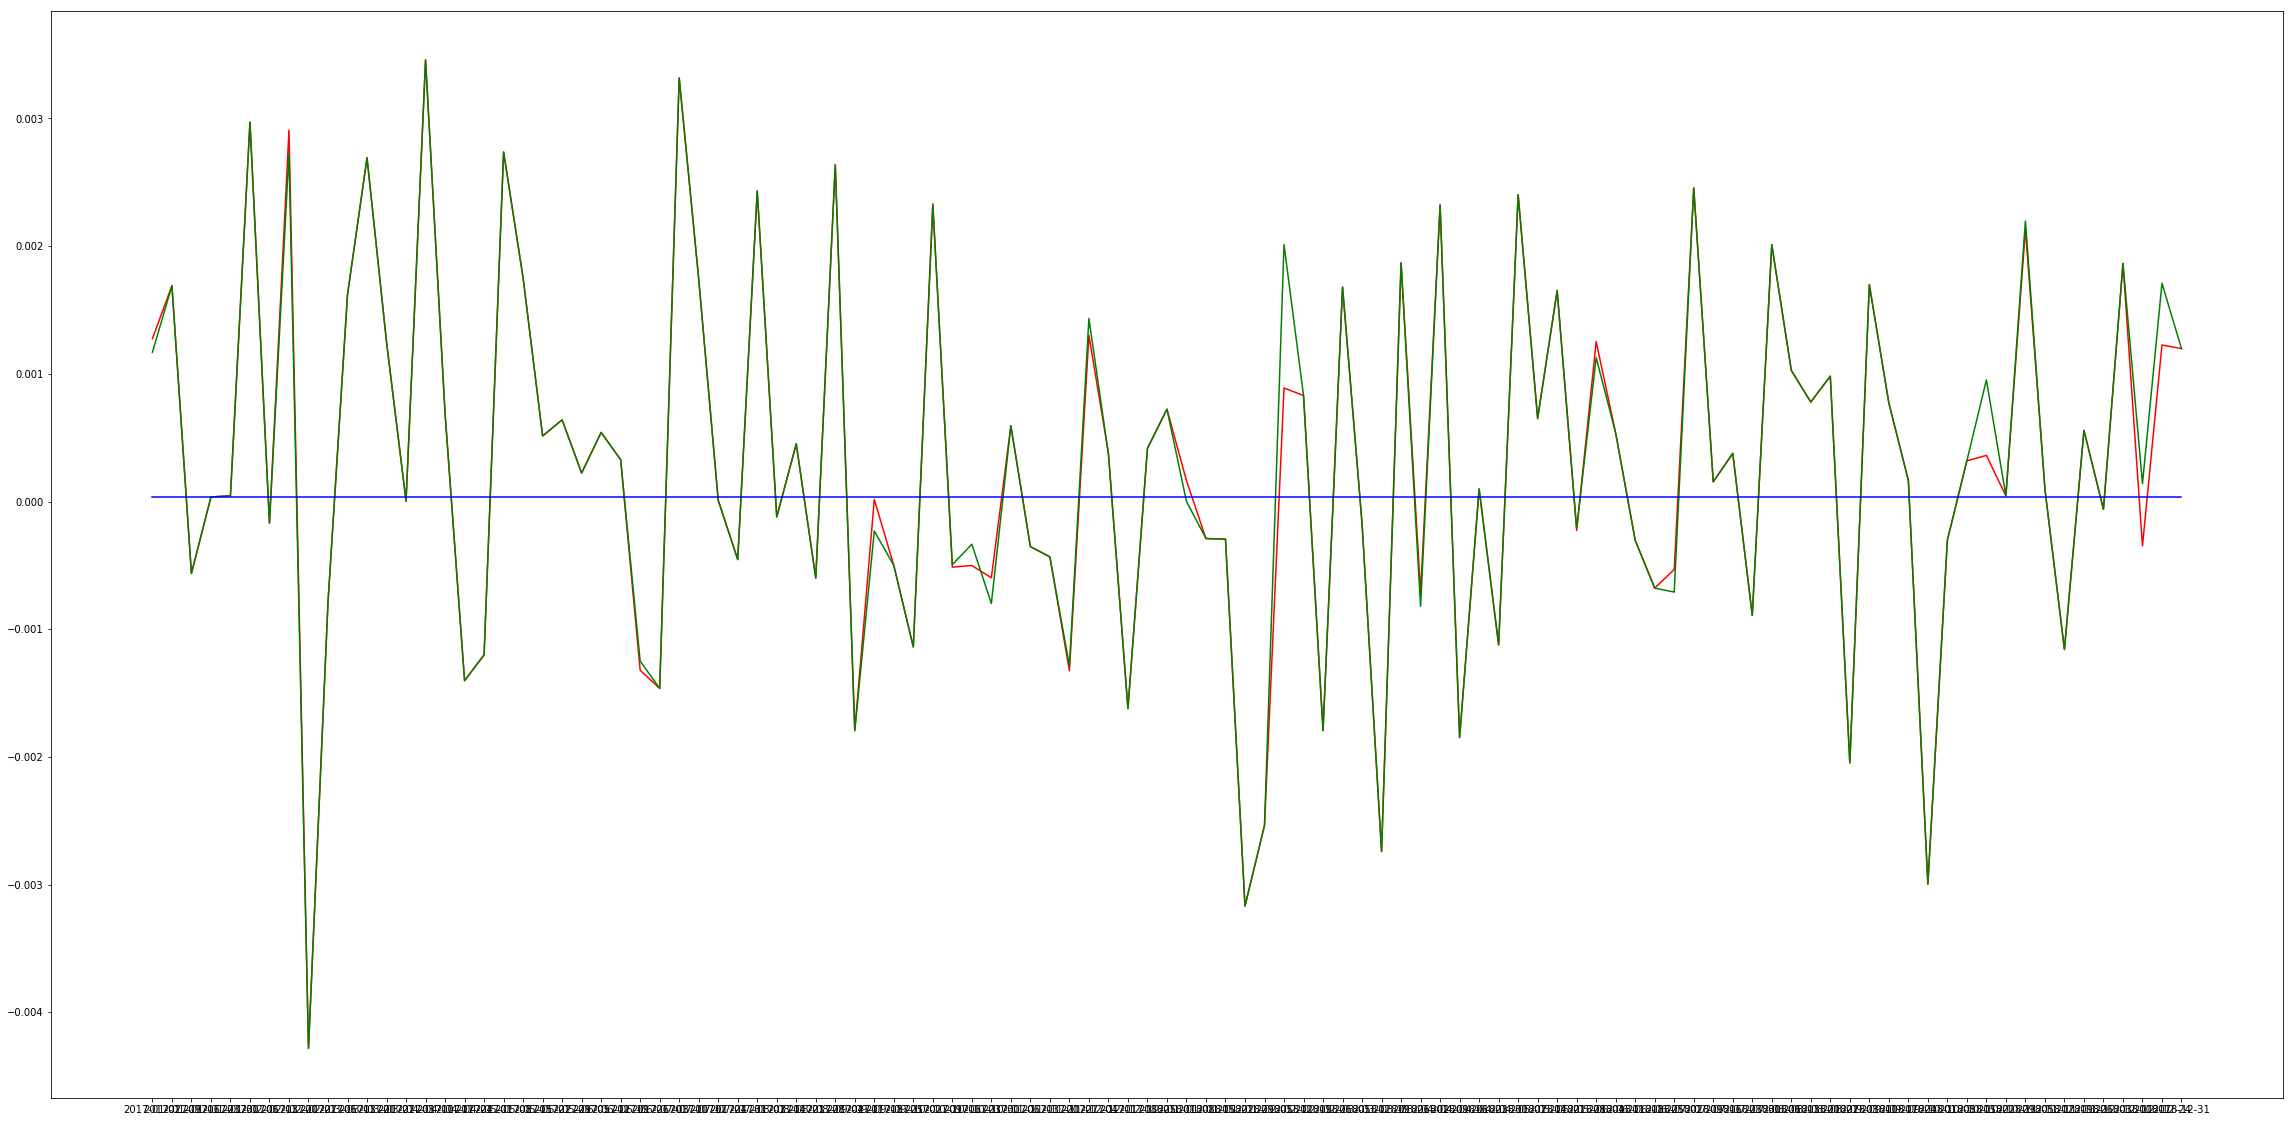

In [27]:
plt.figure(figsize=(40,20))
plt.plot(test,'r')
plt.plot(test01,'g')
plt.plot(range(len(test)),rfrate1,'b')

In [28]:
print(test.mean(),rfrate,sp500_re.mean())

0    0.000276
dtype: float64 0.0020482083333333333 0    0.001349
dtype: float64


In [21]:
test.to_csv('week_return.csv')

In [23]:
sp500 = pd.read_csv("C:\\Users\\USER\\Desktop\\^GSPC (3).csv")
sp500_1 = sp500[sp500['Date']>'2016-12-25']
sp500_2 = sp500_1[sp500_1['Date']<='2018-12-31']
return_sp500 = []
sp500_list = sp500_2['Adj Close'].tolist()
for i in range(len(sp500_2)-1) :
    return_sp500.append((sp500_list[i+1] - sp500_list[i]) / sp500_list[i])
sp500_re = pd.DataFrame(return_sp500)

In [25]:
#agrval = []
#for i in range(len(test)-1) :
#    value = (1+test.iloc[i,0]) * (1+test.iloc[i+1,0])
#    agrval.append(value)
#agrval_sp500 = []
#for i in range(len(sp500_re)-1) :
#    value = (1+sp500_re.iloc[i,0]) * (1+sp500_re.iloc[i+1,0])
#    agrval_sp500.append(value)
agrval_risk = []
for i in range(len(sp500_re)-1) :
    value = (1+rfrate/4) * (1+rfrate/4)
    agrval_risk.append(value)
    
store = 1
store_sp = 1
store_nor =1
agr_val = []
agr_val_sp = []
agr_norisk = []
for i in range(len(test)):
    value = store * (1+test.iloc[i])
    store = value
    agr_val.append(store)
    value_sp = store_sp * (1+sp500_re.iloc[i])
    store_sp = value_sp
    agr_val_sp.append(store_sp)
    value_no = store_nor * (1+rfrate/4)
    store_nor = value_no
    agr_norisk.append(value_no)


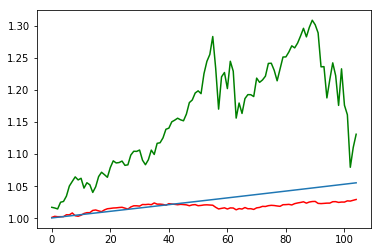

In [26]:
plt.plot(agr_val_sp,'g')
plt.plot(agr_val,'r')
plt.plot(agr_norisk)